# Telangana Crop Health Challenge
---
###  Can you predict the health status of crops?




---



# Libraries and Modules Import

In [24]:
# Standard Library Imports
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
import os
import random

# Third-Party Imports
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from lightgbm import LGBMClassifier
from shapely.affinity import scale, translate
from skimage import exposure
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from shapely import wkt
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

import logging
# Set up a logger to capture Rasterio warnings
logging.getLogger("rasterio._env").setLevel(logging.ERROR)

# Project Setup and Earth Engine Initialization

In [25]:
# Define the root path for the project
root_path = Path(os.getcwd()) / '..'
root_path

WindowsPath('d:/github/telangana-crop-health/notebooks/..')

In [26]:
# Authenticate with Google Earth Engine
# This opens a browser prompt for authentication, if not previously authenticated
ee.Authenticate()

project = os.getenv("PROJECT_ID")

# Initialize Earth Engine with a specific project
# Replace "project" with your project ID as needed
ee.Initialize(project=project)

# Data Loading and Preprocessing

**Load Train and Test**

In [27]:
# Load training and testing datasets from CSV files
data_path = root_path / 'telangana_data' / 'data'
train_path = data_path / 'Train.csv'
test_path = data_path / 'Test.csv'

# Load the datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

**Convert Geometry Columns to Geospatial Format**

In [28]:
# Convert WKT geometry to actual geometry objects in both datasets
train['geometry'] = train['geometry'].apply(wkt.loads)
test['geometry'] = test['geometry'].apply(wkt.loads)

**Convert DataFrames to GeoDataFrames**

In [29]:
# Convert pandas DataFrames to GeoDataFrames with CRS set to 'epsg:4326'
train = gpd.GeoDataFrame(train, crs='epsg:4326')
test = gpd.GeoDataFrame(test, crs='epsg:4326')

**Concatenate Train and Test Data for Unified Processing**

In [30]:
# Concatenate train and test datasets into a single DataFrame for consistent processing
# 'dataset' column distinguishes between train and test rows
data = pd.concat(
    [train.assign(dataset='train'), test.assign(dataset='test')]
).reset_index(drop=True)

**Scale Geometry Objects**

In [31]:
# Function to scale each geometry around its centroid
def scale_geometry(geometry, scale_factor):
    """
    Scale a geometry object around its centroid.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): Geometry to scale.
        scale_factor (float): Factor by which to scale the geometry.

    Returns:
        shapely.geometry.base.BaseGeometry: Scaled geometry object.
    """
    # Calculate centroid
    centroid = geometry.centroid
    # Translate geometry to origin
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    # Scale geometry
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    # Translate back to the original centroid
    return translate(scaled_geometry, centroid.x, centroid.y)

In [32]:
# Set the scaling factor
scale_factor = 5

# Apply the scaling function to each geometry in the data
# This modifies each geometry in place by the defined scale factor
data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=scale_factor)

# Download Image Data

**Utils**

In [33]:
# Function to ensure date format is correct
def format_date(date_str):
    """Convert date string to 'YYYY-MM-DD' format."""
    try:
        return datetime.strptime(date_str, '%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        print(f"Error: Invalid date format for {date_str}. Expected 'DD-MM-YYYY'.")
        return None

**Convert GeoDataFrame to Earth Engine FeatureCollection**

In [34]:
# Function to convert a GeoDataFrame to Google Earth Engine FeatureCollection
def gdf_to_gee(gdf):
    """Converts a GeoDataFrame to an Earth Engine FeatureCollection."""
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry'].__geo_interface__  # Convert geometry to GeoJSON format
        feature = ee.Feature(ee.Geometry(geom), row.to_dict())  # Create an EE Feature
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the entire dataset GeoDataFrame to a FeatureCollection for GEE
gee_feature_collection = gdf_to_gee(data)

**Initialize Earth Engine and Set Up Directories**

In [35]:
# if you already downloaded the data.
donwload = False

# Initialize Earth Engine
ee.Initialize()

# Remove existing 'downloads' folder if it exists
if os.path.exists('downloads'):
    os.system('rm -rf downloads')

# Ensure the output directory exists
output_folder = 'downloads'
os.makedirs(output_folder, exist_ok=True)

**Download from Earth Engine**

In [36]:
# Function to download RGB images from Earth Engine
def download_rgb_image(collection_name, bands, start_date, end_date, region, output_folder='downloads'):
    """Download RGB bands from a GEE collection filtered by date and region."""
    # Load the image collection, filter by date, and clip to region
    collection = ee.ImageCollection(collection_name).filterDate(start_date, end_date).filterBounds(region)
    image = collection.sort('system:time_start', False).first().select(bands).clip(region)  # Most recent image

    # Define unique filename based on image dates
    image_id = image.id().getInfo() or f'image_{start_date}_{end_date}'
    image_name = f'{output_folder}/{image_id}_RGB_{start_date}_{end_date}.tif'

    # Export the image to a GeoTIFF file
    geemap.ee_export_image(
        image,
        filename=image_name,
        scale=10,  # Sentinel-2 resolution in meters
        region=region,
        file_per_band=False,  # Save as a multi-band TIFF
        crs='EPSG:4326'
    )
    print(f"Downloaded: {image_name}")
    return image_name

In [37]:
# Function to process each row in the dataset for image download
def process_row(index, row):
    # Format start and end dates
    start_date = format_date(row['SDate'])
    end_date = format_date(row['HDate'])

    # Skip rows with invalid dates
    if not start_date or not end_date:
        print(f"Skipping entry due to invalid dates: SDate={row['SDate']}, HDate={row['HDate']}")
        return index, None

    # Extract and check geometry
    region_geometry = row['geometry']
    district = row['District']

    # Verify valid geometry and convert it to EE format
    if region_geometry.is_empty:
        print(f"Skipping entry due to empty geometry for District: {district}")
        return index, None

    # Convert geometry type to EE compatible format
    if region_geometry.geom_type == 'Polygon':
        region = ee.Geometry.Polygon(region_geometry.__geo_interface__['coordinates'])
    elif region_geometry.geom_type == 'MultiPolygon':
        coords = [polygon.exterior.coords[:] for polygon in region_geometry.geoms]
        region = ee.Geometry.MultiPolygon(coords)
    else:
        print(f"Skipping unsupported geometry type: {region_geometry.geom_type} for District: {district}")
        return index, None

    # Define Sentinel-2 collection and bands
    image_collection_name = 'COPERNICUS/S2'
    bands = ['B4', 'B3', 'B2', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

    # Attempt to download the image
    try:
        image_file = download_rgb_image(image_collection_name, bands, start_date, end_date, region, output_folder)
        return index, image_file
    except Exception as e:
        print(f"Error processing entry for District {district}: {e}")
        return index, None

In [38]:
import pandas as pd

# Assuming 'SDate' and 'HDate' are the columns with dates
data['SDate'] = pd.to_datetime(data['SDate'], errors='coerce').dt.strftime('%d-%m-%Y')
data['HDate'] = pd.to_datetime(data['HDate'], errors='coerce').dt.strftime('%d-%m-%Y')

# Check for rows with invalid dates after conversion
invalid_rows = data[data['SDate'].isnull() | data['HDate'].isnull()]
print("Rows with invalid dates:")
print(invalid_rows)
donwload = True

Rows with invalid dates:
Empty GeoDataFrame
Columns: [FarmID, category, Crop, State, District, Sub-District, SDate, HDate, CropCoveredArea, CHeight, CNext, CLast, CTransp, IrriType, IrriSource, IrriCount, WaterCov, ExpYield, Season, geometry, dataset]
Index: []

[0 rows x 21 columns]


In [49]:
if donwload:
  # Execute image downloads for each row in parallel to improve performance
  with ThreadPoolExecutor(max_workers=50) as executor:  # Adjust the number of workers as needed
      futures = [executor.submit(process_row, index, row) for index, row in data.iterrows()]
      for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading Images", unit="image"): 
          index, image_file = future.result()
          if image_file:
              data.at[index, 'tif_path'] = image_file  # Store the downloaded file path
else:
  # Load existing data with image paths if downloads are not required
  os.system('cp -r ./downloads .')
  data_path = "./data.csv"

  data = pd.read_csv(data_path)

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-23_2024-05-24.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-12-28_2024-01-05.tif
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-11-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-11-15_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-11-15_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-12-12_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-12-12_2024-05-19.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-06-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-06-12_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-01-11_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-01-11_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-27_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-27_2024-05-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHV_RGB_2023-11-13_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHV_RGB_2023-11-13_2024-09-05.tif
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-12-18_2024-04-20.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-11-20_2024-05-20.tif
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-02-12_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-11_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-11_2024-05-25.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-20_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-04-12_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-04-12_2024-05-28.tif


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-12-11_2024-04-19.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHV_RGB_2023-11-27_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHV_RGB_2023-11-27_2024-09-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-10-11_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-10-11_2024-05-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-11_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-11_2024-05-18.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-02-12_2024-05-29.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-11-20_2024-04-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-12-13_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-13_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-12-24_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-12-24_2024-01-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-11-12_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-11-12_2024-05-21.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-12-30_2024-08-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-11-19_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-11-19_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-09-12_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-09-12_2024-05-25.tif
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-08-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-08-12_2024-05-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-12-13_2024-05-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-02-11_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-02-11_2024-05-30.tif


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-12-30_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-30_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-08-11_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-08-11_2024-11-05.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-12-28_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-12-28_2024-05-14.tif
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHV_RGB_2023-11-13_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHV_RGB_2023-11-13_2024-04-26.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241004T050651_20241004T052234_T43QHV_RGB_2023-10-12_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-07-11_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-07-11_2024-04-24.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-06-12_2024-12-04.tif
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-11-17_2024-03-05.tif


Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-03-12_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-03-12_2024-04-29.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-12-27_2024-05-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-24_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-24_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-12-19_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-19_2024-04-28.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-10-12_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-10-12_2024-05-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHV_RGB_2023-10-12_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHV_RGB_2023-10-12_2024-04-22.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240704T051659_20240704T053003_T43QHV_RGB_2023-11-11_2024-07-05.tif
Downloaded: downloads/20240704T051659_20240704T053003_T43QHV_RGB_2023-11-11_2024-07-05.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-11-22_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-11-22_2024-03-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKE_RGB_2023-12-25_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKE_RGB_2023-12-25_2024-05-04.tif
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-11-23_2024-02-05.tif
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-04-12_2024-04-23.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-25_2024-04-14.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-05-11_2024-04-15.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-21_2024-04-26.tif
Please wait ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-12-16_2024-05-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-01-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-01-12_2024-04-23.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-07-12_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-07-12_2024-01-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-11-26_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-11-26_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-12-14_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-12-14_2024-03-27.tif
Please wait ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-27_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-27_2024-05-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-27_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-27_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-12-14_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-12-14_2024-04-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-12-22_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-01-11_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-01-11_2024-05-19.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-12-27_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-12-27_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-12-23_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-12-23_2024-03-18.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-03-12_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-03-12_2024-05-26.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-06-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-06-12_2024-04-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-09-11_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-09-11_2024-05-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB_2023-12-27_2024-05-22.tif
Downloaded: downloads/20240520T051651_20

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB_2023-12-21_2024-05-22.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QHV_RGB_2023-12-21_2024-05-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-03-12_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-03-12_2024-05-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-07-12_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-07-12_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-26_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-26_20

Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHV_RGB_2023-10-29_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHV_RGB_2023-10-29_2024-02-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-25_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-09-12_2024-04-30.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-25_2024-05-25.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-09-12_2024-04-30.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB_2023-11-15_2024-05-21.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QHV_RGB_2023-11-15

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGV_RGB_2023-10-30_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGV_RGB_2023-10-30_2024-03-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHV_RGB_2023-05-10_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHV_RGB_2023-05-10_2024-03-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-12-29_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-12-29_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-12-21_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-13.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-12-21_2024-02-20.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-11-29_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-11-29_2024-04-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-11-24_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-11-24_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHA_RGB_2023-10-22_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHA_RGB_2023-10-22_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-11-13_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-11-13_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHA_RGB_2023-06-10_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHA_RGB_2023-06-10_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGV_RGB_2023-10-16_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGV_RGB_2023-10-16_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHA_RGB_2023-03-10_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHA_RGB_2023-03-10_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHV_RGB_2023-02-12_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHV_RGB_2023-02-12_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHV_RGB_2023-10-21_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHV_RGB_2023-10-21_2024-05-02.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-11-15_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-11-15_2024-10-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHV_RGB_2023-10-28_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHV_RGB_2023-10-28_2024-03-15.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-13_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-13_2024-05-30.tif
An error occurred while downloading.
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-01-12_2024-02-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-09-11_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-09-11_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGV_RGB_2023-10-21_2024-02-19.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGV_RGB_2023-10-21_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-12-21_2024-0

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHV_RGB_2023-10-19_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHV_RGB_2023-10-19_2024-03-27.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QHV_RGB_2023-03-10_2024-11-03.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHV_RGB_2023-10-14_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHV_RGB_2023-10-14_2024-12-02.tif
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-11-19_2024-07-03.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QHV_RGB_2023-11-18_2024-02-28.tif
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-08-12_2024-07-03.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-09-12_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-09-12_2024-02-18.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHV_RGB_2023-11-15_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHV_RGB_2023-11-15_2024-03-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-02-11_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-02-11_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-11-18_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-11-18_2024-03-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-11-19_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-11-19_2024-06-03.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHV_RGB_2023-07-11_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHV_RGB_2023-07-11_2024-03-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-10-21_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-10-21_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-04-11_2024-02-20.tif
Down

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-12-20_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-11-18_2024-04-28.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-12-20_2024-03-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-11-18_2024-04-28.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHV_RGB_2023-12-19_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHV_RGB_2023-12-19_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-10-25_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_202

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-07-11_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-07-11_2024-06-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-10_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-10_2024-01-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-12-28_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-12-28_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-12-23_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-12-23_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-05-10_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-05-10_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGV_RGB_2023-10-27_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGV_RGB_2023-10-27_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-03-11_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-03-11_2024-02-20.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-12-15_2024-02-27.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-12_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-11-12_2024-02-14.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QHV_RGB_2023-12-29_2024-03-02.tif
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-28_2024-10-03.tif
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHV_RGB_2023-12-10_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-12-10_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHV_RGB_2023-10-31_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHV_RGB_2023-10-31_2024-03-22.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-25_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-25_2024-02-03.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QHV_RGB_2023-03-12_2024-02-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-10-18_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-10-18_2024-02-17.tif


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-10-12_2024-04-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-12-13_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-12-13_2024-03-21.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-23_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-23_2024-03-21.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-30_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-30_2024-07-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-11-22_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-11-22_2024-06-03.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-12_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-12_2024-03-22.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHV_RGB_2023-12-20_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHV_RGB_2023-12-20_2024-05-02.tif


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHV_RGB_2023-11-14_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHV_RGB_2023-11-14_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-12-25_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-12-25_2024-02-02.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-02-10_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-02-10_2024-03-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-05-12_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-05-12_2024-03-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-12-29_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-12-29_2024-04-03.tif


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-15_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-15_2024-03-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-11-21_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-21_2024-11-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-16_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-16_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-08-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-16_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-16_2024-06-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-12-20_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-12-20_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-10_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-10_2024-10-03.tif


Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKG_RGB_2023-10-30_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKG_RGB_2023-10-30_2024-02-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-12-10_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-12-10_2024-07-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-12-17_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-12-17_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-10-27_2024-07-03.tif
Downloaded: downloads/20240701T050659_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-10-10_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-10-10_2024-09-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKG_RGB_2023-11-14_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKG_RGB_2023-11-14_2024-09-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-10-10_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-10-10_2024-01-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-12-18_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-12-18_2024-01-03.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-06-10_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-06-10_2024-02-26.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-30_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-30_2024-03-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-10-30_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-10-30_2024-02-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHA_RGB_2023-12-15_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHA_RGB_2023-12-15_2024-10-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_2024022

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-11-26_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-26_2024-02-25.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-26_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-26_2024-02-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-10-21_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-10-21_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-08-11_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-08-11_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-03-10_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-03-10_2024-04-03.tif
Generatin

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-06-11_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-06-11_2024-02-17.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-29_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-29_2024-02-23.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-15_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-15_2024-03-21.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-03-12_2024-04-03.ti

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-16_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-16_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-07-12_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-07-12_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-10-27_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-10-27_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-02-10_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-02-10_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-20_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-20_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-10-15_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-10-15_2024-10-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-06-11_2024-07-03.tifDownloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/34f2413a8550ef1b6fa270b6073bf9af-d4b41c76b9a614dbb4949ce47f612919:getPixels
Please wait ...

Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-06-11_2024-07-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-11-13_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-11-13_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T052252_T43QHB_RGB_2023-10-24_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T052252_T43QHB_RGB_2023-10-24_2024-03-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\down

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-02-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-02-11_2024-03-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-01-11_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-01-11_2024-08-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-16_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-16_2024-09-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-23_2024-09-02.tif
Downloaded: downloads/20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-06-10_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-06-10_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-29_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-29_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-29_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-29_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-11_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-11_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-10-19_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-10-19_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-24_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-24_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-10-26_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-10-26_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-12-12_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-12-12_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-12-18_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-18_2024-01-03.tif
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-07-12_2024-10-03.tif
Error processing entry for District Adilabad: Image.select: Parameter 'input' is required and may not be null.
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-01-12_2024-02-26.tif


Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-26_2024-01-03.tif
An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-16_2024-02-28.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-23_2024-11-03.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-10-22_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-10-22_2024-03-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-22_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-22_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKG_RGB_2023-11-30_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKG_RGB_2023-11-30_2024-07-02.tif


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-22_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-11-19_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-11-19_2024-12-02.tif
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-29_2024-03-25.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-11_2024-03-27.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-24_2024-03-30.tif
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-31_2024-03-22.tif
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-02-10_2024-03-29.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-17_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-17_2024-02-16.tif
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-12-15_2024-02-14.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-06-12_2024-04-15.tif


An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-22_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-26_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-26_2024-09-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-12_2024-03-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKG_RGB_2023-11-16_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKG_RGB_2023-11-16_2024-03-23.tif


Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240308T050651_20240308T052226_T43QHB_RGB_2023-11-21_2024-03-13.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-19_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-19_2024-03-24.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-05-10_2024-02-18.tif
An error occurred while downloading.
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-06-11_2024-05-02.tif
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QKG_RGB_2023-10-23_2024-08-02.tif


An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-05-10_2024-02-27.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-11-15_2024-02-20.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-13_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-13_2024-10-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-01-12_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-01-12_2024-03-16.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-23_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-23_2024-07-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-11-11_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-11-11_2024-02-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-12_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-12_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-16_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-16_2024-02-18.tif
Data downloaded to 

An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QHC_RGB_2023-11-19_2024-02-28.tif
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T44QKG_RGB_2023-12-10_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T052252_T43QHB_RGB_2023-12-28_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T052252_T43QHB_RGB_2023-12-28_2024-03-03.tif
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-03-11_2024-04-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T44QKG_RGB_2023-11-11_2024-09-03.tif
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-10-29_2024-05-03.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-06-11_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-10-31_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-10-31_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-11-23_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-11-23_2024-02-02.tif
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-01-11_2024-05-03.tif
An error occurred while do

An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-30_2024-02-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-11_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-11_2024-03-15.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-21_2024-02-18.tif
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-12-10_2024-02-13.tif
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-06-11_2024-03-28.tif
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-12-14_2024-08-03.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-25_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-25_2024-03-02.tif
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-10-21_2024-09-02.tif


Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-10_2024-05-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-17_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-17_2024-02-24.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-12-27_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-12-27_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-14_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-14_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-26_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-26_2024-03-27.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T44QKG_RGB_2023-11-18_2024-03-22.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-25_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-25_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-10-23_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-10-23_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-22_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-22_2024-02-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-27_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-27_2024-03-21.tif
Generating URL ...
Data downloaded to d:\git

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-24_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-24_2024-11-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-06-12_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-06-12_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-19_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-19_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-10-21_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-21_2024-04-02.tif
Please wait ...
Generatin

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-29_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-29_2024-03-26.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-09-12_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-09-12_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-07-12_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-07-12_2024-02-02.tif
Generating URL ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-12-12_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-12-12_2024-09-02.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-26_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-26_2024-02-19.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-11-20_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-20_2024-02-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKG_RGB_2023-11-19_2024-02-24.tif
Generating URL ...
Downloaded: downloads/20240222T050829_20240222T051835_T44QKG_RGB_2023-11-19_2024-02-24.tif
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-12-18_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-12-18_2024-02-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-12-12_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-12-12_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-10_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-10_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-25_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-25_2024-03-17.tif
Please wait ...
Please wait ...
Data down

Please wait ...Generating URL ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-12_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-12_2024-05-02.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-11_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-11_2024-02-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-11-28_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-11-28_2024-04-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-26_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-26_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHB_RGB_2023-10-18_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-10-18_2024-04-02.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-17_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-17_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-17_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-17_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-01-12_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-01-12_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-20_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-20_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-03-11_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-03-11_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-10-24_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-10-24_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-01-12_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-01-12_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-08-10_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-08-10_2024-02-22.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-22_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-22_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-12-27_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-12-27_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-16_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-16_2024-03-03.tif
Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-04-12_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-04-12_2024-03-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-10-31_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-16_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-16_2024-03-16.tif
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-04-10_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-10-31_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-10-31_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKG_RGB_2023-07-11_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKG_RGB_2023-07-11_2024-03-17.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-24_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-24_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-19_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-19_2024-06-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-09-11_2024-08-03.tif
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-31_2024-03-25.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-11_2024-04-22.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_2023-12-18_2024-12-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-29_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-29_2024-07-03.tif
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-20_2024-05-03.tif
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-11-20_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-20_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-12-11_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-11_2024-01-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-28_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-28_2024-04-13.t

An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-26_2024-04-26.tif
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-10-12_2024-05-03.tif
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-11_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-05-12_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-05-12_2024-04-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-22_2024-03-21.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-15_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-15_2024-03-20.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-06-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-06-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-04-11_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-04-11_2024-04-27.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-08-12_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-08-12_2024-03-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-11_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-11_2024-09-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-24_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-24_2024-06-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-06-11_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-06-11_2024-10-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-06-11_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-06-11_2024-03-18.tif
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-16_2024-11-02.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-16_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-16_2024-03-16.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-27_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-27_2024-03-27.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-30_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-12-30_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-11-24_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-24_2024-02-26.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-30_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-30_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-16_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-16_2024-06-04.tif
Data downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-29_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-29_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-18_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-18_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-11_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-18_2024-07-03.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-11_2024-03-26.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-18_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-12-29_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-12-29_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-02-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-02-11_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-03-12_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-03-12_2024-03-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-05-11_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-01-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-01-11_2024-03-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-23_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-23_2024-04-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHB_RGB_2023-05-11_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_2023-05-11_2024-12-04.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-03-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-03-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-08-11_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-08-11_2024-02-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-14_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-11_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-11_2024-04-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-14_2024-03-24.tif
Generating URL ...
Generating URL ...
Dat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-16_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-16_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-24_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-24_2024-04-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-11-24_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-24_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-05-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-05-11_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-17_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-17_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-28_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-28_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-14_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-14_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-15_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-15_2024-03-21.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-16_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-16_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-12-22_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-12-22_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-11-16_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-16_2024-11-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wa

Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-12-30_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-09-11_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-09-11_2024-01-04.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-03-11_2024-03-24.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-11-25_2024-04-03.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-09-11_2024-02-19.tif
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-07-11_2024-03-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-23_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-23_2024-03-13.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-09-11_2024-04-25.tif
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-19_2024-04-22.tif


An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-09-12_2024-03-16.tif
Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-11-20_2024-11-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-03-11_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-03-11_2024-11-03.tif


Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-16_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-16_2024-04-27.tif
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-14_2024-02-13.tif
Please wait ...
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-14_2024-02-13.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-10-17_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-17_2024-02-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-29_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-29_2024-04-24.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-13_2024-02-20.tif


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-25_2024-02-23.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-10-27_2024-04-29.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-11_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-11_2024-03-03.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-10-21_2024-02-22.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-27_2024-02-24.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-03-11_2024-04-15.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-15_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-22_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-22_2024-04-20.tif
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-07-11_2024-02-03.tif
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-28_2024-03-18.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-28_2024-03-18.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-19_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-19_2024-03-16.tif
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-02-11_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-02-11_2024-03-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-07-10_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-07-10_2024-02-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-10_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-11-10_2024-02-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-10_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-10_2024-04-25.tif
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-11_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-01-11_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-01-11_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-11_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-11-23_2024-10-03.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-11_2024-04-13.tif
Downloaded: downloads/20241002T05164

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-29_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-29_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-23_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-23_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-03-12_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-03-12_2024-03-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-01-11_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-01-11_2024-

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-24_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-24_2024-04-13.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-15_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-15_2024-04-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-24_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-24_2024-07-03.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-27_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-27_2024-02-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-23_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-23_2024-03-17.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-13_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-13_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-19_2024-04-29.tif
Da

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-05-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-05-11_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-05-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-05-12_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T43QHB_RGB_2023-11-10_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T43QHB_RGB_2023-11-10_2024-03-13.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-04-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-28_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-28_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-03-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-03-11_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-01-10_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-01-10_2024-03-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-10_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-10_2024-02-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-02-11_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-02-11_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-04-10_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-04-10_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-24_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-24_2024-04-

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-14_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-14_2024-07-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-27_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-27_2024-04-27.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-15_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-15_2024-02-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-19_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-19_2024-02-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-11-23_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-23_2024-02-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-18_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-18_2024-06-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-07-11_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-07-11_2024-04-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-10-31_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-10-31_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-10-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-10-11_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-08-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-08-11_2024-04-18.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-07-10_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-07-10_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-11-20_2024-02-18.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-11-20_2024-02-18.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-20_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-20_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-24_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-24_2024-03-30.tif
Data d

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-10-30_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-10-30_2024-03-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-14_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-14_2024-12-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-14_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-14_2024-04-25.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-23_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-23_2024-05-03.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-06-10_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-06-10_2024-05-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-16_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-16_2024-02-04.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-04-11_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-04-11_2024-09-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-01-10_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-01-10_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-11_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-11_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-10_2024-11-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-07-10_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-07-10_2024-04-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-11_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-11_2024-02-23.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-26_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-26_2024-01-03.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-10-14_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-10-14_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-10-24_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-10-24_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-07-11_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-07-11_2024-04-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-21_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-21_2024-03-14.tif
Generating URL ...
Dat

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-26_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-22_2024-04-14.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-26_2024-03-26.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-22_2024-04-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-27_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-27_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-05-10_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-05-10_2024-04-18.tif
Please wait ...
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-08-10_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHB_RGB_2023-03-11_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-31_2024-03-26.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-08-10_2024-06-02.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-31_2024-03-26.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-03-11_2024-04-02.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-05-11_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_R

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-29_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-29_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-06-11_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-06-11_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-10-26_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-10-26_2024-02-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-16_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-16_2024-09-04.tif
Please wait ...
Data downloa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-10-25_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-10-25_2024-09-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-10-16_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-10-16_2024-01-04.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-01-10_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-01-10_2024-03-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-11-13_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-27_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-11-27_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-31_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-31_2024-03-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-11_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-11_2024-03-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-17_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-16_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-16_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-21_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-21_2024-04-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-05-11_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-05-11_2024-02-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-07-10_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-05-11_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-05-11_2024-02-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-11_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-11_2024-06-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-10-21_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-10-21_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-10-31_2024-02-17.tif
Generating URL ...
Downloaded: downloads/20240

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-24_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-24_2024-06-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-11-13_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-11-13_2024-12-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-11-22_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-22_2024-04-29.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-09-10_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-09-10_2024-03-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-10_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-10_2024-03-16.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-10-28_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-10-28_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-11-15_2024-02-20.tif
Downloaded: downloads/20

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-17_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-17_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-19_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-19_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-15_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-15_2024-06-04.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-02-11_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T05183

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-28_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-11-28_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-10-25_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-10-25_2024-02-02.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-06-11_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-06-11_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-03-11_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-03-11_2024-08-03.tif
Please wa

Please wait ...Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-10-21_2024-03-13.tif

Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-10-21_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-12-11_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-12-11_2024-02-27.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-01_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-01_2024-02-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-09-10_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QH

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHU_RGB_2023-11-04_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHU_RGB_2023-11-04_2024-01-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QHU_RGB_2023-11-06_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QHU_RGB_2023-11-06_2024-01-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QHU_RGB_2023-10-06_2024-02-11.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QHU_RGB_2023-10-06_2024-02-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-11-23_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-11-23_2024-02-01.tif
Generating URL ...
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-27_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-27_2024-02-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-05-11_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-05-11_2024-03-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QHU_RGB_2023-10-27_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QHU_RGB_2023-10-27_2024-02-10.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-11-17_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-17_20

Generating URL ...Generating URL ...
Generating URL ...
Please wait ...
Please wait ...

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-11-18_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-03-10_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-11-04_2024-02-22.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-03-10_2024-04-26.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-11-18_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-24_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-24_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-08-10_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-08-10_2024-11-03.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QHU_RGB_2023-10-31_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QHU_RGB_2023-10-31_2024-01-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-10-14_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-10-14_2024-02-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-10-12_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-10-12_2024-02-17.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QHU_RGB_2023-10-26_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-10-21_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-10-21_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-23_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-23_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-28_2024-02-13.tif
Generating URL ...
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-28_2024-02-13.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHU_RGB_2023-11-19_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-05_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-05_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-26_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-26_2024-02-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-11-19_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-11-19_2024-02-25.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHU_RGB_2023-10-31_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHU_RGB_2023-10-31_2024-01-01.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB_2023-11-03_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-11-03_2024-01-14.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-01_2024-01-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-27_2024-01-31.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-01_2024-01-23.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-27_2024-01-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-06_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-06_2024-02-18.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-10-17_2024-01-07.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-19_2024-01-11.tif

Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-10-17_2024-01-07.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-19_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-16_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-16_2024-01-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-24_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-24_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-20_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-20_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-24_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-24_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-04-12_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-04-12_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-11-09_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-11-09_2024-01-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-03_2024-02-18.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-10-15_2024-01-04.tif
An error occurred while downloading.
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-03_2024-01-12.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-30_2024-02-23.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-09_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-09_2024-02-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-12_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-12_2024-01-13.tif


An error occurred while downloading.
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-17_2024-01-01.tif
An error occurred while downloading.
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-01_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-12_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-12_2024-01-10.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-07_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-07_2024-02-27.tif
An error occurred while downloading.
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-12_2024-01-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-03_2024-02-13.tif
An error occurred while downloading.
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-15_2024-02-10.tif
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-27_2024-02-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-14_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-14_2024-01-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-24_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-24_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-24_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-24_2024-02-16.tif
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-10-30_2024-02-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-01_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-01_2024-02-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-03_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-03_2024-02-04.tif
Generating URL ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-11_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-11_2024-01-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-09_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-09_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-12_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-12_2024-01-11.tif


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-31_2024-01-10.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-25_2024-01-05.tif
An error occurred while downloading.
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-14_2024-02-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-11_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-11_2024-01-13.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-31_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-31_2024-01-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-02_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-02_2024-02-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-04_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-04_2024-01-08.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-15_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-10-15_2024-01-15.tif


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-22_2024-02-22.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-10-02_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-10-02_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-10_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-10-10_2024-01-14.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-29_2024-02-12.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-29_2024-02-12.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-28_2024-01-07.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-28_2024-01-07.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-29_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-29_2024-01-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-13_2024-02-06.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-13_2024-02-06.tif


Please wait ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-14_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-14_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-14_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-14_2024-02-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-20_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-04_2024-01-14.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-20_2024-02-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-10-04_2024-01-14.tif
Data downloaded to d:\

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-30_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-30_2024-01-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-11-28_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-28_2024-01-01.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHU_RGB_2023-11-08_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHU_RGB_2023-11-08_2024-01-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-14_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-14_2024-02-

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-07_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-07_2024-01-23.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-08_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-08_2024-02-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QHU_RGB_2023-10-06_2024-02-11.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QHU_RGB_2023-10-06_2024-02-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-08_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QHU_RGB_2023-10-08_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QHU_RGB_2023-10-08_2024-01-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-05_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-05_2024-02-01.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-07_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-07_2024-02-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-11-28_2024-02-23.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-19_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-19_2024-02-16.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-11_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-11_2024-01-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-11-15_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-15_2024-02-03.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-11-18_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T05220

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-14_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-14_2024-02-01.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-06_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-06_2024-02-15.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-03_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-03_2024-02-24.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T0

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-23_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-23_2024-01-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-24_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-24_2024-02-22.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-03_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-03_2024-01-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-22_2024-02-17.tif
Downloaded: downloads

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QHU_RGB_2023-10-04_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QHU_RGB_2023-10-04_2024-01-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-17_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-17_2024-02-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-25_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-25_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QHU_RGB_2023-11-13_2024-01-23.tif
Downloaded: downloads/20240118T051131

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-27_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-27_2024-02-16.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-23_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-23_2024-01-27.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-05_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-05_2024-02-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB_2023-11-23_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-11-23_2024-01-

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-17_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-17_2024-02-14.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-20_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-20_2024-02-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-28_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-28_2024-01-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-07_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-07_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-19_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-19_2024-01-12.tif
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-06_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-06_2024-02-07.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-26_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-26_2024-02-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-26_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-26_2024-01-29.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-11-15_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-11-15_2024-02-20.tif
Generating U

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-07_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-07_2024-02-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-13_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-13_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-30_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-30_2024-02-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB_2023-10-21_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-10-21_2024-01-17.tif
Generating URL ...
Genera

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-10_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-10_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-12_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-12_2024-01-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-01_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-01_2024-01-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-27_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-27_2024-01-13.tif
Genera

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-25_2024-02-11.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-25_2024-02-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-07_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-07_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-12_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-12_2024-01-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-31_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-31_2024-01-20.tif
Generating URL ...
Gen

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-10-16_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-10-16_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-10-26_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-10-26_2024-01-01.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-11_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-11_2024-01-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_2024012

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-29_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-29_2024-01-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-12_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-12_2024-02-08.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-20_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-20_2024-01-25.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-14_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-14_2024-02-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-27_2024-01-18.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-27_2024-01-18.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-24_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-24_2024-02-16.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-12-16_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-12-16_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-19_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-19_2024-02-15.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-11-28_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-11-28_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-26_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-26_2024-03-15.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-12-18_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-12-18_2024-04-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-10-12_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-10-12_2024-02-07.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-02-12_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-02-12_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-18_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-18_2024-04-28.tif
Data downloaded to d:\

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-10-21_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-10-21_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-15_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-15_2024-01-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-01_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-18_2024-03-24.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-01_2024-02-22

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-01-11_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-01-11_2024-10-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-30_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-30_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-18_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-18_2024-01-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-07-12_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-07-12_2024-04-17.tif
Please wa

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-02-12_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-02-12_2024-04-29.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-18_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-18_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-20_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-20_2024-01-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-06_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-06_2024-01-

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-30_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-30_2024-05-03.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-19_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-19_2024-11-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-28_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-28_2024-01-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-08-11_2024-08-04.tif
Downloaded: downloads/20240

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-28_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-28_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-21_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-21_2024-03-24.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-14_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-11-14_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-27_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-27_2024-

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-12-22_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-22_2024-01-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-12-24_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-12-24_2024-09-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-01_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-01_2024-01-03.tif
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-12-30_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-12-30_2024-12-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-22_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-22_2024-04-18.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-05-12_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-05-12_2024-06-03.tif
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-11-25_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-25_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-11-02_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-11-02_2024-01-08.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-12-22_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-12-22_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-17_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-17_2024-03-17.tif


Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-12-29_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-12-29_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-07-11_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-12-12_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-07-11_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-12-12_2024-04-15.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-12-29_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-12-29_2024-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-29_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-29_2024-03-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-20_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-20_2024-03-27.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-04-11_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-04-11_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-04-11_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-04-11_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-05-12_2024-03-26.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-14_2024-03-15.tif

Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-05-12_2024-03-26.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-14_2024-03-15.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-12-22_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-12-22_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGA_RGB_2023-12-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-12-11_2024-09-03.tif
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-23_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-23_2024-03-16.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-24_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-24_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-12-13_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-05-11_2024-04-21.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-12-13_2024-04-17.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-01-12_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-01-12_2024-03-21.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-09-12_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-09-12_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-11-15_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-11-15_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-21_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-21_2024-03-17.tif
Data d

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-11-18_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-11-18_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-28_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-28_2024-04-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-01-11_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-01-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T0

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGA_RGB_2023-12-13_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-12-13_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-12-12_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-12-12_2024-03-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-01-12_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-01-12_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-12-18_2024-03-04.tif
Downloaded: downloads/20240301T051741_20

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-12-17_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-12-17_2024-03-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-07-12_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-07-12_2024-09-04.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-12-23_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-12-23_2024-07-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-01-12_2024-04-19.tif
Downloaded: downloads/20240

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-11-15_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-11-15_2024-03-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-11-20_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-11-20_2024-03-24.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-26_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGA_RGB_2023-11-26_2024-12-04.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-26_2024-04-16.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-11-26

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-25_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-25_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-12-23_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-12-23_2024-04-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-07-12_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-07-12_2024-03-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-11-24_2024-03-26.tif
Downloaded: downloads/20240321

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-24_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-24_2024-04-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-07-11_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-07-11_2024-04-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-11-29_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-11-29_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGA_RGB_2023-12-19_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGA_RGB_2023-12-19_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-29_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-29_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-12-13_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-12-13_2024-03-28.tif
Please wait ...
Please wait ...
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-06-11_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-06-11_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-12-28_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-12-28_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGA_RGB_2023-08-12_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGA_RGB_2023-08-12_2024-08-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGA_RGB_2023-12-12_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGA_RGB_2023-12-12_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-25_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-25_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-11-29_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-11-29_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGB_RGB_2023-12-29_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGB_RGB_2023-12-29_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-08-12_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-08-12_2024-03-21.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-12-14_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-12-14_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-11-22_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-11-22_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-09-11_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-09-11_2024-04-27.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-11-19_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-10-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGA_RGB_2023-01-12_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-01-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-07-11_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-07-11_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-12-13_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-12-13_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-11-19_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-11-19_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-11-25_2024-03-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-11-13_2024-03-14.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-07-11_2024-03-26.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-12-20_2024-03-28.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-11-24_2024-02-04.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-11-19_2024-03-14.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGB_RGB_2023-09-12_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGB_RGB_2023-09-12_2024-08-03.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-02-11_2024-12-03.tif
Please wait ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-11-16_2024-04-03.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-12_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-11-12_2024-02-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-05-12_2024-03-24.tif


An error occurred while downloading.
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-10-11_2024-02-04.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-09-12_2024-03-16.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-10-11_2024-02-04.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-22_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-11-18_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-11-18_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-11-25_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-11-25_2024-03-28.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-12-20_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-12-20_2024-03-30.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QGB_RGB_2023-12-20_2024-09-03.tif
Please wait ...
Generating URL ...


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-08-12_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGA_RGB_2023-10-11_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGA_RGB_2023-10-11_2024-05-03.tif
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-11-25_2024-03-03.tif


An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-11-25_2024-04-13.tif
An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-12-27_2024-03-23.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-04-12_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-04-12_2024-03-13.tif
Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-11-27_2024-03-15.tif
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-02-12_2024-06-04.tif


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-03-11_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-03-11_2024-07-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-19_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-19_2024-04-21.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-11-18_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-11-18_2024-06-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-28_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-28_2024-03-19.tif
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-12-19_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-12-19_2024-05-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-26_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-11-26_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-02-11_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-02-11_2024-07-03.tif


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-02-11_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-02-11_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-11-19_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-11-19_2024-04-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-12-12_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-12-19_2024-05-04.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-12-12_2024-03-18.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-12-19_2024-05-04.tif
Data downloaded to d:\git

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-16_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-11-16_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-11-16_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-11-16_2024-03-31.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-09-12_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-09-12_2024-03-14.tif
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-09-11_2024-03-24.tif
Generating URL ...
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-09-11_2024-03-24.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-11-30_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-11-30_2024-06-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-11_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-11-11_2024-02-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-11-25_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-10-12_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-10-12_2024-03-29.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-11-27_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-11-27_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-12-19_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-12-19_2024-04-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-12-17_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-07-12_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-07-12_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGB_RGB_2023-12-29_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-12-29_2024-04-03.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-02-12_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-02-12_2024-04-18.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-12-19_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T05281

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-07-12_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-07-12_2024-04-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGB_RGB_2023-12-16_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGB_RGB_2023-12-16_2024-11-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-30_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-30_2024-03-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-12-24_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-12-24_2024-03-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-06-11_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-06-11_2024-07-03.tif
Dat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-15_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-15_2024-04-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-03-12_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-03-12_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGB_RGB_2023-08-11_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGB_RGB_2023-08-11_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-06-11_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-06-11_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-12-17_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-12-17_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-17_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-17_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-27_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-27_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-12-22_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-12-22_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-12-23_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-12-23_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-29_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-29_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-11-24_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-11-24_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-13_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-13_2024-03-19.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-12-23_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-12-23_2024-03-27.tif
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-11_2024-04-23.tif
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-02-11_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-11-11_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-11-11_2024-07-04.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-02-12_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-02-12_2024-03-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-12-16_2024-03-31.tif
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-06-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-28_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-28_2024-11-04.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-06-12_2024-09-03.tif


Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-12-17_2024-02-03.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-12-22_2024-04-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-26_2024-10-04.tif
An error occurred while downloading.
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-01-12_2024-08-03.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-11-22_2024-05-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-04-11_2024-06-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-03-12_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-03-12_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-11-13_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-11-13_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-21_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-21_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-06-12_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-06-12_2024-07-04.tif
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-25_2024-03-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGA_RGB_2023-11-17_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-11-17_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGA_RGB_2023-05-12_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-05-12_2024-12-03.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-21_2024-02-04.tif
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-11-28_2024-04-24.tif
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-01-12_2024-03-31.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGA_RGB_2023-11-26_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-11-26_2024-06-04.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-19_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-19_2024-03-21.tif


Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-12-12_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-12-12_2024-08-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-19_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-19_2024-03-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-28_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-28_2024-03-24.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-20_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-20_2024-04-24.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-17_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-17_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QHB_RGB_2023-12-14_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-12-14_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-07-11_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-07-11_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-12-18_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-12-18_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-05-12_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-05-12_2024-03-24.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QHB_RGB_2023-09-11_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-09-11_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-01-11_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-01-11_2024-04-25.tif
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-06-11_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-06-11_2024-10-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-12-24_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHA_RGB_2023-12-24_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-30_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-30_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-01-11_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-01-11_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHA_RGB_2023-12-23_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHA_RGB_2023-12-23_2024-09-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-25_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-25_2024-10-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-03-12_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-03-12_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-02-11_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QH

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-01-11_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-01-11_2024-04-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-18_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-18_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-15_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-15_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-19_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_R

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-02-11_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-02-11_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-19_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-19_2024-03-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-06-12_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-06-12_2024-06-04.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-23_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-23_2024-03-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-23_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-23_2024-04-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-11-26_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-11-26_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-18_2024-05-04.tif
Downloaded: downloads/20240430T051651_20

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-28_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-28_2024-03-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-13_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-13_2024-03-16.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-03-12_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-03-12_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-13_2024-03-16.tif
Downloaded: downl

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-27_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-27_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHA_RGB_2023-12-17_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHA_RGB_2023-12-17_2024-02-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-25_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-25_2024-04-26.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-05-11_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-05-11_2024-01-04.tif
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHA_RGB_2023-12-28_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-12-28_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGA_RGB_2023-11-21_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-11-21_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHA_RGB_2023-12-25_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-11-15_2024-03-28.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHA_RGB_2023-12-25_2024-03-04.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-11-15_2024-03-28.tif
Please wait ...
Generating URL ...
Data downloaded to d:\git

Generating URL ...Generating URL ...

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-17_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-17_2024-04-14.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-11-12_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-11-12_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-10-11_2024-04-20.tif
Please wait ...
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-10-11_2024-04-20.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-09-12_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-09-12_2024-09-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHA_RGB_2023-11-15_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-11-15_2024-04-15.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-06-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-06-11_2024-03-27.tif


Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-16_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-16_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-26_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-26_2024-05-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-20_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-20_2024-01-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-12-28_2024-03-27.tif
Downloaded: downloads/20

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHA_RGB_2023-12-15_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHA_RGB_2023-12-15_2024-03-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHA_RGB_2023-12-20_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHA_RGB_2023-12-20_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-12-16_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-12-16_2024-03-29.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-05-12_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-05-12_2024-03-19.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-12-17_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHA_RGB_2023-12-17_2024-04-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-02-12_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-02-12_2024-04-22.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHA_RGB_2023-01-12_2024-03-14.tif
Downloaded: downloads/20240

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHA_RGB_2023-09-12_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHA_RGB_2023-09-12_2024-03-15.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-11-22_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-11-22_2024-03-19.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-29_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-29_2024-04-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-06-12_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-06-12_2024-03-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHA_RGB_2023-12-12_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHA_RGB_2023-12-12_2024-12-03.tif


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-12-15_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-12-15_2024-07-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-11-17_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-11-17_2024-03-18.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGA_RGB_2023-04-12_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-04-12_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-11-30_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T05222

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-02-12_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-02-12_2024-04-23.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-05-12_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-05-12_2024-11-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGA_RGB_2023-02-12_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-02-12_2024-09-03.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-11-24_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-11-24_2024-01-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHA_RGB_2023-10-12_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-10-12_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-12-17_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-12-17_2024-03-24.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-08-11_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-08-11_2024-04-25.tif
Please wa

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHA_RGB_2023-11-15_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHA_RGB_2023-11-15_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-14_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-14_2024-04-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-02-11_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-02-11_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGA_RGB_2023-11-13_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGA_RGB_2023-11-13_2024-11-03.tif
Ple

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-10-12_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHA_RGB_2023-10-12_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHA_RGB_2023-02-11_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHA_RGB_2023-02-11_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHA_RGB_2023-11-19_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHA_RGB_2023-11-19_2024-02-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHA_RGB_2023-03-11_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHA_RGB_2023-03-11_2024-04-03.tif
Ple

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHA_RGB_2023-12-14_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHA_RGB_2023-12-14_2024-02-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-04-12_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-04-12_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-07-12_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-07-12_2024-03-14.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGA_RGB_2023-12-15_2024-05-03.tif
Downloaded: downloads/20240430T051651

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-03-12_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-03-12_2024-04-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHA_RGB_2023-12-19_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHA_RGB_2023-12-19_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHA_RGB_2023-11-19_2024-01-04.tif
Do

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-08-11_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-08-11_2024-03-17.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-12-27_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-12-27_2024-04-24.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T43QHB_RGB_2023-12-23_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T43QHB_RGB_2023-12-23_2024-03-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-11-19_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-11-19_2024-03-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-07-11_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-07-11_2024-04-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-11-25_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_R

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-05-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-05-11_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-12_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-12_2024-02-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHA_RGB_2023-12-11_2024-03-24.tif
Please wait ...
Downloaded: downloads/20240321T051651_20240321T053116_T43QHA_RGB_2023-12-11_2024-03-24.tif
Please wait

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-23_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-23_2024-05-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-17_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-17_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-03-12_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-03-12_2024-09-04.tif
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-11_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-11_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-10-11_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-10-11_2024-03-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-16_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-16_2024-03-15.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-11-16_2024-08-04.tif
Downloaded: downloads/20240803T05

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-12_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-12_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-27_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-27_2024-04-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-16_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-16_2024-03-03.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-21_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-21_2024-05-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-13_2024-04-14.tif
Please wait ...
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-13_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-17_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-12-12_2024-03-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-11-17_2024-08-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-12-12_2024-03-04.tif
Please wait ...
Generating U

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-22_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-22_2024-04-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-26_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-26_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHA_RGB_2023-11-27_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHA_RGB_2023-11-27_2024-11-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-05-11_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-05-11_2024-10-03.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-23_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-23_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-21_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-24_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-24_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-20_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-20_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-30_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-30_2024-03-22.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-19_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-19_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-17_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-17_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-23_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-23_2024-03-19.tif
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-11_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-05-11_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-05-11_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-28_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-28_2024-09-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-07-12_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-07-12_2024-06-04.tif
Genera

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-21_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-21_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-08-12_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-08-12_2024-12-03.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-06-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-06-11_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-24_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-12-24_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-12-24_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKD_RGB_2023-11-26_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKD_RGB_2023-11-26_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-05-12_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-05-12_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-11-27_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-11-27_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-12-23_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-12-23_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKD_RGB_2023-06-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKD_RGB_2023-06-12_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKD_RGB_2023-06-12_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-06-12_2024-10-04.tif
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKD_RGB_2023-12-18_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKD_RGB_2023-11-25_2024-05-26.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKD_RGB_2023-12-18_2024-05-22.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-11-25_2024-05-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKD_RGB_2023-07-12_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKD_RGB_2023-07-12_2024-07-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QKD_RGB_2023-06-11_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QKD_RGB_2023-06-11_2024-01-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-10-11_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-10-11_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-17_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-17_2024-04-27.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-07-11_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-07-11_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKD_RGB_2023-03-11_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKD_RGB_2023-03-11_2024-03-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-04-11_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKD_RGB_2023-04-11_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-11-18_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-08-11_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-08-11_2024-04-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-03-12_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-03-12_2024-04-17.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-12-26_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-12-13_2024-04-29.t

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-09-11_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-09-11_2024-04-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-11-29_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-11-29_2024-08-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKD_RGB_2023-11-18_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKD_RGB_2023-11-18_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-02-11_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-02-11_2024-02-05.tif
Please

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-06-12_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-06-12_2024-02-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-12-26_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-12-26_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-12-30_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-12-30_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-10-11_2024-05-26.ti

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-08-11_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-08-11_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKD_RGB_2023-11-20_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKD_RGB_2023-11-20_2024-07-05.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-02-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-02-11_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-11-23_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T0506

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-12-25_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-12-25_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-12-23_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-12-23_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-07-12_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-07-12_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-02-12_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-02-12_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-11-24_2024-01-05.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-12-19_2024-05-30.tif

Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-11-24_2024-01-05.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2023-12-19_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-12-14_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-12-14_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-07-11_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-07-11_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLE_RGB_2023-11-19_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLE_RGB_2023-11-19_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-11-30_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2023-11-30_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wa

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-12-21_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-12-15_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-12-15_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-26_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-26_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-04-11_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-04-11_2024-11-05.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-12-29_2024-07-05.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-22_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-22_2024-05-14.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-12-11_2024-04-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-11-25_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-11-25_2024-03-04.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-26_2024-04-18.tif


An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-08-12_2024-05-27.tif
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T44QKD_RGB_2023-07-11_2024-06-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKD_RGB_2023-09-12_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-09-12_2024-09-04.tif
Generating URL ...Generating URL ...

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-11-30_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2023-11-30_2024-05-04.tif


An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T052407_T44QLD_RGB_2023-08-11_2024-05-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-12-26_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-12-26_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-12-16_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-12-16_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKD_RGB_2023-12-18_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-12-18_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-14_2024-05-18.tif
Downloaded: downloads/2

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-24_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-24_2024-05-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-11-22_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-11-22_2024-06-04.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-11-28_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-11-28_2024-09-04.tif
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKD_RGB_2023-11-29_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKD_RGB_2023-11-29_2024-05-29.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-02-11_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-02-11_2024-05-19.tif
Generating URL ...


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKD_RGB_2023-12-23_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKD_RGB_2023-12-23_2024-02-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-10-11_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-10-11_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-12-29_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-12-29_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-21_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-21_2024-04-22.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-12-23_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-12-23_2024-05-30.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-12-22_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-12-22_2024-01-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-11-19_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-11-19_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-03-11_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-03-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-06-11_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-06-11_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-01-12_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-01-12_2024-05-19.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-27_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-27_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-12_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-12_2024-05-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKD_RGB_2023-06-12_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-06-12_2024-05-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QKD_RGB_2023-11-27_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QKD_RGB_2023-11-27_2024-11-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-11-29_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-11-29_2024-04-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-11-29_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-29_2024-05-16.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-10-12_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-10-12_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-19_2024-04-19.tif
Generating URL ...
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-19_2024-04-19.tif
Dat

Generating URL ...Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-08-12_2024-05-26.tif
Please wait ...
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-08-12_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-12-24_2024-04-18.tif
Generating URL ...
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-12-24_2024-04-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-11-29_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-11-29_2024-05-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-12_2

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-16_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-16_2024-04-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-06-12_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-06-12_2024-01-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-25_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-25_2024-05-25.tif
Pleas

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-23_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-23_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKD_RGB_2023-12-15_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKD_RGB_2023-12-15_2024-02-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-02-12_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-02-12_2024-05-14.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-13_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-13_2024-04-20.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLD_RGB_2023-03-11_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLD_RGB_2023-03-11_2024-10-04.tif
Please wait ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-08-12_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-08-12_2024-07-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHU_RGB_2023-06-11_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHU_RGB_2023-06-11_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-11-17_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-11-17_2024-05-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-19_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-19_2024-04-26.tif
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-27_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-27_2024-04-20.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-14_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-14_2024-05-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKD_RGB_2023-11-28_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKD_RGB_2023-11-28_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLE_RGB_2023-11-20_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_2023-11-20_2024-10-05.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-18_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-12-11_2024-06-05.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-18_2024-04-16.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-12-11_2024-06-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKD_RGB_2023-03-11_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKD_RGB_2023-03-11_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-27_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-27_2024-04-29.tif
Data downloaded to d:\

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-11-17_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-11-17_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-27_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-27_2024-04-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKD_RGB_2023-12-14_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-12-14_2024-10-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-11-18_2024-11-05.tif
Data downloaded to d:\github\telangana-crop-health\no

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-01-12_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-01-12_2024-05-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-23_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-11-23_2024-05-27.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-11-14_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-11-14_2024-03-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-14_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-14_2024-04-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-11-13_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-11-13_2024-04-28.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-08-11_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-08-11_2024-01-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please w

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-12-29_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-12-29_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-04-12_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-04-12_2024-05-28.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-08-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-08-12_2024-04-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLE_RGB_2023-12-27_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_202

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-12-30_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-12-30_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-11-20_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-11-20_2024-05-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLE_RGB_2023-05-12_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLE_RGB_2023-05-12_2024-02-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-19_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-11-12_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-11-12_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-03-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-03-11_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-02-12_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-02-12_2024-04-26.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-12-28_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-12-28_2024-05-26.tif
Please wait ...
Please

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-11-18_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-11-18_2024-10-04.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-12-20_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-12-20_2024-09-04.tif
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-11_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-11_2024-04-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-11-26_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-11-26_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-10-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-10-12_2024-04-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-16_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-17_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-17_2024-04-30.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-12-13_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-08-12_2024-05-18.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-12-13_2024-06-04.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-08-12_2024-05-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLD_RGB_2023-12-26_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-08-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2023-08-12_2024-05-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-14_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-14_2024-08-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-12-24_2024-06-04.tif
Please wait ...
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-12-24_2024-06-04.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-06-11_2024-12-05.tif
Downloaded:

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-12-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-12-12_2024-11-05.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-12-14_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-14_2024-04-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-11-27_2024-05-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-20_2024-04-18.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-27_2024-05-17

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-11-14_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-11-14_2024-04-05.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-23_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-23_2024-04-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKD_RGB_2023-10-12_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKD_RGB_2023-10-12_2024-05-22.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKD_RGB_2023-12-25_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKD_RGB_2023-12-25_2024-04-04.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-11-18_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKE_RGB_2023-11-18_2024-03-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T44QKD_RGB_2023-12-24_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-01-11_2024-03-04.tif
Downloaded: downloads/20240502T050649_20240502T052407_T44QKD_RGB_2023-12-24_2024-05-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-01-11_2024-

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-12-17_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-12-17_2024-12-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-11-15_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-11-15_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKE_RGB_2023-03-11_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-03-11_2024-04-16.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-09-11_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-11-23_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-11-23_2024-12-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-12-25_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-12-25_2024-05-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-10-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-10-11_2024-04-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-01-11_2024-05-24.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-07-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-07-12_2024-04-23.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-19_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-19_2024-04-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-06-12_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-06-12_2024-09-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-12-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-06-12_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-06-12_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-12-23_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-12-21_2024-04-28.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-12-23_2024-04-14.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-12-21_2024-04-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-12-20_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-12-20_2024-

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLE_RGB_2023-12-21_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_2023-12-21_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-11-11_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-11-11_2024-04-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-05-11_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-05-11_2024-08-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-08-11_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-08-11_2024-04-22.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-11-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-11-12_2024-04-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-29_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-29_2024-05-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-08-11_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-08-11_2024-04-29.tif
Generatin

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-12-20_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-12-20_2024-04-27.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-15_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-15_2024-04-30.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-12_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-01-12_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-27_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-27_2024-04-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-12-26_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-12-26_2024-12-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-26_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-26_2024-05-21.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLD_RGB_2023-12-22_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLD_RGB_2023-12-22_2024-09-05.tif
Ple

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-02-12_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-02-12_2024-04-19.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-12-29_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-12-29_2024-11-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T44QLD_RGB_2023-11-11_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T052407_T44QLD_RGB_2023-11-11_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-11-21_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-11-21_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-09-12_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-09-12_2024-05-24.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-11-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-11-11_2024-04-13.tif
Please wa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKD_RGB_2023-05-12_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKD_RGB_2023-05-12_2024-05-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKD_RGB_2023-03-11_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKD_RGB_2023-03-11_2024-04-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKD_RGB_2023-10-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKD_RGB_2023-10-12_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-11-28_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKD_RGB_2023-11-25_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-11-25_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-19_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-19_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-08-12_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-08-12_2024-05-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-02-11_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-02-11_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKD_RGB_2023-11-11_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKD_RGB_2023-11-11_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKD_RGB_2023-02-11_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKD_RGB_2023-11-27_2024-04-17.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-02-11_2024-05-24.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKD_RGB_2023-11-27_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-01-11_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-01-11_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-04-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-04-12_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-11-29_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-29_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-16_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-16_2024-04-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-05.tif
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-12-17_2024-05-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-11-28_2024-03-05.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-08-12_2024-08-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-05-12_2024-10-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T44QKD_RGB_2023-11-27_2024-04-30.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-09-12_2024-

An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-12-16_2024-05-24.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QKD_RGB_2023-11-29_2024-05-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKD_RGB_2023-12-30_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-12-30_2024-05-25.tif
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-12-14_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-21_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-21_2024-04-21.tif


An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-12-27_2024-06-05.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-02-12_2024-05-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QKD_RGB_2023-11-30_2024-12-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-12_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-12_2024-04-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-12-29_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-12-29_2024-03-05.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-12-27_2024-12-05.tif
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-24_2024-05-25.tif
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-11-16_2024-08-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-11-24_2024-04-17.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-30_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-12_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-12_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-04-11_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-04-11_2024-0

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-12-13_2024-06-05.tif
Please wait ...
Please wait ...


An error occurred while downloading.An error occurred while downloading.

Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-24_2024-04-20.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-11-11_2024-08-04.tif
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-12-15_2024-03-05.tif


An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-06-12_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-11-29_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-11-29_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-14_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-14_2024-05-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/2f8351bec7a8e7d94a823dc310464c41-f58d7dfa6e149e1656be8010ad451570:getPixels
Please wait ...



Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKD_RGB_2023-12-26_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKD_RGB_2023-12-26_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-10-11_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-10-11_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-01-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-01-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-11-15_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-11-15_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-29_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-12-14_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-12-14_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-27_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-27_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-16_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-16_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-28_2024-04-21.tif
Downloaded: downloads/20240417T050651_2

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-09-12_2024-08-05.tif
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T44QKD_RGB_2023-12-13_2024-04-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-12-15_2024-07-04.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QKD_RGB_2023-12-15_2024-04-15.tif
An error occurred while downloading.
Downloaded: downloads/20240904T050651_20240904T052128_T44QLD_RGB_2023-11-27_2024-09-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QKD_RGB_2023-11-20_2024-04-18.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-11_2024-05-17.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-11-19_2024-06-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-03-11_2024-04-16.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-03-12_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-03-12_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-12-29_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-12-29_2024-09-04.tif
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-13_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-13_2024-05-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLD_RGB_2023-11-12_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLD_RGB_2023-11-12_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-23_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-23_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-12-15_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-12-15_2024-04-28.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-10-12_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-10-12_2024-03-05.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-19_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-19_2024-04-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-21_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-21_2024-01-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-11-21_2024-05-05.tif
Generating URL ...
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-11-21_2024-05-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-16_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-16_2024-04-25.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-02-11_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-02-11_2024-01-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-23_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-23_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-19_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-19_2024-04-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-23_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-23_2024-04-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-15_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-15_2024-04-29.tif
Generating URL ...
Ple

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-10-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-10-11_2024-04-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-11-17_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-11-17_2024-06-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-30_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-30_2024-04-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T0508

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-11-19_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-11-19_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-11-17_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-11-17_2024-03-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-22_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-22_2024-05-19.tif
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...Generating URL ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-03-11_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-03-11_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-28_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-28_2024-04-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-04-11_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-04-11_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-20_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-09-12_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-09-12_2024-03-16.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-13_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-13_2024-05-18.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-06-12_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-06-12_2024-05-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-11_2024-02-22.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-11-14_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-11-14_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-12-11_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-12-11_2024-12-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKD_RGB_2023-10-28_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKD_RGB_2023-10-28_2024-06-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-09-12_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-09-12_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKD_RGB_2023-11-27_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKD_RGB_2023-11-27_2024-01-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-03-12_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-03-12_2024-05-25.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-28_2024-04-26.tif
Downloaded: downloads/20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-20_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-20_2024-04-23.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-12-12_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-12-12_2024-06-05.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-12-28_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-12-28_2024-02-19.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-12-20_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-12-20_2024-11-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-10-19_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-19_2024-02-13.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-09-11_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-09-11_2024-02-27.tif


Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-11-15_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-11-15_2024-04-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-07-12_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-07-12_2024-03-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-10-25_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-10-25_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-12-22_2024-03

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-12-13_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-12-13_2024-03-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-11-22_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-11-22_2024-04-15.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-12-15_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKD_RGB_2023-10-29_2024-07-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-12-15_2024-12-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKD_RGB_2023-10-29_2024-07-02.tif
Generatin

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-05-10_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-05-10_2024-03-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-31_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-31_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-05-10_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-05-10_2024-02-21.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-10-11_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-01-12_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-01-12_2024-03-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-11-17_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-11-17_2024-02-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-07-11_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-07-11_2024-01-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-11-15_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-11-15_2024-01-02.tif
Please wait 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-10-13_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-10-13_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-11-23_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-11-23_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-02-12_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-02-12_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2023-04-10_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2023-04-10_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-11-13_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-11-13_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLE_RGB_2023-01-12_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-01-12_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-10-12_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QLE_RGB_2023-10-12_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-11-16_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-11-16_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-12-21_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-12-21_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-02-11_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-12-14_2024-03-19.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-02-11_2024-09-02.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-12-14_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-11-12_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-11-12_2024-02-21.tif
An error occurred while downloading.
Downloaded: downloads/20240601T050649_2

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-12-16_2024-06-02.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-02-10_2024-02-18.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-07-11_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-07-11_2024-03-29.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T44QLE_RGB_2023-12-13_2024-03-27.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-12-14_2024-02-20.tif
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T44QKD_RGB_2023-11-16_2024-03-05.tif
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-11-11_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKD_RGB_2023-11-25_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKD_RGB_2023-11-25_2024-01-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-10-13_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-10-13_2024-03-23.tif
Generat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-09-12_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-09-12_2024-08-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-04-10_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-04-10_2024-03-30.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-24_2024-02-27.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-01-10_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-01-10_2024-03-29.tif
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-11-28_2024-03-19.tif
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-10-18_2024-02-26.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-25_2024-08-03.tif


An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-10-30_2024-03-14.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-04-10_2024-03-25.tif
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T44QKD_RGB_2023-02-12_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T052407_T44QKD_RGB_2023-02-12_2024-05-03.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-10-20_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-10-20_2024-02-28.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-12-29_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-12-29_2024-03-15.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-09-10_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-09-10_2024-09-02.tif
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-07-12_2024-02-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-12-25_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-12-25_2024-06-03.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKD_RGB_2023-12-28_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_2024021

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-09-11_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-09-11_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-08-10_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-01-10_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-09-12_2024-03-13.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-08-10_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-01-10_2024-03-02.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QLE_RGB_2023-09-12_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHU_RGB_2023-02-10_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHU_RGB_2023-02-10_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-21_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-12-21_2024-02-19.tif
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-19_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-19_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-11-22_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-11-22_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-11-14_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-11-14_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-11-21_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-11-21_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKD_RGB_2023-12-29_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKD_RGB_2023-12-29_2024-05-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-09-10_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-09-10_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKD_RGB_2023-11-12_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKD_RGB_2023-11-12_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-27_2024-02-24.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QKD_RGB_2023-12-16_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QKD_RGB_2023-12-16_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-02-12_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-02-12_2024-04-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-12-28_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-12-28_2024-01-02.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Pleas

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-12-15_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-12-15_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-12-12_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-22_2024-02-23.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-12-12_2024-06-05.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-22_2024-02-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-11-15_2024-02-23.tif
Downloaded: downloads/20240

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-11-20_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-11-20_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-12-19_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-12-19_2024-03-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-12-15_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-12-15_2024-03-03.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QKD_RGB_2023-05-10_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QKD_RGB_2023-05-10_2024-03-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-10-27_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-10-27_2024-02-13.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-07-11_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-07-11_2024-03-24.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-12-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-10-12_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-10-12_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-10-17_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-10-17_2024-02-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-12-29_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-12-29_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-12-15_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-12-15_2024-03-25.tif
Please wait ...
Please wait ...
Please wait 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T44QKD_RGB_2023-03-11_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T052414_T44QKD_RGB_2023-03-11_2024-07-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-11-19_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-11-19_2024-03-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKD_RGB_2023-10-11_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKD_RGB_2023-10-11_2024-02-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-03-10_2024-03-20.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-11-27_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-11-27_2024-03-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-11-20_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-11-20_2024-02-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-27_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-10-28_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-10-28_2024-03-17.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-27_2024-02-27.tif
Please wait ...
Please wait ...
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-11-30_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-11-30_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-12-10_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-10-18_2024-03-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-12-10_2024-08-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-10-18_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-10-16_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-10-16_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-08-11_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-08-11_2024-02-14.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKD_RGB_2023-10-27_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-10-27_2024-09-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKD_RGB_2023-10-11_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKD_RGB_2023-10-11_2024-01-03.tif
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-10-18_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-10-18_2024-11-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-10-22_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-10-22_2024-09-02.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLE_RGB_2023-12-13_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLE_RGB_2023-12-13_2024-03-25.tif
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-12-19_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-12-19_2024-02-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-01-12_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-01-12_2024-03-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-07-12_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-07-12_2024-11-02.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-11-10_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-11-10_2024-03-21.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-12-18_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-12-18_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-12-19_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-12-19_2024-08-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-10-10_2024-02-19.tif
Downloaded: downloads/20240217

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKD_RGB_2023-10-20_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-10-20_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-08-12_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-08-12_2024-03-30.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-10-11_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-10-11_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-10-11_2024-02-21.tif
Downloaded: downl

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-11-26_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-11-26_2024-10-03.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-12-28_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-10-31_2024-02-27.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-12-28_2024-02-13.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-10-31_2024-02-27.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2023-11-25_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2023-11-25_2024-11-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-12-15_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-12-15_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-12-10_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-12-10_2024-02-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-08-10_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-08-10_20

Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-10-14_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-10-14_2024-02-21.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-13_2024-02-18.tif
Generating URL ...
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-12-13_2024-02-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKD_RGB_2023-11-26_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-11-26_2024-09-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHU_RGB_2023-11-14_2024-04-02.tif
Downloaded: downlo

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-10-16_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-10-16_2024-03-23.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLD_RGB_2023-10-15_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLD_RGB_2023-10-15_2024-04-02.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-10-31_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-10-31_2024-02-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-12_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-12_2024-02-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_20

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-10-24_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-10-24_2024-02-18.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLD_RGB_2023-11-16_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLD_RGB_2023-11-16_2024-11-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-03-10_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-03-10_2024-02-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-12-13_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-12-13_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKD_RGB_2023-11-23_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKD_RGB_2023-11-23_2024-06-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-10-20_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-10-20_2024-01-02.tif
Data downloaded to d:\github\telangana

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLD_RGB_2023-12-17_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLD_RGB_2023-12-17_2024-03-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T44QLD_RGB_2023-12-18_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T052407_T44QLD_RGB_2023-12-18_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-01-11_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-01-11_2024-02-16.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-08-11_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-11-25_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-11-25_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-12-23_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-12-23_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-08-10_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-08-10_2024-06-03.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-10-29_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-10-29_2024-03-22.tif
Please wait ...
Data down

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLD_RGB_2023-10-30_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLD_RGB_2023-10-30_2024-11-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-12-12_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-12-12_2024-02-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLD_RGB_2023-10-12_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QKD_RGB_2023-10-31_2024-12-03.tif
Downloaded: downloads/20241128T051059_2

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-06-11_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-06-11_2024-02-21.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-11-26_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-11-26_2024-09-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLD_RGB_2023-12-27_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLD_RGB_2023-12-27_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-04-11_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-04-11_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLD_RGB_2023-06-10_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLD_RGB_2023-06-10_2024-03-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-19_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-19_2024-02-22.tif
Please wait ...
Generating URL ...
Please wait ...
Data down

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLD_RGB_2023-05-12_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLD_RGB_2023-05-12_2024-04-02.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLD_RGB_2023-12-17_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-09-10_2024-02-16.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLD_RGB_2023-12-17_2024-03-26.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-09-10_2024-02-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T0510

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-07-10_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-07-10_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-06-10_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-06-10_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLD_RGB_2023-12-10_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLD_RGB_2023-12-10_2024-03-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLD_RGB_2023-10-13_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLD_RGB_2023-10-13_2024-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-10-15_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-10-15_2024-03-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-03-12_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-03-12_2024-02-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-10-13_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-10-13_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLD_RGB_2023-11-21_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLD_RGB_2023-11-21_2024-03-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-12-16_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-12-16_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLD_RGB_2023-07-10_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLD_RGB_2023-07-10_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLD_RGB_2023-11-19_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLD_RGB_2023-11-19_2024-03-03.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T0517

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-12-22_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-12-22_2024-03-19.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-07-11_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-07-10_2024-04-02.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-07-11_2024-03-18.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-07-10_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-12-12_2024

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-11-12_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-11-12_2024-02-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-10-17_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-10-17_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-09-11_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-09-11_2024-03-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-12-24_2024

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-12-19_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-12-19_2024-06-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QKD_RGB_2023-02-12_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QKD_RGB_2023-02-12_2024-12-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-06-11_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-06-11_2024-02-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-11-25_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-11-25_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-11-29_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-11-12_2024-03-23.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-11-29_2024-06-02.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-11-12_2024-03-23.tif
Data downloaded to 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-07-10_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-07-10_2024-03-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKD_RGB_2023-11-26_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-11-26_2024-10-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-10-17_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-10-17_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T44QKD_RGB_2023-10-27_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T052407_T44QKD_RGB_2023-10-27_2024-05-03.tif
Generating URL ...
Gen

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLD_RGB_2023-12-10_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLD_RGB_2023-12-10_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKD_RGB_2023-10-27_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKD_RGB_2023-10-27_2024-07-03.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-08-11_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-08-11_2024-03-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-11-30_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-18_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-12-18_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-10-23_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-10-23_2024-02-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-01-12_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-01-12_2024-03-14.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-11-11_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-11-11_2024-03-17.tif
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-10-21_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-10-21_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-12-20_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-12-20_2024-02-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-10-11_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-10-11_2024-03-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-10-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-10-11

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHU_RGB_2023-11-26_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHU_RGB_2023-11-26_2024-03-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-10-24_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-10-24_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-11-10_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-11-10_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-11-22_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-22_2024-

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-12-29_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-12-29_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-09-12_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-09-12_2024-02-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHU_RGB_2023-12-22_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHU_RGB_2023-12-22_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHU_RGB_2023-11-28_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-04-12_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-04-12_2024-02-19.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-11-29_2024-04-03.tif
Please wait ...
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-11-29_2024-04-03.tif
Generating URL ...


Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-12-11_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-12-11_2024-02-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-12-28_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-12-28_2024-06-02.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-23_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-23_2024-02-19.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-19_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-19_2024-02-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-10-28_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-10-28_2024-02-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHU_RGB_2023-01-11_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHU_RGB_2023-01-11_2024-01-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKD_RGB_2023-12-13_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-12-13_2024-09-02.tif
Please wa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-10-15_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-10-15_2024-04-14.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-11-25_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-11-25_2024-03-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-11-22_2024-02-20.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-11-22_2024-02-20.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-11-24_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-11-24_2024-04-15.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-06-10_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-06-10_2024-02-02.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-17_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-11-20_2024-04-25.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-11-17_2024-02-04.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-11-29_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-29_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGB_RGB_2023-10-31_2024-04-04.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-10-31_2024-04-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-10-14_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-10-14_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-12-18_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-12-18_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-11-27_2024-02-23.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-11-27_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-02-11_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-02-11_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGA_RGB_2023-02-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGA_RGB_2023-02-11_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-10-26_2024-02-18.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-10-26_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-10-20_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-10-20_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-10-27_2024-02-20.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-10-27_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-05-11_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-05-11_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-25_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-25_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241

An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-11-23_2024-03-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-11-29_2024-06-03.tif
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-11-23_2024-01-02.tif
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-04-10_2024-04-26.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-10-31_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-10-31_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-10-25_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-10-25_2024-03-29.tif
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-12-11_2024-01-04.tif
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-08-10_2024-03-20.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-10-14_2024-03-16.tif
Generating URL ...
Generating URL ...


Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240927T051651_20240927T052900_T43QGA_RGB_2023-10-23_2024-10-02.tif
Downloaded: downloads/20240927T051651_20240927T052900_T43QGA_RGB_2023-10-23_2024-10-02.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-11-19_2024-04-04.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-11-19_2024-04-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-22_2024-03-30.tif
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-11-27_2024-03-14.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-06-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-11-14_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-11-14_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-02-11_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-02-11_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGA_RGB_2023-11-26_2024-02-13.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-26_2024-02-13.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGA_RGB_2023-10-16_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-10-16_2024-09-04.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-11-25_2024-04-04.tif
An error occurred while downloading.
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-10-13_2024-04-02.tif
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-11-27_2024-04-28.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/5e7ba7bff045b5c0ba4cd59499403aa9-5bc51cc2f118bb4bccece367ef20b4db:getPixels
Please wait ...

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGA_RGB_2023-10-15_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGA_RGB_2023-10-15_2024-05-02.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-10-18_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-10-18_2024-02-16.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240927T051651_20240927T052900_T43QGB_RGB_2023-10-30_2024-10-02.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-04-11_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-04-11_2024-04-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGB_RGB_2023-09-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGB_RGB_2023-09-11_2024-08-04.tif


Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-11-10_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-11-10_2024-04-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-10-28_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-10-28_2024-04-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-10-10_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-10-10_2024-03-04.tif
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-10-21_2024-06-02.tif
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-10-27_2024-04-22.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-05-10_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-05-10_2024-03-26.tif
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-05-11_2024-04-25.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-05-11_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-11-15_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-11-15_2024-03-25.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QGA_RGB_2023-10-18_2024-11-04.tif
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-05-10_2024-03-26.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-10-13_2024-04-20.tif
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGA_RGB_2023-11-23_2024-02-26.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-11-15_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-11-15_2024-03-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-01-11_2024-02-20.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-01-11_2024-02-20.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-07-10_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-07-10_2024-03-18.tif
Generating URL ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QGB_RGB_2023-11-26_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-11-14_2024-02-24.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-11-14_2024-02-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-10-10_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-10-10_2024-03-29.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-10-31_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-10-31_2024-02-22.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-10-30_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-10-30_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-11-18_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-11-18_2024-03-22.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-08-11_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-08-11_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGA_RGB_2023-10-25_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGA_RGB_2023-10-25_2024-05-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHA_RGB_2023-08-11_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHA_RGB_2023-08-11_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-04-11_2024-02-19.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-04-11_2024-02-19.tif
Data downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGB_RGB_2023-12-10_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGB_RGB_2023-12-10_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-11-22_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-11-22_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-06-11_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-06-11_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-06-10_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-06-10_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-11-16_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-11-16_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-10-20_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-10-20_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGB_RGB_2023-11-15_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-01-11_2024-04-18.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGB_RGB_2023-11-15_2024-10-04.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-01-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-02-11_2024-04-24.tif
Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-13_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-13_2024-04-24.tif
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-07-10_2024-03-02.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-06-10_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-11-19_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-11-19_2024-03-15.tif
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-08-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGA_RGB_2023-10-28_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-10-28_2024-06-03.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-10-15_2024-04-20.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-10-24_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-10-24_2024-05-03.tif
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-10-21_2024-03-28.tif
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-10-14_2024-06-04.tif
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240828T051651_20240828T052758_T43QGA_RGB_2023-11-10_2024-09-02.tif
Downloaded: downloads/20240828T051651_20240828T052758_T43QGA_RGB_2023-11-10_2024-09-02.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-11-25_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-11-25_2024-02-16.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGB_RGB_2023-10-20_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-10-20_2024-04-02.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-10-28_2024-07-04.tif
Generating URL ...


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QHA_RGB_2023-10-26_2024-02-24.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-11-11_2024-01-03.tif
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-06-10_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-06-10_2024-03-20.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-29_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-11-29_2024-02-02.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHA_RGB_2023-07-11_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHA_RGB_2023-07-11_2024-06-04.tif
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-10-20_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-10-20_2024-04-24.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-10-11_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-11_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGA_RGB_2023-10-28_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGA_RGB_2023-10-28_2024-07-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-03-11_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-03-11_2024-04-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-03-10_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-03-10_2024-04-21.tif
Please wait ...
Please wa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-10-20_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-10-20_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGB_RGB_2023-10-15_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGB_RGB_2023-10-15_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-04-10_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-04-10_2024-02-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHA_RGB_2023-09-11_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHA_RGB_2023-09-11_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-10-11_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-10-11_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-10-22_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-10-22_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-10-22_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-10-22_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGB_RGB_2023-10-18_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGB_RGB_2023-10-18_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-10-15_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-10-22_2024-03-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-10-15_2024-02-25.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-10-22_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-05-10_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-05-10_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGB_RGB_2023-04-11_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-04-11_2024-03-02.tif
Generating URL ...
Genera

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGB_RGB_2023-04-11_2024-02-15.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGB_RGB_2023-04-11_2024-02-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGB_RGB_2023-10-10_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-10-10_2024-02-28.tif
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGB_RGB_2023-04-11_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-04-11_2024-02-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-01-10_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-01-10_2024-03-15.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGA_RGB_2023-07-11_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-07-11_2024-12-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-12-11_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-12-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGA_RGB_2023-10-11_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-10-11_2024-09-04.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-11-14_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-11-14_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGA_RGB_2023-10-27_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-10-27_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-07-11_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-07-11_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-09-10_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-09-10_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHA_RGB_2023-12-10_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHA_RGB_2023-12-10_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-11-17_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-11-17_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-06-10_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-06-10_2024-03-31.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHA_RGB_2023-11-27_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHA_RGB_2023-11-27_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHA_RGB_2023-11-18_2024-02-29.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHA_RGB_2023-11-18_2024-02-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-11-19_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-11-19_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-05-10_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-05-10_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-10-30_2024-10-04.tif
An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-10-31_2024-04-14.tif
An error occurred while downloading.
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-09-10_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-10-17_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-10-17_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-06-11_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-06-11_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-10-24_2024-04-26.tif
Data downloade

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGB_RGB_2023-11-11_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-11-11_2024-03-04.tif
An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-11-19_2024-04-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-03-11_2024-03-31.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHA_RGB_2023-10-10_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHA_RGB_2023-10-10_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHA_RGB_2023-10-24_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHA_RGB_2023-10-24_2024-12-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-25_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-25_2024-03-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-10-21_2024-04-04.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-10-21_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-10-27_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-10-27_2024-03-25.tif


An error occurred while downloading.
Downloaded: downloads/20241201T052109_20241201T053222_T43QGB_RGB_2023-05-11_2024-12-04.tif
An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QHA_RGB_2023-11-28_2024-02-25.tif
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-11-11_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-11-11_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHA_RGB_2023-03-10_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-03-10_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHA_RGB_2023-10-11_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHA_RGB_2023-10-11_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHA_RGB_2023-08-10_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHA_RGB_2023-08-10_2024-03-02.tif
Data downloaded to d:\

An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-08-10_2024-03-25.tif
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-11-28_2024-03-30.tif
An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-01-11_2024-04-15.tif


Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-01-10_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-01-10_2024-03-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-23_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-23_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-11-11_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-11-11_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-10-31_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-10-31_2024-04-21.tif
Data downloaded to d:\github

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGA_RGB_2023-11-25_2024-02-13.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-25_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-10-11_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-10-11_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGA_RGB_2023-10-16_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-10-16_2024-12-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-07-10_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-07-10_2024-03-16.tif
An error occurred while downloading.
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-18_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-01-10_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-01-10_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-10-15_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-10-15_2024-02-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGB_RGB_2023-10-14_2024-03-02.tif
Downloaded: download

Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-06-10_2024-02-16.tif
Please wait ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHA_RGB_2023-10-15_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHA_RGB_2023-10-15_2024-12-03.tif
Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-10-29_2024-03-18.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-10-22_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-22_2024-04-19.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-08-11_2024-03-31.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-03-10_2024-02-19.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-03-10_2024-02-19.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-11-15_2024-04-04.tif
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-06-11_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-06-11_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-10-14_2024-02-19.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-10-14_2024-02-19.tif
An error occurred while downloading.
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-08-11_2024-04-02.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-10-17_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-10-17_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHA_RGB_2023-11-29_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHA_RGB_2023-11-29_2024-03-03.tif


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-06-10_2024-01-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGB_RGB_2023-04-11_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGB_RGB_2023-04-11_2024-08-03.tif
Generating URL ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240215T051919_20240215T053307_T43QHA_RGB_2023-10-22_2024-02-19.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240729T051651_20240729T053111_T43QHA_RGB_2023-11-24_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-10-19_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-10-19_2024-02-04.tif
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-19_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGB_RGB_2023-11-14_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGB_RGB_2023-11-14_2024-10-04.tif
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-06-10_2024-06-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-23_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-23_2024-12-03.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-10-20_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-10-20_2024-02-25.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-11-22_2024-04-26.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-20_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-20_2024-03-17.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-11-24_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-11-24_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-08-11_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-08-11_2024-03-31.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-08-11_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-08-11_2024-02-21.

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/517502e105c71222e805fb476209bf4d-c2bc9cb93e4c9532ff3729bccd20e53d:getPixels
Please wait ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-10-21_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-10-21_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-10-16_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-10-16_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-10-20_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-10-31_2024-02-17.tif
Downloaded: downloads/20240420T051651_202

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-06-10_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-09-10_2024-04-17.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-06-10_2024-01-03.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-09-10_2024-04-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGB_RGB_2023-04-10_2024-02-15.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGB_RGB_2023-04-10_2024-02-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGB_RGB_2023-10-17_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-10

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-03-10_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-03-10_2024-02-16.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHA_RGB_2023-10-26_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGA_RGB_2023-11-17_2024-08-03.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHA_RGB_2023-10-26_2024-02-23.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGA_RGB_2023-11-17_2024-08-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-02-10_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QG

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGB_RGB_2023-10-16_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-12-11_2024-02-21.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGB_RGB_2023-10-16_2024-02-14.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-12-11_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-07-10_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-07-10_2024-03-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-10-22_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-10-22_2024-02-25.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-10-11_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-10-11_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-19_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-19_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGB_RGB_2023-11-18_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-11-18_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-05-10_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-05-10_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-11-24_2024-03-02.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-06-10_2024-03-04.tif

Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-11-24_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-06-10_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGB_RGB_2023-11-11_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGB_RGB_2023-04-11_2024-03-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGB_RGB_2023-11-11_2024-09-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-04-11_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-10-26_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-10-26_2024-02-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...Generating URL ...

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-09-11_2024-03-15.tif
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-11_2024-03-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-11-15_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-11-15_2024-03-14.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-10-19_2024-04-21.tif
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-11-26_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-11-26_2024-03-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-10-25_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-10-25_2024-07-03.tif
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-08-11_2024-02-28.tif


An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGA_RGB_2023-10-15_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-11-20_2024-02-20.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-11-20_2024-02-20.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGB_RGB_2023-06-10_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGB_RGB_2023-06-10_2024-12-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-10-13_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-10-13_2024-03-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240927T051651_20240927T052900_T43QGA_RGB_2023-10-20_2024-10-02.tif
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-02-11_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-11-15_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-11-15_2024-01-02.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-10-28_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-10-28_2024-04-20.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-12-10_2024-02-26.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-10-17_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-10-21_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-10-21_2024-03-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240828T051651_20240828T052758_T43QGB_RGB_2023-08-11_2024-09-02.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-11-14_2024-09-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-11-29_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-11-29_2024-03-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-10-15_2024-06-02.tif
Please wait ...


Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QGB_RGB_2023-10-18_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-03-11_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-03-11_2024-03-25.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-04-10_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-04-10_2024-04-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGB_RGB_2023-10-13_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGB_RGB_2023-10-13_2024-04-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-11-28_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-11-28_2024-03-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-02-11_2024-02-18.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-02-11_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGA_RGB_2023-11-17_2024-02-13.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-17_2024-02-13.tif
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-02-10_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-02-10_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-10-16_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-10-16_2024-03-13.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-10-20_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-10-20_2024-02-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-11-21_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-11-21_2024-03-15.tif
Generating URL ...


Please wait ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-10-16_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-10-16_2024-04-28.tif
An error occurred while downloading.
Downloaded: downloads/20240131T052041_20240131T053139_T43QGB_RGB_2023-06-10_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-11-26_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-11-26_2024-02-25.tif
An error occurred while downloading.
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-11-16_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-10-28_2024-02-19.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-11-16_2024-02-16.tif
Generating URL .

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-11-10_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-10_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-10-22_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-10-22_2024-01-03.tif
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-10-31_2024-06-03.tif
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-10-10_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-10-10_2024-04-14.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-10-30_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-10-30_2024-04-29.tif
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-11-14_2024-03-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGA_RGB_2023-11-13_2024-02-15.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-13_2024-02-15.tif


An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-10-18_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-11-13_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-11-13_2024-03-28.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGB_RGB_2023-10-28_2024-02-15.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGB_RGB_2023-10-28_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-07-10_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-07-10_2024-06-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-11-23_2024-03-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-09-11_2024-03-23.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-11-21_2024-06-02.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-11-21_2024-06-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-11-27_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-27_2024-04-20.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-12-11_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-12-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-11-29_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-11-29_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-10-24_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-10-24_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-12-11_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-12-11_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-10-23_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-10-23_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGA_RGB_2023-09-10_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-09-10_2024-06-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-10-30_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-10-30_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-11-13_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-11-13_2024-01-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-08-10_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-08-10_2024-07-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-11-27_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-08-10_2024-03-15.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-11-27_2024-02-22.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-08-10_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGA_RGB_2023-10-23_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGA_RGB_2023-10-23_2024-05-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGA_RGB_2023-11-19_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGA_RGB_2023-11-19_2024-10-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-11-22_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-11-22_2024-01-03.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-11-23_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-11-23_2024-03-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-11-29_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-11-29_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGB_RGB_2023-11-10_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGB_RGB_2023-11-10_2024-01-04.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-10-19_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-10-19_2024-03-30.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-10-14_2024-04-15.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-04-11_2024-03-24.

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGA_RGB_2023-07-11_2024-06-02.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-07-11_2024-06-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-07-10_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-07-10_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGA_RGB_2023-10-20_2024-08-02.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGA_RGB_2023-10-20_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGA_RGB_2023-04-10_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-04-11_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-04-11_2024-03-29.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGA_RGB_2023-05-10_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-05-10_2024-03-18.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGB_RGB_2023-11-14_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGB_RGB_2023-11-14_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-10-25_2024-05-04.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-10-25_2024-05-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-12-10_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-12-10_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-18_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/ac9422172cc7cd2e1de17e24fd7286dc-0ad8cadc12938b1a57493cbeb5611986:getPixels
Please wait ...

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGA_RGB_2023-04-11_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGA_RGB_2023-04-11_2024-04-14.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGA_RGB_2023-10-27_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGA_RGB_2023-10-27_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-19_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-19_2024-01-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-11-29_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-11-29_2024-01-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGB_RGB_2023-10-15_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGB_RGB_2023-10-15_2024-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-10-11_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-10-11_2024-04-19.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-09-11_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-01-11_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGB_RGB_2023-07-11_2024-02-14.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-09-11_2024-04-24.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-01-11_2024-04-04.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGB_RGB_2023-07-11_2024-02-14.tif
Generating URL ...
Genera

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-01-11_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-01-11_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-10-24_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-10-24_2024-01-03.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-07-10_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-07-10_2024-04-27.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Ge

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHA_RGB_2023-03-10_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHA_RGB_2023-03-10_2024-04-15.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-11-27_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-11-27_2024-03-21.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-10-22_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-10-22_2024-04-26.tif
Please wait ...


Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-10-19_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-10-19_2024-01-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGA_RGB_2023-10-31_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGA_RGB_2023-10-31_2024-02-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-03-11_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-03-11_2024-02-02.tif


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHA_RGB_2023-10-26_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHA_RGB_2023-10-26_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHA_RGB_2023-10-26_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHA_RGB_2023-10-26_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGA_RGB_2023-02-11_2024-08-02.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGA_RGB_2023-02-11_2024-08-02.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-11-25_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHA_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-03-10_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-03-10_2024-04-19.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-10-17_2024-03-22.tif
Please wait ...
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-10-17_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-10-10_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-10-10_2024-02-28.tif


Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGA_RGB_2023-10-30_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGA_RGB_2023-10-30_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-05-11_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-05-11_2024-02-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-10-20_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGU_RGB_2023-08-12_2024-11-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-10-20_2024-03-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGU_RGB_2023-08-12_2024-11-03.tif
Gen

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-10-16_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-10-16_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QGU_RGB_2023-11-11_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QGU_RGB_2023-11-11_2024-08-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QGU_RGB_2023-10-28_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QGU_RGB_2023-10-28_2024-03-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QHU_RGB_2023-10-13_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QGU_RGB_2023-08-10_2024-03-24.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-10-27_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-06-10_2024-02-26.tif

Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-06-10_2024-02-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QGU_RGB_2023-08-10_2024-03-24.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-10-27_2024-03-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHA_RGB_2023-10-28_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHA_RGB_2023-10-28_2024-02-26.tif
Generating URL ...
Please wait ...
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGA_RGB_2023-07-10_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-07-10_2024-06-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHU_RGB_2023-12-14_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHU_RGB_2023-12-14_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGU_RGB_2023-10-26_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGU_RGB_2023-10-26_2024-11-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-11-23_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-11-23_2024-03-16.tif
Data downloaded to d:\

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-12-19_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-12-19_2024-02-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-01-12_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-01-12_2024-02-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-11-29_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-11-29_2024-02-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-11-24_2024-03-02.tif
Downloaded: downloads/20240

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-10-31_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-10-31_2024-02-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-25_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-25_2024-02-15.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-19_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-19_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-12-13_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-12-13_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-27_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-27_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-08-12_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-08-12_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-11-28_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-11-28_2024-02-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T43QGU_RGB_2023-07-12_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T052407_T43QGU_RGB_2023-07-12_2024-05-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-10_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-10_2024-02-21.tif
Generating URL ...


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-11-29_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-11-29_2024-06-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-07-10_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-07-10_2024-03-19.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QGU_RGB_2023-12-29_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QGU_RGB_2023-12-29_2024-03-21.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QGU_RGB_2023-10-29_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QGU_RGB_2023-10-25_2024-07-03.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QGU_RGB_2023-10-29_2024-03-24.tif
Downloaded: downloads/20240701T050659_20240701T052414_T43QGU_RGB_2023-10-25_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-02-10_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-02-10_2024-

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-06-10_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-06-10_2024-02-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-11-24_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-11-24_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-12-14_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-22_2024-02-13.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-12-14_2024-03-03.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-22_2024-02-13.tif
Please wa

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHU_RGB_2023-08-10_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHU_RGB_2023-08-10_2024-03-26.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-11-30_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-12-16_2024-02-16.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-11-30_2024-02-20.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-12-16_2024-02-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QGU_RGB_2023-11-13_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QGU_RGB_2023-11-13_2024-03-

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHU_RGB_2023-11-11_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHU_RGB_2023-11-11_2024-12-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-29_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-29_2024-02-19.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-02-11_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-02-11_2024-02-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-29_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-29_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHU_RGB_2023-08-11_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHU_RGB_2023-08-11_2024-04-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHU_RGB_2023-12-27_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHU_RGB_2023-12-27_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGU_RGB_2023-12-26_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGU_RGB_2023-12-26_2024-12-03.tif
Data downloaded to d:\github\telangana-cr

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-03-12_2024-02-18.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-09-12_2024-02-15.tif

Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-03-12_2024-02-18.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-09-12_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QGU_RGB_2023-11-30_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T052414_T43QGU_RGB_2023-11-30_2024-07-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGU_RGB_2023-12-10_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGU_RGB_2023-12-10_2024-09-03.tif
Generating URL ...
Data downloaded to d:\

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-02-10_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-02-10_2024-02-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHU_RGB_2023-11-18_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHU_RGB_2023-11-18_2024-03-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHU_RGB_2023-10-27_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHU_RGB_2023-10-27_2024-04-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHU_RGB_2023-10-13_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHU_RGB_2023-10-13_2024-03-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHU_RGB_2023-11-19_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHU_RGB_2023-11-19_2024-03-24.tif
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHU_RGB_2023-12-11_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHU_RGB_2023-06-12_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHU_RGB_2023-12-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHU_RGB_2023-06-12_2024-03-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHU_RGB_2023-11-10_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHU_RGB_2023-11-10_2024-03-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QGU_RGB_2023-11-16_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloa

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHU_RGB_2023-12-27_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHU_RGB_2023-12-27_2024-11-03.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHU_RGB_2023-11-25_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHU_RGB_2023-11-25_2024-12-02.tif


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHU_RGB_2023-11-19_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHU_RGB_2023-11-19_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHU_RGB_2023-10-28_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHU_RGB_2023-10-28_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-11-14_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-11-14_2024-01-05.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHU_RGB_2023-11-18_2024-04-29.tif
Downloaded: downloads/20240427T05065

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-09-11_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHU_RGB_2023-12-28_2024-02-22.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-09-11_2024-01-05.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHU_RGB_2023-12-28_2024-02-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-11-27_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-11-27_2024-03-14.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHU_RGB_2023-12-19_2024-05-23.tif
Downloaded: downlo

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHU_RGB_2023-02-11_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-08-11_2024-04-26.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHU_RGB_2023-02-11_2024-12-05.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-08-11_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHU_RGB_2023-12-29_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHU_RGB_2023-12-29_2024-05-23.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHU_RGB_2023-11-15_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHU_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-04-10_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-04-10_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGU_RGB_2023-12-30_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGU_RGB_2023-12-30_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-10-23_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_2023-10-23_2024-03-28.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QGU_RGB_2023-12-13_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QGU_RGB_2023-12-13_2024-05-24.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QGU_RGB_2023-06-12_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QGU_RGB_2023-06-12_2024-12-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QGU_RGB_2023-12-15_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QGU_RGB_2023-12-15_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QGU_RGB_2023-05-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QGU_RGB_2023-05-12_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QGU_RGB_2023-09-11_2024-05-22.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QGU_RGB_2023-09-11_2024-05-22.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHU_RGB_2023-12-26_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHU_RGB_2023-12-26_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QGU_RGB_2023-12-26_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QGU_RGB_2023-12-26_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-08-11_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-08-11_2024-04-20.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QGU_RGB_2023-11-13_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QGU_RGB_2023-11-13_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QGU_RGB_2023-01-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QGU_RGB_2023-01-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QGU_RGB_2023-04-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QGU_RGB_2023-04-11_2024-04-15.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QGU_RGB_2023-12-29_2024-04-28.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QGU_RGB_2023-06-11_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QGU_RGB_2023-06-11_2024-04-05.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QGU_RGB_2023-12-11_2024-09-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240525T051649_20240525T052645_T43QGU_RGB_2023-12-25_2024-05-26.tif
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-05-11_2024-02-04.tif
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T43QGU_RGB_2023-08-12_2024-03-05.tif
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGU_RGB_2023-06-12_2024-04-26.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240704T051659_20240704T053003_T43QGU_RGB_2023-12-17_2024-07-05.tif
Downloaded: downloads/20240704T051659_20240704T053003_T43QGU_RGB_2023-12-17_2024-07-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QGU_RGB_2023-11-13_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QGU_RGB_2023

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-11_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-11_2024-02-05.tif
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QGU_RGB_2023-11-19_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QGU_RGB_2023-12-21_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QGU_RGB_2023-12-21_2024-04-04.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QGU_RGB_2023-11-18_2024-04-15.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QGU_RGB_2023-12-17_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QGU_RGB_2023-12-17_2024-11-04.tif
An error occurred while downloading.
Downloaded: downloads/20240527T050651_20240527T051452_T43QGU_RGB_2023-12-27_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QGU_RGB_2023-12-13_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QGU_RGB_2023-12-13_2024-10-05.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-12-27_2024-02-04.tif


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-12-21_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QGU_RGB_2023-11-12_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QGU_RGB_2023-11-12_2024-12-05.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-11-21_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-11-21_2024-04-19.tif
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-01-12_2024-02-04.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHU_RGB_2023-11-24_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHU_RGB_2023-11-24_2024-05-25.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QGU_RGB_2023-11-27_2024-12-05.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T43QHU_RGB_2023-06-11_2024-03-05.tif


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QGU_RGB_2023-10-12_2024-04-18.tif
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-12-12_2024-04-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-11-19_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-11-19_2024-06-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-05-12_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-05-12_2024-04-21.tif


Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T43QHU_RGB_2023-12-19_2024-03-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHU_RGB_2023-12-22_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHU_RGB_2023-12-22_2024-08-04.tif
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHU_RGB_2023-08-12_2024-05-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHU_RGB_2023-12-16_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHU_RGB_2023-12-16_2024-05-19.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-11-11_2024-04-16.tif


An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-12-14_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHU_RGB_2023-11-23_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHU_RGB_2023-11-23_2024-04-28.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-12-23_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-12-23_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-12-18_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-12-18_2024-04-26.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-01-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-01-12_2024-04-23.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-12-24_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-12-24_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHU_RGB_2023-03-11_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHU_RGB_2023-03-11_2024-08-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QGU_RGB_2023-11-12_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QGU_RGB_2023-11-12_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHU_RGB_2023-12-20_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHU_RGB_2023-12-20_2024-05-18.tif
Data downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QGU_RGB_2023-12-25_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QGU_RGB_2023-12-25_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QGU_RGB_2023-12-18_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QGU_RGB_2023-12-18_2024-09-05.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QGU_RGB_2023-11-15_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QGU_RGB_2023-11-15_2024-04-28.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QGU_RGB_2023-01-11_2024-05-15.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHU_RGB_2023-01-11_2024-11-05.tif

Downloaded: downloads/20240512T050649_20240512T051901_T43QGU_RGB_2023-01-11_2024-05-15.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHU_RGB_2023-01-11_2024-11-05.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-12-14_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-12-14_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-10-12_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-10-12_2024-04-27.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T43QHU_RGB_2023-06-11_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T052407_T43QHU_RGB_2023-06-11_2024-05-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHU_RGB_2023-02-12_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QGU_RGB_2023-12-28_2024-04-20.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHU_RGB_2023-02-12_2024-05-14.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QGU_RGB_2023-12-28_2024-04-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-11-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-11-11_2024-04-25.tif
Gen

Downloaded: downloads/20240520T051651_20240520T053322_T43QGU_RGB_2023-12-21_2024-05-22.tifDownloaded: downloads/20240803T051649_20240803T052816_T43QGU_RGB_2023-12-15_2024-08-04.tif

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QGU_RGB_2023-09-12_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QGU_RGB_2023-09-12_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGU_RGB_2023-12-11_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGU_RGB_2023-12-11_2024-09-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGU_RGB_2023-09-12_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGU_RGB_2023-09-12_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloa

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHU_RGB_2023-11-22_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHU_RGB_2023-11-22_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGU_RGB_2023-01-12_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGU_RGB_2023-01-12_2024-10-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHU_RGB_2023-12-20_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHU_RGB_2023-12-20_2024-04-30.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-06-12_2024-04-23.tif
Downl

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-12-19_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-12-19_2024-04-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHU_RGB_2023-11-22_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHU_RGB_2023-11-22_2024-05-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-01-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-01-11_2024-04-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-11-27_2024-01-05.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHU_RGB_2023-12-11_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHU_RGB_2023-12-11_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-11-23_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-11-23_2024-01-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QGU_RGB_2023-12-16_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QGU_RGB_2023-12-16_2024-11-05.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-12-26_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QGU_RGB_2023-03-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QGU_RGB_2023-03-11_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHU_RGB_2023-07-11_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHU_RGB_2023-05-12_2024-05-29.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHU_RGB_2023-07-11_2024-12-05.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHU_RGB_2023-05-12_2024-05-29.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-11-30_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-11-30_2024-04-15.tif
Please wait ...
Please wa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHU_RGB_2023-12-12_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHU_RGB_2023-12-12_2024-10-05.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHU_RGB_2023-12-12_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHU_RGB_2023-12-12_2024-04-30.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-10-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-10-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QGU_RGB_2023-02-12_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QGU_RGB_2023-02-12_2024-06-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHU_RGB_2023-11-21_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHU_RGB_2023-11-21_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHU_RGB_2023-12-26_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHU_RGB_2023-12-26_2024-03-05.tif
Please wait ...
Generating URL ...
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QGU_RGB_2023-12-29_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QGU_RGB_2023-12-29_2024-05-14.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHU_RGB_2023-07-11_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHU_RGB_2023-07-11_2024-04-04.tif
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-11-17_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-11-17_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHU_RGB_2023-03-11_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHU_RGB_2023-03-11_2024-04-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHU_RGB_2023-11-23_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHU_RGB_2023-11-23_2024-10-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHU_RGB_2023-12-26_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHU_RGB_2023-12-26_2024-09-05.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T43QHU_RGB_2023-01-12_2024-05-04.tif
Generating URL ...
Downloaded: downloads/20240502T050649_20240502T052407_T43QHU_RGB_2023-01-12_2024-05-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB_2023-09-12_2024-05-21.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QHV_RGB_2023-09-12_2024-05-21.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-12-19_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-12-19_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QGU_RGB_2023-12-24_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QGU_RGB_2023-12-24_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-11-23_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-12-21_2024-02-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-11-23_2024-07-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-12-21_2024-02-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-11-30_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_R

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-11-15_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-11-15_2024-01-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHU_RGB_2023-08-11_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHU_RGB_2023-08-11_2024-05-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHU_RGB_2023-05-12_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHU_RGB_2023-05-12_2024-04-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-04-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-04-12_2024-

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QHV_RGB_2023-12-12_2024-05-17.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QHV_RGB_2023-12-12_2024-05-17.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHU_RGB_2023-12-20_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHU_RGB_2023-12-20_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHV_RGB_2023-06-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHV_RGB_2023-06-11_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB_2023-12-19_2024-05-21.tif
Data downloaded t

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-17_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-17_2024-05-23.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-12_2024-04-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHV_RGB_2023-12-28_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHV_RGB_2023-12-28_2024-10-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-04-11_2024-02-04.tif
Downloaded: do

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-12-30_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-30_2024-04-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-09-12_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-11-27_2024-11-04.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-09-12_2024-04-18.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-11-27_2024-11-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-06-12_2024-05-29.tif
Do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-12-24_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-12-24_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-12-20_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-12-20_2024-04-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-21_2024-04-13.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-24_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-03-12_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-03-12_2024-04-27.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-11-30_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-11-30_2024-07-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHV_RGB_2023-09-12_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHV_RGB_2023-09-12_2024-10-05.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-04-11_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-04-11_2024-04-17.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-11-24_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-11-24_2024-04-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-23_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-23_2024-05-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\noteb

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-11-26_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-11-26_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-12-28_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-28_2024-04-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-12-27_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-12-27_2024-03-04.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-06-12_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-03-11_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-03-11_2024-05-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-10-11_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-10-11_2024-04-20.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-12-14_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-12-14_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHV_RGB_2023-12-19_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHV_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-12-30_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-12-30_2024-06-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-11-20_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-11-20_2024-05-20.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-12-12_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-12-12_2024-03-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T0516

Please wait ...Generating URL ...

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-12-21_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-12-21_2024-09-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-11-24_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-24_2024-04-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-12-26_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-12-26_2024-06-05.tif
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-19_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-19_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-02-11_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-02-11_2024-08-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHV_RGB_2023-07-12_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHV_RGB_2023-07-12_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QH

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-11-30_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-11-30_2024-04-21.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHA_RGB_2023-11-12_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHA_RGB_2023-11-12_2024-10-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-11-18_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-11-18_2024-09-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-05-11_2024-04-29.tif
Data downloaded to d:\github\tela

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-12-17_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-12-17_2024-05-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-04-12_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-04-12_2024-04-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-03-11_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-12-17_2024-11-05.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-03-11_2024-05-23.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHV_RGB_2023-12-10_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-12-10_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHV_RGB_2023-05-10_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-17_2024-04-13.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHV_RGB_2023-05-10_2024-12-02.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-17_2024-04-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-07-12_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-07-12_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHV_RGB_2023-09-11_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHV_RGB_2023-09-11_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-11-26_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-11-26_2024-01-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-19_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-19_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-18_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-18_2024-05-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-11-19_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-11-19_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-10-23_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-10-23_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGA_RGB_2023-10-28_2024-08-02.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGA_RGB_2023-10-28_2024-08-02.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-09-12_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-09-12_2024-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-11-27_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKE_RGB_2023-11-27_2024-03-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...Generating URL ...



An error occurred while downloading.
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-19_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGA_RGB_2023-12-13_2024-02-18.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-12-13_2024-02-18.tif
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QGV_RGB_2023-12-17_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGA_RGB_2023-11-22_2024-02-29.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGA_RGB_2023-11-22_2024-02-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGA_RGB_2023-02-11_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGA_RGB_2023-02-11_2024-01-02.tif
An error occurred while downloading.
Downloaded: do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGV_RGB_2023-05-10_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGV_RGB_2023-05-10_2024-03-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGA_RGB_2023-10-17_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGA_RGB_2023-01-10_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-11-23_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-11-23_2024-03-18.tif
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QGA_RGB_2023-01-12_2024-03-18.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-05-11_2024-02-23.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-05-11_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240828T051651_20240828T052758_T43QGA_RGB_2023-11-20_2024-09-02.tif
Downloaded: downloads/20240828T051651_20240828T052758_T43QGA_RGB_2023-11-20_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGV_RGB_2023-12-10_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGV_RGB_2023-12-10_2024-03-02.tif
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QGA_RGB_2023-12-29_2024-10-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHA_RGB_2023-03-11_2024-02-16.tif
Downloa

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGV_RGB_2023-11-17_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGV_RGB_2023-10-16_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGV_RGB_2023-10-16_2024-10-03.tif


An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QHV_RGB_2023-05-11_2024-03-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-03-11_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-03-11_2024-03-26.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-10-13_2024-02-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-11-18_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-10-27_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-10-27_2024-07-02.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHV_RGB_2023-11-20_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHV_RGB_2023-11-20_2024-03-28.tif
Please wait ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-05-12_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-10-16_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-10-16_2024-03-25.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QHV_RGB_2023-11-16_2024-03-17.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-12-19_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-12-19_2024-03-30.tif
An error occurred while downloading.
Downloaded: downloads/20240210T051951_20240210T052850_T43QGA_RGB_2023-11-18_2024-02-14.tif
An error occurred while downloading.
Downloaded: downloads/20240225T051809_20240225T052518_T43QGA_RGB_2023-11-11_2024-02-28.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20241201T052109_20241201T053222_T43QHV_RGB_2023-11-25_2024-12-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240215T051919_20240215T053307_T43QGA_RGB_2023-06-11_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QGV_RGB_2023-10-16_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QGV_RGB_2023-10-16_2024-08-03.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHV_RGB_2023-02-12_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHV_RGB_2023-02-12_2024-03-23.tif


Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Please wait ...
Downloaded: downloads/20240212T050939_20240212T051719_T43QHV_RGB_2023-10-31_2024-02-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/f92edca1437355fb11b4e1ab35a9f8ec-ff2e977f5fa7a5e1d45a024f7c2b5132:getPixels
Please wait ...

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHA_RGB_2023-04-11_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHA_RGB_2023-04-11_2024-04-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240828T051651_20240828T052758_T43QGA_RGB_2023-07-11_2024-09-02.tif
Downloaded: downloads/20240828T051651_20240828T052758_T43QGA_RGB_2023-07-11_2024-09-02.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHV_RGB_2023-12-24_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-12-24_2024-02-27.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHV_RGB_2023-11-19_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHV_RGB_2023-11-19_2024-02-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-12-12_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-12-12_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-12-29_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-12-29_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-10-31_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-10-31_2024-02-03.tif
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHV_RGB_2023-10-13_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHV_RGB_2023-10-13_2024-03-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-12-23_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-12-23_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGA_RGB_2023-04-12_2024-11-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGA_RGB_2023-04-12_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGA_RGB_2023-10-28_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGA_RGB_2023-10-28_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-02_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-02_2024-01-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QHA_RGB_2023-11-13_2024-02-13.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QHA_RGB_2023-11-13_2024-02-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-06-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-06-11_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-10-17_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGA_RGB_2023-10-17_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-12-30_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-12-30_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-01_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-01_2024-02-07.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHV_RGB_2023-11-16_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-11-16_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHA_RGB_2023-11-20_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHA_RGB_2023-11-20_2024-04-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-02-10_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-02-10_2024-08-03.tif
Generating URL ...
Please wait ...


Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/67ebede01960c610ba001569632d29e8-67a9f0f84684ce37bf49e799f786b80c:getPixels
Please wait ...

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-10-17_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-10-17_2024-02-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGV_RGB_2023-01-10_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGV_RGB_2023-01-10_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGA_RGB_2023-11-21_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGA_RGB_2023-11-21_2024-02-02.tif
Data downloaded to d:\github\telanga

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHV_RGB_2023-03-10_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHV_RGB_2023-03-10_2024-02-25.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHV_RGB_2023-07-10_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHV_RGB_2023-07-10_2024-01-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-10-01_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-10-01_2024-01-11.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-11-23_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-11-23_2024-01-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-24_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-24_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-09_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-09_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-11-14_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-11-14_2024-01-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-10_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-10_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-10-01_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-10-01_2024-02-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-24_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-24_2024-02-01.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-10-23_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-10-23_2024-01-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-26_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-26_2024-01-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-06-10_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-06-10_2024-03-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-10-31_2024-01-08.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-10-31_2024-01-08.tif
Please wait ...
Data d

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHV_RGB_2023-10-31_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHV_RGB_2023-10-31_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-10_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-10_2024-01-30.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-11-15_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-11-15_2024-01-25.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-08.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-10-07_2024-02-26.tif

Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-08.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-10-07_2024-02-26.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-10-17_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-10-17_2024-02-03.tif
Please wait ...
Please wait ...

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-17_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-17_2024-02-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QKD_RGB_2023-10-08_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QKD_RGB_2023-10-08_2024-01-06.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-10-22_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-10-22_2024-01-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGA_RGB_2023-12-25_2024-03-26.tif
Downloaded: downloads/20240

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-11-01_2024-01-16.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-11-01_2024-01-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-23_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-23_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-10-26_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-26_2024-02-16.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-10_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-10_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-28_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-28_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-10-08_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-10-08_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHV_RGB_2023-09-11_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHV_RGB_2023-09-11_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-05_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-05_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-11-11_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-11-11_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-10-07_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-10-07_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-11-04_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-11-04_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-10-13_2024-01-18.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-10-13_2024-01-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-30_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-30_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-20_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-20_2024-02-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...

An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-10-29_2024-01-06.tif
An error occurred while downloading.
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-16_2024-02-02.tif
An error occurred while downloading.
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-04_2024-02-01.tif
An error occurred while downloading.
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-11-09_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-23_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-23_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-10-01_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-10-01_2024-01-19.tif
Data downloaded to d:\gith

An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-21_2024-01-07.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-11-18_2024-01-13.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-20_2024-01-07.tif
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-23_2024-02-14.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-11-05_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-11-05_2024-01-21.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-03_2024-02-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-10-09_2024-02-11.tif
Downl

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-11-03_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-11-03_2024-02-23.tif
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-25_2024-02-19.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-15_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-05_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-05_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-23_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-23_2024-03-23.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-08-11_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-08-11_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-25_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-25_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-10-28_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-10-28_2024-01-04.tif
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-09-11_2024-10-03.tif
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-01-11_2024-05-03.tif
Generating URL ...
Please wait ...
Generating URL .

An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-11-13_2024-02-17.tif
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-02_2024-02-06.tif
Generating URL ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-08-10_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-09-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-09-11_2024-03-26.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-16_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-16_2024-03-23.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-23_2024-05-03.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-27_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-27_2024-09-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-11-02_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-11-02_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-14_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-14_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-11_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-11_2024-01-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\dow

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-10-09_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-10-09_2024-01-20.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-06_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-06_2024-02-07.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-04_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-04_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-03-10_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QH

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-10-13_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-10-13_2024-02-05.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-10_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-10_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-22_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-22_2024-03-27.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-22_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-22_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-06-11_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-06-11_2024-03-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-05_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-05_2024-01-29.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-13_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-13_2024-04-14.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-10-21_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-21_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-10-04_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-10-04_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-10-23_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-10-23_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-15_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-15_2024-04-14.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHB_RGB_2023-11-29_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_2023-11-29_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-18_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-18_2024-02-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-10-20_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-10-20_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-06-10_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-06-10_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-06-10_2024-04-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-11-03_2024-01-16.tif
An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-23_2024-01-03.tif


An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-11-20_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-23_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-23_2024-01-02.tif


An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-28_2024-03-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-26_2024-02-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-18_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-11-18_2024-02-15.tif
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-02-11_2024-04-03.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-01-10_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-10-17_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-10-17_2024-08-03.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-03-10_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-03-10_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHB_RGB_2023-10-29_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_2023-10-29_2024-12-04.tif
Please wait ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-15_2024-04-17.tif
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-10-26_2024-09-02.tif
Please wait ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-09-10_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-09-10_2024-04-27.tif
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-11-20_2024-08-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-10-30_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-10-13_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-10-13_2024-02-16.tif


An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-07-11_2024-10-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-02-11_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-02-11_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-11-05_2024-02-12.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-11-05_2024-02-12.tif
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-08-11_2024-04-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-13_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-13_2024-04-21.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-10-30_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-10-30_2024-03-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-01-11_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-01-11_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-08-11_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-08-11_2024-02-22.tif
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-10-29_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-29_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-05-11_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-05-11_2024-03-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-10-24_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-12-11_2024-03-28.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-24_2024-04-22.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-12-11_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-10-10_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-10-10_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-23_2024-06-02.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-08-10_2024-03-25.tif

Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-23_2024-06-02.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-08-10_2024-03-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\202402

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-24_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-24_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-01-11_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-01-11_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-03-10_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-03-10_2024-05-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-11_2024-03-27.tif
Please

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-03-12_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-03-12_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-11-15_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-15_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-20_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-20_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-11-19_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-11-19_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-15_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-15_2024-02-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-10-14_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-14_2024-04-21.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-20_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T0

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-15_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-15_2024-12-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-07-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-07-11_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-16_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-16_2024-02-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-1

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-10-15_2024-11-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-10-15_2024-11-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-31_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-31_2024-07-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-01-11_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-01-11_2024-02-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-17_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_R

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-10-17_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-10-17_2024-03-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-09-11_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-09-11_2024-02-02.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-10_2024-03-02.tif
Downlo

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-05-10_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-18_2024-03-15.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-05-10_2024-03-25.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-18_2024-03-15.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-09-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-09-11_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-10-13_2024-11-04.tif
Downloaded: downloads/20241103T050951_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-24_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-24_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-11-11_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-11-11_2024-02-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-23_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-27_2024-05-04.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-23_2024-02-24.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-27_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-10_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-10_2024-02-24.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-14_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-14_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-14_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-14_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-23_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T0520

Generating URL ...Generating URL ...

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-10-11_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-08-11_2024-02-21.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-10-11_2024-11-02.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-08-11_2024-02-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-23_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-23_2024-03-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43Q

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-10-16_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHB_RGB_2023-10-16_2024-04-02.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-10-16_2024-03-21.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-10-16_2024-04-02.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-10-26_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-10-27_2024-09-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-10-26_2024-04-03.tif
Downloaded: downloads

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-10-24_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-24_2024-04-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QHB_RGB_2023-10-25_2024-08-02.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-10-25_2024-08-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-15_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-15_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-24_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QH

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-03-11_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-03-11_2024-02-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-10-19_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-10-19_2024-05-04.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-22_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-22_2024-03-23.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-23_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-23_2024-12-02.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-26_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-11-26_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-05-10_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-05-10_2024-07-03.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-29_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_202

Generating URL ...Generating URL ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-17_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-17_2024-03-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-22_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-22_2024-03-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-01-10_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-01-10_2024-02-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-11_2024-03-24.tif
Downloaded: downloads/20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-25_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-25_2024-03-25.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-11-17_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-11-17_2024-02-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-03-11_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-03-11_2024-12-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-10-23_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T05

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-15_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-27_2024-07-03.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-15_2024-04-17.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-27_2024-07-03.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-10-27_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-27_2024-02-

Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-01-10_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-01-10_2024-07-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-29_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-29_2024-03-27.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-29_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-29_2024-01-02.tif


Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-05-11_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-05-11_2024-03-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-19_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-19_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-12-11_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-12-11_2024-08-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-04-10_2024-02-23.tif
Downloaded: downloads

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-20_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-20_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-26_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-26_2024-03-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-03-11_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-03-11_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T052252_T43QHB_RGB_2023-05-11_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T052252_T43QHB_RGB_2023-05-11_2024-03-03.tif
Generating URL ...
Please wait ...
Generatin

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-06-10_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-06-10_2024-06-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-10-24_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-10-24_2024-04-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-16_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-16_2024-04-24.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-11-15_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_

Generating URL ...Generating URL ...

Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-10_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-11-10_2024-05-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-07-10_2024-11-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-07-10_2024-11-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-08-10_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-08-10_2024-01-04.tif


Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-10-19_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-10-19_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-22_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-22_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-10-11_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-10-11_2024-04-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-10-24_2024-05-04.tif
Downl

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-22_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-27_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-19_2024-04-24.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-22_2024-04-19.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-19_2024-04-24.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-27_2024-06-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-04-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-04-11_2024-11-04.tif
Gen

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-23_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-28_2024-03-22.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-23_2024-03-28.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-28_2024-03-22.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-05-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-05-11_2024-03-26.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-10-29_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-10-29_2024-04-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-30_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-30_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-10-23_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-10-23_2024-04-18.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-03-11_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-03-11_2024-03-31.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-21_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-11-21_2024-05-02.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-09-11_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-09-11_2024-10-04.tif


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-10-19_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-10-19_2024-10-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-30_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-30_2024-02-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-10-10_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-10_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-25_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-10-13_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-10-13_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-09-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-09-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-21_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-21_2024-02-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-30_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-30_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-22_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-22_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-10-25_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-10-25_2024-12-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-31_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-31_2024-03-23.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-18_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-18_2024-02-23.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-28_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-28_2024-03-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-19_2024-03-25.tif
Downloaded: do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-26_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-26_2024-07-04.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-30_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-30_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-25_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-25_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-02-10_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-02-10_2024-01-03.tif
Data down

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-22_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-03-11_2024-02-13.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-22_2024-04-23.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-03-11_2024-02-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-21_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-21_2024-02-13.tif
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-08-10_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-08-10_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-11_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-11_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-11-10_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-10_2024-05-02.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_20

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-10-28_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-10-28_2024-03-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-06-10_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-06-10_2024-04-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-10-11_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-10-11_2024-02-16.tif
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-28_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-28_2024-03-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-10-17_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-10-17_2024-02-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-16_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-16_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T0

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-05-11_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-05-11_2024-03-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-27_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-11-22_2024-10-02.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-27_2024-04-21.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-11-22_2024-10-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-13_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-13_2024-06-03.tif
Data downloaded to d:\

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-23_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-23_2024-04-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-18_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-11-18_2024-02-14.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-04-11_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-28_2024-02-15.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-04-11_2024-08-02.tif
Downloaded: do

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-10-26_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-10-26_2024-03-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-03-10_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-03-10_2024-05-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-10_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-10_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-08-10_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-08-10_2024-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-29_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-29_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-11_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-11_2024-02-24.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-11-28_2024-12-02.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-13_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-13_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-13_2024-04-15.tif
An error occurred while downloading.
Downloaded: do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-24_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-24_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-19_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-19_2024-01-02.tif
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-04-11_2024-03-29.tif
An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-29_2024-03-14.tif
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-10-20_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-10-11_2024-04-26.tif
Downloaded: do

An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-16_2024-05-03.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-22_2024-04-13.tif
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-23_2024-02-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-18_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-18_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-03-10_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-03-10_2024-07-02.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-10-17_2024-10-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230816T050659_20230816T051547_T44QME_RGB_2023-05-06_2023-08-20.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-02-04_2023-09-30.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230821T050701_20230821T052134_T44QLE_RGB_2023-02-25_2023-08-26.tif
Downloaded: downloads/20230821T050701_20230821T052134_T44QLE_RGB_2023-02-25_2023-08-26.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-06-26_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-06-26_2024-01-10.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230418T050659_20230418T051910_T44QLE_RGB_2023-04-06_2023-04-20.tif
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230905T050659_20230905T051543_T44QME_RGB_2023-01-10_2023-09-08.tif
An error occurred while downloading.
Downloaded: downloads/20230503T050651_20230503T051640_T44QME_RGB_2023-02-22_2023-05-05.tif
An error occurred while downloading.
Downloaded: downloads/20241024T050901_20241024T052348_T44QME_RGB_2024-09-13_2024-10-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240407T050651_20240407T051729_T44QME_RGB_2023-04-17_2024-04-09.tif
Downloaded: downloads/20240407T050651_20240407T051729_T44QME_RGB_2023-04-17_2024-04-09.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240611T050659_20240611T051726_T44QME_RGB_2023-04-17_2024-06-14.tif
Downloaded: downloads/20240611T050659_20240611T051726_T44QME_RGB_2023-04-17_2024-06-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240706T050701_20240706T052059_T44QME_RGB_2024-03-24_2024-07-10.tif
Downloaded: downloads/20240706T050701_20240706T052059_T44QME_RGB_2024-03-24_2024-07-10.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-10-13_2024-04-30.tif
An error occurred while downloading.
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-01-28_2023-09-24.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230423T050651_20230423T052159_T44QME_RGB_2023-02-21_2023-04-27.tif
Downloaded: downloads/20230423T050651_20230423T052159_T44QME_RGB_2023-02-21_2023-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2023-04-15_2024-05-10.tif
Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2023-04-15_2024-05-10.tif
An error occurred while downloading.
Please wait ...
Downloaded: downloads/20241024T050901_20241024T052348_T44QME_RGB_2023-03-21_2024-10-28.tif
Please wait ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2024-06-30_2024-08-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-07-08_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-07-08_2024-03-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-06-24_2024-06-06.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-06-24_2024-06-06.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-18_2024-02-23.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-09-10_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-09-10_2024-03-16.tif
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-02-22_2024-01-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-10_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-10_2024-03-26.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-08-11_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-08-11_2024-02-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-11-27_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-27_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-11-11_2024-02-28.tif
Please wait ...
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-11_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-08-07_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-08-07_2023-12-12.tif
Data downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-12-01_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-12-01_2024-01-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230602T050701_20230602T051516_T44QLE_RGB_2023-04-27_2023-06-04.tif
Downloaded: downloads/20230602T050701_20230602T051516_T44QLE_RGB_2023-04-27_2023-06-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230612T050701_20230612T052320_T44QLE_RGB_2023-01-12_2023-06-17.tif
Downloaded: downloads/20230612T050701_20230612T052320_T44QLE_RGB_2023-01-12_2023-06-17.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-04-21_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-04-21_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-12-13_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-12-13_2024-08-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-09-11_2023-12-28.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-09-11_2023-12-28.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-10_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-18_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-18_2024-02-23.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-05-30_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-05-30_2024-01-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-13_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-13_2024-04-17.tif
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2024-08-27_2024-10-31.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2024-08-27_2024-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-07-22_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-07-22_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240726T050651_20240726T051924_T44QLE_RGB_2024-05-05_2024-07-29.tif
Downloaded: downloads/20240726T050651_20240726T051924_T44QLE_RGB_2024-05-05_2024-07-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-12-17_2024-03-11.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QLE_RGB_2023-12-17_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230523T050651_20230523T051519_T44QLE_RGB_2023-04-15_2023-05-27.tif
Downloaded: downloads/20230523T050651_20230523T051519_T44QLE_RGB_2023-04-15_2023-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-06-10_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-06-10_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2024-03-13_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2024-03-13_2024-04-02.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QME_RGB_2024-01-25_2024-11-10.tif
Downloaded: downloads/20241103T050951_20241

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-10-21_2024-07-13.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-10-21_2024-07-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2024-04-29_2024-09-12.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2024-04-29_2024-09-12.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-04-24_2023-08-15.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-04-24_2023-08-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-04-21_2023-08-07.tif
D

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-09-12_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-09-12_2024-10-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-11-13_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-11-13_2023-12-22.tif
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2024-05-14_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2024-05-14_2024-05-29.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-04-30_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-04-30_2024-01-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2024-07-10_2024-10-19.tif
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_RGB_2024-07-10_2024-10-19.tif
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2023-12-31_2024-11-10.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2023-12-31_2024-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-07-14_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-07-14_2024-05-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240919T050649_20240919T051647_T44QLE_RGB_2024-08-02_2024-09-23.tif
Downloaded: downloads/20240919T050649_20240919T051647_T44QLE_RGB_2024-08-02_2024-09-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240810T050659_20240810T052053_T44QLE_RGB_2023-05-27_2024-08-11.tif
Downloaded: downloads/20240

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2024-02-07_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2024-02-07_2024-02-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-08-14_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-08-14_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2023-09-05_2024-11-10.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2023-09-05_2024-11-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2023-02-08_2024-10-12.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2024-04-17_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2024-04-17_2024-05-20.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241118T051019_20241118T051735_T44QLE_RGB_2024-06-12_2024-11-23.tif
Downloaded: downloads/20241118T051019_20241118T051735_T44QLE_RGB_2024-06-12_2024-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T44QLE_RGB_2023-04-25_2023-12-06.tif
Downloaded: downloads/20231204T051159_20231204T052037_T44QLE_RGB_2023-04-25_2023-12-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2023-03-26_2024-10-10.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2023-03-26_2024-

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-08-24_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-08-24_2024-04-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2024-06-28_2024-08-20.tif
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2024-06-28_2024-08-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-02-04_2023-10-03.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-02-04_2023-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-06-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-06-21

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/fc75c412d37a9910b58f1d72caad887d-a8f078a3eeb6906d1005dc5647085860:getPixels
Please wait ...

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241118T051019_20241118T051735_T44QLE_RGB_2024-09-24_2024-11-19.tif
Downloaded: downloads/20241118T051019_20241118T051735_T44QLE_RGB_2024-09-24_2024-11-19.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QME_RGB_2024-02-07_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QME_RGB_2024-02-07_2024-02-26.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-06-10_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-10_2023-08-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240914T050651_20240914T051548_T44QLE_RGB_2023-12-03_2024-09-17.tif
Downloaded: downloads/20240914T050651_20240914T051548_T44QLE_RGB_2023-12-03_2024-09-17.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-03-25_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-03-25_2023-12-30.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241024T050901_20241024T052348_T44QLE_RGB_2024-01-18_2024-10-29.tif
Downloaded: downloads/20241024T050901_20241024T05

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2024-08-16_2024-09-06.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2024-08-16_2024-09-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-04-05_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-04-05_2023-12-30.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-01-08_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-01-08_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-08-26_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2023-08-26_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-06-27_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-06-27_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-12-21_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-12-21_2024-02-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2024-01-27_2024-03-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-06-13_2024-05-27.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2024-01-27_2024-03-07.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-06-13_2024-05-27.tif
Please wait ...
Please wait ...
Data downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2024-05-26_2024-08-20.tif
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2024-05-26_2024-08-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-11-22_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-11-22_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-01-28_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-01-28_2024-02-29.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-03-12_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-03-12_2024-01-11.tif
Please wait ...
Please wait ...
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-11-30_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-11-30_2024-07-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240726T050651_20240726T051924_T44QLE_RGB_2023-11-27_2024-07-30.tif
Downloaded: downloads/20240726T050651_20240726T051924_T44QLE_RGB_2023-11-27_2024-07-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2024-08-25_2024-12-06.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2024-08-25_2024-12-06.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-08-13_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-08-13_2024-01-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240726T050651_20240726T051924_T44QLE_RGB_2023-11-06_2024-07-31.tif
Downloaded: downloads/20240726T050651_20240726T051924_T44QLE_RGB_2023-11-06_2024-07-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-02-10_2024-01-18.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-02-10_2024-01-18.tif
An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-08-09_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-10-31_2023-12-31.tif
Downloaded: downloads/20231229T051221_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230418T050659_20230418T051910_T44QLE_RGB_2023-01-11_2023-04-21.tif
Downloaded: downloads/20230418T050659_20230418T051910_T44QLE_RGB_2023-01-11_2023-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2024-05-09_2024-10-14.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2024-05-09_2024-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230627T050659_20230627T051858_T44QLE_RGB_2023-02-13_2023-06-30.tif
Downloaded: downloads/20230627T050659_20230627T051858_T44QLE_RGB_2023-02-13_2023-06-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240810T050659_20240810T052053_T44QLE_RGB_2023-01-09_2024-08-13.tif
Downloaded: downloads/20240810T050659_20240810T052053_T44QLE_RGB_2023-01-09_2024-08-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230712T050701_20230712T051517_T44QLE_RGB_2023-05-20_2023-07-14.tif
An error occurred while downloading.
Downloaded: downloads/20230607T050659_20230607T051858_T44QLE_RGB_2023-03-25_2023-06-09.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_2024-04-09_2024-10-06.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2023-08-23_2024-11-25.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2023-08-23_2024-11-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240716T050651_20240716T052209_T44QLE_RGB_2023-01-13_2024-07-20.tif
Downloaded: downloads/20240716T050651_20240716T052209_T44QLE_RGB_2023-01-13_2024-07-20.tif


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2024-06-01_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2024-06-01_2024-09-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2024-01-28_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2024-01-28_2024-03-16.tif


An error occurred while downloading.
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2024-01-11_2024-10-23.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230915T050659_20230915T052214_T44QLE_RGB_2023-03-08_2023-09-20.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2023-03-02_2024-05-06.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-02-11_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-02-11_2023-10-10.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-05-30_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-05-30_2024-05-26.tif


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240626T050651_20240626T052058_T44QLE_RGB_2024-04-23_2024-06-28.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-20_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-20_2023-11-22.tif
An error occurred while downloading.
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-10-20_2023-12-31.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2024-07-25_2024-10-02.tif
An error occurred while downloading.
Downloaded: downloads/20240716T050651_20240716T052209_T44QLE_RGB_2023-01-15_2024-07-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-07-18_2023-12-01.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-07-18_2023-12-01.tif
An error occurred while downloading.
Downloaded: downloads/20230826T050659_20230826T051546_T44QLE_RGB_2023-06-14_2023-08-29.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-12_2023-08-12.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2024-02-04_2024-02-12.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_2024-02-04_2024-02-12.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-04-28_2024-05-01.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-17_2023-11-25.tif
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230528T050659_20230528T051854_T44QLE_RGB_2023-03-31_2023-05-30.tif


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2023-01-17_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2023-01-17_2024-03-29.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230413T050651_20230413T051512_T44QLE_RGB_2023-03-16_2023-04-16.tif
Downloaded: downloads/20230413T050651_20230413T051512_T44QLE_RGB_2023-03-16_2023-04-16.tif
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-01-27_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-01-27_2024-06-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240716T050651_20240716T052209_T44QLE_RGB_2024-04-28_2024-07-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240721T050659_20240721T051726_T44QLE_RGB_2023-06-06_2024-07-26.tif
Downloaded: downloads/20240716T050651_20240716T052209_T44QLE_RGB_2024-04-28_2024-07-19.tif
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2023-06-06_2024-07-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241113T051051_20241113T052241_T44QLE_RGB_2023-03-14_2024-11-16.tif
Downloaded: downloads/20241113T051051_20241113T052241_T44QLE_RGB_2023-03-14_2024-11-16.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-02-04_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-02-04_2024-04-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240914T050651_20240914T051548_T44QLE_RGB_2023-10-08_2024-09-19.tif
Downloaded: downloads/20240914T050651_20240914T051548_T44QLE_RGB_2023-10-08_2024-09-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-12-05_2024-12-01.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-12-05_2024-12-01.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-05-04_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-05-04_2024-01-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-02-18_2024-07-12.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-02-18_2024-07-12.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-10-12_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-04-16_2023-11-21.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-10-12_2023-10-26.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-04-16_2023-11-21.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-01-18_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-01-18_2023-12-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T44QLE_RGB_2023-02-10_2023-05-10.tif
Downloaded: downloads/20230508

Please wait ...Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2023-07-01_2024-05-10.tif

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-07-12_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-07-12_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-05-15_2023-09-09.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-05-15_2023-09-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240914T050651_20240914T051548_T44QLE_RGB_2023-05-14_2024-09-17.tif
Downloaded: downloads/20240914T050651_20240914T051548_T44QLE_RGB_2023-05-14_2024-09-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240820T050649_20240820T051915_T44QLE_RGB_2024-01-09_2024-08-22.tif
Downloaded: downloads/20240820T050649_202408

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241113T051051_20241113T052241_T44QLE_RGB_2024-04-24_2024-11-17.tif
Downloaded: downloads/20241113T051051_20241113T052241_T44QLE_RGB_2024-04-24_2024-11-17.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230217T050859_20230217T051553_T44QLE_RGB_2023-01-27_2023-02-22.tif
Downloaded: downloads/20230217T050859_20230217T051553_T44QLE_RGB_2023-01-27_2023-02-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240721T050659_20240721T051726_T44QLE_RGB_2023-08-02_2024-07-26.tif
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2023-08-02_2024-07-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-09-29_2024-02-18.tif
Downloaded:

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230518T050659_20230518T051514_T44QLE_RGB_2023-04-01_2023-05-21.tif
Downloaded: downloads/20230518T050659_20230518T051514_T44QLE_RGB_2023-04-01_2023-05-21.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230826T050659_20230826T051546_T44QLE_RGB_2023-02-27_2023-08-27.tif
Downloaded: downloads/20230826T050659_20230826T051546_T44QLE_RGB_2023-02-27_2023-08-27.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-12-18_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-12-18_2023-12-30.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T0

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2023-07-29_2024-08-06.tif
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2023-07-29_2024-08-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2024-02-02_2024-11-01.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2024-02-02_2024-11-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-02-18_2024-01-12.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-02-18_2024-01-12.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2024-02-28_2024-05-27.tif
Downloaded: downloads

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240825T050651_20240825T051626_T44QLE_RGB_2023-10-05_2024-08-27.tif
Downloaded: downloads/20240825T050651_20240825T051626_T44QLE_RGB_2023-10-05_2024-08-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2023-04-26_2024-11-13.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2023-04-26_2024-11-13.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-02-17_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-02-17_2024-07-02.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-12-18_2024-03-09.tif
Data dow

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230702T050701_20230702T051521_T44QLE_RGB_2023-04-14_2023-07-07.tif
Downloaded: downloads/20230702T050701_20230702T051521_T44QLE_RGB_2023-04-14_2023-07-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-04-17_2024-05-31.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2023-04-17_2024-05-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-05-02_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-05-02_2024-04-18.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-01-31_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2023-07-06_2024-05-09.tif
Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2023-07-06_2024-05-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLE_RGB_2023-01-14_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLE_RGB_2023-01-14_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240825T050651_20240825T051626_T44QLE_RGB_2023-06-07_2024-08-29.tif
Downloaded: downloads/20240825T050651_20240825T051626_T44QLE_RGB_2023-06-07_2024-08-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2024-03-24_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2024-03-24_2024-04-26.tif
An error occurred while downloading.
Downloaded: downloads/20240701T050659_2

An error occurred while downloading.
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-05-21_2024-09-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230314T050651_20230314T051815_T44QLE_RGB_2023-01-15_2023-03-17.tif
Downloaded: downloads/20230314T050651_20230314T051815_T44QLE_RGB_2023-01-15_2023-03-17.tif
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2024-02-19_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2023-01-25_2024-11-25.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2023-01-25_2024-11-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240919T050649_20240919T051647_T44QLE_RGB_2023-02-14_2024-09-22.tif
Generating URL ...
Ge

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241024T050901_20241024T052348_T44QLE_RGB_2024-07-22_2024-10-27.tif
Downloaded: downloads/20241024T050901_20241024T052348_T44QLE_RGB_2024-07-22_2024-10-27.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-09-27_2023-11-07.tif
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2024-01-25_2024-06-14.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241019T050729_20241019T051534_T44QLE_RGB_2024-09-28_2024-10-21.tif
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2024-09-28_2024-10-21.tif
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2024-03-24_2024-10-19.tif
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_RGB_2024-03-24_2024-10-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2024-02-08_2024-05-10.tif
Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2024-02-08_2024-05-10.tif
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2024-04-21_2024-04-23.tif
Please wait ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2023-07-05_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-02-28_2023-11-03.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-02-28_2023-11-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-05-11_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-05-11_2024-06-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2023-02-12_2024-10-10.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2023-02-12_2024-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240914T050651_20240914T051548_T44QLE_RGB_2023-08-31_2024-09-16.tif
Downloaded: downloads/20240914T050651_20240914T051548_T44QLE_RGB_2023-08-31_2024-09-16.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-15_2024-04-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2023-09-10_2024-08-07.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-09-29_2024-11-07.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-09-29_2024-11-07.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2023-07-09_2024-10-24.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240626T050651_20240626T052058_T44QLE_RGB_2023-11-25_2024-07-01.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-28_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-28_2024-04-22.tif
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-01-12_2023-12-11.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-10-05_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-10-05_2024-02-22.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-12-19_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-12-19_2024-07-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-14_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-14_2024-04-24.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-25_2024-09-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-12-15_2024-08-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2024-06-11_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2024-06-11_2024-08-02.tif
An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-15_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-12-17_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-12-17_2024-02-04.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-05-11_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-05-04_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-05-04_2024-12-05.tif
An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-08-11_2024-03-23.tif


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-30_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-30_2024-04-14.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-05-12_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-05-12_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-08-01_2024-05-18.tif


Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-08-01_2024-05-18.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-07-11_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-07-11_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-03-11_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-03-11_2024-01-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-05-21_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-05-21_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-03-19_2024-07-16.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-03-19_2024-07-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240611T050659_20240611T051726_T44QLE_RGB_2023-10-03_2024-06-14.tif
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2023-10-03_2024-06-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240721T050659_20240721T051726_T44QLE_RGB_2023-05-29_2024-07-24.tif
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2023-05-29_2024-07-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-08-05_2023-08-10.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2023-12-07_2024-11-25.tif
An error occurred while downloading.
Downloaded: downloads/20240726T050651_20240726T051924_T44QLE_RGB_2024-02-13_2024-07-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2024-05-09_2024-11-12.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2024-05-09_2024-11-12.tif
An error occurred while downloading.
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-05-20_2024-12-01.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-08-07_2024-05-13.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-04-03_2024-11-04.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-07-11_2024-04-29.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-27_2024-04-27.tif
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-04-11_2024-11-03.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-23_2024-04-18.tif
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-11-19_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-11-19_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024010

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-02-11_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-02-11_2024-01-04.tif


An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-09-12_2024-03-17.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-02-12_2024-05-03.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-20_2024-04-19.tif
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-17_2024-03-04.tif
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-09-26_2024-01-28.tif
Generating URL ...


Generating URL ...
Error processing entry for District Mahabubabad: Image.select: Parameter 'input' is required and may not be null.
An error occurred while downloading.
Downloaded: downloads/20240606T050701_20240606T051645_T44QLE_RGB_2023-11-02_2024-06-07.tif
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-11-13_2024-12-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-26_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-26_2024-04-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-05-12_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-05-12_2024-07-04.tif
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-11_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-11_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-28_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-28_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-05-11_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-05-11_2024-03-16.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-28_2024-05-04.ti

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2023-12-04_2024-05-11.tif
Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2023-12-04_2024-05-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-19_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-19_2024-03-30.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-29_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-29_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240825T050651_20240825T051626_T44QLE_RGB_2023-10-31_2024-08-28.tif
Downloaded: downloads/20240825T050651_20240825T051626_T44QLE_RGB_2023-10-31_2024-08-28.tif
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-16_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-16_2024-04-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-12-22_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-12-22_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-01-11_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-11_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-01-1

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-08-12_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-08-12_2024-04-14.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-20_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-20_2024-03-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-11-22_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-22_2024-02-04.tif
Data downloaded to d:\github\telangana-crop

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-12-29_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-12-29_2024-08-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-03-11_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-03-11_2024-04-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T44QLE_RGB_2023-09-10_2023-12-09.tif
Downloaded: downloads/20231204T051159_20231204T052037_T44QLE_RGB_2023-09-10_2023-12-09.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-09-12_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-09-12_2024-03-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230816T050659_20230816T051547_T44QLE_RGB_2023-08-03_2023-08-21.tif
Downloaded: downloads/20230816T050659_20230816T051547_T44QLE_RGB_2023-08-03_2023-08-21.tif


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-06-12_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-06-12_2024-05-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-01-11_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-01-11_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-19_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-19_2024-10-04.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T0526

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/6aecbb722f7195f0533b8a705d272c67-eb38e3ab858db2881c1db1604635ca02:getPixels
Please wait ...
Generating URL ...

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-20_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-20_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-15_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-15_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-07-11_2024-03-26.tif
Downloaded: downloads/20240321T0516

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/5aa0648270a489f7472097fb8beebe27-0691dc75d6bb4e0130520497b2ba4cbd:getPixels
Please wait ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-18_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-18_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-11_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-11_2024-04-21.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-11-26_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-26_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-15_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-15_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-06-11_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-06-11_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-01-11_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-01-11_2024-12-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2024-02-11_2024-11-26.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2024-02-11_2024-11-26.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-29_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-12_2024-03-26.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-29_2024-05-04.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-12_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-12-12_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_202

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-22_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-22_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-14_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-13_2024-03-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-14_2024-04-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-13_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-28_2024-05-03.tif
Data downloaded to d:\github\t

Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-05-11_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-12_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-12_2024-03-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-11_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-02-12_2024-03-23.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-11_2024-05-04.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-02-12_2024-03-23.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-11-18_2024-11-04.tif
Downlo

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-06-11_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-06-11_2024-01-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-28_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-28_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-20_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-20_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-08-12_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-08-12_2024-

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-12-24_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-12-24_2024-12-03.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-18_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-18_2024-01-04.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-14_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-14_2024-03-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-17_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-17_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-26_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-27_2024-05-04.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-26_2024-04-21.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-27

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QHB_RGB_2023-11-16_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-11-16_2024-08-03.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-17_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-17_2024-04-17.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-21_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-21_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-22_2024-04-26.tif


Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-22_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-23_2024-03-21.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-23_2024-03-21.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-29_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-29_2024-03-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-02-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-02-11_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-29_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-29_2024-03-20.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-30_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-30_2024-04-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-23_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-23_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-12-28_2024-01-03.ti

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-18_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-18_2024-03-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-29_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-29_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-19_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-19_2024-04-19.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-22_2024-04-27.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-12_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-12_2024-01-04.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-04-12_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-04-12_2024-07-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-30_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-01-12_2024-08-04.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-30_2024-04-16

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-14_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-14_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-02-11_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-02-11_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-11-21_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-21_2024-02-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-11_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-11_2024-04-26.tif
Data downloaded to d:\github\telangana-cr

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-03-12_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-03-12_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-24_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-24_2024-04-29.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-12-11_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-12-11_2024-12-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-05-11_2024-03-14.tif
Downloaded: downl

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-25_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-25_2024-09-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-25_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-25_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-13_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-13_2024-03-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-09-1

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-17_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-17_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-02-12_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHB_RGB_2023-12-23_2024-04-03.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-02-12_2024-04-18.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-12-23_2024-04-03.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-12-30_2024-02-03.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-04-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-04-11_2024-09-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-12-12_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-12-12_2024-12-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-23_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-12-18_2024-07-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-23_2024-03-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-12-18_2024-07-03.tif
Please wait ...
Data downloaded to d:\

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-13_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-13_2024-04-23.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-14_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-14_2024-03-18.tif
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-03-11_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-03-11_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-29_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-29_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-01-12_2024-04-25.tif
Generating URL ...
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-01-12_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-14_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-14_2024-

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-11-17_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHA_RGB_2023-11-17_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-27_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-27_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHA_RGB_2023-01-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHA_RGB_2023-01-11_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGA_RGB_2023-12-25_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGA_RGB_2023-12-25_20

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGA_RGB_2023-12-26_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGA_RGB_2023-12-26_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-11-17_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-11-17_2024-06-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-07-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-07-11_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGA_RGB_2023-09-12_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGA_RGB_

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-08-11_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-08-11_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGB_RGB_2023-06-12_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGB_RGB_2023-06-12_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHA_RGB_2023-01-12_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHA_RGB_2023-01-12_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-06-12_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-06-12_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-03-12_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-03-12_2024-04-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGB_RGB_2023-09-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGB_RGB_2023-09-11_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-12-26_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-12-26_2024-03-20.tif
Generating URL ...


Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-11-22_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-11-22_2024-04-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-12-30_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHA_RGB_2023-12-30_2024-04-28.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-08-11_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-08-11_2024-04-24.tif


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-10-12_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-10-12_2024-05-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-12_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-12_2024-03-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGB_RGB_2023-11-23_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGB_RGB_2023-11-23_2024-09-03.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-12-27_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-12-27_2024-06-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-20_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-20_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-13_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-13_2024-04-20.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-11_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-11-25_2024-05-04.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-11-25_2024-05-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-13_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-13_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-16_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-16_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-12-24_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-12-24_2024-03-28.tif
Please wa

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-06-11_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-06-11_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-25_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-12-21_2024-09-03.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-25_2024-03-27.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-12-21_2024-09-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-05-12_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-05-12_2024-11-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-11-22_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-22_2024-04-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-11-19_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-11-19_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-09-11_2024-05-04.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-09-11_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-17_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_2024041

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-12-23_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-12-23_2024-09-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-16_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-16_2024-04-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-20_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-20_2024-03-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-19_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-19_2024-04-26.tif
Gen

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-12_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-12_2024-04-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240626T050651_20240626T052058_T44QLE_RGB_2023-05-27_2024-06-28.tif
Downloaded: downloads/20240626T050651_20240626T052058_T44QLE_RGB_2023-05-27_2024-06-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-14_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-14_2024-04-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-19_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-19_2024-04-20.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-04-11_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-04-11_2024-11-03.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-09-12_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-09-12_2024-04-17.tif
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-24_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-22_2024-04-27.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-24_2024-03-25.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-22_2024-04-27.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-17_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-30_2024-04-27.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-17_2024-03-30.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-02-12_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-02-12_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-11_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-11_2024-04-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHA_RGB_2023-12-11_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHA_RGB_2023-12-11_2024-03-28.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGA_RGB_2023-12-21_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGA_RGB_2023-12-21_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHA_RGB_2023-11-18_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHA_RGB_2023-11-18_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-12-26_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-12-26_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-23_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-23_2024-03-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-21_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-21_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHA_RGB_2023-12-13_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHA_RGB_2023-12-13_2024-06-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-12-19_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-12-19_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-14_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-14_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-03-12_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-03-12_2024-04-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-11_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-11_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-09-11_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-09-11_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-16_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-16_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-01-12_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-01-12_2024-03-16.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-26_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-26_2024-03-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHA_RGB_2023-12-24_2024-04-04.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHA_RGB_2023-12-24_2024-04-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-08-11_2024-08-04.tif
Downloaded: downloads/20

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGA_RGB_2023-11-24_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGA_RGB_2023-11-24_2024-04-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-07-11_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-07-11_2024-03-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-11-23_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-11-23_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240729T051651_20240729T053111_T43QHB_RGB_2023-08-12_2024-08-03.tif
Downloaded: downloads/20240729T051651_20240729T053111_T43QHB_RGB_2023-08-12_2024-08-03.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-14_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-14_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T0

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-10-11_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-11_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-14_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-14_2024-03-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-11-11_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-11-11_2024-06-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-25_2024-03-31.tif
Downloaded: downloads/20240328T050651_2

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-24_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-24_2024-03-23.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-26_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-26_2024-03-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-09-12_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-09-12_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-10-11_2024-04-24

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-14_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-14_2024-03-20.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-11-13_2024-11-04.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-13_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-04-12_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-04-12_2024-03-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-16_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-16_2024-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-25_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-25_2024-01-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-10-03_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-10-03_2024-02-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-25_2024-01-27.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-25_2024-01-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKF_RGB_2023-11-12_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKF_RGB_2023-11-12_2024-04-29.tif
Data downloaded to d:\github\telangana

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-02-12_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-25_2024-02-19.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-02-12_2024-03-28.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-25_2024-02-19.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-16_2024-01-31.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-16_2024-01-31.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-26_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-26_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-11-02_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-11-02_2024-01-03.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-07_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-07_2024-02-01.tif


Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/85c37b50e123e8b6bab117cf7e255380-f4ae1f212044a8ba1182e5084e775f54:getPixels
Please wait ...
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-11-28_2024-01-12.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-11-28_2024-01-12.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-10-14_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-10-14_2024-02-09.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-11-12_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-11-12_2024-02-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-11-15_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-11-15_2024-01-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-13_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-13_2024-02-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-10_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-11-02_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-11-02_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-16_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-16_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-10-09_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-01_2024-02-02.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-10-09_2024-02-23.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-11-01_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-29_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-29_2024-02-22.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-08_2024-01-08.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-08_2024-01-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-04_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-04_2024-02-01.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-10-16_2024-01-06.tif
Downloaded: do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-11-03_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-11-03_2024-02-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-06_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-06_2024-01-05.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-06_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-06_2024-02-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-02_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-02_20

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-17_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-17_2024-02-21.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-23_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-23_2024-02-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-13_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-13_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-11_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-11

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-10-29_2024-01-16.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-10-29_2024-01-16.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-11-12_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-11-12_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-10-24_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-24_2024-02-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-04_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-04_2024-01-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-10-11_2024-01-18.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-10-11_2024-01-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-10-22_2024-02-11.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-10-22_2024-02-11.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-27_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-27_2024-02-21.tif
Generating URL ...
Data d

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-10-12_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-10-12_2024-01-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-11-08_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-11-08_2024-01-02.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-11-20_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-11-20_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-11-12_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-11-12_2024-02-10.tif
Generatin

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-11-18_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-11-18_2024-01-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-10-21_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QLD_RGB_2023-10-21_2024-02-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-10-14_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-10-14_2024-01-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-10-15_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T05234

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-22_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-22_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-11-16_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-11-16_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-11-02_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-11-02_2024-02-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-10-02_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-10-07_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-10-07_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-11-25_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-11-25_2024-01-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-11-07_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-11-07_2024-01-13.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-10-17_2024-01-13.tif
Downloaded: do

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-10-04_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-04_2024-02-17.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-10-29_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-10-29_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-08_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-08_2024-02-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-11-20_2024-01-20.tif
Data 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLD_RGB_2023-10-19_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLD_RGB_2023-10-19_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLD_RGB_2023-10-31_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLD_RGB_2023-10-31_2024-01-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-11-16_2024-01-18.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLD_RGB_2023-11-16_2024-01-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLD_RGB_2023-11-17_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QL

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLD_RGB_2023-10-18_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLD_RGB_2023-10-18_2024-01-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLD_RGB_2023-11-02_2024-02-11.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLD_RGB_2023-11-02_2024-02-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-10-18_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-18_2024-02-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLD_RGB_2023-10-23_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLD_RGB_2023-10-23_2024-02-19.tif
Genera

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QHU_RGB_2023-11-09_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QHU_RGB_2023-11-09_2024-01-23.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLD_RGB_2023-10-21_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLD_RGB_2023-10-21_2024-02-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-10-16_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-10-10_2024-02-05.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-10-16_2024-02-02.tif
Downloaded: downloads/20240202T051029_20240

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-10-07_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-10-07_2024-02-07.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB_2023-11-03_2024-01-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-11-18_2024-01-19.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-11-03_2024-01-18.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-11-18_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QHU_RGB_2023-10-30_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QHU_RGB_202

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHU_RGB_2023-11-18_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHU_RGB_2023-11-18_2024-01-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-11-22_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-11-22_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QHU_RGB_2023-10-03_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-06_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QHU_RGB_2023-10-03_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-06_2024-01-19.tif
Please wait ...
Please wa

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-13_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-13_2024-01-20.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-07_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-07_2024-01-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-25_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-25_2024-01-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-11-19_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-11-19_2024-02-28.tif
Generating URL ...
Please

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLD_RGB_2023-10-15_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLD_RGB_2023-10-15_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-04_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-21_2024-02-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-07_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-04_2024-02-17.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-21_2024-02-07.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-07_2024-02-17.tif
Please wait ...
Please wait ...
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-22_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-22_2024-01-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-14_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-14_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-18_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-18_2024-02-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-21_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-21_2024-01-20.tif
Generating URL ...
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-26_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-26_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-17_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-17_2024-02-21.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-04_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-04_2024-02-01.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-23_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-21_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-21_2024-01-21.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-29_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-29_2024-01-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-25_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-25_2024-02-23.tif


Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-16_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-16_2024-01-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-18_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-19_2024-02-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-18_2024-01-02.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-19_2024-02-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-15_2024-01-31.tif
Downloaded: downloads/20240128

Please wait ...Generating URL ...

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-10-19_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-10-19_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-08_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-08_2024-02-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-13_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-13_2024-02-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T0

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/c1240278d0ea7ad08bf1fdf2c8261ac7-43fa035566cb0f7e0a991687d6681c47:getPixels
Please wait ...

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-06_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-06_2024-01-26.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-11_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-11_2024-01-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-10_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-07_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-07_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-01_2024-02-12.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-01_2024-02-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-30_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-30_2024-02-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-19_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T4

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-02_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-02_2024-01-22.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-29_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-29_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-20_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-20_2024-02-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-06_2024-02-11.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-22_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-22_2024-01-06.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-20_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-20_2024-01-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-29_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-29_2024-02-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-22_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-22_2024-01-27.tif
Generating URL ...
Ple

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-06_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-06_2024-01-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-14_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-14_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-14_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-24_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-24_2024-01-22.tif
Downloaded: downloads/20240212

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-11_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-11_2024-01-12.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-11-17_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-10-17_2024-01-01.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-11-17_2024-02-24.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-10-17_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-29_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-29_2024-02-24.tif
Generating URL ...
Ple

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-05_2024-02-11.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-05_2024-02-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-20_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-20_2024-01-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-24_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-24_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-28_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T05171

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-26_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-26_2024-01-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-02_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-02_2024-01-21.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-20_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-20_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-13_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QHU_RGB_2023-11-21_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QHU_RGB_2023-11-21_2024-01-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-08_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-08_2024-01-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-11-18_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-11-18_2024-02-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-11_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-11_2024-02-20.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-18_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-18_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-10-04_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-20_2024-01-11.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-10-04_2024-01-01.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-20_2024-01-11.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-20_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-27_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-27_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-24_2024-01-18.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-24_2024-01-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-18_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-18_2024-02-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-11-12_2024-01-31.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-11-12_2024-01-31.tif
Data d

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-12_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-12_2024-01-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-17_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-17_2024-01-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-11-05_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-11-05_2024-02-28.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T0

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-24_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-24_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-26_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-26_2024-01-06.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-11_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-11_2024-02-13.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-11-26_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-26_2024-01-01.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-16_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-16_2024-01-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-01_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-01_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-16_2024

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-18_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-18_2024-01-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-27_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-27_2024-02-19.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-23_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-23_2024-02-04.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-13_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-13_2024-02-13.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-02_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-02_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-09_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-09_2024-02-07.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-11_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-11_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-05_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-05_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QHB_RGB_2023-07-27_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QHB_RGB_2023-07-27_2024-01-13.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-07-21_2023-10-12.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-07-21_2023-10-12.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-11_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-11_2024-01-15.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-18_2024-01-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-10-07_2024-01-14.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-18_2024-01-07.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-06-16_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-06-16_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-22_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-07_2024-01-15.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-22_2024-02-05.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-07_2024-01-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QHB_RGB_2023-06-27_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QHB_RGB_2023-06-27_2024-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-11-06_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-11-06_2024-01-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-04-06_2023-12-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-24_2024-01-18.tif
Downloaded: downloads/20231217T052229_20231217T052302_T43QHB_RGB_2023-04-06_2023-12-18.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-24_2024-01-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-19_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231212T052221_20231212T052217_T43QHB_RGB_2023-07-30_2023-12

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-08-07_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-08-07_2024-02-01.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-01-06_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-01-06_2024-01-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-06-20_2023-12-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-06-20_2023-12-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-01-07_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-01-07_2023-12-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-06-24_2024-09-01.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-06-24_2024-09-01.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231212T052221_20231212T052217_T43QHB_RGB_2023-06-06_2023-12-13.tif
Downloaded: downloads/20231212T052221_20231212T052217_T43QHB_RGB_2023-06-06_2023-12-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231222T052231_20231222T052228_T43QHB_RGB_2023-03-06_2023-12-24.tif
Downloaded: downloads/20231222T052231_20231222T052228_T43QH

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-03-07_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-03-07_2024-01-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-06-20_2024-01-27.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-06-20_2024-01-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-06-26_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-06-26_2023-12-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-06-28_2023-12-29.tif
Downloaded: downloads/20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-07-27_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-07-27_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-09-07_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-09-07_2023-12-13.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-07-23_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-06-21_2024-06-01.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-07-23_2023-11-12.tif
Downloaded: downloads/20240530T051651_20240530T05302

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-06-18_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-06-18_2024-01-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-01-06_2023-09-12.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-01-06_2023-09-12.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-07-25_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-07-25_2023-12-22.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHB_RGB_2023-07-07_2024-06-01.tif
Downloaded: downloads/20240527T050651_20240527

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-07-30_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-07-30_2023-12-26.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-06-24_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-06-24_2024-01-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-06-22_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-06-22_2023-12-30.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-06-26_2023-08-12.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-06-26_2023-08-12.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-10-06_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-10-06_2024-01-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-07-25_2024-12-01.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-07-25_2024-12-01.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHB_RGB_2023-12-06_2024-06-01.tif
Downl

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-10-07_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-10-07_2023-12-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-07-14_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-07-14_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-02-06_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-02-06_2023-12-22.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T051207_T43QHB_RGB

Bad CRC-32 for file '20231229T051221_20231229T052219_T43QHB_RGB_2023-07-22_2023-12-31.tif'
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-07-22_2023-12-31.tif
Please wait ...
Generating URL ...
Bad CRC-32 for file '20231229T051221_20231229T052219_T43QHB_RGB_2023-07-22_2023-12-31.tif'
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-07-22_2023-12-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-07_2024-03-01.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-07_2024-03-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-06-26_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-06-26_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-06-16_2024-01-17.tif

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-11-06_2024-01-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-06_2024-04-01.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-11-06_2024-01-18.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-06_2024-04-01.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-07-23_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-07-23_2024-01-14.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-06-18_2023-09

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240626T050651_20240626T052058_T43QHB_RGB_2023-10-06_2024-07-01.tif
Downloaded: downloads/20240626T050651_20240626T052058_T43QHB_RGB_2023-10-06_2024-07-01.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-03-06_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-03-06_2023-12-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-11-07_2023-12-31.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-11-07_2023-12-31.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-07-20_2

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-07-25_2024-01-30.tif
Generating URL ...
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-07-25_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-09-06_2023-12-28.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-09-06_2023-12-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-06-18_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-06-18_2024-01-20.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-07-29_2023-12-17.tif
Do

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-06-18_2024-12-01.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-06-18_2024-12-01.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-11-07_2023-12-14.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-11-07_2023-12-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-06-21_2024-08-01.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-06-21_2024-08-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-07-23_2023-12-17.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-07-23_2023-12-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T051207_T43QHB_RGB_2023-10-07_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T051207_T43QHB_RGB_2023-10-07_2024-01-13.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-12-07_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-12-07_2024-01-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-07-24_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-06-23_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-06-23_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-07-14_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-07-14_2023-12-27.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-09-07_2023-12-24.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-09-07_2023-12-24.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QKG_RGB_2023-06-28_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QKG_RGB_2023-06-28_2024-01-30.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QKG_RGB_2023-06-23_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QKG_RGB_2023-06-23_2024-01-25.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QKG_RGB_2023-07-28_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QKG_RGB_2023-07-28_2024-01-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QKG_RGB_2023-07-26_2023-10-12.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QKG_R

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-07-13_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-09-07_2024-01-22.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-07-13_2024-01-30.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-09-07_2024-01-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-08-07_2023-12-19.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-08-07_2023-12-19.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-02-06_2024-11-01.tif
Downloaded: downloads/20241029T050839_20241029

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-07-13_2023-12-23.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-07-13_2023-12-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QKG_RGB_2023-06-26_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QKG_RGB_2023-06-26_2023-12-18.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QKG_RGB_2023-12-06_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QKG_RGB_2023-12-06_2023-12-29.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T051207_T43QHB_RGB_2023-06-30_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-11-07_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-11-07_2024-01-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QKG_RGB_2023-06-19_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QKG_RGB_2023-06-19_2024-01-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QKG_RGB_2023-06-17_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QKG_RGB_2023-06-17_2023-12-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-07-06_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-07-06_2023-12-15.tif
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QKG_RGB_2023-07-16_2023-12-28.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QKG_RGB_2023-07-16_2023-12-28.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QKG_RGB_2023-07-26_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QKG_RGB_2023-07-26_2023-12-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QKG_RGB_2023-06-30_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QKG_RGB_2023-06-30_2024-01-14.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QKG_RGB_2023-07-22_2024-02-01.tif
Downloaded: downloads/20240128T05

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QKG_RGB_2023-06-25_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QKG_RGB_2023-06-25_2024-01-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKG_RGB_2023-02-07_2024-11-01.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKG_RGB_2023-02-07_2024-11-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QKG_RGB_2023-06-13_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QKG_RGB_2023-06-13_2023-12-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QKG_RGB_2023-04-07_2024-01-15.tif
Downloaded: downloads/20240113

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QKG_RGB_2023-06-17_2023-12-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QKG_RGB_2023-06-17_2023-12-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QKG_RGB_2023-11-07_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QKG_RGB_2023-11-07_2024-01-28.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKG_RGB_2023-07-16_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKG_RGB_2023-07-16_2024-01-01.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-06-30_2024-04-01.tif
Downloaded: downloads/20240328T050651_20240

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QKG_RGB_2023-05-06_2023-12-23.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QKG_RGB_2023-05-06_2023-12-23.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-06-17_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-06-17_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-07-30_2023-12-24.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-07-30_2023-12-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-06-06_2024-01-20.tif
Data downloaded to d:\github\telangana-c

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/dba82dfcdf57e58401d494cbd23261d3-1ab5a80a0f63e43398c9b96c872a6a29:getPixels
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-06-13_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-06-13_2024-01-21.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-06-28_2023-12-31.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-06-28_2023-12-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QKG_R

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QKG_RGB_2023-01-07_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QKG_RGB_2023-01-07_2023-12-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-17_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-17_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-22_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-22_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-11-25_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-11-25_2024-09-02.tif
Data downloaded to 

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-16_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-19_2024-01-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-30_2024-03-22.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-16_2024-03-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-19_2024-01-31.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-30_2024-03-22.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-12_2024-06-02.tif
Downloaded: downloads

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-06-26_2024-11-01.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-06-26_2024-11-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-10-13_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-10-13_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-05-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-05-11_2024-04-18.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-11-13_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-11-13_2024-03-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-21_2024-01-21.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-21_2024-01-21.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-09-11_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-04-10_2024-03-20.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-09-11_2024-05-25.tif
Downloaded: downloads/20240318T050651_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-08-10_2024-03-29.tif
Please wait ...
Please wait ...
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-08-10_2024-03-29.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-07-28_2024-09-01.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-07-28_2024-09-01.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-11_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-11_2024-02-07.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKE_RGB_2023-12-14_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKE_RGB_2023-12-14_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-03-06_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-03-06_2024-01-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-29_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-29_2024-02-23.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-11-13_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-11-13_2024-02-22.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHV_RGB_2023-12-17_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHV_RGB_2023-12-17_2024-03-16.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-07_2024-02-23.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-07_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-07-10_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-07-10_2024-02-29.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-12-22_2024-05-28.tif
Downl

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKE_RGB_2023-09-10_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKE_RGB_2023-09-10_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-12-16_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-12-16_2024-01-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-06-18_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-06-18_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKE_RGB_2023-12-16_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKE_RGB_2023-12-16_2024-01-02.tif
Please wait ...
Data downloaded to d:\github\telangana-cr

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHV_RGB_2023-03-12_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-03-12_2024-12-05.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-18_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-18_2024-05-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-08-10_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-24_2024-02-04.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-08-10_2024-02-19.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-24_2024-02-04.tif
Generatin

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-06-11_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-06-11_2024-06-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-22_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-22_2024-03-20.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-30_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-30_2024-05-02.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-12-25_2024-11-02.tif
Downloaded: downloads/20241

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-12-24_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-12-24_2024-11-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-11-16_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-11-16_2024-11-05.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-05-12_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-05-12_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-01-12_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-01-12_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-01-12_2024-05-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-20_2024-01-15.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-20_2024-01-15.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-08-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-08-12_2024-11-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-10-12_2024-04-03.tif
Do

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-28_2024-01-14.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-28_2024-01-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKE_RGB_2023-11-18_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKE_RGB_2023-11-18_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-05_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-05_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKE_RGB_2023-12-14_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKE_RGB_2023-12-14_2024-11-02.tif
Please wait ...
Please wait ...
Generating URL ...
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QGU_RGB_2023-12-14_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QGU_RGB_2023-12-14_2024-05-26.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKE_RGB_2023-04-12_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKE_RGB_2023-04-12_2024-05-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-14_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-14_2024-05-14.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKE_

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-07-12_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-07-12_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-04-10_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-04-10_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-11-12_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-11-12_2024-10-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKE_RGB_2023-10-15_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKE_RGB_2023-10-15_2024-09-02.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-08-11_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-08-11_2024-03-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-10-12_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-10-12_2024-05-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-11-21_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-11-21_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-05_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QGU_RGB_2023-11-23_2024-05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-05-11_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-05-11_2024-05-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKE_RGB_2023-12-22_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKE_RGB_2023-12-22_2024-02-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-24_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-24_2024-02-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-01-11_2024-02-02.tif
Downloaded:

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-06-12_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-06-12_2024-05-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-03-11_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-03-11_2024-11-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-10_2024-02-10.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-10_2024-02-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T05165

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-30_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-30_2024-05-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-05_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-05_2024-02-26.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-27_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-27_2024-01-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-05_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-05_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-06-27_2024-06-06.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-06-27_2024-06-06.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240726T050651_20240726T051924_T44QLE_RGB_2023-04-21_2024-07-29.tif
Downloaded: downloads/20240726T050651_20240726T051924_T44QLE_RGB_2023-04-21_20

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-30_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-30_2024-03-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGU_RGB_2023-11-23_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGU_RGB_2023-11-23_2024-03-17.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-30_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-30_2024-03-20.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\202

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHA_RGB_2023-09-12_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHA_RGB_2023-09-12_2024-02-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-02-10_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-02-10_2024-08-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-12-12_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-04-11_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RG

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-11-11_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-11-11_2024-01-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-03-12_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-03-12_2024-04-27.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-10-31_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-10-31_2024-08-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-01-05_2023-09-27.tif
Downloaded: downloads/20230

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-18_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-18_2023-10-25.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-17_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-17_2024-01-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-24_2023-09-24.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-24_2023-09-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGU_RGB_2023-03-11_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGU_RGB_2023-03-11_2024-06-03.tif
Genera

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLD_RGB_2023-05-05_2023-09-13.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLD_RGB_2023-05-05_2023-09-13.tif
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLD_RGB_2023-07-27_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLD_RGB_2023-07-27_2023-11-20.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLD_RGB_2023-06-15_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLD_RGB_2023-06-15_2023-10-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLD_RGB_2023-03-06_2023-09-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLD_RGB_2023-08-06_2023-08-10.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLD_RGB_2023-03-06_2023-09-29.tif
Downloaded: downloads/20230806T050659_20230

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QKD_RGB_2023-06-17_2023-09-25.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QKD_RGB_2023-06-17_2023-09-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-13_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-13_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-28_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-28_2023-08-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-07-28_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-06-07_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-06-07_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLD_RGB_2023-06-15_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLD_RGB_2023-06-15_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-25_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-25_2023-10-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QKD_RGB_2023-11-06_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QKD_RGB_2023-11-06_2023-11-27.tif
Generating URL ...
Data downloaded to d:\

Generating URL ...Generating URL ...
Generating URL ...

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLD_RGB_2023-06-13_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLD_RGB_2023-06-13_2023-11-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-07-28_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-07-28_2023-11-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-05-07_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-05-07_2023-07-11.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T0

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-21_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-21_2023-10-18.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLD_RGB_2023-07-20_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLD_RGB_2023-07-20_2023-11-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-07-17_2023-11-28.tif
Please wait ...
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-07-17_2023-11-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T43QHB_RGB_2023-05-21_2023-12-09.tif
Data downloaded to d:\github\telangana-c

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHA_RGB_2023-04-06_2023-05-10.tif
Downloaded: downloads/20230508T050659_20230508T051538_T43QHA_RGB_2023-04-06_2023-05-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-08-11_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-08-11_2024-02-14.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-09-07_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-09-07_2023-10-27.tif
Please wait ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-03-05_2023-07-12.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-03-05_2023-07-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-08-07_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-08-07_2023-11-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-06-07_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-06-07_2023-11-14.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-01-07_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QH

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLD_RGB_2023-04-07_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLD_RGB_2023-04-07_2023-10-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T43QHB_RGB_2023-07-05_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T43QHB_RGB_2023-07-05_2023-10-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-23_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-23_2023-10-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-05-29_2023-10-22.tif
Generating URL ...
Downloaded:

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-07_2023-11-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QKE_RGB_2023-06-25_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QKE_RGB_2023-06-25_2023-10-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-06-14_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-06-14_2023-11-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QKD_RGB_2023-05-05_2023-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QKD_RGB_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-05-21_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-05-21_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-10-07_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-10-07_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-25_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-25_2023-10-19.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHB_RGB_2023-06-05_2023-09-09.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHB_RGB_2023-06-05_2023-09-09.tif
Please wait ...
Please wa

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-04-07_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-04-07_2023-10-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-06-14_2023-09-21.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-06-14_2023-09-21.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-06-26_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-06-26_2023-11-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231112T052041_20231112T052318_T43QHB_RGB_2023-08-06_2023-11-14.tif
Downloaded: downloads/20231112T052041_20231112T052318_T43QH

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-29_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-29_2023-10-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-01-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-01-06_2023-11-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHA_RGB_2023-07-17_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHA_RGB_2023-07-17_2023-10-31.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-26_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-26_2023-10-25.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-07-21_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-07-21_2023-12-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-02-05_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-02-05_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-07-20_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2023

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHA_RGB_2023-01-07_2023-05-10.tif
Downloaded: downloads/20230508T050659_20230508T051538_T43QHA_RGB_2023-01-07_2023-05-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QKE_RGB_2023-07-20_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QKE_RGB_2023-07-20_2023-11-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHA_RGB_2023-06-07_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHA_RGB_2023-06-07_2023-09-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-10-07_2023-10-15.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-06-26_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-06-26_2023-12-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-07-14_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-07-14_2023-10-22.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-03-07_2023-10-14.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-03-07_2023-10-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-04-05_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-22_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-22_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHB_RGB_2023-07-30_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHB_RGB_2023-07-30_2023-10-31.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-14_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-06-14_2023-10-13.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T0

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLD_RGB_2023-09-06_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLD_RGB_2023-09-06_2023-12-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-07-05_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-07-05_2023-12-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-05-30_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-05-30_2023-10-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebook

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-05_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-05_2023-10-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-05-23_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-05-23_2023-10-15.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QKE_RGB_2023-06-20_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-04-07_2023-11-21.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QKE_RGB_2023-06-20_2023-11-13.tif
Downloaded: downl

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHA_RGB_2023-06-16_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHA_RGB_2023-06-16_2023-09-10.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231028T051919_20231028T053104_T43QHB_RGB_2023-06-25_2023-10-30.tif
Downloaded: downloads/20231028T051919_20231028T053104_T43QHB_RGB_2023-06-25_2023-10-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-01-05_2023-12-28.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-01-05_2023-12-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-06-28_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-05-06_2023-11-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QKE_RGB_2023-07-24_2023-10-25.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-05-06_2023-11-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QKE_RGB_2023-07-24_2023-10-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-07-23_2023-11-23.tif
Please wait ...
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-07-23_2023-11-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-08-07_2023-10-13.tif
Downloaded: downloads/20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-07-20_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-07-22_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-07-22_2023-10-18.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-07-20_2023-11-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-03-06_2023-11-23.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-03-06_2023-11-23.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-07-17_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-07-17_2023-09-11.tif
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230304T050711_20230304T051951_T44QKD_RGB_2023-02-05_2023-03-09.tif
Downloaded: downloads/20230304T050711_20230304T051951_T44QKD_RGB_2023-02-05_2023-03-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QKE_RGB_2023-01-06_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QKE_RGB_2023-01-06_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-14_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-14_2023-09-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230710T051659_20230710T052820_T43QHB_RGB_2023-06-20_2023-07-11.tif
Downloaded: downloads/20230710T051659_20230710T052820_T43QHB_RGB_2023-06-20_2023-07-11.tif
Data downloaded to d:\github\telangana

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLD_RGB_2023-06-24_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLD_RGB_2023-06-24_2023-10-31.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QKD_RGB_2023-07-05_2023-10-09.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QKD_RGB_2023-07-05_2023-10-09.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-06-23_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-06-23_2023-11-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-06-15_2023-09-27.tif
Data downloaded to d:\githu

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QKD_RGB_2023-05-27_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QKD_RGB_2023-05-27_2023-12-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QKE_RGB_2023-02-07_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QKE_RGB_2023-02-07_2023-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QKD_RGB_2023-06-21_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QKD_RGB_2023-06-21_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-05-06_2023-10-14.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-05-06_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QKE_RGB_2023-05-29_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QKE_RGB_2023-05-29_2023-09-11.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLD_RGB_2023-11-05_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLD_RGB_2023-11-05_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-02-05_2023-09-28.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-02-05_2023-09-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLD_RGB_2023-06-21_2023-08-09.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLD_RGB_2023-06-21_2023-08-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QKD_RGB_2023-05-14_2023-09-22.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QKD_RGB_2023-05-14_2023-09-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

An error occurred while downloading.
Downloaded: downloads/20230910T050701_20230910T052133_T44QKD_RGB_2023-05-05_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLD_RGB_2023-05-30_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLD_RGB_2023-05-30_2023-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-06-20_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-06-20_2023-11-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKD_RGB_2023-06-16_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKD_RGB_2023-06-16_2023-12-30.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QKD_RGB_2023-05-14_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QKD_RGB_2023-05-14_2023-12-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-07-16_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-07-16_2023-11-28.tif
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-05-05_2023-06-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-05-24_2023-11-11.tif
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T43QHV_RGB_2023-09-06_2023-10-30.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-03-07_2023-10-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-03-06_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-03-06_2023-11-22.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-09-05_2023-09-27.tif
An error occurred while downloading.
Downloaded: downloads/20230508T050659_20230508T051538_T44QKD_RGB_2023-03-06_2023-05-11.tif
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-07-27_2023-10-16.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-06-29_2023-09-25.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-06-29_2023-09-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHV_RGB_2023-06-22_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHV_RGB_2023-06-22_2023-11-10.tif
Generating URL ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QKD_RGB_2023-07-30_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QKD_RGB_2023-07-30_2023-11-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLD_RGB_2023-05-06_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLD_RGB_2023-05-06_2023-10-31.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231030T050931_20231030T052210_T43QHA_RGB_2023-04-05_2023-10-31.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-14_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-14_2023-10-30.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-11-06_2023-11-29.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-10-07_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-10-07_2023-10-21.tif
An error occurred while downloading.
Downloaded: downloads/20231010T050721_20231010T051635_T43QHV_RGB_2023-07-19_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHA_RGB_2023-12-05_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHA_RGB_2023-12-05_2023-12-16.tif
An error occurred while downloading.
Generating URL ...
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-06-06_2023-11-26.tif


An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-01_2023-11-18.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHA_RGB_2023-05-13_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHA_RGB_2023-05-13_2023-12-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T44QLE_RGB_2023-07-06_2023-09-20.tif
Downloaded: downloads/20230915T050659_20230915T052214_T44QLE_RGB_2023-07-06_2023-09-20.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-28_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-28_2023-11-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-10-07_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-10-07_2023-10-15.tif
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-05-14_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-05-14_2023-10-14.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-11-06_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-11-06_2023-12-12.tif


Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-09-07_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-09-07_2023-10-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-05-21_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-05-21_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-06-19_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-06-19_2023-09-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHA_RGB_2023-06-26_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHA_RGB_202

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-06-15_2023-11-08.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-06-15_2023-11-08.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-20.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHV_RGB_2023-03-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHV_RGB_2023-03-07_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-05-20_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHV_RGB_2023-06-24_2023-10-11.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-05-20_2023-10-10.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHV_RGB_2023-06-24_2023-10-11.

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-26_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-26_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLD_RGB_2023-01-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLD_RGB_2023-01-06_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-17_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-17_2023-10-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-08_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-06-19_2023-09-04.tif
Downloaded: downloads/20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-05-29_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-05-29_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-10-05_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-10-05_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-04-06_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-04-06_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-06_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-06_2023-12-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-05-30_2023-10-09.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-05-30_2023-10-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-20_2023-10-04.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-20_2023-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-11-06_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-11-06_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-07_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-07_2023-11-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-04-07_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-04-07_2023-10-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-05-23_2023-11-07.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-30_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-06-22_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-06-22_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-13_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-13_2023-11-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHB_RGB_2023-06-25_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-06-25

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHV_RGB_2023-09-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHV_RGB_2023-09-06_2023-11-24.tif
Please wait ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230915T050659_20230915T052214_T44QLE_RGB_2023-06-11_2023-09-20.tif
An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-27_2023-08-09.tif
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-07-20_2023-11-21.tif
Generating URL ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-15_2023-10-21.tif
An error occurred while downloading.
Downloaded: downloads/20230508T050659_20230508T051538_T44QLE_RGB_2023-01-06_2023-05-10.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-25_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-25_2023-11-22.tif


An error occurred while downloading.
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-30_2023-12-15.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230707T050659_20230707T051902_T43QHA_RGB_2023-05-13_2023-07-10.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-07-13_2023-11-17.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-06-09_2023-11-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-01-07_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-01-07_2023-11-27.tif
An error occurred while downloading.
Downloaded: downloads/20231005T050649_20231005T051842_T43QHA_RGB_2023-06-20_2023-10-10.tif


Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-05-16_2023-10-13.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230508T050659_20230508T051538_T44QLE_RGB_2023-04-06_2023-05-10.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-06-13_2024-01-14.tif


An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-06-16_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-05-16_2023-09-27.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-05-16_2023-09-27.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-20_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-20_2023-10-26.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-06-15_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-06-15_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-04-06_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-04-06_2023-10-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Gener

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-05-05_2023-12-03.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-05-05_2023-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-05-03_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-05-03_2023-11-11.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-15_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-15_2023-10-29.tif
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-06-23_2023-11-30.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-06-23_2023-11-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-06-13_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-06-13_2023-10-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-22_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-22_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHA_RGB_2023-09-05_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHA_RGB_2023-09-05_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-06-12_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-06-12_2023-11-27.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-06-15_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-06-15_2023-12-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-04-07_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-04-07_2023-11-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-06-23_2023-09-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2023

Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-06-18_2023-09-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHV_RGB_2023-06-14_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHV_RGB_2023-06-14_2023-10-17.tif
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T43QHV_RGB_2023-06-14_2023-11-19.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T43QHV_RGB_2023-07-06_2023-11-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-01-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-01-06_2023-10-22.tif
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T43QHV_RGB_2023-07-20_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-07-27_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-07-27_2023-11-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-11-07_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-11-07_2023-11-24.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T43QHV_RGB_2023-06-25_2023-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-07-28_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-07-28_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKD_RGB_2023-10-05_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QKD_RGB_2023-10-05_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-06-21_2023-11-25.tif
Downloaded: download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-07-20_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-07-20_2023-10-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-07-15_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-07-15_2023-11-19.tif
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-20_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-20_2023-11-21.tif
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T43QHV_RGB_2023-06-23_2023-11-18.tif
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-05-07_2023-10-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHV_RGB_2023-07-22_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHV_RGB_2023-07-22_2023-10-31.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-10-06_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-10-06_2023-11-29.tif
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-06-20_2023-11-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-08-07_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-08-07_2023-12-11.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-05-28_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-28_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-13_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-13_2023-10-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-14_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-14_2023-10-26.tif
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-02-06_2023-11-14.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T43QHA_RGB_2023-07-21_2023-08-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-03_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-03_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-01-05_2023-09-28.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-01-05_2023-09-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-06-14_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-06-14_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-28_2023-09-21.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-28_2023-09-21.tif
Please wait ...
Please wait ...
Please wait 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHV_RGB_2023-11-06_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHV_RGB_2023-11-06_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHA_RGB_2023-06-13_2023-08-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-07-15_2023-10-27.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHA_RGB_2023-06-13_2023-08-10.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-07-15_2023-10-27.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-24_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-24_2023-10-28.tif
Generating URL ...
Data d

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-06-26_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-06-26_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-08_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-08_2023-11-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-02-07_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-02-07_2023-10-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-05-06_2023-09-26.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-05-06

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T43QHA_RGB_2023-06-07_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T43QHA_RGB_2023-06-07_2023-10-10.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-11_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-11_2023-11-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHA_RGB_2023-06-22_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHA_RGB_2023-06-22_2023-08-11.tif
Please wait ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QKE_RGB_2023-02-07_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QKE_RGB_2023-02-07_2023-10-25.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...Generating URL ...

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-06-26_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-06-26_2023-09-11.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-06-13_2023-09-03.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-06-13_2023-09-03.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-01-07_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-01-07_2023-11-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-03-07_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-03-07_2023-10-23.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-06_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230108T051209_20230108T051203_T43QHA_RGB_2023-01-07_2023-01-11.tif
Downloaded: downloads/20230108T051209_20230108T051203_T43QHA_RGB_2023-01-07_2023-01-11.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-18_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-06-22_2024-01-02.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-18_2023-12-11.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-06-22_2024-01-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-05_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-05_2023-10-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-14_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-14_2023-10-28.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-07_2023-10-19.tif
Please wait ...
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-07_2023-10-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230309T050659_20230309T052025_T44QLE_RGB_2023-01-06_2023-03-11.tif
Downloaded: downloads/20230309T050659_20230309T052025_T44QLE_RGB_2023-01-06_2023-03-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-03-05_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-03-05_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-05-18_2023-09-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T0

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-05-26_2023-10-07.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-01-06_2023-11-15.tif

Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-05-26_2023-10-07.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-01-06_2023-11-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-28_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-28_2023-11-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-05-01_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-05-01_2024-01-05.tif
Generating URL ...
Please wait ...
Dat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-05-05_2023-07-10.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-05-05_2023-07-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-02-07_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-02-07_2023-10-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-07-26_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-07-26_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230918T051659_20230918T053220_T43QHB_RGB_2023-05-27_2023-09-20.tif
Downloaded: downloads/20230918T051659_20230918T053220_T43QHB_RGB_2023-05-27_2023-09-20.tif
Please wait ...
Generating URL ...
Gen

Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-04_2023-10-02.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-04_2023-10-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-03_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-03_2023-10-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-25_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-06-25_2023-10-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44Q

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-06-19_2023-09-21.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-06-19_2023-09-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-24_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-24_2023-11-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-07-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-07-06_2023-10-22.tif
Please wait ...


Please wait ...Generating URL ...

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T43QHB_RGB_2023-04-06_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T43QHB_RGB_2023-04-06_2023-10-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QKD_RGB_2023-06-26_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QKD_RGB_2023-06-26_2023-11-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-15_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-15_2023-11-21.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231008T051709_20231008T052542_T43QHB_RGB_2023-05-15_2023-10-10.tif
Downloaded: downloads/20231008T051709_20231008T052542_T43QHB_RGB_2023-05-15_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLD_RGB_2023-06-15_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLD_RGB_2023-06-15_2023-12-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-09-05_2023-09-24.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-09-05_2023-09-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-08-06_2023-11-15.tif
Downloaded: downloads/20231114T05

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-16_2023-12-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-20_2023-10-20.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-16_2023-12-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-20_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-24_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-24_2023-11-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-02-05_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-02-05_2023-10-31.tif
Please wait ...
Please wa

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-03-07_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-03-07_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHA_RGB_2023-04-06_2023-05-11.tif
Downloaded: downloads/20230508T050659_20230508T051538_T43QHA_RGB_2023-04-06_2023-05-11.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-06-18_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-06-18_2023-11-11.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-06-09_2024-01-08.ti

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-05-24_2023-11-01.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-05-24_2023-11-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-05-19_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-05-19_2024-01-13.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-06-06_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-18_2023-10-12.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-06-06_2023-11-18.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-18_2023-10-12.tif
Generating URL ...
Ple

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-05-04_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-05-04_2023-11-16.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-02-05_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-02-05_2023-12-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-06-17_2023-12-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T43QHB_RGB_2023-07-06_2023-11-30.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-06-17_2023-12-16.tif
Downloaded: downloads/20231129T051141_20231129T051139_T43QHB_RGB_2023-07-06_2023-11-30.tif
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-06-26_2023-12-25.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-06-26_2023-12-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-02-06_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-02-06_2023-11-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-05-18_2023-09-29.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-05-18_2023-09-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-22_2023-11-20.tif
Downloaded: downloads/20231119T051111_20

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-02-07_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-02-07_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-04-05_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-04-05_2023-12-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230309T050659_20230309T052025_T43QHA_RGB_2023-02-06_2023-03-11.tif
Downloaded: downloads/20230309T050659_20230309T052025_T43QHA_RGB_2023-02-06_2023-03-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-04-07_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-04-07_2023-11-28.tif
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-05-12_2023-10-06.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-05-12_2023-10-06.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-02-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-02-07_2023-11-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-05-09_2023-11-01.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-05-09_2023-11-01.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-05-13_2023-09-15.tif
Download

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QKD_RGB_2023-07-06_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QKD_RGB_2023-07-06_2023-12-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-05-14_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-05-14_2023-11-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-05-16_2023-06-10.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-05-16_2023-06-10.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-28_2023-10-11.tif
Downloaded: downloads/20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-06-15_2023-07-10.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-06-15_2023-07-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-06-20_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-06-20_2023-10-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-27_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-27_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-06-21_2023-09-20.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-06-21_2023-09-20.tif
Gen

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/624c3ae137a851ce733605dfd0ccd7a3-38c8e4673c3268dc8d293290e5a10f90:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHA_RGB_2023-05-20_2023-09-28.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHA_RGB_2023-05-20_2023-09-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-13_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-13_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-05-07_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-05-07_2023-11-22.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded t

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-05-12_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-05-12_2023-10-31.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-07_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-07_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-05-14_2023-12-23.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-05-14_2023-12-23.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QKE_RGB_2023-06-15_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QKE_RGB_2023-06-15_2023-11-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-16_2023-12-19.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-16_2023-12-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QKE_RGB_2023-07-14_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QKE_RGB_2023-07-14_2023-10-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-06-21_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHV_RGB_2023-06-14_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHV_RGB_2023-06-14_2023-10-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-18_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-18_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QKE_RGB_2023-07-20_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QKE_RGB_2023-07-20_2023-12-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-06-21_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-06-21_2023-11-18.tif
Dat

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230108T051209_20230108T051203_T43QHB_RGB_2023-01-05_2023-01-10.tif
Downloaded: downloads/20230108T051209_20230108T051203_T43QHB_RGB_2023-01-05_2023-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QKE_RGB_2023-06-17_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QKE_RGB_2023-06-17_2023-11-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T44QLE_RGB_2023-06-17_2023-12-09.tif
Downloaded: downloads/20231204T051159_20231204T052037_T44QLE_RGB_2023-06-17_2023-12-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-08-06_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-08-06_2023-11-28.tif
Generatin

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230309T050659_20230309T052025_T44QLE_RGB_2023-01-06_2023-03-10.tif
Downloaded: downloads/20230309T050659_20230309T052025_T44QLE_RGB_2023-01-06_2023-03-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231008T051709_20231008T052542_T43QHB_RGB_2023-05-30_2023-10-09.tif
Downloaded: downloads/20231008T051709_20231008T052542_T43QHB_RGB_2023-05-30_2023-10-09.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKE_RGB_2023-06-19_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-06-15_2023-12-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QKE_RGB_2023-06-19_2023-10-18.tif
Downloaded: downloads/20231217T052229_20231217T052302_T43QHB_RGB_2023-06-15

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QKE_RGB_2023-07-21_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QKE_RGB_2023-07-21_2023-10-25.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-06_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-06_2023-11-22.tif
Generating URL ...


Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-26_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-26_2023-12-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLD_RGB_2023-06-23_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLD_RGB_2023-06-23_2023-11-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-02-05_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-02-05_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-03-05_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-03-05_2023-11-22.tif
Ple

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-05-20_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-05-20_2023-12-29.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-05-18_2023-11-03.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-05-18_2023-11-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-04_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-04_2023-11-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-05-06_2023-10-13

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QKD_RGB_2023-01-07_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QKD_RGB_2023-01-07_2023-09-10.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-05_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-05_2023-11-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHB_RGB_2023-06-23_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHB_RGB_2023-06-23_2023-09-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-06-05_2023-11-09.tif
Downloaded: downloads/20231104

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2023-12-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-16_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-06-16_2023-10-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-28_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-28_2023-11-21.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-08-07_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-08-07_2023-11-22.

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-05-12_2023-09-21.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-05-12_2023-09-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-06-02_2023-12-01.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-06-02_2023-12-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKE_RGB_2023-06-25_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QKE_RGB_2023-06-25_2023-10-19.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-27_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-27_2023-10-18.tif
Please wa

Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-01-06_2023-10-17.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-04-05_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-04-05_2023-12-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-10-07_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-10-07_2023-11-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-18_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-18_2023-11-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_R

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-09-06_2023-09-18.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-09-06_2023-09-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-03-07_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-03-07_2023-11-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-05-24_2023-09-22.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-05-24_2023-09-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-06-29_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-06-29_2023-12-12.tif


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-05-16_2023-09-05.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-05-16_2023-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-04-06_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-04-06_2023-11-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-06-25_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-06-25_2023-12-11.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QKE_RGB_2023-05-06_2023-07-10.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-06-21_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-06-21_2023-12-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2024-01-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-06-18_2023-09-08.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-06-18_2023-09-08.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-05-13_2023-11-17.tif
Download

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-01-07_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-01-07_2023-11-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-05-16_2023-12-31.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-05-16_2023-12-31.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-29.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-02-05_2023-06-09.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-02-05_2023-06-09.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-05-21_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-05-21_2024-01-17.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHV_RGB_2023-07-14_2023-10-31.tif
Downloaded:

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHV_RGB_2023-07-25_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHV_RGB_2023-07-25_2023-10-11.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-10-07_2023-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHV_RGB_2023-07-13_2023-10-15.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-10-07_2023-11-25.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHV_RGB_2023-07-13_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHV_RGB_2023-07-24_2023-11-16.ti

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-05-03_2023-09-01.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHV_RGB_2023-07-23_2023-10-26.tif

Downloaded: downloads/20231025T050859_20231025T051705_T43QHV_RGB_2023-07-23_2023-10-26.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-05-03_2023-09-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHV_RGB_2023-06-23_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHV_RGB_2023-06-23_2023-10-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-02_2023-12-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-01-05_2023-08-09.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-01-05_2023-08-09.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHV_RGB_2023-02-07_2023-07-10.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHV_RGB_2023-02-07_2023-07-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-28_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-28_2023-11-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHV_RGB_2023-06-29_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHV_RGB_2023-06-29_20

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T43QHB_RGB_2023-06-23_2023-12-09.tif
Downloaded: downloads/20231204T051159_20231204T052037_T43QHB_RGB_2023-06-23_2023-12-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-05-14_2023-07-09.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-05-14_2023-07-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-05-05_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-05_2023-10-24.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHV_RGB_2023-07-20_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHV_RGB_2023-07-20_2023-10-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHV_RGB_2023-07-15_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHV_RGB_2023-07-15_2023-10-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-05-14_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-05-14_2023-11-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-06-01_2023-11-06.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-06-01_2023-11-06.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHV_RGB_2023-06-28_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHV_RGB_2023-06-28_2023-11-24.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-04-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-04-06_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-08_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-08_2023-11-22.tif
Generatin

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-02-05_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-02-05_2023-09-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-22_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-22_2023-11-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-04-05_2023-06-10.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-04-05_2023-06-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T0

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/9930235bb82cd187f92607302874d58e-b82b0d719a28974a02d2e937bdb408d2:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-14_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-14_2023-10-19.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-11-06_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-11-06_2023-11-11.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T43QHV_RGB_2023-06-21_2023-11-27.tif
Downloaded: downloads/202311

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-05-27_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-05-27_2023-10-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-05-15_2023-09-27.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-05-15_2023-09-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-04-06_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-04-06_2023-11-14.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-01-05_2023-09-27.tif
Downloaded: downloads/20230

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-06-05_2023-06-10.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-06-05_2023-06-10.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHV_RGB_2023-06-29_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHV_RGB_2023-06-29_2023-11-17.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-06-06_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-06-06_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-03-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-20_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-20_2023-09-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-28_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-28_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231212T052221_20231212T052217_T43QHB_RGB_2023-06-26_2023-12-13.tif
Downloaded: downloads/20231212T052221_20231212T052217_T43QHB_RGB_2023-06-26_2023-12-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-28_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-28_2023-11-22.tif
Please wait ...
Please wait ...
Please wait ...
Data down

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-08-05_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-08-05_2023-12-10.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-10-06_2023-11-28.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-10-06_2023-11-28.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGU_RGB_2023-10-29_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGU_RGB_2023-10-29_2024-04-21.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-26_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-26_2024-02-28.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGU_RGB_2023-12-12_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGU_RGB_2023-12-12_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGU_RGB_2023-12-17_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGU_RGB_2023-12-17_2024-03-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\noteb

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-26_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-12-17_2024-02-04.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-26_2024-01-30.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-12-17_2024-02-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-04-07_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGU_RGB_2023-11-23_2024-05-03.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-04-07_2023-10-14.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGU_RGB_2023-11-23_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGU_RGB_2023-12-24_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGU_RGB_2023-12-24_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-06-15_2023-07-10.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-06-15_2023-07-10.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-12-20_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-12-20_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-30_2024-01-09.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-30_2024-01-09.tif
Please wait ...
Generating URL ...
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-07-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-07-12_2024-11-05.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-07_2024-01-31.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-07_2024-01-31.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-20_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-20_2023-11-24.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024010

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-26_2024-02-05.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-26_2024-02-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-09_2024-01-31.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-09_2024-01-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-03-05_2023-10-14.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-03-05_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-11-29_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-12_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-12_2024-02-17.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-17_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-17_2024-03-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-11-05_2024-01-07.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-11-05_2024-01-07.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-26_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-28_2024-01-13.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-26_2024-04-25.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-28_2024-01-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-10-22_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-10-22_2024-05-02.tif
Generating URL ...
Please wait ...
Please

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-12_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-26_2024-01-13.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-26_2024-01-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240510T051651_20240510T052922_T43QGU_RGB_2023-12-29_2024-05-15.tif
Downloaded: downloads/20240510T051651_20240510T052922_T43QGU_RGB_2023-12-29_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-27_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-27_2024-01-03.tif
Generating URL ...
Dat

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-11-26_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-11-26_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-03_2024-01-09.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-03_2024-01-09.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QGU_RGB_2023-11-18_2024-05-21.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QGU_RGB_2023-11-18_2024-05-21.tif


Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-27_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-27_2024-06-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-11-18_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-11-18_2024-03-27.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-23_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-23_2024-02-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-03-12_2024

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-06-10_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-06-10_2024-03-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-05_2024-01-19.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-05_2024-01-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-10-25_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-25_2024-03-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-15_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-15_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-01-10_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-01-10_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-12-22_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-12-22_2024-11-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-25_2024-01-16.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-25_2024-01-16.tif
Please wait ...
Data downloaded to d:\github\telangana-cr

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-19_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-19_2024-03-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-05-12_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-05-12_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-10-19_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-10-19_2024-03-28.tif
Please wait ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-28_2024-02-15.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-28_2024-02-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-20_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-28_2024-02-24.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-20_2024-06-02.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-28_2024-02-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-10_2024-01-21.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-10_2024-01-21.tif
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-02-10_2024-05-03.tif
Generating URL ...
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-02-10_2024-05-03.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGU_RGB_2023-12-16_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGU_RGB_2023-12-16_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-11-24_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-11-24_2024-03-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QGU_RGB_2023-11-27_2024-05-23.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QGU_RGB_2023-11-27_2024-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGU_RGB_2023-10-20_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGU_RGB_2023-10-20_2024-06-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-11-29_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-11-29_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-03-10_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-03-10_2024-02-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGU_RGB_2023-12-17_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGU_RGB_2023-12-17_2024-04-14.tif
Genera

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGU_RGB_2023-12-30_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGU_RGB_2023-12-30_2024-07-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-07-11_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-07-11_2024-02-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-10-21_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-21_2024-03-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-11-13_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_R

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-09-11_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-09-11_2024-02-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240510T051651_20240510T052922_T43QGU_RGB_2023-11-22_2024-05-13.tif
Downloaded: downloads/20240510T051651_20240510T052922_T43QGU_RGB_2023-11-22_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-17_2024-01-21.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-17_2024-01-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-12-10_2024-02-15.tif
Downloaded: downloads/20240210T051951_20240210T052850_T4

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGU_RGB_2023-12-13_2024-04-04.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGU_RGB_2023-12-13_2024-04-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-12-16_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-12-16_2024-02-17.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-18_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-18_2024-01-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-18_2024-05-02.tif
Downloaded: do

Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGU_RGB_2023-12-30_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGU_RGB_2023-12-30_2024-04-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-01-12_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-01-12_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-04_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-04_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-22_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_R

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-16_2024-01-19.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-16_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-11_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-11_2024-02-26.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-03-10_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-03-10_2024-08-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-28_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-28_2024-07-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-23_2024-02-20.tif
Downloaded: downloads/20240217T050901_20

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-29_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-29_2024-01-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-10-13_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-10-13_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGU_RGB_2023-11-28_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGU_RGB_2023-11-28_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-05_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-05_2024-

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGU_RGB_2023-03-10_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-12_2024-02-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGU_RGB_2023-03-10_2024-11-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-12_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-12_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-12_2024-02-22.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-03-10_2024-03-15.tif
Download

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-26_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-26_2024-02-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-15_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-15_2024-02-13.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-22_2024-01-20.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-22_2024-01-20.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-20_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-20_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-20_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-20_2024-09-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-18_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-18_2024-01-08.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\noteb

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-03_2024-02-05.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-03_2024-02-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-12-25_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-12-25_2024-03-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-11-28_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-11-28_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGU_RGB_2023-12-23_2024-04-17.tif
Downloaded:

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-26_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGU_RGB_2023-10-23_2024-03-16.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-26_2024-06-03.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGU_RGB_2023-10-23_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QGU_RGB_2023-10-11_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QGU_RGB_2023-10-11_2024-04-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-16_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QGU_RGB_2023-11-27_2024-09

Downloaded: downloads/20240512T050649_20240512T051901_T43QGU_RGB_2023-10-12_2024-05-15.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-01_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-01_2024-01-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QGU_RGB_2023-01-11_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-12_2024-02-24.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QGU_RGB_2023-01-11_2024-04-05.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-12_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-12-12_2024-02-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-12-20_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-20_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-10-25_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-10-25_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-17_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-17_2024-01-05.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-01_2024-02-03.tif
Downloaded: downloads/20240

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGU_RGB_2023-11-16_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGU_RGB_2023-11-16_2024-08-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-11-27_2024-01-05.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-15.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-11-27_2024-01-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-11-23_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-11-23_2024-05-21.tif
Generating URL ...
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-04-10_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-04-10_2024-03-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-01-12_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-01-12_2023-12-20.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-11-17_2024-05-20.tif
Generating URL ...
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-11-17_2024-05-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGU_RGB_2023-03-1

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-22_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-22_2024-03-28.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-08-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-08-12_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-01-11_2024-03-18.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-01-11_2024-03-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QGU_RGB_2023-09-11_2024-05-16.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QGU_RGB_2023-09-11_2024-05-16.tif
Generatin

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGU_RGB_2023-01-11_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGU_RGB_2023-01-11_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-23_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-23_2024-02-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-12-21_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-12-21_2024-05-04.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-25_2024-01-21.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-25_2024-01-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-02-12_2024-01-05.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-02-12_2024-01-05.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-11-14_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-11-14_2024-04-30.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-22_2024-02-06.tif
Downloaded: downloads/20240205T052019_20240

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-11-27_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-27_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-11-19_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-11-19_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QGU_RGB_2023-10-16_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QGU_RGB_2023-10-16_2024-03-21.tif
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-11-26_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-11-26_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-10_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-10_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-26_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-26_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-29_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-29_2024-09-03.tif
Please wait ...
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-10-12_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-10-12_2024-03-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLE_RGB_2023-12-21_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGU_RGB_2023-11-15_2024-06-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLE_RGB_2023-12-21_2024-02-05.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGU_RGB_2023-11-15_2024-06-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43Q

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-06-12_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-06-12_2024-05-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-02-11_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-10-22_2024-12-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-02-11_2024-11-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-10-22_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-06-10_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-06-10_2024-07-02.tif
Generating URL ...
Please wait ...
Generating URL ...
Gen

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-03-12_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-19_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-19_2024-03-15.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-03-12_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-20_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-20_2024-02-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-30_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-30_2024-02-02.tif
Data downloaded to d:\

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-12-18_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-12-18_2024-10-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-19_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-19_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QGU_RGB_2023-11-18_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QGU_RGB_2023-11-18_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T0523

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-01-12_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-01-12_2024-05-19.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-11-25_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-11-25_2024-03-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-12-30_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-12-30_2024-05-14.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-12-28_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-12-28_2024-02-21.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-12-25_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-25_2024-04-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-11-28_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-11-28_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-08-10_2024-01-03.tif
Downloaded: do

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-03-11_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-03-11_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-16_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-16_2024-05-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-04_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-04_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-13_2024-01-15.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-13_2024-01-15.tif
Please wait ...
Please wait ...
Please wait 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKE_RGB_2023-11-11_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKE_RGB_2023-11-11_2024-04-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-12-11_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-12-11_2024-05-15.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2023-09-16_2024-11-28.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2023-09-16_2024-11-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-25_2024-02-20.tif
Downloaded: downloads/20240215T051919_20

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-12-20_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-12-20_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-16_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-05-10_2024-10-03.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-16_2024-04-14.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-05-10_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-27_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_20

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230727T050659_20230727T051518_T44QLE_RGB_2023-06-26_2023-07-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-12-14_2024-04-27.tif
Downloaded: downloads/20230727T050659_20230727T051518_T44QLE_RGB_2023-06-26_2023-07-28.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-14_2024-04-27.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-12-11_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-11-11_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-11-11_2024-04-04.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_R

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-17_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-17_2024-05-23.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-12-19_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-12-19_2024-05-17.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-29_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-29_2024-02-19.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-14_2024-01-25.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-14_2024-01-25.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-02-12_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-02-12_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-10_2024-02-18.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-10_2024-02-18.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-12-23_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-12-23_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-11_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-11_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-20_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-20_2024-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2024-02-06_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2024-02-06_2024-04-29.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QGU_RGB_2023-09-11_2024-05-28.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QGU_RGB_2023-09-11_2024-05-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-12_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-12_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-11-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-11-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-18_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-18_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-21_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-21_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKE_RGB_2023-02-12_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKE_RGB_2023-02-12_2024-09-04.tif
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-11_2024-02-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generati

Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-11-30_2024-02-04.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-11-23_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-11-23_2024-03-21.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-10-31_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-10-31_2024-02-02.tif


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-06-10_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-06-10_2024-02-25.tif
Generating URL ...


Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QGU_RGB_2023-10-17_2024-04-29.tif
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-11_2024-10-03.tif
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-05-12_2024-03-29.tif


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-11-29_2024-07-05.tif
An error occurred while downloading.
Downloaded: downloads/20240308T050651_20240308T052226_T43QHB_RGB_2023-12-15_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHV_RGB_2023-11-30_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHV_RGB_2023-11-30_2024-02-25.tif
An error occurred while downloading.
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-12-28_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-17_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-17_2024-03-19.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-19_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-19_2024-07-02.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-10-12_2024-01-04.tif
An error occurred while downloading.
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2023-01-10_2024-10-11.tif
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-04-12_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-27_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-27_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-02-11_2024-04-28.ti

Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-11-17_2024-03-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-17_2024-03-29.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-15_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-12-20_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-12-20_2024-09-02.tif


An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-04-12_2024-05-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-07-25_2023-12-17.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-07-25_2023-12-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-11-25_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-25_2024-11-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-11-17_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-11-17_2024-0

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-11-15_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-11-15_2024-05-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-08-10_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-08-10_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-11-21_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-11-21_2024-02-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-07-07_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-07-07_2024-02-05.tif


Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-10-15_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-10-15_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-03_2024-01-16.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-03_2024-01-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-01-10_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-01-10_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-07-10_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-07-10_2024-03-16.tif
Data downloaded to d:\github\telangana

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-01-11_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-01-11_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-03-11_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-03-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-22_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-22_2024-10-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-11_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-11_2024-01-28.tif
Data downloaded to d:\github\telangana

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-01-10_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-22_2024-01-11.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-22_2024-01-11.tif
Please wait ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGU_RGB_2023-06-11_2024-04-17.tif
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240803T051649_20240803T052816_T43QHV_RGB_2023-12-21_2024-08-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-24_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-07-12_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-07-12_2024-02-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-01-10_2024-03-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-11_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-11_2024-07-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-12-18_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-12-18_2024-04-28.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-12-28_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-12-28_2024-09-04.tif


An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-11-28_2024-02-04.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-11-16_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-13_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-13_2024-02-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-06-07_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-06-07_2023-12-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-15_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-15_2024-04-25.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-20_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-20_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-25_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-25_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-19_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-19_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-11_2024-02-19.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-11_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-03-12_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-03-12_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHV_RGB_2023-04-12_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHV_RGB_2023-04-12_2024-10-05.tif
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-26_2024-02-25.tif
An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-20_2024-03-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating U

An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-12-22_2024-01-04.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-21_2024-02-19.tif
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-04-10_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-28_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-28_2024-03-28.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-11-13_2024-12-04.tif
An error occurred while downloading.


Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-12-16_2024-12-04.tif
An error occurred while downloading.
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-03-11_2024-03-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-21_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-21_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-15_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-15_2024-05-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-11-12_2024-04-26.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-12-28_2024-12-02.tif
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-04-11_2024-02-13.tif
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-12-21_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-12-18_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-09-12_2024-02-14.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-12-18_2024-09-03.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-09-12_2024-02-14.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHV_RGB_2023-01-11_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-01-11_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-23_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-23_2024-04-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T43QHB_RGB_2023-07-16_2024-01-17.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-20_2024-04-24.tif
Please wait ...
An error occurred while downloading.
Please wait ...
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-23_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-19_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-19_2024-04-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-18_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-18_2024-07-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-09-12_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-09-12_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-11-28_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHV_RGB_2023-11-28_2024-03-04.tif
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-04-12_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-03-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-03-12_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-03-11_2024-08-04.tif
Downloaded: downloads/20240731T050649_2

An error occurred while downloading.
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-11-17_2024-02-02.tif
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-11-22_2024-04-04.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-06-06_2024-01-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-01-11_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-01-11_2024-06-03.tif
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-24_2024-07-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-11-21_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-11-21_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-20_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-20_2024-03-28.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-20_2024-04-14.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-20_2024-03-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-12_2024-03-16.tif
Down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240716T050651_20240716T052209_T43QHB_RGB_2023-04-29_2024-07-19.tif
Downloaded: downloads/20240716T050651_20240716T052209_T43QHB_RGB_2023-04-29_2024-07-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-05-11_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-05-11_2024-05-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHV_RGB_2023-07-11_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHV_RGB_2023-07-11_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-12-16_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-12-16_2024-03-27.tif
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-16_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-16_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHV_RGB_2023-12-27_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-12-27_2024-01-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-23_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-23_2024-03-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-08-12_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T4

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-05-11_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-05-11_2024-02-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2023-12-10_2024-06-20.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2023-12-10_2024-06-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-11-15_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-11-15_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHV_RGB_2023-12-27_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHV_RGB_2023-12-27_2024-09-05.tif
Data downloaded to d:\github\telangana

Generating URL ...Generating URL ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2023-06-30_2024-08-19.tif
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2023-06-30_2024-08-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-07-02_2024-08-31.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-07-02_2024-08-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-29_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-29_2024-02-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-11-15_2024-12-03.tif
Do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-06-19_2023-12-24.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-06-19_2023-12-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-06-10_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-06-10_2024-02-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-25_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-25_2024-03-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-02-11_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-02-11

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-12-25_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-12-25_2024-05-17.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-12-27_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-12-27_2024-02-04.tif


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHV_RGB_2023-12-14_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHV_RGB_2023-12-14_2024-03-14.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-06-23_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-06-23_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-07-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-07-11_2024-04-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-11-12_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QH

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-10-12_2024-03-28.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-10-12_2024-03-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-10-21_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-10-21_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-12-21_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-21_2024-04-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-12-13_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-04-11_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-04-11_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-12-26_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-12-26_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHV_RGB_2023-11-16_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHV_RGB_2023-11-16_2024-12-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-06-12_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-02-10_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-02-10_2024-03-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-12-19_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-12-19_2024-02-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-11-28_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-11-28_2024-04-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHV_RGB_2023-10-23_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHV_RGB_2023-10-23_2024-12-03.tif
Please wa

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-10-13_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-10-13_2024-09-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-10-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-10-11_2024-04-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-11-23_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-11-23_2024-03-23.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\d

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-25_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-25_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHV_RGB_2023-09-03_2023-09-22.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHV_RGB_2023-09-03_2023-09-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-12-21_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-12-21_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHV_RGB_2023-12-19_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHV_RGB_2023-12-19_2024-10-05.tif
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-03-13_2024-09-06.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-03-13_2024-09-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-06-11_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-06-11_2024-11-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-10-12_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-02-11_2024-04-19.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-10-12_2024-03-28.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-02-11_2024-04-19.tif
Generating URL ...
Generating URL ...
Dat

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-10-25_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-10-25_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-12-20_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-12-20_2024-02-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-12-23_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-12-23_2024-05-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-18_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-18_2024-03-23.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-08-10_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-08-10_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHV_RGB_2023-04-10_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHV_RGB_2023-04-10_2024-12-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-11-22_2024-02-25.tif
Downloaded: downloads/20240

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHV_RGB_2023-11-20_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHV_RGB_2023-11-20_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-11_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-11_2024-04-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-11-12_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-11-12_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-06-25_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-06-25_2024-01-22.tif
Generating URL ...
Data downloaded to d:\git

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T43QHV_RGB_2024-09-10_2024-11-24.tif
Downloaded: downloads/20241123T051121_20241123T052303_T43QHV_RGB_2024-09-10_2024-11-24.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-01-12_2024-08-03.tif
Please wait ...
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-01-12_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-02-11_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-02-11_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-23_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-23_2024-05-27.tif
Generating U

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-10-22_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-10-22_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-20_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-11-20_2024-02-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-11-13_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-11-13_2024-12-03.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T0

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-07-27_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-07-27_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-24_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-24_2024-06-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-06-16_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-06-16_2023-12-27.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-11-28_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-11-28_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-14_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-14_2024-04-17.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-07-12_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-07-12_2024-12-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2023-02-17_2024-02-11.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHV_RGB_2023-06-12_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-06-12_2024-12-05.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2024-01-24_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2024-01-24_2024-03-05.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-14_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-14_2024-06-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKE_RGB_2023-11-16_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKE_RGB_2023-11-16_2024-02-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-27_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-27_2024-03-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-12-19_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-12-19_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-12-28_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-12-28_2024-02-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-10-28_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-10-28_2024-11-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-30_2024-05-04.tif
Download

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-30_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-30_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-18_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-18_2024-04-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-26_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-26_2024-05-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-17_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-17_2024-04-17.tif
Please wait ...
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-24_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-24_2024-09-02.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-10-15_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-10-15_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-15_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-15_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-25_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-25_2024-03-03.tif
Data down

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-29_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-29_2024-07-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-20_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-20_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-11-07_2024-11-30.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-11-07_2024-11-30.tif
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2024-04-28_2024-06-21.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2024-04-28_2024-06-21.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-12-13_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-12-13_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241024T050901_20241024T052348_T44QLE_RGB_2023-07-02_2024-10-25.tif
Downloaded: downloads/20241024T050901_20241024T052348_T44QLE_RGB_2023-07-02_2024-10-25.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-17_2023-11-16.tif
Downl

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230801T050701_20230801T051517_T44QLE_RGB_2023-04-07_2023-08-04.tif
Downloaded: downloads/20230801T050701_20230801T051517_T44QLE_RGB_2023-04-07_2023-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240407T050651_20240407T051729_T44QLE_RGB_2024-03-12_2024-04-10.tif
Downloaded: downloads/20240407T050651_20240407T051729_T44QLE_RGB_2024-03-12_2024-04-10.tif


Generating URL ...Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-08-02_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-08-02_2024-05-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-16_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-11-16_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-05-06_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-05-06_2023-09

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2024-07-27_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2024-07-27_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-12-04_2024-09-07.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-12-04_2024-09-07.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-04-19_2023-12-19.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-04-19_2023-12-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2024-02-14_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2024-02-14_2024-06-04.tif
Gen

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240611T050659_20240611T051726_T44QLE_RGB_2023-07-04_2024-06-15.tif
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2023-07-04_2024-06-15.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLE_RGB_2023-04-22_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-04-22_2024-04-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240716T050651_20240716T052209_T44QLE_RGB_2024-01-10_2024-07-20.tif
Downloaded: downloads/20240716T050651_20240716T052209_T44QLE_RGB_2024-01-10_2024-07-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-11-25_2024-04-05.tif
Downloaded: downloads/20240402

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-05-02_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-05-02_2024-04-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-11-19_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-11-19_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240611T050659_20240611T051726_T44QLE_RGB_2023-04-15_2024-06-13.tif
Please wait ...
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2023-04-15_2024-06-13.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHV_RGB_2023-12-18_2024-12-02.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-05-19_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-19_2023-10-21.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240825T050651_20240825T051626_T44QLE_RGB_2024-06-11_2024-08-30.tif
Downloaded: downloads/20240825T050651_20240825T051626_T44QLE_RGB_2024-06-11_2024-08-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2023-06-27_2024-10-15.tif
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_RGB_2023-06-27_2024-10-15.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-12-20_2024-04-03.tif
Downloaded: downloads/20240402T050649_20

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-08-11_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-08-11_2024-03-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QKE_RGB_2023-12-29_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QKE_RGB_2023-12-29_2024-09-05.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-04-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-04-12_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-11-23_2024-04-22.tif
Downloaded: downloads/20240417T050651_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-07-11_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-07-11_2024-02-18.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHV_RGB_2023-10-16_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHV_RGB_2023-10-16_2024-02-28.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-21_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-21_2024-04-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230319T050659_20230319T052158_T44QLE_RGB_2023-01-12_2023-03-21.tif
Downloaded: downloads/20230319T050659_20230319T052158_T44QLE_RGB_2023-01-12_2023-03-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHV_RGB_2023-11-12_2024-03-05.ti

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-10-21_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-21_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-09-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-09-12_2024-04-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-02-11_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-02-11_2024-03-20.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-11-28_2024-05-26.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-11-16_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-16_2024-04-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHV_RGB_2023-12-17_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHV_RGB_2023-12-17_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-11-23_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-11-23_2024-04-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-11_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-11_2024-04-26.tif
Data downloaded to 

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-14_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-14_2024-02-08.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-06-11_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-06-11_2024-06-03.tif


Generating URL ...
Error processing entry for District Mahabubabad: Image.select: Parameter 'input' is required and may not be null.
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-12-24_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-12-24_2024-07-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230324T050651_20230324T051534_T44QLE_RGB_2023-01-27_2023-03-28.tif
Downloaded: downloads/20230324T050651_20230324T051534_T44QLE_RGB_2023-01-27_2023-03-28.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2024-04-22_2024-10-15.tif
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_RGB_2024-04-22_2024-10-15.tif
Data downloaded to d:\github\telangan

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-01-12_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-01-12_2024-05-22.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-17_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-17_2024-05-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230821T050701_20230821T052134_T44QLE_RGB_2023-07-21_2023-08-23.tif
Downloaded: downloads/20230821T050701_20230821T052134_T44QLE_RGB_2023-07-21_2023-08-23.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2023-07-07_2024-10-10.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2023-07-07_2024-10-10.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-12-12_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-12-12_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240621T050659_20240621T051638_T44QLE_RGB_2023-11-04_2024-06-22.tif
Downloaded: downloads/20240621T050659_20240621T051638_T44QLE_RGB_2023-11-04_2024-06-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240810T050659_20240810T052053_T44QLE_RGB_2023-08-04_2024-08-11.tif
Downloaded:

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-17_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-17_2024-01-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-06_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-06_2024-02-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-12-21_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-12-21_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2024-01-08_2024-05-11.tif
Downloaded: downloads/20240507

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-04-12_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-04-12_2024-05-18.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-11-27_2024-01-12.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-11-27_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-08-11_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-02-11_2024-03-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-08-11_2024-07-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-02-11_2024-03-05.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230617T050659_20230617T051858_T44QLE_RGB_2023-04-26_2023-06-22.tif
Downloaded: downloads/20230617T050659_20230617T051858_T44QLE_RGB_2023-04-26_2023-06-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-14_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-14_2024-04-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLE_RGB_2023-05-05_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLE_RGB_2023-05-05_2024-03-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-07-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-07-11_2024-04-25.tif
Generating URL ...
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-24_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-24_2024-04-26.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2024-05-08_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2024-05-08_2024-10-02.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2024-01-25_2024-11-26.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2024-01-25_2024-11-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-02-15_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-16_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-16_2024-04-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-11-12_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-11-12_2024-05-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-12-21_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-12-21_2024-07-05.tif
Please wait ...
Please wait ...


Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240626T050651_20240626T052058_T44QLE_RGB_2023-05-17_2024-07-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-12-21_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-12-21_2024-08-03.tif
An error occurred while downloading.
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2024-02-09_2024-06-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-02-09_2024-07-14.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-02-09_2024-07-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-07-03_2023-09-03.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-07-03_2023-09-03.tif


Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-03-12_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-03-12_2024-05-04.tif
Generating URL ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-27_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-27_2024-04-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHA_RGB_2023-12-16_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHA_RGB_2023-12-16_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-11-19_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-11-19_2024-03-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-11-07_2023-11-21.tif
Downloaded: downloads/20231119T051

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-16_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-16_2024-04-14.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-12-14_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-12-14_2024-05-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-03-16_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-03-16_2024-05-18.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QGU_RGB_2023-11-17_2024-05-24.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QGU_RGB_2023-11-17_2024-05-24.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-07-11_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-07-11_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-09-25_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-09-25_2023-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-18_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-18_2024-02-28.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGU_RGB_2023-11-26_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGU_RGB_2023-11-26_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241019T050729_20241019T051534_T44QLE_RGB_2024-06-26_2024-10-24.tif
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2024-06-26_2024-10-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2024-06-03_2024-09-27.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2024-06-03_2024-09-27.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-18_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-18_2024-01-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-14_2024-03-18.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-14_2024-03-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2024-07-11_2024-08-01.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2024-07-11_2024-08-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-01-16_2024-03-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T0

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-27_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-27_2024-02-13.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-01-10_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-01-10_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-06-10_2023-11-30.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-06-10_2023-11-30.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-07-18_2024-01-24.tif
Downloaded: downloads/20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-05-11_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-05-11_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-11_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-11_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-26_2024-02-06.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-26_2024-02-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2023-11-12_2024-02-12.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_2023-11-12_2024-02-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-06-24_2024-11-01.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-06-24_2024-11-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-25_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-11-11_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-25_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-11_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-02-06_2023-12-14.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-02-06_2023-12-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-18_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-18_2024-03-15.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2024-01-25_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-26_2024-01-11.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-26_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGU_RGB_2023-11-14_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGU_RGB_2023-11-14_2024-04-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generati

Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-06-29_2023-10-28.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-30_2023-09-13.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGU_RGB_2023-11-11_2024-04-18.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-10-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-10-21_2024-04-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-21_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-12-21_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\

An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-15_2024-02-27.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-28_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-28_2024-04-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-11-20_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-12-26_2024-04-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-11-20_2024-02-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-12-26_2024-04-18.tif
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-06_2023-11-23.tif
Please wait ...


Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-10-28_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-10-28_2024-03-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-07-10_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-07-10_2024-02-14.tif
Generating URL ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-07_2023-11-21.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-06-05_2023-12-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-16_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-16_2024-02-17.tif


Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-07-07_2024-01-26.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-04-12_2024-03-21.tif
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-11-16_2024-10-03.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-10-30_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-10-30_2024-03-22.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-18_2024-03-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHV_RGB_2023-10-16_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHV_RGB_2023-10-16_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-19_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-19_2024-06-05.tif
Generating URL ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-11-22_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-11-22_2024-02-28.tif
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-12_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-12_2024-05-02.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-10-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-10-11_2024-03-21.tif


An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-19_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-11_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-11-11_2024-08-03.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240626T050651_20240626T052058_T44QLE_RGB_2023-04-26_2024-07-01.tif
Downloaded: downloads/20240626T050651_20240626T052058_T44QLE_RGB_2023-04-26_2024-07-01.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHA_RGB_2023-07-06_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHA_RGB_2023-07-06_2023-09-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-10_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-10_2024-04-02.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-03-12_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-03-12_2024-12-02.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-01-10_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-01-10_2024-05-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-11-28_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-11-28_2024-11-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-04-10_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-04-10_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-26_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-26_2023-10-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QKE_RGB_2023-06-14_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QKE_RGB_2023-06-14_2023-11-26.tif
Data down

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-07-12_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-07-12_2024-03-17.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-11-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-11-06_2023-11-24.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-11-16_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-11-25_2024-02-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-11-16_2024-01-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-11-25_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-05-10_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-05-10_2024-

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-07-11_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-07-11_2024-02-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-01-06_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-01-06_2023-11-21.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-11-12_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-11-12_2024-02-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2024-03-28_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2024-03-28_2024-06-05.tif
Error processing entry for District Mahabubabad: Image.select: Parameter 'input' is required and may not be null.
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2023-05-18_2024-10-15.tif
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_RGB_2023-05-18_2024-10-15.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240825T050651_20240825T051626_T44QLE_RGB_2023-05-12_2024-08-27.tif
Please wait ...
Downloaded: downloads/20240825T050651_20240825T051626_T44QLE_RGB_2023-05-12_2024-08-27.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QHV_RGB_2023-11-11_2024-01-12.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QHV_RGB_2023-11-11_2024-01-12.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-02-10_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-02-10_2024-03-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T0

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/f61141b4ff9346684c350ec30549cc0b-841d20c87580f33989bcaafd2790016a:getPixels
Please wait ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-19_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-19_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230712T050701_20230712T051517_T44QLE_RGB_2023-06-01_2023-07-13.tif
Downloaded: downloads/20230712T050701_20230712T051517_T44QLE_RGB_2023-06-01_2023-07-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-11-23_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-11-23_2024-03-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
P

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-14_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-14_2023-10-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-11-27_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-11-27_2024-02-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240706T050701_20240706T052059_T44QLE_RGB_2024-05-04_2024-07-09.tif
Downloaded: downloads/20240706T050701_20240706T052059_T44QLE_RGB_2024-05-04_2024-07-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-11-17_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-11-17_2024-03-20.tif
Data d

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-03-11_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-03-11_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-13_2024-01-05.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-13_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-10-19_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-10-19_2024-01-10.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-10-11_2024-03-25.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-14_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-14_2024-03-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-22_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-22_2024-03-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-04-10_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-04-10_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-06-11_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-06-11_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-07-25_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-07-25_2023-12-16.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-11-25_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-11-25_2024-12-02.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-26_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-26_2024-04-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-17_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-17_2024-02-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-07-11_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-07-11_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241019T050729_20241019T051534_T44QLE_RGB_2023-10-31_2024-10-23.tif
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2023-10-31_2024-10-23.tif
Please wait ...
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2023-08-01_2024-11-25.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2023-08-01_2024-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241019T050729_20241019T051534_T44QLE_RGB_2024-06-21_2024-10-22.tif
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2024-06-21_2024-10-22.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-10-21_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-10-21_2024-12-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-11-19_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T05145

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-10-10_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-10_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-10-27_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-10-27_2024-06-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240919T050649_20240919T051647_T43QHA_RGB_2023-05-12_2024-09-23.tif
Downloaded: downloads/20240919T050649_20240919T051647_T43QHA_RGB_2023-05-12_2024-09-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230304T050711_20230304T051951_T44QLE_RGB_2023-01-10_2023-03-05.tif
Downloaded: downloads/20230304T050711_20230304T051951_T4

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-12-10_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-12-10_2024-02-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240621T050659_20240621T051638_T44QLE_RGB_2023-04-16_2024-06-22.tif
Downloaded: downloads/20240621T050659_20240621T051638_T44QLE_RGB_2023-04-16_2024-06-22.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241019T050729_20241019T051534_T44QLE_RGB_2024-05-11_2024-10-23.tif
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2024-05-11_2024-10-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-12-18_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-12-18_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-07-22_2023-12-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-07-22_2023-12-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-10-23_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-10-23_2024-03-02.tif
Data downloaded to d:\

Generating URL ...Generating URL ...

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-09-30_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-09-30_2024-01-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-27_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-27_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-10-24_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-10-24_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-01-27_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2024-05-09_2024-09-28.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2024-05-09_2024-09-28.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-11_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-11_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-07-20_2024-05-01.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-07-20_2024-05-01.tif
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-11-30_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-30_2024-02-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-11-20_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_2023-11-20_2024-03-15.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-05-12_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-05-12_2024-02

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-16_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-16_2024-04-27.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-11-19_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-11-19_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-17_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-17_2024-03-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240706T050701_20240706T052059_T44QLE_RGB_2023-01-30_2024-07-09.tif
Downloaded: downloads/20240

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-03-08_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-03-08_2023-11-27.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-11-18_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-11-18_2024-12-03.tif


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-23_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-23_2024-03-27.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-09-11_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-09-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T44QLE_RGB_2023-03-31_2023-05-11.tif
Downloaded: downloads/20230508T050659_20230508T051538_T44QLE_RGB_2023-03-31_2023-05-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-11-13_2024-10-02.tif
Downloaded: downloads/20240929T05

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-21_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-21_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-10-30_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-10-30_2024-10-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2023-07-20_2024-06-17.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2023-07-20_2024-06-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-11-12_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-12_2024-11-03.tif
Genera

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-01-10_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-01-10_2024-08-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-23_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-23_2024-04-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-12-22_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-12-22_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-05-12_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-05-12_2024-05-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2024-05-12_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2024-05-12_2024-08-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-01-10_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-01-10_2024-08-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2024-03-29_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2024-03-29_2024-04-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024041

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-04-21_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-04-21_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLE_RGB_2023-06-16_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-06-16_2024-04-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2024-02-03_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2024-02-03_2024-08-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2024-09-17_2024-12-01.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2024-09-17_2024-12-01.tif
Please wait ...
Data downloaded to d:\git

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-11_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-03-18_2024-11-29.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-03-18_2024-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-17_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-17_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-01-11_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-01-11_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-07-06_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2023-07-06_2024-05-30.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-06-11_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-06-11_2024-05-04.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-03-11_2024-03-02.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-03-11_2024-03-02.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-11-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-05-11_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-05-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-12-16_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-12-16_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-08-10_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-08-10_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-19_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-19_2024-05-28.tif


An error occurred while downloading.
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_2023-08-01_2024-10-09.tif
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-07_2023-11-20.tif
An error occurred while downloading.
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-11-05_2024-01-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2024-01-20_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2024-01-20_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-10-30_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2023-10-30_2024-02-23.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLE_RGB_2023-02-28_2024-02-06.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLE_RGB_2023-02-28_2024-02-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230528T050659_20230528T051854_T44QLE_RGB_2023-05-20_2023-05-29.tif
Downloaded: downloads/20230528T050659_20230528T051854_T44QLE_RGB_2023-05-20_2023-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2024-04-05_2024-08-16.tif
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2024-04-05_2024-08-16.tif
An error occurred while downloading.
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-11-15_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-07-09_2023-12-17.tif
Downloaded: downloads/20231214T051219_2

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-03-10_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-03-10_2024-04-19.tif


An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-12-25_2024-03-22.tif
An error occurred while downloading.
Downloaded: downloads/20241113T051051_20241113T052241_T44QLE_RGB_2024-08-31_2024-11-14.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-04-13_2023-11-09.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-04-13_2023-11-09.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-08-06_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-08-06_2024-01-25.tif
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-10-14_2024-05-25.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-06-07_2024-01-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-24_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-24_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-19_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-19_2024-04-19.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-30_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-30_2024-03-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-01-11_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-01-11_2024-04-28.tif
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-02-11_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-02-11_2024-04-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-12-16_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-12-16_2024-02-27.tif


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-07-05_2024-01-18.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-10-01_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-10-01_2023-10-22.tif
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240820T050649_20240820T051915_T44QLE_RGB_2023-04-04_2024-08-21.tif
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2024-02-24_2024-09-04.tif


Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-13_2024-11-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2024-02-01_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2024-02-01_2024-05-03.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QGU_RGB_2023-10-29_2024-11-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QGU_RGB_2023-10-29_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-12-26_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-12-26_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-03-11_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-03-11_2024-02-22.tif
Generating URL ...


An error occurred while downloading.An error occurred while downloading.

Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-02_2024-02-08.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-12_2024-02-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-12-11_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-12-11_2024-12-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-08_2024-01-31.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-08_2024-01-31.tif
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-01_2024-02-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-30_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-30_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-11-15_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-11-15_2024-03-30.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-21_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-21_2024-02-27.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-12-16_2024-01-04.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240611T050659_20240611T051726_T44QLE_RGB_2023-10-24_2024-06-16.tif
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2023-10-24_2024-06-16.tif


Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2023-03-13_2024-06-19.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2023-03-13_2024-06-19.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2024-01-11_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2024-01-11_2024-01-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-06-12_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-06-12_2024-02-22.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-04-12_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-04-12_2024-02-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T43QHB_RGB_2023-04-28_2024-10-10.tif
Downloaded: downloads/20241009T050649_20241009T052123_T43QHB_RGB_2023-04-28_2024-10-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-30_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-30_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-12-29_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-12-29_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-12-15_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-15_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2024-04-19_2024-11-25.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2024-04-19_2024-11-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-11-12_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-11-12_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-03-10_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-03-10_2024-02-21.tif
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHB_RGB_2023-10-19_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-10-19_2024-12-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-06-12_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-06-12_2024-04-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGU_RGB_2023-04-12_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGU_RGB_2023-04-12_2024-03-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-11-11_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QL

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-28_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-28_2024-01-28.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2023-12-17_2024-11-10.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2023-12-17_2024-11-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-30_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-30_2024-01-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generati

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGU_RGB_2023-07-12_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGU_RGB_2023-07-12_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-04-11_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-04-11_2024-10-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-11-16_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-11-16_2024-12-02.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHB_RGB_2023-12-29_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHB_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-23_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-23_2024-04-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-10_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-10_2024-02-02.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGU_RGB_2023-10-14_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGU_RGB_2023-10-14_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-07-21_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-07-21_2024-01-01.tif
Data d

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-20_2024-02-24.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-20_2024-02-24.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGU_RGB_2023-11-23_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGU_RGB_2023-11-23_2024-05-02.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-04-10_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-04-10_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-01_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-01_2024-02-14.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-13_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-13_2024-02-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-11-17_2024-10-04.tif
Downloaded: downloads/20240929T050649_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-05-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-05-12_2024-04-13.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-10-29_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-10-29_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-03-10_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-03-10_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-13_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2024-08-03_2024-11-10.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2024-08-03_2024-11-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230821T050701_20230821T052134_T44QLE_RGB_2023-01-15_2023-08-24.tif
Downloaded: downloads/20230821T050701_20230821T052134_T44QLE_RGB_2023-01-15_2023-08-24.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-31_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-31_2024-03-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-29_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_R

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-01_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-01_2024-02-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240919T050649_20240919T051647_T44QLE_RGB_2023-02-22_2024-09-24.tif
Downloaded: downloads/20240919T050649_20240919T051647_T44QLE_RGB_2023-02-22_2024-09-24.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-05-19_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-05-19_2024-01-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T0

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240626T050651_20240626T052058_T44QLE_RGB_2024-02-15_2024-06-30.tif
Downloaded: downloads/20240626T050651_20240626T052058_T44QLE_RGB_2024-02-15_2024-06-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241019T050729_20241019T051534_T44QLE_RGB_2024-07-23_2024-10-22.tif
Downloaded: downloads/20241019T050729_20241019T051534_T44QLE_RGB_2024-07-23_2024-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-11-07_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2023-11-07_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-25_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-25_2024-05-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-11-29_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-11-29_2024-02-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-03_2024-01-16.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-03_2024-01-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-16_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-16_2024-03-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-08-11_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QH

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230428T050659_20230428T052047_T44QLE_RGB_2023-03-07_2023-05-01.tif
Downloaded: downloads/20230428T050659_20230428T052047_T44QLE_RGB_2023-03-07_2023-05-01.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-07-30_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-07-30_2023-12-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230423T050651_20230423T052159_T44QLE_RGB_2023-01-05_2023-04-27.tif
Downloaded: downloads/20230423T050651_20230423T052159_T44QLE_RGB_2023-01-05_2023-04-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T0

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-24_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-24_2024-01-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-10_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-10_2024-01-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-10_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-10_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-08_2024-02-04.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-02_2024-02-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2024-08-21_2024-10-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-02_2024-02-10.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2024-08-21_2024-10-10.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-17_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-17_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-12_2023-10-03.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-12_2023-10-03.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-14_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-14_2024-02-15.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-03-15_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-03-15_2023-12-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-05-17_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-05-17_2024-02-13.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T0517

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-10_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-10_2024-02-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-04-20_2023-12-31.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-04-20_2023-12-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-02_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-02_2024-01-28.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QHU_RGB_2023-10-02_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QHU_RGB_2023-10-02

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHU_RGB_2023-02-28_2023-10-13.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QHU_RGB_2023-11-15_2024-02-06.tif

Downloaded: downloads/20240205T052019_20240205T053130_T43QHU_RGB_2023-11-15_2024-02-06.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHU_RGB_2023-02-28_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QHU_RGB_2023-11-20_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QHU_RGB_2023-11-20_2024-01-11.tif
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-17_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-17_2024-02-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHU_RGB_2023-11-03_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHU_RGB_2023-11-03_2024-02-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-10-11_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-10-11_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-10-15_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-10-15_2024-

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-04_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-04_2024-02-08.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-28_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-28_2024-02-08.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-04_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-04_2024-02-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T0

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240611T050659_20240611T051726_T44QLE_RGB_2024-05-30_2024-06-14.tif
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2024-05-30_2024-06-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QGU_RGB_2023-05-12_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T052414_T43QGU_RGB_2023-05-12_2024-07-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-09_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-09_2024-02-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-27_2024-01-24.tif
Downloaded: downloads

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-31_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-31_2024-01-06.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2023-11-21_2024-02-12.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_2023-11-21_2024-02-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-02_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-02_2024-01-03.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-11-15_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T05205

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-02-12_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-02-12_2024-05-24.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-15_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-15_2024-01-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-12_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-12_2024-01-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHA_RGB_2023-12-28_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-he

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-16_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-16_2024-01-09.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-02_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-02_2024-01-03.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-27_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-27_2024-02-14.tif
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QGU_RGB_2023-11-17_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QGU_RGB_2023-11-17_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-24_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-24_2024-01-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-14_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-14_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230722T050701_20230722T052320_T44QLE_RGB_2023-04-11_2023-07-23.tif
Downloaded: downloads/20230722T050701_20230722T052320_T44QLE_RGB_2023-04-11_2023-07-23.tif
Data downloaded to d:\github\telangana

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-27_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-27_2024-01-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-12-04_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-12-04_2024-01-25.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-19_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-19_2024-02-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-02-09_2023-08-07.tif
Downloaded:

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-01-26_2023-09-03.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-01-26_2023-09-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-10_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-10_2024-01-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-23_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-23_2024-01-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-17_2024-02

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-10-17_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-10-17_2024-01-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-25_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-25_2024-01-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-10_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-10_2024-02-22.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-16_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-16_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-22_2024-02-06.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-22_2024-02-06.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-11-01_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QGU_RGB_2023-07-11_2024-05-28.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-01_2024-01-01.tif
Downloaded: downloads/20240527T05

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-25_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-25_2024-01-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-05_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-05_2024-02-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-26_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-26_2024-01-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QGU_RGB_2023-07-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-25_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-25_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-08_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-08_2024-02-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2023-11-22_2024-08-08.tif
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2023-11-22_2024-08-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QGU_RGB_2023-07-12_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QGU_RGB_2023-07-12_2024-03-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-cr

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-10-29_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-10-29_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHB_RGB_2023-11-22_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHB_RGB_2023-11-22_2024-11-02.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-02-05_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-02-05_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-20_2024-01

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-02-12_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-02-12_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-19_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-19_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-04_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-04_2024-02-09.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-11-19_2024-02-12.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-11-19_2024-02-12.tif
Generating URL ...
Generating URL ...
Gen

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-02_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-02_2024-01-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-19_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-19_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-30_2024-01-07.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-30_2024-01-07.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-11-27_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-11-27_2024-02-25.tif
Generating URL ...
Gen

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-05_2024-02-12.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-05_2024-02-12.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-08_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-08_2024-02-09.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-10-31_2024-01-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-22_2024-02-22.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-10-31_2024-01-31.tif
Download

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-10_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-10_2024-01-09.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-10_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-10_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-17_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-17_2024-02-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-11-10_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-11-10_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-06_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-06_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-13_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-13_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-14_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-14_2024-01-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-21_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-21_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-06_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-06_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2024-05-29_2024-08-20.tif
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2024-05-29_2024-08-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-26_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-06_2024-01-02.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-10-18_2024-07-12.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-10-18_2024-07-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230612T050701_20230612T052320_T44QLE_RGB_2023-02-15_2023-06-16.tif
Downloaded: downloads/20230612T050701_20230612T052320_T44QLE_RGB_2023-02-15_2023-06-16.tif
An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-10-28_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QGU_RGB_2023-10-16_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QGU_RGB_2023-10-16_2024-10-02.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-03_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-03_2024-02-07.tif
An error occurred while downloading.
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-08_2024-01-07.tif
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-22_2024-02-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-26_2024-02-21.tif
An error occurred while downloading.
Downloaded: downloads/20230513T050651_20230513T051520_T44QLE_RGB_2023-02-28_2023-05-16.tif
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2024-04-01_2024-11-04.tif
An error occurred while downloading.
Downloaded: downloads/20240611T050659_20240611T051726_T44QLE_RGB_2023-02-15_2024-06-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-06_2024-02-12.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-06_2024-02-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHA_RGB_2023-04-11_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHA_RGB_2023-04-11_2024-03-03.tif
Generating URL ...
Generat

An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-11-30_2024-07-03.tif
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-09-12_2024-04-20.tif
An error occurred while downloading.
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-08-04_2023-09-27.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-08-04_2023-09-27.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-23_2024-04-18.tif
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-11-30_2024-05-04.tif
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-11_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-01_2024

An error occurred while downloading.
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-04-26_2023-11-02.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-12-18_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-11-25_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-11-25_2024-09-05.tif


An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHA_RGB_2023-12-30_2024-10-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-12-21_2024-09-04.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QHV_RGB_2023-11-24_2024-12-05.tif
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-12-14_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-12-14_2024-04-04.tif
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T44QLE_RGB_2023-06-01_2024-03-26.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-09-11_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-11-15_2024-04-04.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-09-11_2024-04-22.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-11-15_2024-04-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-02-12_2024-11-04.tif
Downloaded: downloads/2024110

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T43QHA_RGB_2023-11-15_2024-09-04.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-22_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-22_2024-05-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-11-04_2024-01-18.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-11-04_2024-01-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240621T050659_20240621T051638_T44QLE_RGB_2023-01-14_2024-06-26.tif
Downloaded: downloads/20240621T050659_20240621T051638_T44QLE_RGB_2023-01-14_2024-06-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-26_2024-01-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-11-20_2024-06-04.tif
Downloaded:

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-11-16_2024-03-23.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-24_2024-04-25.tif

Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-11-16_2024-03-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-24_2024-04-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-11-20_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-11-20_2024-03-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-12-11_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-12-11_2024-04-05.tif
Please wait ...
Please wait ...
Data down

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-12-30_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-12-30_2024-11-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-03-12_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-03-12_2024-04-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-11-25_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-11-25_2024-05-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-03-12_2023-09-15.tif
Downloaded: downloads

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-12-25_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-12-25_2024-01-23.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-14_2024-02-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-06-12_2024-05-14.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-14_2024-02-29.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-06-12_2024-05-14.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-12-21_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-12-21_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-04-12_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-04-12_2024-04-29.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-19_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-19_2024-04-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-25_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-25_2024-04-18.tif


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230801T050701_20230801T051517_T44QLE_RGB_2023-03-23_2023-08-05.tif
Downloaded: downloads/20230801T050701_20230801T051517_T44QLE_RGB_2023-03-23_2023-08-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-05-12_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-05-12_2024-05-29.tif
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-05-03_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-03_2023-10-24.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLE_RGB_2023-10-13_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLE_RGB_2023-10-13_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-21_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-21_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-05-11_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-05-11_2024-01-05.tif
Generating URL ...
Please

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-15_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-15_2024-04-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-10_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-10_2024-07-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-05-10_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-05-10_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-17_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_R

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-11-10_2024-11-02.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-10_2024-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHB_RGB_2023-12-12_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHB_RGB_2023-12-12_2024-02-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-03-19_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-03-19_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-03-02_2024-03-08.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-03-02_2024-03-08.tif
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHV_RGB_2023-11-27_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-11-27_2024-05-14.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-10-01_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-10-01_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-09-10_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-09-10_2024-09-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-04-11_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-04-11_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-09-12_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-09-12_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2024-07-29_2024-12-06.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2024-07-29_2024-12-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-11-12_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-11-12_2024-05-25.tif
Data downloaded to d:\github\telangana-cr

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-06-11_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHA_RGB_2023-06-11_2024-08-05.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-08-17_2023-11-01.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-08-17_2023-11-01.tif
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...Generating URL ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-12-22_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-12-22_2024-04-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-12-16_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-12-16_2024-07-05.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-08-11_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-08-11_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-12-15_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-09-11_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-09-11_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-13_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-11-13_2024-05-25.tif
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2023-05-20_2024-08-06.tif
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2023-05-20_2024-08-06.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T44QKE_RGB_2023-12-25_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T44QKE_RGB_2023-12-25_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-04-12_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-04-12_2024-05-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-02-11_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QH

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-03-12_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-03-12_2024-09-03.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-03-15_2024-01-12.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-03-15_2024-01-12.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-10-20_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-10-20_2024-09-03.tif
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QKE_RGB_2023-04-12_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QKE_RGB_2023-04-12_2024-01-05.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T44QKE_RGB_2023-11-29_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-30_2024-03-27.tif
Downloaded: downloads/20240803T051649_20240803T052816_T44QKE_RGB_2023-11-29_2024-08-04.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-30_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-12-17_2024-03-04.tif
Downloaded: downl

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QKE_RGB_2023-05-12_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QKE_RGB_2023-05-12_2024-10-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-11-16_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-11-16_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-08-12_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKE_RGB_2023-08-12_2024-03-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-11-13_2024-04-23.tif
Generating URL ...
Downloaded: downloads/20240422T050649_20240422T051633_T43QH

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T44QKE_RGB_2023-12-30_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T44QKE_RGB_2023-12-30_2024-08-04.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-12-28_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-28_2024-04-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-11-24_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-11-24_2024-06-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-03-11_2024-12-05.tif
Downloaded: downloads/20241203

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-12-18_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-12-18_2024-05-05.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240604T051649_20240604T052821_T44QKE_RGB_2023-04-12_2024-06-05.tif
Downloaded: downloads/20240604T051649_20240604T052821_T44QKE_RGB_2023-04-12_2024-06-05.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2023-11-06_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_2023-11-06_2024-02-08.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-09-15_2024-11-06.tif
Downloaded: downloads/20241103T050951_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-12-14_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-12-14_2024-05-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHV_RGB_2023-02-12_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHV_RGB_2023-02-12_2024-04-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-02-23_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-02-23_2023-11-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T44QKE_RGB_2023-12-21_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T44QK

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-12-27_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-12-27_2024-04-28.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-11-20_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-11-20_2024-09-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241118T051019_20241118T051735_T44QLE_RGB_2024-09-23_2024-11-19.tif
Downloaded: downloads/20241118T051019_20241118T051735_T44QLE_RGB_2024-09-23_2024-11-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2024-04-04_2024-09-27.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2024-04-04_2024-09-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-27_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-27_2024-05-15.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240604T051649_20240604T052821_T43QHA_RGB_2023-11-25_2024-06-05.tif
Downloaded: downloads/20240604T051649_20240604T052821_T43QHA_RGB_2023-11-25_2024-06-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241024T050901_20241024T052348_T44QLE_RGB_2023-02-10_2024-10-25.tif
Downloaded: downloads/20241024T050901_20241024T052348_T44QLE_RGB_2023-02-10_2024-10-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-10-11_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-10-11_2024-05-24.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-11-12_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-11-12_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-12-26_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-12-26_2024-04-05.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-01-12_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-01-12_2024-04-30.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2024-03-21_2024-09-27.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2024-03-21_2024-09-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-10-11_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-10-11_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2024-07-16_2024-11-01.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2024-07-16_2024-11-01.tif
Data downloaded to d:\github\telangana

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-12-29_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-12-29_2024-03-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-10-29_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-10-29_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QHV_RGB_2023-08-11_2024-05-16.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QHV_RGB_2023-08-11_2024-05-16.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-22_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-22_2024-07-

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-07-27_2023-11-02.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-07-27_2023-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-09-10_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-09-10_2024-02-21.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-29_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-19.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-29_2024-04-30.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-11-28_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-11-28_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-08-11_2024-03-12.tif
Downloaded: downloads/20240308T050651_20240308T052226

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-05-09_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-05-09_2024-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QLE_RGB_2023-05-20_2024-11-30.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QLE_RGB_2023-05-20_2024-11-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-24_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-24_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-20_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-20_2024-05-23.tif
Generating URL ...
Generating URL ...
Data downloaded to 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-12-30_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-12-30_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-19_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-19_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2024-07-18_2024-11-27.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2024-07-18_2024-11-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-11-11_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-11-11_2024-03-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-30_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-30_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-09-10_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-09-10_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-15_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-15_2024-06-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-07-10_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-07-10_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-17_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-17_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHA_RGB_2023-12-11_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHA_RGB_2023-12-11_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-04-11_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-04-11_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-19_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-19_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-29_2024-02-25.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-07-11_2024-05-15.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-10-23_2024-11-04.tif
An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-26.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-03-11_2024-05-18.tif
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-19_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-25_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-25_2024-05-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-10-11_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-10-11_2024-05-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-05-11_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-05-11_2024-03-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-29_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-11-29_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-11-29_2024-05-04.tif
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-12-13_2024-05-04.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-02-12_2024-12-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-28_2024-02-19.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-20_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-20_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-17_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-17_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-17_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-17_2024-04-13.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-04-06_2023-12-25.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-04-06_2023-12-25.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-11-13_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-11-13_2024-02-26.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-12-21_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-12-21_2024-06-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-07-12_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-07-12_2024-02-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-07-11_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-07-11_2024-06-05.tif
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-11-14_2024-04-14.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-11-27_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-11-27_2024-11-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-12-18_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-12-18_2024-04-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-04-11_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-04-11_2024-04-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-04-07_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-04-07_2023-10-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-10_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-10_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-09-11_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-09-11_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-11-16_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-11-16_2024-11-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-12_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-12_2024-05-30.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-13_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-13_2024-05-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-29_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-29_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-12-17_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-12-17_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-12-16_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-12-16_2024-05-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-cr

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-28_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-28_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-18_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-22_2024-04-16.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-18_2024-04-26.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-22_2024-04-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-26_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-26_2024-04-30.tif
Generating URL ...
Data downloaded to d:\github\telangana

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-12-13_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-12-13_2024-04-04.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-16_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-16_2024-06-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-20_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-20_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T44QKE_RGB_2023-11-20_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T44QKE_RGB_2023-11-20_2024-08-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-11-28_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-11-28_2024-04-05.tif
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-03-11_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKE_RGB_2023-03-11_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-02-12_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-02-12_2024-05-13.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-12-26_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-12-26_2024-06-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-17_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-17_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-13_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-13_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-10-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-10-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-03-12_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-15_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-15_2024-05-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-13_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-13_2024-05-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-12-18_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-12-18_2024-04-21.tif
Data downloaded to d:\g

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-01-06_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-01-06_2024-02-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-11-11_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHA_RGB_2023-11-11_2024-08-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-03-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-03-11_2024-04-25.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_2024080

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-09-11_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-09-11_2024-03-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-17_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-17_2024-05-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-11-17_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-11-17_2024-04-05.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-10-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHA_RGB_2023-10-11_2024-08-

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-22_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-22_2024-04-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-28_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-28_2024-04-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-12-12_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-12-12_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-30_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-30_20

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-11-20_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-11-20_2024-12-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-10-06_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-10-06_2023-11-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-15_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-15_2024-04-14.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-12-12_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-12-12_2024-04-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-12-27_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-12-27_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-11_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-11_2024-04-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-12-11_2024-04-27.tif
Downloaded: downloads/20240425T051649_20

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-11-30_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-11-30_2024-03-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-12-25_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-12-25_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-19_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-19_2024-04-25.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T0

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QHA_RGB_2023-11-19_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QHA_RGB_2023-11-19_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-22_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-22_2024-05-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-22_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-22_2024-05-30.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-02-11_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QH

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-19_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-19_2024-04-28.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-12-23_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-12-23_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-27_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-27_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-05-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T44QKE_RGB_2023-02-12_2024-05-22.tif
Downloaded: downloads/20240520T051651_20240520T053322_T44QKE_RGB_2023-02-12_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHA_RGB_2023-12-28_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-12-11_2024-03-04.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHA_RGB_2023-12-28_2024-04-22.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-12-11_2024-03-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-12-18_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-12-18_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-11-21_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_2023-11-21_2024-04-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-13_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-13_2024-04-24.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-28_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-28_2024-05-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-24_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-12-13_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-12-13_2024-04-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-03-12_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-30_2024-04-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-03-12_2024-05-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-30_2024-04-25.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-06-11_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-06-11_2024-04-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-26_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-26_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-11_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-11_2024-05-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-25.tif
Data downloaded to d:\

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-03-12_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-03-12_2024-05-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-06-11_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-06-11_2024-09-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHA_RGB_2023-11-18_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHA_RGB_2023-11-18_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-11-20_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-11-20_2024-02-05.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-10-11_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-10-11_2024-05-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-12-16_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T05

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-12-26_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHA_RGB_2023-01-11_2024-05-21.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-12-26_2024-05-14.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QHA_RGB_2023-01-11_2024-05-21.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-19_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-19_2024-05-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T44QKE_RGB_2023-11-27_2024-08-05.tif
Downl

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHA_RGB_2023-09-11_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHA_RGB_2023-09-11_2024-11-03.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-11-25_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-11-25_2024-12-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-10-12_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T44QKE_RGB_2023-12-29_2024-04-17.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-10-12_2024-12-04.tif
Downloaded: downloads/20240415T051649_20240415T053023_T44QKE_RGB_2023-12-29_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-05-11_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-05-11_2024-04-19.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-06-11_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-06-11_2024-10-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-11-17_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-11-17_2024-04-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-05-11_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-05-11_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-22_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-23_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-23_2024-05-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-27_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-27_2024-07-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QHA_RGB_2023-09-12_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QHA_RGB_2023-09-12_2024-05-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QKE_RGB_2023-12-12_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QKE_RGB_2023-12-12_2024-11-04.tif
Data down

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-13_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-13_2024-04-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHA_RGB_2023-10-12_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHA_RGB_2023-10-12_2024-04-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-18_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-18_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-12-24_2024-03-04.tif
Do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-15_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-15_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-06-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-06-12_2024-04-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-09-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-09-11_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240604T051649_20240604T052821_T43QHA_RGB_2023-12-17_2024-06-05.tif
Downloaded: downloads/20240604T051649_20240604T052821_T43QHA_RGB_2023-12-17_2024-06-05.tif
Data downloaded to d:\github\telangana-cr

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHA_RGB_2023-03-11_2024-05-21.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QHA_RGB_2023-03-11_2024-05-21.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-21_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-21_2024-04-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-04-12_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-04-12_2024-11-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-11-15_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-11-15_2024-11-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKE_RGB_2023-11-13_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKE_RGB_2023-11-13_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-07-11_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-07-11_2024-06-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-11-19_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHA_RGB_2023-11-19_2024-08-05.tif


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKE_RGB_2023-12-12_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKE_RGB_2023-12-12_2024-07-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-28_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-28_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-11-28_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-11-28_2024-12-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-13_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-13_2024-05-25.tif
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T44QKE_RGB_2023-06-12_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T44QKE_RGB_2023-06-12_2024-04-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-07-12_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-07-12_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKE_RGB_2023-05-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKE_RGB_2023-05-12_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-12-27_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-12-27_2024-01-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHA_RGB_2023-12-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHA_RGB_2023-12-11_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-03-12_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-03-12_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-07-11_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-07-11_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-12-20_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-12-20_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-30_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-30_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-06-12_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-06-12_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-11-22_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-11-22_2024-08-05.tif
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-30_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-12-27_2024-05-28.tif
Downloaded: downloads/20240527T050651_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-11-16_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-16_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-28_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-28_2024-07-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-11-22_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-11-22_2024-04-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Pl

Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-05-11_2024-04-15.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-16_2024-04-23.tif
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-02-11_2024-05-21.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-26_2024-06-03.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-12-25_2024-08-05.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHB_RGB_2023-08-10_2024-12-02.tif
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-05-12_2024-02-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-06-11_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-06-11_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-10-23_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-10-23_2024-03-29.tif
An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-11-18_2024-05-27.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T43QHV_RGB_2023-11-23_2024-01-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-12-14_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-12-14_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-12-15_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-12-15_2024-03-04.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-07-12_2024-04-29.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-06-12_2024-05-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Genera

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-11-22_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-11-22_2024-01-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-29_2024-09-04.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-29_2024-09-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHV_RGB_2023-12-22_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHV_RGB_2023-12-22_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-11-17_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-17_2024-04-17.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-11-28_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-11-28_2024-12-04.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-07-11_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-07-11_2024-05-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-08-12_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-08-12_2024-06-04.tif
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHV_RGB_2023-11-26_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHV_RGB_2023-11-26_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-25_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-25_2024-05-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-07-12_2024-04-04.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-11-14_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-11-14_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-10-11_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHV_RGB_2023-10-11_2024-05-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-23_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-11-23_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-05-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-05-11_2024-03-27.tif
Generating URL ...
Data downloaded to d:\github\telangana

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-12-15_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-12-15_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-28_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-28_2024-05-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-12-13_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHV_RGB_2023-12-13_2024-06-05.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-26_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-26_2024-04-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-21_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-21_2024-04-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-12-16_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-12-16_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-01-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-01-11_2024-04-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_2024042

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-08-11_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-08-11_2024-05-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-28_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-21_2024-09-03.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-28_2024-03-20.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-21_2024-09-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-21_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-21_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-10-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-10-12_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-15_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-15_2024-02-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-12_2024-03-20.tif
Downloaded: downloads/20240318

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-10-12_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-10-12_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-20_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-20_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-16_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-16_2024-03-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-10-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-11_2024-04-17.tif
Please wait ...
Generating URL ...
Data down

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-28_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-28_2024-04-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-05-12_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-05-12_2024-01-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-02-11_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-02-11_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-09-11_2024-04-15.tif
Downloaded: downloads

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-12-16_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-12-16_2024-03-30.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHA_RGB_2023-06-12_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHA_RGB_2023-06-12_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-29_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-29_2024-04-22.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-04-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-04-12_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-10-12_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-10-12_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-11-14_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-11-14_2024-03-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-01-12_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-01-12_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-11-21_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-11-21_2024-07-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-12-16_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-12-16_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-15_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-15_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-08-11_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-08-11_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-06-12_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-06-12_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-12-28_2024-11-05.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-11-17_2024-04-29.tif

Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-12-28_2024-11-05.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-11-17_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-17_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-17_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-12-11_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-12-11_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-04-11_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-04-11_2024-04-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-12_2024-04-15.tif


An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-21_2024-05-16.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-04-11_2024-05-13.tif
An error occurred while downloading.
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-23_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-23_2024-04-23.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-01-11_2024-05-20.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-11-15_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-04-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-04-11_2024-04-23.tif
An error occurred while do

An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-28_2024-05-18.tif
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-26_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-16_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-16_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-07-11_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-07-11_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-23_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-23_2024-08-04.tif
Please wait ...
Data downloaded to d:\github\telang

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-11-22_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-26_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-26_2024-05-18.tif
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-08-11_2024-12-04.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-16_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-16_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-14_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-14_2024-05-18.tif
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-12-11_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-12-11_2024-07-05.tif
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-12-19_2024-09-04.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-15_2024-05-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-12_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-12_2024-04-24.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-09-12_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-09-12_2024-03-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-12-21_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-12-21_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-11-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-11-21_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHA_RGB_2023-12-30_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHA_RGB_2023-12-30_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T44QLD_RGB_2023-04-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T052407_T44QLD_RGB_2023-04-12_2024-05-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHA_RGB_2023-06-12_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHA_RGB_2023-06-12_2024-01-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-27_2024-02-05.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-18_2024-04-19.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-11-25_2024-08-05.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-13_2024-04-29.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-11_2024-04-20.tif
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-16_2024-05-18.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-04-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\noteb

An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-07-12_2024-05-25.tif
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-05-12_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-14_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-14_2024-04-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-16_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLD_RGB_2023-01-11_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLD_RGB_2023-01-11_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-12-25_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-02-12_2024-05-29.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-12-25_2024-09-04.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-02-12_2024-05-29.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Plea

Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-27_2024-04-20.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-30_2024-04-26.tif
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-03-11_2024-02-04.tif
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-11-22_2024-04-29.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-15_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-15_2024-05-24.tif
An error occurred while downloading.
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-02-11_2024-05-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-12-23_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-12-23_2024-12-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-12-22_2024-12-05.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-02-11_2024-01-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-11-28_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-11-28_2024-04-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-01-11_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-01-11_2024-07-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-08-11_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-08-11_2024-03-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-11-30_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-11-30_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-25_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-11-25_2024-05-26.tif
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-12-29_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-12-29_2024-01-04.tif
Please wait ...
Please wait ...
An error occurred while downloading.


Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-04-12_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-12-16_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-12-16_2024-05-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-10-12_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-10-12_2024-03-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-20_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-12-20_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-20_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-11-21_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-11-25_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-02-12_2024-05-22.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-11-21_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-11-25_2024-05-29.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-02-12_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-11-18_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-11-18_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-08-12_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-11-16_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-11-16_2024-12-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-30_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-30_2024-04-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-09-12_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-09-12_2024-05-30.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-06-11_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-06-11_2024-04-14.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-09-12_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-09-12_2024-05-15.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-09-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-09-12_2024-04-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-05-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-05-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-06-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-0

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-29_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-29_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLD_RGB_2023-01-11_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-01-11_2024-10-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-06-11_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-17_2024-04-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-09-12_2024-05-17.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-12-15_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-15_2024-04-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-11-18_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-11-18_2024-12-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-11-13_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-11-13_2024-11-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-10-11_2024-04-19.tif
Data dow

Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-12-22_2024-05-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-27_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-27_2024-05-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-12_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-12_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-25_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-25_2024-05-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-11-15_2024-05-13.tif
Downloaded: downloads/20240512T050649_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-27_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-27_2024-04-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-21_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-21_2024-04-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-04-12_2024-05-27.tif
Downloaded: downloads/20240522T050649

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-25_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-25_2024-05-25.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-12-26_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-12-26_2024-05-29.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait .

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-30_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-30_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-30_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-18_2024-04-22.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-30_2024-08-04.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-18_2024-04-22.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-18_2024-02-04.tif
Data downloaded to d:\github\telangana-crop

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-11-22_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-22_2024-05-15.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-11-29_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-11-29_2024-08-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-24_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-24_2024-04-20.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-25_2024-04-24.ti

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/c9ff28bc146f858e07b3f5fa94699b2a-3a7f36ca99583461a227f2dd4d6c1c3f:getPixels
Please wait ...
Please wait ...

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLD_RGB_2023-11-13_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-11-13_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-12-12_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-12-12

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLD_RGB_2023-03-11_2024-05-28.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLD_RGB_2023-03-11_2024-05-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-24_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-24_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-07-11_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-07-11_2024-05-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-17_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-17_2024-02-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/7ebaab44cb8c41d2eee2ce335dceee1c-acaa5884ce1cbc63e20fdaa5766ac836:getPixels
Please wait ...

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-14_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-14_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-11-23_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-11-23_2024-09-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-25_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-25_

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-02-11_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-02-11_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-23_2024-05-14.tif
Please wait ...
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-23_2024-05-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-03-11_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-03-11_2024-07-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-20_2024-05-26.tif
Downloaded: downloads/20240522T050649_20

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-26_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-26_2024-04-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLD_RGB_2023-12-28_2024-09-05.tif
Please wait ...
Downloaded: downloads/20240904T050651_20240904T052128_T44QLD_RGB_2023-12-28_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-12-25_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_202

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-10-12_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-01-11_2024-05-13.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-10-12_2024-04-26.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-01-11_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-07-11_2024-05-16.tif
Generating URL ...
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-07-11_2024-05-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-28_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-28_2024-04-22.tif
Data downloaded to d:\

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-07-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-07-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-11-15_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-11-15_2024-05-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLD_RGB_2023-11-20_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLD_RGB_2023-11-20_2024-10-04.tif
Please wait ...
Please wait ...


Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/809d652a57a87b8ab54238fa1146ebe7-ed39fbbdfb2d1bf6563642be24d9d66c:getPixels
Please wait ...

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-13_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-13_2024-04-15.tif
Please wait ...


Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/95e97060dae0502d628ace38d68ac39a-c0160d23cf4bc39fafe5bf432a8030b3:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-05-12_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-05-12_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-12-25_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-12-25_2024-05-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-02-11_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-02-11_2024-04-13.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-healt

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/61fb9378abdbb687353876c00a62a842-238cb325f2f16260a7f90b9173ffa442:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLD_RGB_2023-11-25_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLD_RGB_2023-11-25_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-06-12_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-06-12_2024-05-21.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-04-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-04-11_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\note

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-21_2024-04-13.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-13_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-13_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-11-28_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-11-28_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-11-18_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-11-18_2024-06-04.tif
Generating URL ...
Data downloaded to d:\git

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-30_2024-04-21.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-04.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-30_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-03-11_2024-04-05.tif
Please wait ...
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-03-11_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-25_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-25_2024-08-05.tif
Generating URL ...
Please wait ...
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-25_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-25_2024-04-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-27_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-27_2024-05-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-12-22_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-12-22_2024-03-05.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-10-11_2024-12-05.tif
Downloaded: downlo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-12-22_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-12-22_2024-09-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-21_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-21_2024-04-24.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-04-11_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-04-11_2024-05-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_2024060

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-04-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-04-12_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-12_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-12_2024-04-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-01-12_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-01-12_2024-05-17.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-25_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-25_2024-04-18.tif
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-06-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-06-12_2024-11-05.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-04-11_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-04-11_2024-12-05.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-19_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-19_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-11-19_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-03-11_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-03-11_2024-05-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-26_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-26_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-11-20_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QLD_RGB_2023-11-20_2024-02-05.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-09-11_2024-02-05.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-09-12_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-09-12_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-22_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-22_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-11-27_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-11-27_2024-07-05.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-11-28_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-11-28_2024-06-04.tif
Please wait ...
Data downloa

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/6f4aae5cd99311bd4e5d0fe3d996360d-99b6834686755be55805c205f8197763:getPixels
Please wait ...

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-03-11_2024-01-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-03-11_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-26_2024-05-16.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-26_2024-05-16.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
D

Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-28_2024-04-05.tifDownloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-12_2024-05-19.tif

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-08-11_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-08-11_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLD_RGB_2023-11-25_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLD_RGB_2023-11-25_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-03-12_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-03-12_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-14_2024-08-04

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-08-11_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLD_RGB_2023-11-23_2024-10-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-08-11_2024-08-04.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-11-23_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-22_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-22_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-20_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-20_2024-05-22.tif
Data downloa

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLD_RGB_2023-04-11_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-12-21_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-05-11_2024-05-18.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLD_RGB_2023-04-11_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-12-22_2024-05-23.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-05-11_2024-05-18.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-12-22_2024-05-23.tif
Generating URL ...
Downloaded: downloads/20240502T050649_20240502T05

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/a48d50a9464911fbb2c224fed2f718c2-194fa9cce378cd4d67136bd2448b52f9:getPixels
Please wait ...

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-11-29_2024-03-04.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-06-12_2024-04-23.tif

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-06-11_2024-05-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-06-12_2024-04-23.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-11-29_2024-03-04.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-06-11_2024-05-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-11-25_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-12-19_2024-04-24.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-12-27_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-12-27_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-12-26_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-12-26_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-09-12_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-09-12_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-10-12_2024-05-16.tif
Please wait ...
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-10-12_2024-05-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-25_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-25_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLE_RGB_2023-09-12_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-09-12_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-07-12_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-07-12_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-11-23_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-11-23_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKE_RGB_2023-07-12_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKE_RGB_2023-07-12_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-02-12_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-02-12_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKE_RGB_2023-12-18_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-12-18_2024-04

Please wait ...Generating URL ...
Generating URL ...

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-11-20_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-11-20_2024-04-20.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-11-23_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-11-23_2024-05-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-30_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-11-30_2024-05-25.tif


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-22_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKE_RGB_2023-11-16_2024-04-29.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-11-22_2024-05-23.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKE_RGB_2023-11-16_2024-04-29.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKE_RGB_2023-11-29_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKE_RGB_2023-11-29_2024-02-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-11-23_2024-04-16.tif
Please w

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-11-27_2024-08-04.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKE_RGB_2023-11-15_2024-04-15.tif

Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-11-27_2024-08-04.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-11-15_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QKE_RGB_2023-11-16_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QKE_RGB_2023-11-16_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-08-12_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-08-12_2024-06-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-12-26_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-12-26_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-12-18_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-12-18_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKE_RGB_2023-11-24_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKE_RGB_2023-11-24_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QKE_RGB_2023-12-24_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QKE_RGB_2023-12-24_2024-01-05.tif
Data downloaded to d:\github\telangana-cr

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-12-15_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-12-15_2024-08-05.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-02-11_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-02-11_2024-06-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-08-11_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-08-11_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKE_RGB_2023-12-14_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKE_RGB_2023-12-14_2024-

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QKE_RGB_2023-03-11_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QKE_RGB_2023-03-11_2024-10-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-16_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-16_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-03-12_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-03-12_2024-05-24.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T0517

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-11_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-11_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-06-11_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKE_RGB_2023-06-11_2024-03-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-06-11_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-17_2024-05-24.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-06-11_2024-04-19.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-11-17_2024-05-24.tif


Please wait ...Generating URL ...
Generating URL ...
Generating URL ...

Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-17_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-26_2024-05-21.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-17_2024-05-14.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-26_2024-05-21.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-22_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-22_2024-05-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\gi

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-03-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-03-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKE_RGB_2023-12-23_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKE_RGB_2023-12-23_2024-04-04.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKE_RGB_2023-08-12_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-11-19_2024-12-04.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-08-12_2024-04-15.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-11-19_2024-12-04.tif
Data d

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/0eeefe02296d4b4062ccf37cb607ce39-937b955633bbe38869cdf67249788892:getPixels
Please wait ...
Please wait ...

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKE_RGB_2023-02-12_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKE_RGB_2023-02-12_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-11-19_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-11-19_2024-08-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-11-19_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-11-19_2024-04-24.tif
Data downloaded to d:\github\telangana-

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-30_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-30_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QKE_RGB_2023-12-28_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-12-12_2024-05-27.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QKE_RGB_2023-12-28_2024-11-04.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-12-12_2024-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-11-19_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-11-19_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QKE_RGB_2023-07-12_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QKE_RGB_2023-07-12_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKE_RGB_2023-11-24_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKE_RGB_2023-11-24_2024-10-04.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKE_RGB_2023-05-11_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-05-11_2024-04-14.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKE_RGB_2023-03-12_2024-04-04.tif
Downloaded: downloads/20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKE_RGB_2023-02-11_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKE_RGB_2023-02-11_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-11-30_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-11-28_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-11-28_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKE_RGB_2023-11-15_2024-02-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-11-30_2024-12-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKE_RGB_2023-11-15_2024-02-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-19_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-19_2024-05-19.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-07-14_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-07-14_2023-10-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-06-16_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-06-16_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-12-21_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-12-21_2024-06-04.tif
Data d

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-06-25_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-06-25_2023-11-14.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-07-27_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-07-27_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-09-06_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-09-06_2023-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-10-07_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-10-07_2023-11-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKE_RGB_2023-11-15_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKE_RGB_2023-11-15_2024-05-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-21_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-21_2023-11-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-11-06_2023-11-24.tif
Download

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-29_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-29_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKE_RGB_2023-11-20_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKE_RGB_2023-11-20_2024-07-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-13_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-13_2023-11-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-08-07_2023-10

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-07-24_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-07-24_2023-10-11.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-02-07_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-02-07_2023-10-30.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-07-28_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-07-28_2023-10-19.tif
Generating URL ...
Please wait ...
Generating URL ...


Error processing entry for District Mahabubabad: Image.select: Parameter 'input' is required and may not be null.
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-09-07_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-09-07_2023-10-20.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-06-18_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-06-18_2023-11-18.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-08-06_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-08-06_2023-11-10.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\no

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-11-06_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-11-06_2023-11-29.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-09-07_2023-11-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-06-21_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-06-21_2023-10-21.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-09-07_2023-11-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\t

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-07-14_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-06-25_2023-10-19.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-07-14_2023-10-13.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-06-25_2023-10-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-19_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-07-19_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-08-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-08-06_2023-11-20.tif
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QME_RGB_2023-07-28_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QME_RGB_2023-07-28_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-07-17_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-07-17_2023-11-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-07-15_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-07-15_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-06-21_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-02-07_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-02-07_2023-10-27.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-04-06_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-04-06_2023-10-16.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-07-21_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-07-21_2023-10-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-01-06_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-01-06_2023-10-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-07-28_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-07-28_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-06-14_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-06-14_2023-10-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-06-28_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-06-28_2023-11-28.tif
Genera

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QME_RGB_2023-01-07_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QME_RGB_2023-01-07_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-06-23_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-06-23_2023-10-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QME_RGB_2023-06-15_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QME_RGB_2023-06-15_2023-10-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-09-06_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-09-06

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-06-20_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QME_RGB_2023-06-20_2023-12-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-06-16_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-06-16_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-06-15_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-06-15_2023-10-11.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T0

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-27_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-07-27_2023-11-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QME_RGB_2023-07-29_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QME_RGB_2023-07-29_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QME_RGB_2023-06-24_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-06_2023-11-20.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QME_RGB_2023-06-24_2023-10-10.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QM

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-01-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-01-06_2023-11-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-04-06_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-04-06_2023-11-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-09-06_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-09-06_2023-11-15.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-03-06_2023-10-16.tif
Downl

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-06-26_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-06-26_2023-10-24.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-09-07_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-09-07_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QME_RGB_2023-07-28_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QME_RGB_2023-07-28_2023-10-31.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-07-16_2023-10-27.tif
Downloaded: downloads/20231

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-06-30_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-06-30_2023-10-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-06-29_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-06-29_2023-10-11.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-07-24_2023-11-29.tif
Generating URL ...
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-07-24_2023-11-29.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloade

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-02-07_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-02-07_2023-10-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-07-24_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-07-24_2023-10-30.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-11-06_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-11-06_2023-11-21.tif
Please wait ...
Please wait ...
Data downlo

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-06-19_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-06-19_2023-11-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-06-25_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-06-25_2023-10-16.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-06-27_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-07-15_2023-10-21.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-06-27_2023-11-29.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-07-15_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QME_RGB_2023-01-06_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QME_RGB_2023-01-06_2023-09-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-07-27_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QME_RGB_2023-08-06_2023-09-10.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-07-27_2023-11-16.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QME_RGB_2023-08-06_2023-09-10.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-07-22_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-07-22_2023-11-25.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-11-06_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-11-06_2023-11-26.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-05-06_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-05-06_2023-11-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-07-27_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-07-27_2023-10-25.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QME_RGB_2023-06-18_2023-08-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-06-14_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QME_RGB_2023-06-14_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-07-24_2023-11-15.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QME_RGB_2023-06-18_2023-08-11.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-07-24_2023-11-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QME_RGB_2023-06-16_2023-11-29.tif
Generating URL ...
Downloaded: downloads/20231124T051119_20231124T051120_T44QME_RGB_2023-06-16_2023-11-29.tif
Please wait ...
Gen

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-06-13_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-06-13_2023-10-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-07-20_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-07-20_2023-10-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-06-23_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-06-23_2023-11-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-09-06_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-09-06_2023-11-11.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QME_RGB_2023-06-20_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QME_RGB_2023-06-20_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-07-07_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-07-07_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-10-06_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-10-06_2023-11-14.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-06-13_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QME_RGB_2023-06-13_2023-12-11.tif
Genera

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-07-07_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-07-07_2023-10-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QME_RGB_2023-06-15_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QME_RGB_2023-06-15_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T44QME_RGB_2023-06-07_2023-06-11.tif
Downloaded: downloads/20230607T050659_20230607T051858_T44QME_RGB_2023-06-07_2023-06-11.tif
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-16_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-07-16_2023-11-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-07-06_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-07-06_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-07-19_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-07-19_2023-10-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-06-18_2023-12-10.tif
Downloaded: downloads/20231209T051211

Error processing entry for District Mahabubabad: Image.select: Parameter 'input' is required and may not be null.
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-06-06_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-06-06_2023-10-14.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QME_RGB_2023-07-19_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QME_RGB_2023-07-19_2023-09-11.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-07-07_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-07-07_2023-10-29.tif


Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-07-16_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-04-06_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QME_RGB_2023-04-07_2023-10-31.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-07-16_2023-11-16.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-04-06_2023-11-24.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QME_RGB_2023-04-07_2023-10-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-14_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-07-14_2023-11-21.tif
Dat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-07-22_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-07-22_2023-10-30.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-08-06_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-08-06_2023-10-11.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QME_RGB_2023-07-21_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-01-07_2023-11-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QME_RGB_2023-07-21_2023-10-17.tif
Downloaded: do

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-04-07_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-04-07_2023-11-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-06-15_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-06-15_2023-11-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-02-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-02-06_2023-10-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-06-23_2023-11-16.tif
Downloaded: downloads/20231114T051049_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-06-06_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-06-06_2023-10-27.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-29_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-07-29_2023-11-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-06-16_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-06-16_2023-11-13.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-07-18_2023-10-11.tif
Downloaded:

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-06-27_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-06-27_2023-10-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-06-26_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-06-26_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-01-07_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-07-06_2023-11-23.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QME_RGB_2023-01-07_2023-12-10.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-07-06_2023-11-23.tif
Data down

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-28_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-28_2023-10-20.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-04-07_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-04-07_2023-10-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-26_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-26_2023-11-19.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-05-07_2023-11-18.tif
Downloaded: do

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-04-06_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-04-06_2023-11-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-22_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-22_2023-11-11.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230408T050659_20230408T051911_T44QME_RGB_2023-02-07_2023-04-11.tif
Downloaded: downloads/20230408T050659_20230408T051911_T44QME_RGB_2023-02-07_2023-04-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-15_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-15_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-02-07_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-02-07_2023-10-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-23_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-23_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-17_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-17_2023-10-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-30_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-30_2023-11-24.tif
Please wait ...
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-28_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-28_2023-08-11.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-23_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-23_2023-11-13.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-07-18_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-07-18_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-28.tif
Downloaded: downloads/20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-11-06_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-11-06_2023-11-21.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-16_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-16_2023-10-17.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-29_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-29_2023-11-29.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-07_2023-11-22.tif
D

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-07-17_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-07-17_2023-11-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-08-06_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-08-06_2023-08-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-24_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-24_2023-10-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-08-06_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-08-06_2023-11-11.tif
Please wait ...
Generating URL ...
Ple

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-17_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-17_2023-11-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-06_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-29_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-29_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-10-07_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-10-07_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-14_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-14_2023-10-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebo

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-30_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-30_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-18_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-18_2023-11-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-07_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-17_2023-10-25.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-07_2023-11-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-17_2023-10-25.tif
Generating URL ...
Please wait ...
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-03-07_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-03-07_2023-10-15.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-27_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-27_2023-11-21.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-28_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-28_2023-10-29.tif
Generating URL ...
Please wait ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-19_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-19_2023-11-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-15_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-15_2023-10-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-17_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-17_2023-10-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44Q

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-07-17_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-07-17_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-22_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-22_2023-11-14.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-09-06_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QME_RGB_2023-07-24_2023-10-28.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-09-06_2023-10-18.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-07-24_2023-10-28.tif
Data downloaded to d:\

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-07-29_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-07-29_2023-11-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-06-25_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QME_RGB_2023-06-25_2023-12-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QME_RGB_2023-10-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QME_RGB_2023-10-07_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QME_RGB_2023-10-06_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-10-06_2023-11-17.tif
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QME_RGB_2023-09-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QME_RGB_2023-09-06_2023-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QME_RGB_2023-07-27_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-07-27_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QME_RGB_2023-07-30_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-07-30_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-07-27_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-07-27_2023-11-25.tif


An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-20_2023-12-11.tif
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T44QME_RGB_2023-07-06_2023-11-18.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QME_RGB_2023-07-22_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-08-06_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-08-06_2023-10-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-04-07_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-04-07_2023-11-18.tif
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-28.tif
An error occurred while do

An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-25_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-28_2023-11-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-01-06_2023-10-11.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-28_2023-11-19.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-01-06_2023-10-11.tif
An error occurred while downloading.
Downloaded: downloads/20230607T050659_20230607T051858_T44QME_RGB_2023-06-06_2023-06-10.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please

Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T44QME_RGB_2023-06-30_2023-11-13.tif
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-19_2023-11-21.tif
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-20_2023-10-25.tif
Please wait ...
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-23_2023-11-22.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-07-18_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-26_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-26_2023-12-10.tif
Data downloaded t

An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-22_2023-10-25.tif
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-07_2023-10-23.tif
An error occurred while downloading.
Downloaded: downloads/20230607T050659_20230607T051858_T44QME_RGB_2023-04-07_2023-06-10.tif
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-10-06_2023-10-18.tif
An error occurred while downloading.
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-29_2023-10-11.tif
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-23_2023-11-10.tif
Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/a18e64806d2bee7a954f2e1c54438ec1-8134160014d2a3a3e2daa705b18c1411:getPixels
Please wait ...

Generating URL ...
Generatin

An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-03-06_2023-11-11.tif
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-21.tif
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-03-06_2023-10-17.tif


Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-24_2023-11-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-12-07_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-08-06_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-08-06_2023-08-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-02-06_2023-11-24.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-06-28_2023-10-31.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-08-06_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-08-06_2023-11-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-07-22_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-07-22_2023-10-15.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-22_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-22_2023-10-14.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-21_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-21_2023-10-30.tif


Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-29_2023-10-13.tif


An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-17_2023-10-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-24_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-24_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-20_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-20_2023-08-11.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait .

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-23_2023-11-21.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-03-07_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-03-07_2023-11-27.tif


Please wait ...Generating URL ...

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-07-27_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-07-27_2023-12-10.tif


Please wait ...
Please wait ...
An error occurred while downloading.
Please wait ...
Downloaded: downloads/20231010T050721_20231010T051635_T44QME_RGB_2023-04-07_2023-10-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-17_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-17_2023-11-24.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-27_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-27_2023-11-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-20_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-20_2023-11-26.tif
Data downloaded to d:\github\telangana-crop-health\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QME_RGB_2023-07-20_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QME_RGB_2023-07-20_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-08-06_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-08-06_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-22_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-22_2023-10-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-11-06_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-11-06_2023-11-21.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-14_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-14_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-08-07_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-08-07_2023-10-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-19_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-19_2023-10-24.tif
Dat

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-20_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-20_2023-11-18.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-17_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-17_2023-11-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-08-07_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-08-07_2023-11-19.tif


Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-13_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-13_2023-11-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-11-06_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-11-06_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-03-07_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-03-07_2023-08-10.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-30_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-30_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-07-25_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-07-25_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-18_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-18_2023-10-26.tif


An error occurred while downloading.An error occurred while downloading.

Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-20_2023-10-11.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-07-28_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-03-06_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-03-06_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-27_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-27_2023-10-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wa

An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-15_2023-11-18.tif
An error occurred while downloading.
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-07-18_2023-10-15.tif
An error occurred while downloading.
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-10-06_2023-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-08-07_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-08-07_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-06_2023-10-22.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-25_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-25_2023-11-27.tif


An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-23_2023-08-11.tif
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-10-07_2023-10-26.tif
An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-26_2023-12-10.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-22_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-22_2023-11-27.tif
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-21_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-22_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-22_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230408T050659_20230408T051911_T44QLE_RGB_2023-02-06_2023-04-10.tif
Downloaded: downloads/20230408T050659_20230408T051911_T44QLE_RGB_2023-02-06_2023-04-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-09-06_2023-11-14.tif
Data downloaded to d:\g

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-07-13_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-07-13_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-09-07_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-09-07_2023-10-15.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-26.tif
An error occurred while downloading.
Downloaded: downloads/20230607T050659_20230607T051858_T44QLE_RGB_2023-04-07_2023-06-11.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-29_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-29_2023-11-13.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-15_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-15_2023-11-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-02-07_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-02-07_2023-10-18.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-05-07_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-05-07_2023-11-25.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230408T050659_20230408T051911_T44QLE_RGB_2023-03-06_2023-04-11.tif
Downloaded: downloads/20230408T050659_20230408T051911_T44QLE_RGB_2023-03-06_2023-04-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-14_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-14_2023-11-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-30_2023-11-20.tif
Downloaded: downloads/20231119T051111_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-17_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-17_2023-11-18.tif
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-08-07_2023-10-16.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-07_2023-11-25.tif
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-13_2023-10-24.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-22_2023-11-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-27_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-27_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-20_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-20_2023-11-2

Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-26_2023-11-13.tif
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-19_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-24_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-24_2023-11-29.tif


An error occurred while downloading.
Generating URL ...
Generating URL ...
Please wait ...
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-01-06_2023-10-22.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-11-06_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-11-06_2023-11-10.tif
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-07-21_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-07-21_2023-09-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-16_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-16_2023-11-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-16_2023-10-16.tif
Downloaded: downloads/20231015

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-24_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-24_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-08-06_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-08-06_2023-11-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-01-06_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-01-06_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-08-06_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-08-06_2023-10-18.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-20_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-20_2023-11-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-27_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-27_2023-10-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-05-07_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-05-07_2023-11-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-22_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-22_2023-10-16.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-07_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-07_2023-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-05-06_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-05-06_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-14_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-14_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-16_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-16_2023-10-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-18_2023-11-24.tif
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-29_2023-11-14.tif
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-04-06_2023-10-28.tif
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-05-06_2023-11-15.tif
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-26_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-02-06_2023

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-02-06_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-02-06_2023-10-20.tif
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-24_2023-11-16.tif
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-17_2023-10-25.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-10-07_2023-10-25.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-23_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-23_2023-11-16.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-04-06_2023-11-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-06-21_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-06-21_2023-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-07-26_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-07-26_2023-10-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-30_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-30_2023-11-22.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-23_2023-11-29.tif


Please wait ...


An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-17_2023-10-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-27_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-27_2023-11-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-13_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-13_2023-11-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-04-06_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-04-06_2023-11-14.tif
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-16_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-10-07_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-10-07_2023-11-25.tif
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-17_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-17_2023-11-28.tif
Please wait ...
Please wait ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T44QLE_RGB_2023-04-07_2023-06-11.tif
Downloaded: downloads/20230607T050659_20230607T051858_T44QLE_RGB_2023-04-07_2023-06-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-19_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-19_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-07-29_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-07-29_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230309T050659_20230309T052025_T44QLE_RGB_2023-01-07_2023-03-11.tif
Downloaded: downloads/20230309T050659_20230

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-28_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-04-07_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-04-07_2023-10-23.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-09-06_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-09-06_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-09-06_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-09-06_2023-10-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-23_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-23_2023-11-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-07-27_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-07-27_2023-12-11.tif
Please wait ...
Please wait 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-30_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-30_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-16_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-16_2023-11-11.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/71b633d1c0f23c4be1f5593f11ff8dd7-316f0b5d045c8863c31f412c6ed81bb3:getPixels
Please wait ...

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-06_2023-10-16.tif
Downloaded: downloa

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-21_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-21_2023-11-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-07_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-07_2023-11-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-06-30_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-06-30_2023-09-11.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-07-06_2023-07-11.tif
Data downloaded to d:\github\tela

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-10-07_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-10-07_2023-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-25_2023-11-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-10-06_2023-11-25.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-25_2023-11-19.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-10-06_2023-11-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-09-07_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-09-07_2023-10-10.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-23_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-23_2023-10-24.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-27_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-27_2023-10-30.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-26_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-26_2023-11-20.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-24_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-24_2023-11-24.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-19_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-19_2023-11-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-04-07_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-04-07_2023-10-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-06-13_2023-10-31.tif
Downloaded:

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-16_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-16_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-26_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-26_2023-11-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-17_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-17_2023-10-29.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-13_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-13

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-15_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-15_2023-11-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-13_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-13_2023-11-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-04-06_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-04-06_2023-11-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-10-06_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-10-06_2023-

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-06-20_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-06-20_2023-10-31.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-07-29_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-07-29_2023-09-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-07-19_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-07-19_2023-09-10.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-20_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-20_2023-08-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-03-07_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-03-07_2023-11-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-02-06_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-02-06_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-22_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-22_2023-11-21.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-07-14_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-07-14_2023-11-25.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-21_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-21_2023-10-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-23_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-23_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-17_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-17_2023-11-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-02-06_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-02-06_2023-07-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-03-06_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-03-06_2023-09-11.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-13_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-13_2023-10-17.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-06_2023-11-21.tif
Downloaded: downloads/20231119T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-06-16_2023-08-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-08-07_2023-10-16.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-16_2023-08-10.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-08-07_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-15_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-15_2023-11-14.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-08-07_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-08-07_2023-11-26.tif
Generating URL ...
Generating URL ...
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-21_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-21_2023-11-14.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-06-14_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-06-14_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-21_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-21_2023-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-26_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-26_2023-10-20.tif
Please wait ...
Genera

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-01-06_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-01-06_2023-10-13.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-22_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-22_2023-10-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-24_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-24_2023-11-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-11-07_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-11-07_2023-11-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T44QLE_RGB_2023-05-06_2023-06-11.tif
Downloaded: downloads/20230607T050659_20230607T051858_T44QLE_RGB_2023-05-06_2023-06-11.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-26_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-26_2023-11-22.tif
Ple

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-04-06_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T44QLE_RGB_2023-02-07_2023-05-10.tif
Downloaded: downloads/20230508T050659_20230508T051538_T44QLE_RGB_2023-02-07_2023-05-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-04-06_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-06-15_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-06-15_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-14_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-14_2023-10-18.tif
Generating URL ...
Data downloaded to 

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-19_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-19_2023-08-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-03-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-03-06_2023-11-24.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-25_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-25_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_202

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-19_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-19_2023-10-22.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-25_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-25_2023-11-20.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-10-07_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-10-07_2023-10-18.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\githu

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-05-06_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-05-06_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-15_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-15_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-26_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-26_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-07-06_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-07-06_2023-11-26.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-07-22_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-07-22_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-25_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-25_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-26_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-26_2023-10-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-20_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-20_2023-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-17_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-17_2023-12-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-06-07_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-06-07_2023-09-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-19_2023-11-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-25_2023-11-19.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-19_2023-11-21.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-25_2023-11-19.tif
Please wait 

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/a50a049c1b436e6eeae12459e4e11a56-1d4d08a994a10ffe648d784eeddce346:getPixels
Please wait ...

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-10-06_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-10-06_2023-11-15.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-17_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-17_2023-10-16.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-17_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-17_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-20_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-20_2023-10-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-04-06_2023-08-10.tif
Downloaded:

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-08-06_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-08-06_2023-11-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-25_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-25_2023-10-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-07-30_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-07-30_2023-11-26.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-24_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-19_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-21_2023-10-28.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-19_2023-10-14.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-21_2023-10-28.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-19_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-19_2023-10-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-07-23_2023-10-14.tif
Downloaded: downloads/20231010T05072

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-05-07_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-05-07_2023-10-29.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-15_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-15_2023-10-20.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-12-07_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-12-07_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QLE_RGB_2023-07-14_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QLE_RGB_2023-07-14_2023-11-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-09-06_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-09-06_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-03-06_2023-10-20.tif
Downloaded:

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-07-28_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-07-28_2023-10-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-03-07_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-03-07_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230207T050959_20230207T052213_T44QLE_RGB_2023-01-07_2023-02-11.tif
Downloaded: downloads/20230207T050959_20230207T052213_T44QLE_RGB_2023-01-07_2023-02-11.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-18_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-30_2023-10-15.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-25_2023-10-16.tif

Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-30_2023-10-15.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-25_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-23_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-23_2023-10-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-03-07_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-03-07_2023-12-10.tif
Please wait ...
Data downloaded to d:\github

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-21.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-04-07_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-04-07_2023-10-10.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-09-07_2023-1

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-21_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-21_2023-11-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-06-16_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-06-16_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-01-06_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-01-06_2023-11-16.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-08-05_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-06-19_2023-08-09.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-06-19_2023-08-09.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-06-07_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-07_2023-08-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231008T051709_20231008T052542_T43QHB_RGB_2023-09-05_2023-10-09.tif
Downloaded: downloads/20231008T051709_20231008T052542_T43QHB_RGB_2023-09-05_2023-10-09.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-05-26_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-05-26_2023-10-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T43QHB_RGB_2023-06-06_2023-11-30.tif
Downloaded: downloads/20231129T051141_20231129T051139_T43QHB_RGB_2023-06-06_2023-11-30.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-06-16_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-06-16_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-05-23_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-05-23_2023-12-22.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-06_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-06_2023-08-10.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-19_2023-09-14.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-19_2023-09-14.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-08-06_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-08-06_2023-11-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-09-06_2023-11-23.tif
Downloaded:

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-02-05_2023-07-11.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-07_2023-11-18.tif

Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-02-05_2023-07-11.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-07_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-05-14_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-05-14_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-05-17_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-05-17_2023-11-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-05-15_2023-08-09.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-05-15_2023-08-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-06-17_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-06-17_2023-12-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-04-05_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-04-05_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-21_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-21_2023-11-20.tif
An error occurred while downloading.
Downloaded: downloads/20231112T052041_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-05-19_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-19_2023-12-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T43QHB_RGB_2023-05-19_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T43QHB_RGB_2023-05-19_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHB_RGB_2023-07-06_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHB_RGB_2023-07-06_2023-10-31.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-05-26_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-05-26_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-06-18_2023-09-13.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-06-18_2023-09-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-15_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-15_2023-10-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-06-17_2023-09-25.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-06-17_2023-09-25.tif


Please wait ...
An error occurred while downloading.
An error occurred while downloading.
Downloaded: downloads/20231030T050931_20231030T052210_T43QHB_RGB_2023-08-05_2023-10-31.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-20_2023-10-24.tif
An error occurred while downloading.
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-26_2023-09-21.tif
An error occurred while downloading.
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-04-06_2023-09-23.tif
An error occurred while downloading.
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-06-24_2023-12-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-08-05_2023-09-26.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-08-05_2023-09-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-he

Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-03-06_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-07-05_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-07-05_2023-11-27.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-28_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-28_2023-10-23.tif


Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-05-22_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-05-22_2023-11-18.tif
An error occurred while downloading.
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-10-05_2023-12-15.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231117T052109_20231117T052554_T43QHB_RGB_2023-06-24_2023-11-18.tif
Downloaded: downloads/20231117T052109_20231117T052554_T43QHB_RGB_2023-06-24_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-06-13_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-06-13_2023-09-11.tif
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-04-05_2023-11-12.tif


An error occurred while downloading.
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-06-23_2023-12-26.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230908T051659_20230908T053058_T43QHB_RGB_2023-05-06_2023-09-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-02-06_2023-09-18.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-02-06_2023-09-18.tif
An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-13_2023-12-12.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-05-14_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-05-14_2023-11-17.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-19_2023-12-10.tif
Please wait ...
Please wait ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-06-26_2023-09-12.tif
An error occurred while downloading.
Downloaded: downloads/20231112T052041_20231112T052318_T43QHB_RGB_2023-06-05_2023-11-14.tif


An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-08-05_2023-10-26.tif
An error occurred while downloading.
Downloaded: downloads/20230918T051659_20230918T053220_T43QHB_RGB_2023-06-19_2023-09-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-24_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-24_2023-10-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ..

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-16_2023-09-22.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-16_2023-09-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-11-06_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-11-06_2023-11-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230928T051649_20230928T052430_T43QHB_RGB_2023-06-25_2023-09-30.tif
Downloaded: downloads/20230928T051649_20230928T052430_T43QHB_RGB_2023-06-25_2023-09-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-26_2023-09-15.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-26_2023-09-15.tif
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-19_2023-10-13.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-05-19_2023-08-09.tif

Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-06-19_2023-10-13.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-05-19_2023-08-09.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-05-21_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-21_2023-12-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-09-06_2023-12-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-09-06_2023-12-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-08-06_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-08-06_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231018T051819_20231018T052754_T43QHB_RGB_2023-06-05_2023-10-19.tif
Downloaded: downloads/20231018T051819_20231018T052754_T43QHB_RGB_2023-06-05_2023-10-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-05-30_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-05-30_2023-11-10.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-08-05_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-08-05_2023-12-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-06-27_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-06-27_2023-11-12.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-06-21_2023-09-16.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-06-21_2023-09-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHB_RGB_2023-06-13_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHB_RGB_2023-06-13_2023-10-31.tif
Data downloaded to 

Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-13_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T43QHB_RGB_2023-05-17_2023-11-30.tif
Downloaded: downloads/20231129T051141_20231129T051139_T43QHB_RGB_2023-05-17_2023-11-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-05-21_2023-12-19.tif
Downloaded: downloads/20231217T052229_20231217T052302_T43QHB_RGB_2023-05-21_2023-12-19.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-15_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-15_2023-10-21.tif
Generating URL ...
Generating URL ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-06-22_2023-09-18.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-05-26_2023-11-25.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231028T051919_20231028T053104_T43QHB_RGB_2023-05-05_2023-10-30.tif
Downloaded: downloads/20231028T051919_20231028T053104_T43QHB_RGB_2023-05-05_2023-10-30.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-05-05_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-05-05_2023-10-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-05-06_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-05-06_2023-12-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/d4da3d516ae2e3339f5e5b8f6041c555-57e6b681418887aef189e68e41480095:getPixels
Please wait ...

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-06-27_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-06-27_2023-10-28.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-25_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-25_2023-10-17.tif
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231222T052231_20231222T052228_T43QHB_RGB_2023-06-28_2023-12-24.tif
Downloaded: downloads/20231222T052231_20231222T052228_T43QHB_RGB_2023-06-28_2023-12-24.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-02-05_2023-10-29.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-30_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-30_2023-09-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-05-24_2023-10-12.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-05-24_2023-10-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-27_2023-09-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231207T052209_20231207T052650_T43QHB_RGB_2023-01-06_2023-12-09.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-05-27_2023-09-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-03-05_2023-09-11.tif
Downloaded:

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-05-31_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-05-31_2023-12-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-05-18_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-05-18_2023-10-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-06_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-06_2023-09-11.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-06-15_2023-09-13.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-06-15_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230710T051659_20230710T052820_T43QHB_RGB_2023-06-21_2023-07-11.tif
Downloaded: downloads/20230710T051659_20230710T052820_T43QHB_RGB_2023-06-21_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-05-05_2023-09-24.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-05-05_2023-09-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231212T052221_20231212T052217_T43QHB_RGB_2023-05-26_2023-12-14.tif
Downloaded: downloads/20231212T052221_20231212T052217_T43QHB_RGB_2023-05-26_2023-12-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QKG_RGB_2023-03-06_2023-09-13.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QKG_RGB_2023-03-06_2023-09-13.tif
Generating URL ...
Please

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-05-26_2023-12-18.tif
Downloaded: downloads/20231217T052229_20231217T052302_T43QHB_RGB_2023-05-26_2023-12-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-05-13_2023-09-24.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-05-13_2023-09-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-05-19_2023-06-09.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-05-19_2023-06-09.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-02-06_2023-09-17.tif
Downloaded: downloads/20230915T050659_20230915T052214_T4

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230809T051659_20230809T052820_T43QHB_RGB_2023-06-26_2023-08-12.tif
Downloaded: downloads/20230809T051659_20230809T052820_T43QHB_RGB_2023-06-26_2023-08-12.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-05-22_2023-07-09.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-05-22_2023-07-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-05-24_2023-11-24.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-05-24_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-03-05_2023-09-24.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-03-05_2023-09-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-06-06_2023-08-09.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-06-06_2023-08-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-06-21_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-06-21_2023-12-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230809T051659_20230809T052820_T43QHB_RGB_2023-06-14_2023-08-10.tif
Downloaded: downloads/20230809T051659_20230809T052820_T43QHB_RGB_2023-06-14_2023-08-10.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-06_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231207T052209_20231207T052650_T43QHB_RGB_2023-11-05_2023-12-09.tif
Downloaded: downloads/20231207T052209_20231207T052650_T43QHB_RGB_2023-11-05_2023-12-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-11-05_2023-11-24.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-11-05_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-05-28_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-28_2023-12-11.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-05-29_2023-08-09.tif
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-09-05_2023-11-24.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231129T051141_20231129T051139_T43QHB_RGB_2023-06-21_2023-11-30.tif
An error occurred while downloading.
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-05-25_2023-12-16.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-27_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-27_2023-10-17.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-05-24_2023-11-23.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-05-24_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231107T052019_20231107T052323_T43QHB_RGB_2023-06-05_2023-11-09.tif
Downloaded: downloads/20231107T052019_20231107T052323_T43QHB_RGB_2023-06-05_2023-11-09.tif


An error occurred while downloading.
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-12-05_2023-12-15.tif
An error occurred while downloading.
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-04-06_2023-06-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-10-05_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-10-05_2023-10-13.tif
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-22_2023-10-18.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-05-06_2023-08-09.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-05-06_2023-08-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-06-27_2023-12-19.tif
Downloaded: downloads/20231217T052229_20231217T052302_T43QHB_RGB_2023-06-27_2023-12-19.tif
Generating URL ...


Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231212T052221_20231212T052217_T43QHB_RGB_2023-06-17_2023-12-13.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-05-18_2023-06-12.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-05-18_2023-06-12.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-07-06_2023-09-24.tif
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-06-17_2023-09-19.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-06-17_2023-09-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-06-21_2023-09-13.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-06-21_2023-09-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-09-05_2023-11-24.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-09-05_2023-11-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-08-05_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-08-05_2023-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-06-21_2023-09-24.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-06-21_2023-09-24.tif


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-07-05_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-07-05_2023-10-27.tif
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-31_2023-09-17.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-05-31_2023-09-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHB_RGB_2023-05-05_2023-05-09.tif
Downloaded: downloads/20230508T050659_20230508T051538_T43QHB_RGB_2023-05-05_2023-05-09.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-05-29_2023-09-30.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-05-29_2023-09-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231117T052109_20231117T052554_T43QHB_RGB_2023-05-06_2023-11-19.tif
Downloaded: downloads/20231117T052109_20231117T052554_T43QHB_RGB_2023-05-06_2023-11-19.tif
Generating URL ...
Genera

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-06-16_2023-12-15.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-06-16_2023-12-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-05-26_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-05-26_2023-10-15.tif


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230918T051659_20230918T053220_T43QHB_RGB_2023-06-26_2023-09-19.tif
Downloaded: downloads/20230918T051659_20230918T053220_T43QHB_RGB_2023-06-26_2023-09-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-06-26_2023-09-17.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-06-26_2023-09-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-05-29_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-05-29_2023-12-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230610T051659_20230610T052824_T43QHB_RGB_2023-05-13_2023-06-12.tif
Data downloaded to d:\g

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-06-18_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-06-18_2023-10-27.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-05-17_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-05-17_2023-10-15.tif
Please wait ...


Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-05-18_2023-11-28.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-05-18_2023-11-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230918T051659_20230918T053220_T43QHB_RGB_2023-06-19_2023-09-20.tif
Downloaded: downloads/20230918T051659_20230918T053220_T43QHB_RGB_2023-06-19_2023-09-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230610T051659_20230610T052824_T43QHB_RGB_2023-05-27_2023-06-11.tif
Downloaded: downloads/20230610T051659_20230610T052824_T43QHB_RGB_2023-05-27_2023-06-11.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-04-05_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-04-05_2023-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-31_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-31_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-06-24_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230918T051659_20230918T053220_T43QHB_RGB_2023-05-14_2023-09-20.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-06-24_2023-11-10.tif
Downloaded: downloads/20230918T051659_20230918T053220_T43QHB_RGB_2023-05-14_2023-09-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231112T052041_20231112T052318_T43QHB_RGB_2023-05-13_2023-11-14.tif
Downloaded: downloads/20231112T052

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-10-05_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-10-05_2023-12-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-10-06_2023-11-24.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-10-06_2023-11-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230913T051651_20230913T053113_T43QHB_RGB_2023-06-15_2023-09-15.tif
Downloaded: downloads/20230913T051651_20230913T053113_T43QHB_RGB_2023-06-15_2023-09-15.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-04-05_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-04-05_2023-11-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-05-26_2023-12-25.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-05-26_2023-12-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230918T051659_20230918T053220_T43QHB_RGB_2023-05-23_2023-09-20.tif
Downloaded: downloads/20230918T051659_20230918T0532

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230913T051651_20230913T053113_T43QHB_RGB_2023-05-15_2023-09-14.tif
Downloaded: downloads/20230913T051651_20230913T053113_T43QHB_RGB_2023-05-15_2023-09-14.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230908T051659_20230908T053058_T43QHB_RGB_2023-01-06_2023-09-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-06-17_2023-07-09.tif
Downloaded: downloads/20230908T051659_20230908T053058_T43QHB_RGB_2023-01-06_2023-09-09.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-06-17_2023-07-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-05-31_2023-12-19.tif
Downloaded: downloads/20231217T052229_20231

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-28_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-28_2023-09-11.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231227T052229_20231227T052738_T43QHB_RGB_2023-06-27_2023-12-29.tif
Downloaded: downloads/20231227T052229_20231227T052738_T43QHB_RGB_2023-06-27_2023-12-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-02-06_2023-09-28.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-02-06_2023-09-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-06-28_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T05

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHB_RGB_2023-05-24_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHB_RGB_2023-05-24_2023-10-31.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-02-05_2023-09-17.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-02-05_2023-09-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230908T051659_20230908T053058_T43QHB_RGB_2023-01-05_2023-09-10.tif
Downloaded: downloads/20230908T051659_20230908T053058_T43QHB_RGB_2023-01-05_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-15_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-15_2023-10-16.tif
Generating URL ...
Genera

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230411T051649_20230411T052709_T43QHB_RGB_2023-02-05_2023-04-12.tif
Downloaded: downloads/20230411T051649_20230411T052709_T43QHB_RGB_2023-02-05_2023-04-12.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-06-13_2023-09-28.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-06-13_2023-09-28.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-06-23_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-06-23_2023-12-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-20_2023-11-21.tif
Downl

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-06-27_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-06-27_2023-12-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-06-28_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-06-28_2023-12-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-06-17_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-06-17_2023-12-12.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-23_2023-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB

Generating URL ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-06-28_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-06-28_2023-12-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-09-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-09-06_2023-11-24.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230923T051651_20230923T053240_T43QHB_RGB_2023-06-29_2023-09-25.tif
Downloaded: downloads/20230923T051651_20230923T053240_T43QHB_RGB_2023-06-29_2023-09-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-22_2023-09-16.tif
Ge

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-19_2023-09-19.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-05-19_2023-09-19.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-06-25_2023-11-28.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-06-25_2023-11-28.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-05-27_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-05-27_2023-11-16.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\down

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-05-27_2023-12-25.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-05-27_2023-12-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231112T052041_20231112T052318_T43QHB_RGB_2023-09-06_2023-11-14.tif
Downloaded: downloads/20231112T052041_20231112T052318_T43QHB_RGB_2023-09-06_2023-11-14.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-05_2023-09-22.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-05_2023-09-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-06-06_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-06-06_2023-11-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-01-05_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-01-05_2023-11-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-05-20_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-05-20_2023-10-15.tif
Dat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-03-05_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-03-05_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T43QHB_RGB_2023-05-13_2023-11-09.tif
Downloaded: downloads/20231104T050959_20231104T052011_T43QHB_RGB_2023-05-13_2023-11-09.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-05-27_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-05-27_2023-12-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-06-17_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-06-17_2023-10-30.tif
Data downloaded to d:\github

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-12-05_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-12-05_2023-12-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-05-28_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-05-28_2023-10-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-01-06_2023-11-23.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-01-06_2023-11-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-01-06_2023-06-11.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-01-06_2023-06-11.tif
Data downloa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-11-06_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-11-06_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-01-05_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-01-05_2023-12-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-05-27_2023-12-24.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-05-27_2023-12-24.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHB_RGB_2023-05-18_2023-07-09.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHB_RGB_2023-05-18_2023-07-09.tif
Gen

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-05-13_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-05-13_2023-12-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-06-29_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-06-29_2023-12-30.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-05-13_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-05-13_2023-10-25.tif


Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-05-29_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-05-29_2023-11-11.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-05-26_2023-12-25.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-05-26_2023-12-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-15_2023-09-20.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-05-15_2023-09-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T43QHB_RGB_2023-05-30_2023-11-30.tif
Generating URL ...
Downl

Please wait ...Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231107T052019_20231107T052323_T43QHB_RGB_2023-06-13_2023-11-09.tif
Downloaded: downloads/20231107T052019_20231107T052323_T43QHB_RGB_2023-06-13_2023-11-09.tif

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-01-05_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-01-05_2023-11-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-24_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-24_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-23_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-23_2023-11-23.tif
Please wait ...
Data down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-02-05_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-02-05_2023-10-28.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-12_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-12_2024-05-14.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-11-29_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-11-29_2024-05-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-11-16_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKE_RGB_2023-12-20_2024-05-28.tif
Downloaded: downloads/2024

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-21_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-21_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-30_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-30_2024-05-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-01-11_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-01-11_2024-04-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHB_RGB_2023-06-26_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-06-26_2023-08-11.tif
Data down

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHV_RGB_2023-12-28_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHV_RGB_2023-12-28_2024-02-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-03-12_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-03-12_2024-08-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-02-06_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-02-06_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230304T050711_20230304T051951_T43QHB_RGB_2023-02-05_2023-03-09.tif
Downloaded: downloads/20230304T050711_20230304T051951_T43QHB_RGB_

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHV_RGB_2023-11-26_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHV_RGB_2023-11-26_2024-03-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHV_RGB_2023-11-19_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHV_RGB_2023-11-19_2024-03-27.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-10-19_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-10-19_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGV_RGB_2023-10-26_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T05313

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHV_RGB_2023-01-11_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHV_RGB_2023-01-11_2024-12-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-05-10_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHV_RGB_2023-05-10_2024-07-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHV_RGB_2023-12-16_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHV_RGB_2023-12-16_2024-02-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-12-17_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-12-17_2024-02-19.tif
Data downloaded to d:\github

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/047b62ed2665367094494b4f337c8d8c-7fdd1161805a542df446cdaad06fb131:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-07-10_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-07-10_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHV_RGB_2023-04-12_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHV_RGB_2023-04-12_2024-05-02.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-11-25_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-11-25_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHV_RGB_2023-09-10_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHV_RGB_2023-09-10_2024-02-14.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHV_RGB_2023-11-22_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHV_RGB_2023-11-18_2024-03-27.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHV_RGB_2023-11-22_2024-02-17.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHV_RGB_2023-11-18_2024-03-27.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHV_RGB_2023-11-20_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-11-20_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-10-31_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-10-31_2024-02-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-19_2023-09-19.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-05-19_2023-09-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHV_RGB_2023-12-11_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHV_RGB_2023-12-11_2024-02-27.tif
Generating URL ...
Gen

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHV_RGB_2023-12-10_2024-02-16.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHV_RGB_2023-08-12_2024-10-03.tif

Downloaded: downloads/20240215T051919_20240215T053307_T43QHV_RGB_2023-12-10_2024-02-16.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHV_RGB_2023-08-12_2024-10-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QGV_RGB_2023-11-18_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QGV_RGB_2023-11-18_2024-07-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHV_RGB_2023-10-18_2024-07-03.tif
Downl

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHV_RGB_2023-05-11_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHV_RGB_2023-05-11_2024-01-02.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T43QHA_RGB_2023-12-17_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T43QHA_RGB_2023-12-17_2024-03-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-19_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-19_2024-04-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-01-05_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-01-05_2023-11-15.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-12-18_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_2023-12-18_2024-03-17.tif
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHA_RGB_2023-06-11_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHA_RGB_2023-06-11_2024-08-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-12-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-20_2024-04-20.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-12-11_2024-06-04.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-20_2024-04-20.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-he

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/9b145afa42d4d582dc4974207c30e2b0-0a4b3a49325d8c8470af66a8c486909d:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-03-12_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-03-12_2024-03-22.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-05-12_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-05-12_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHV_RGB_2023-12-14_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHV_RGB_2023-12-14_2024-02-28.tif
Please wait ...
Generating URL ...
Please wait ...
Data

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-05-22_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-05-22_2023-12-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-12-23_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-12-23_2024-01-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-05-12_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-08-11_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-08-11_2024-04-21.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-11-30_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-12-14_2024-03-31.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-11-30_2024-03-04.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-12-14_2024-03-31.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-11-25_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-11-25_2024-02-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-11-12_2024-03-18.tif
Downloaded: downloads/20240313

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-16_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-16_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-04-11_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-04-11_2024-04-27.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-02-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-02-12_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-11-12_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-11-12_2024-03-23.tif
Gen

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-08-11_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-08-11_2024-04-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-12-26_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHA_RGB_2023-08-12_2024-11-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-12-26_2024-02-04.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHA_RGB_2023-08-12_2024-11-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-13_2024-03-16.tif
Downloaded: downloads/20240313T050649_20

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKG_RGB_2023-12-19_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKG_RGB_2023-12-19_2024-05-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKG_RGB_2023-12-23_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKG_RGB_2023-12-23_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKG_RGB_2023-10-27_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-10-24_2024-03-03.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKG_RGB_2023-

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-16_2024-03-18.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-16_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-12-17_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-12-17_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-10-12_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-11-12_2024-02-02.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-10-12_2024-03-27.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-12_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-05-12_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-05-12_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-01-05_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-01-05_2023-12-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKG_RGB_2023-09-11_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKG_RGB_2023-09-11_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-15_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-15_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-03-11_2024-03-16.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-26_2024-03-18.tif

Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-03-11_2024-03-16.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-26_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-27_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-27_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHB_RGB_2023-10-19_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-10-19_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-09-12_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-09-12_2024-03-24.tif
An error occurred while downloading.
Downloaded: downloads/20240308T050651_20240308T052226_T44QKG_RGB_2023-11-14_2024-03-13.tif
Generating URL ...Generating URL ...

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-09-11_2024-04-29.tif
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T052252_T43QHB_RGB_2023-03-11_2024-03-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-10-27_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-10-27_2024-02-18.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-02-12_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-10-29_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-10-29_2024-05-03.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-21_2024-01-16.tif


An error occurred while downloading.
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-14_2024-02-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-27_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-27_2024-02-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-11-07_2024-01-07.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-11-07_2024-01-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-11-05_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-11-05_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QHU_RGB_2023-10-

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-10-04_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-10-04_2024-02-07.tif
Please wait ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-01-10_2024-05-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKG_RGB_2023-10-14_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKG_RGB_2023-10-14_2024-07-02.tif
An error occurred while downloading.
Downloaded: downloads/20240207T051001_20240207T052026_T43QHU_RGB_2023-11-21_2024-02-10.tif


Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-02_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-02_2024-02-26.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-10_2024-02-04.tif
An error occurred while downloading.
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-12_2024-01-18.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-08_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-08_2024-02-15.tif
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHU_RGB_2023-11-02_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHU_RGB_2023-11-02_2024-01-06.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-11-10_2024-01-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-10_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-10_2024-02-24.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-11-06_2024-02-19.tif


Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240530T051651_20240530T053020_T43QGB_RGB_2023-11-30_2024-06-03.tif


An error occurred while downloading.
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-30_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-07-12_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-07-12_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB_2023-11-11_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-11-11_2024-01-15.tif
Generating URL ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-16_2024-02-03.tif
An error occurred while downloading.
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-10-15_2024-01-30.tif
Generating URL ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-11-06_2024-01-31.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-11-06_2024-01-31.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-12-15_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-12-15_2024-04-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-01-11_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-01-11_2024-04-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QHU_RGB_2023-10-15_2024-02-12.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QHU_RGB_2023-10-15_2024-02-12.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHB_RGB_2023-06-10_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-10-14_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-10-14_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-07-11_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-07-11_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHB_RGB_2023-11-21_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHB_RGB_2023-11-21_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-25_2024-03-13.tif
Downloaded: downloads/20240311T051651_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-12-13_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-12-13_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-05-10_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-05-10_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-04-10_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-04-10_2024-12-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Gener

An error occurred while downloading.
Downloaded: downloads/20240108T051211_20240108T052340_T43QHU_RGB_2023-11-07_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-11-21_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-11-21_2024-01-15.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-28_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-28_2024-01-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-19_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-19_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-11-14_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-11-14_2024-06-03.tif


An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-04-12_2024-03-31.tif


An error occurred while downloading.
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-11-20_2024-03-23.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-10_2024-02-15.tif


An error occurred while downloading.An error occurred while downloading.

Please wait ...
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-10-23_2024-02-13.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-15_2024-04-16.tif
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-13_2024-04-18.tif
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-03-11_2024-03-17.tif
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-11_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGB_RGB_2023-11-21_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-11-21_2024-03-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-06-12_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-06-12_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-11-07_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-07_2024-02-04.tif


An error occurred while downloading.
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-11-28_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGB_RGB_2023-12-27_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGB_RGB_2023-12-27_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-12-30_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-12-30_2024-04-13.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-01-12_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-01-12_2024-03-14.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-01-12_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-01-12_2024-03-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-12-11_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-12-11_2024-07-04.tif
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-11-26_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-11-26_2024-04-19.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-27_2024-03-17.tif
Generating URL ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-11-11_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-11-26_2024-02-01.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-11-26_2024-02-01.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGB_RGB_2023-12-23_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGB_RGB_2023-12-23_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-17_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-17_2024-01-06.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGB_RGB_2023-02-12_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGB_RGB_2023-02-12_2024-03-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-12-11_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-12-11_2024-03-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-06-11_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-06-11_2024-03-15.tif


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-12-22_2024-10-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-03-12_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-03-12_2024-04-04.tif
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-08_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-08_2024-02-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QHU_RGB_2023-10-03_2024-01-17.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QHU_RGB_2023-10-03_2024-01-17.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-14_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-14_2024-02-08.tif
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-09_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-09_2024-02-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-15_2024-01-30.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-15_2024-01-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-25_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-25_2024-04-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-11_2024-02-27.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-11_2024-02-27.tif
Data downloaded to d:\git

Please wait ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-12-30_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-12-30_2024-03-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-11-26_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-11-26_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-11-28_2024-04-25.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-11-28_2024-04-25.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-16_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-16

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-30_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-30_2024-02-16.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-11-19_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-11-19_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-16_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-16_2024-02-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-16_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T4

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-21_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-21_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGB_RGB_2023-11-16_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGB_RGB_2023-11-16_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-03-11_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-03-11_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGB_RGB_2023-11-24_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGB_RGB_2023-11-24_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-30_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-30_2024-02-18.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-12-18_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-18_2024-06-04.tif
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLD_RGB_2023-11-11_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLD_RGB_2023-11-11_2024-09-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-04_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-04_2024-01-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-10-11_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-10-11_2024-06-04.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Pleas

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-05-11_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-05-11_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-17_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-17_2024-03-14.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-26_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-26_2024-03-21.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-17_2024-04-23.tif
Downl

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-02-12_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-02-12_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-12-29_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-12-29_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-01-11_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-01-11_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-06-12_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-06-12_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-10-12_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-10-12_2024-03-04.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-23_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-23_2024-04-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-07-12_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-07-12_2024-05-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-11-20_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T05264

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-12-25_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-12-25_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2023-05-12_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLE_RGB_2023-05-12_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-08-11_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-08-11_2024-07-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-11-11_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-10-11_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-10-11_2024-04-15.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-12-15_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-12-15_2024-12-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-27_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-27_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-11-26_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-11-26_2024-07-05.tif
Data downloaded to d:\github\telangana-cr

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-28_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-11-28_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-11-29_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-11-29_2024-05-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGB_RGB_2023-04-12_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGB_RGB_2023-04-12_2024-08-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-11-16_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLD_RGB_2023-05-11_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLD_RGB_2023-05-11_2024-10-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLD_RGB_2023-11-29_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-11-29_2024-10-05.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLE_RGB_2023-06-11_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_2023-06-11_2024-10-05.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-14_2024-05-26.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-14_2024-05-26.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-20_2024-01-02.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-20_2024-01-02.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ..

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-05-11_2024-05-22.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-03-11_2024-04-28.tif

Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-05-11_2024-05-22.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-03-11_2024-04-28.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-30_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-12-30_2024-05-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-02-12_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-02-12_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-28_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-28_2024-05-22.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-07-12_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-19_2024-05-17.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-07-12_2024-07-04.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-19_2024-05-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-12-14_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-12-14_2024-04-17.tif
Generatin

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-11-13_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-11-13_2024-01-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-12-25_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-12-25_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-12-17_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-12-17_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-11-29_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-11-29_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHU_RGB_2023-12-27_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHU_RGB_2023-12-27_2024-08-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-11-29_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-11-29_2024-04-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHU_RGB_2023-12-27_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHU_RGB_2023-12-27_2024-11-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T43QHU_RGB_2023-11-14_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T052407_T43QHU_RGB_2023-11-14_2024-05-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKD_RGB_2023-11-28_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKD_RGB_2023-11-28_2024-03-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QLD_RGB_2023-12-21_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-24_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-11-24_2024-05-24.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKD_RGB_2023-12-17_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKD_RGB_2023-12-17_2024-04-25.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKD_RGB_2023-12-13_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKD_RGB_2023-12-13_2024-05-29.tif
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKD_RGB_2023-11-17_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKD_RGB_2023-11-17_2024-05-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLD_RGB_2023-11-22_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLD_RGB_2023-11-22_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-12-22_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-12-22_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-24_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-24_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-29_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-29_2024-04-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2023-01-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-01-12_2024-11-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-08-12_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-08-12_2024-05-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-11-21_2024-03-05.tif
Downloaded: do

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-12-28_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-12-28_2024-03-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-12-12_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-12-12_2024-03-16.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLD_RGB_2023-12-17_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLD_RGB_2023-12-17_2024-03-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHU_RGB_2023-12-19_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHU_RGB_202

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-10-29_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-10-29_2024-03-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-02-12_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-03-11_2024-08-04.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-02-12_2024-03-14.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-03-11_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-12-21_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-12-21_2024-04-15.tif
Generating URL ...
Data downloaded to 

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHU_RGB_2023-04-12_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHU_RGB_2023-04-12_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-09-11_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-09-11_2024-02-28.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-01-12_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-01-12_2024-02-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKD_RGB_2023-12-29_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-17_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-17_2024-02-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-05-12_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHU_RGB_2023-06-10_2024-09-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-05-12_2024-03-30.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHU_RGB_2023-06-10_2024-09-02.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-08-12_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-11-29_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-11-29_2024-11-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-08-12_2024-02-26.tif
Please wait ...
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-08-12_2024-02-26.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-01-12_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-01-12_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2023-11-18_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-11-18_2024-08-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-07-11_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-07-11_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-08-11_2024-03-18.tif
Downloaded: downloads/20240313T050649_20

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/1274691ad74b5c3b31a192d78a930050-492c800dd71842e05fe6644d9fda8f42:getPixels
Please wait ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-03-11_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-03-11_2024-03-16.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLD_RGB_2023-11-10_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLD_RGB_2023-11-10_2024-03-14.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLD_RGB_2023-11-20_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLD_RGB_2023-11-20_2024-0

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-11-26_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-11-26_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-10-27_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-10-27_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLD_RGB_2023-03-10_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLD_RGB_2023-03-10_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKD_RGB_2023-10-18_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKD_RGB_2023-10-18_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKD_RGB_2023-11-27_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKD_RGB_2023-11-27_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-12-19_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-12-19_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-10-23_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-10-23_2024-02-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QLE_RGB_2023-08-11_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-08-11_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QLE_RGB_2023-10-11_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QLE_RGB_2023-10-11_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-09-11_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QLE_RGB_2023-09-11_2024-03-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLD_RGB_2023-10-16_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QLD_RGB_2023-10-16_2024-03-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Pleas

Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-12-24_2024-10-02.tif
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-10-28_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-09-10_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-09-10_2024-03-14.tif
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHU_RGB_2023-08-10_2024-10-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-04-12_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-04-12_2024-02-25.tif
An error occurred while downloading.
Downloaded: downloads/20231229T051221_20231229T052219_T44QKD_RGB_2023-04-10_2024-01-03.tif
Data downl

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-28_2024-02-21.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-12-28_2024-02-21.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-10-11_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-07-10_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-07-10_2024-02-18.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-10-20_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-10-20_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-05-10_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-05-10_2024-03-21.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-08-11_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-08-11_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-10-12_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-10-12_2024-03-23.tif


Please wait ...An error occurred while downloading.

Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-12-24_2024-02-24.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-10-25_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-10-25_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T44QKD_RGB_2023-06-12_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T44QKD_RGB_2023-06-12_2024-02-03.tif
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-11-28_2024-03-15.tif
An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-10-30_2024-03-16.tif
Error processing entry for District Nalgonda: Image.select: Parameter 'input' is required and may not be null.
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241128T051059_20241128T051941_T44QKD_RGB_2023-09-11_2024-12-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-11-25_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-11-25_2024-03-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-10-30_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_

An error occurred while downloading.
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-09-12_2024-02-17.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHU_RGB_2023-10-18_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHU_RGB_2023-10-18_2024-03-21.tif
Please wait ...


Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-11-14_2024-09-02.tif
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-31_2024-02-25.tif
An error occurred while downloading.
Generating URL ...
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-11-22_2024-02-28.tif
An error occurred while downloading.
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-12-15_2024-02-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-18_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-18_2024-02-25.tif
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-10-30_2024-03-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-10-21_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-10-21_2024-11-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-01-10_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-01-10_2024-02-17.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-10-19_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-10-19_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-12-17_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T05

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-11-29_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-11-29_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-10-13_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-10-13_2024-03-15.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKD_RGB_2023-12-16_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKD_RGB_2023-12-16_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-11-10_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKD_RGB_2023-11-10_2024-05-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-12-13_2024-02-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-04-12_2024-04-02.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-04-12_2024-04-02.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-12-13_2024-02-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLD_RGB_2023-01-11_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLD_RGB_2023-01-11_2024-03-15.tif
Data downloaded to d:\

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHU_RGB_2023-01-12_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHU_RGB_2023-01-12_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QKD_RGB_2023-11-26_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QKD_RGB_2023-11-26_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-12-20_2024-02-24.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-12-20_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-10-16_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-10-16_2024-11-02.tif
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-05-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-05-11_2024-03-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-17_2024-02-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-11-29_2024-03-28.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-12-17_2024-02-21.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-11-29_2024-03-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-11-23_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-11-23_2024-02-17.tif
Ple

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-03-11_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKD_RGB_2023-03-11_2024-05-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-10-22_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-10-22_2024-02-29.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QKD_RGB_2023-11-12_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QKD_RGB_2023-11-12_2024-03-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-11-29_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-11-29_20

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T44QKD_RGB_2023-01-12_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T44QKD_RGB_2023-01-12_2024-12-03.tif
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QKD_RGB_2023-07-12_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QKD_RGB_2023-07-12_2024-03-13.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-10-28_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-10-28_2024-03-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-11-13_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-11-13_2024-03-19.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-11-26_2024-02-19.ti

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-12-25_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-12-25_2024-03-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-10-24_2024-02-22.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-10-24_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKD_RGB_2023-12-29_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKD_RGB_2023-12-29_2024-04-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-11-27_2024-02-22.tif
Downloaded: downloads/20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-12-15_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-12-15_2024-08-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QKD_RGB_2023-12-23_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QKD_RGB_2023-12-23_2024-03-13.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-12-27_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-12-27_2024-03-26.tif
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-06-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-06-11_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKD_RGB_2023-10-28_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-10-28_2024-09-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QKD_RGB_2023-11-25_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-01-11_2024-03-16.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QKD_RGB_2023-11-25_2024-04-02.tif
Downloaded: downloads/20240313T050649_20240313

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-10-21_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-10-21_2024-08-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKD_RGB_2023-11-17_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-11-17_2024-10-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-15_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-11-15_2024-02-23.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-12-30_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-12-30_2024-02-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-08-10_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKD_RGB_2023-08-10_2024-03-15.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-27_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-27_2024-02-16.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-11-12_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-09-11_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-09-11_2024-03-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QKD_RGB_2023-12-28_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QKD_RGB_2023-12-28_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QKD_RGB_2023-02-11_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QKD_RGB_2023-02-11_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-12-15_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-12-15_2024-02-20.tif
Please wait ...
Generating URL ...
Please wait ...
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-11-26_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-11-26_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-10-19_2024-03-23.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-10-19_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QKD_RGB_2023-12-22_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T44QKD_RGB_2023-12-22_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QKD_RGB_2023-11-10_2024-11-02.tif
Generating URL ...
Downloaded: downloads/20241029T050839_20241029T052100_T44QKD_RGB_2023-11-10_2024-11-02.tif
Please wait ...
Data downloaded to d:\github\telangana-cr

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-09-12_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-09-12_2024-03-26.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-12-12_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKD_RGB_2023-12-12_2024-05-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-12-13_2024-02-17.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QKD_RGB_2023-12-13_2024-02-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QKD_RGB_2023-12-26_2024-02-13.tif
Download

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-11-27_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-11-27_2024-02-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QKD_RGB_2023-12-17_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QKD_RGB_2023-12-17_2024-04-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKD_RGB_2023-11-16_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKD_RGB_2023-11-16_2024-05-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKD_RGB_2023-10-22_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKD_RGB_2023-10-22_2024-02-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKD_RGB_2023-06-10_2024-05-02.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKD_RGB_2023-06-10_2024-05-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-11-28_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-11-28_2024-02-16.tif
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKD_RGB_2023-04-11_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKD_RGB_2023-04-11_2024-03-19.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QHU_RGB_2023-08-12_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T052414_T43QHU_RGB_2023-08-12_2024-07-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QKD_RGB_2023-06-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QKD_RGB_2023-06-11_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_2024021

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-11-22_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-11-22_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-10-25_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-10-25_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKD_RGB_2023-10-29_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKD_RGB_2023-10-29_2024-09-03.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T43QHU_RGB_2023-11-19_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T43QHU_RGB_2023-11-19_2024-

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240927T051651_20240927T052900_T43QGB_RGB_2023-10-15_2024-10-02.tif
Downloaded: downloads/20240927T051651_20240927T052900_T43QGB_RGB_2023-10-15_2024-10-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHB_RGB_2023-07-11_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHB_RGB_2023-07-11_2024-02-22.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-11-15_2024-02-29.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-11-15_2024-02-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGB_RGB_2023-11-25_2024-02-14.tif
Downloaded: downloads/20240210T051951_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QKD_RGB_2023-10-30_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QKD_RGB_2023-10-30_2024-02-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGB_RGB_2023-11-26_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGB_RGB_2023-11-26_2024-02-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-12-11_2024-02-23.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-12-11_2024-02-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGB_RGB_2023-11-21_2024-06-04.tif
Data downloaded to d:\gi

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-11-29_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-11-29_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QGB_RGB_2023-10-14_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QGB_RGB_2023-10-14_2024-04-24.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-03-11_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-03-11_2024-03-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGB_RGB_2023-10-25_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGB_RGB_2023-10-25_2024-04-15.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKD_RGB_2023-02-10_2024-08-02.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKD_RGB_2023-02-10_2024-08-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGB_RGB_2023-11-21_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGB_RGB_2023-11-21_2024-05-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QHB_RGB_2023-06-10_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QHB_RGB_2023-06-10_2024-02-26.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKD_RGB_2023-04-11_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGB_RGB_2023-09-11_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGB_RGB_2023-09-11_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGB_RGB_2023-04-10_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGB_RGB_2023-04-10_2024-03-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QHB_RGB_2023-11-10_2024-02-13.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QHB_RGB_2023-11-10_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGB_RGB_2023-10-27_2024-03-20.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGB_RGB_2023-10-27_2024-03-20.tif
Data downloaded to d:\git

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-01-11_2024-02-18.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-01-11_2024-02-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QGB_RGB_2023-02-10_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QGB_RGB_2023-02-10_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHU_RGB_2023-10-27_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHU_RGB_2023-10-27_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-10-27_2024

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHU_RGB_2023-10-11_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHU_RGB_2023-10-11_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHU_RGB_2023-11-16_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHU_RGB_2023-11-16_2024-11-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-10-27_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-11-18_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-10-27_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-11-18_2024-03-14.tif
Please wait ...
Data down

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-10-15_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-10-15_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-26_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-26_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGB_RGB_2023-10-14_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGB_RGB_2023-10-14_2024-07-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QGU_RGB_2023-11-12_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QGU_RGB_2023-11-12_2024-03-24.tif
Data downloaded to d:\

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/5b8a7ee116c739b44b00daa5991ed1e4-83b1f912462f448500695d5dd4a0976c:getPixels
Please wait ...

Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGB_RGB_2023-10-24_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGB_RGB_2023-10-24_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-05-12_2024-02-29.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-05-12_2024-02-29.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGB_RGB_2023-11-29_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QH

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QGU_RGB_2023-10-30_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QGU_RGB_2023-10-30_2024-03-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-05-12_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-05-12_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHU_RGB_2023-12-25_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHU_RGB_2023-12-25_2024-02-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QGU_RGB_2023-05-12_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHU_RGB_2023-11-25_2024-03-17.tif
Generating URL ...
Downloaded: downloads/20240313T050649_20240313T052012_T43QHU_RGB_2023-11-25_2024-03-17.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-12-22_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-12-22_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QGU_RGB_2023-10-12_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QGU_RGB_2023-10-12_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-03-12_2024-02-03.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGU_RGB_2023-12-19_2024-03-17.tif
Generating URL ...
Downloaded: downloads/20240316T051649_20240316T053107_T43QGU_RGB_2023-12-19_2024-03-17.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGU_RGB_2023-12-22_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGU_RGB_2023-11-27_2024-12-02.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGU_RGB_2023-12-22_2024-10-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGU_RGB_2023-11-27_2024-12-02.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QGU_RGB_2023-01-12_2024-07-02.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHU_RGB_2023-11-28_2024-11-02.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHU_RGB_2023-11-28_2024-11-02.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGU_RGB_2023-12-15_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QGU_RGB_2023-12-15_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T052407_T43QHU_RGB_2023-10-11_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T052407_T43QHU_RGB_2023-10-11_2024-05-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QGU_RGB_2023-12-14_2024-03-19.tif
Downloaded: downloads/20240

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHU_RGB_2023-11-23_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHU_RGB_2023-11-23_2024-06-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGU_RGB_2023-05-12_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGU_RGB_2023-05-12_2024-04-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QGU_RGB_2023-10-19_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QGU_RGB_2023-10-19_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHU_RGB_2023-11-12_2024-09-04

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHU_RGB_2023-12-29_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHU_RGB_2023-12-29_2024-04-24.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHU_RGB_2023-07-12_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHU_RGB_2023-07-12_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHV_RGB_2023-11-18_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHV_RGB_2023-11-18_2024-04-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHV_RGB_2023-11-21_2024-05-04.tif
Downl

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHV_RGB_2023-05-12_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHV_RGB_2023-05-12_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHU_RGB_2023-06-12_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHU_RGB_2023-06-12_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHV_RGB_2023-11-18_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHV_RGB_2023-11-18_2024-04-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-07-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QH

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-11-26_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-11-26_2024-05-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHV_RGB_2023-11-22_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHV_RGB_2023-11-22_2024-11-05.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-08-12_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-08-12_2024-04-21.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-07-12_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-07-12_2024-02-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-29_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-29_2024-05-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T052414_T43QHU_RGB_2023-12-27_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T052414_T43QHU_RGB_2023-12-27_2024-07-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-12-12_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-28_2024-04-22.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-12-12_2024-06-05.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-28_2024-04-22.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-29_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-29_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHA_RGB_2023-02-11_2024-09-04.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHA_RGB_2023-02-11_2024-09-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-11-20_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-11-20_2024-04-25.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHA_RGB_2023-12-29_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHA_RGB_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-14_2024-05-14.tifGenerating URL ...
Please wait ...

Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-14_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-12-28_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-28_2024-05-21.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-16_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-16_2024-05-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-11-23_2024-05-20.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-12-30_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-12-30_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-02-12_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-02-12_2024-04-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-10-11_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-10-11_2024-08-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T0

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-11-14_2024-05-04.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-11-17_2024-07-05.tif

Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-11-14_2024-05-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-11-17_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-12-25_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-12-25_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-18_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-18_2024-04-15.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Ple

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-28_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-12-15_2024-05-05.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-28_2024-04-26.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-12-15_2024-05-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-07-11_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-07-11_2024-08-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-11-11_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-11-11_2024-09-05.tif
Please wait ...
Dat

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-06-12_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-06-12_2024-04-22.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-10-12_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-10-12_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-12-22_2024-05-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-12-22_2024-05-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-11-18_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-11-18_2024-04-

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHV_RGB_2023-12-30_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QHV_RGB_2023-12-30_2024-02-23.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHV_RGB_2023-11-26_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHV_RGB_2023-11-26_2024-02-13.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-06-10_2024-02-20.tif
Generating URL ...
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-06-10_2024-02-20.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHV_RGB_2023-06-12_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHV_RGB_2023-06-12_2024-02-28.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHV_RGB_2023-05-10_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHV_RGB_2023-05-10_2024-01-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QHV_

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QGV_RGB_2023-03-10_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QGV_RGB_2023-03-10_2024-08-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-05-10_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-05-10_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-29_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-29_2024-04-13.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHV_RGB_2023-08-12_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHV_RGB_2023-05-11_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHV_RGB_2023-05-11_2024-04-02.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-11-27_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-11-27_2024-03-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHV_RGB_2023-10-18_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHV_RGB_2023-10-18_2024-03-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHV_RGB_2023-08-11_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHV_RGB_2023-08-11_2024-02-15.tif
Data downloa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGA_RGB_2023-11-16_2024-02-23.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGA_RGB_2023-11-16_2024-02-23.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHU_RGB_2023-10-19_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHU_RGB_2023-10-19_2024-01-29.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGA_RGB_2023-12-10_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGA_RGB_2023-12-10_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\down

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-08-12_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-08-12_2024-02-18.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKD_RGB_2023-04-12_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKD_RGB_2023-04-12_2024-06-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHV_RGB_2023-10-10_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHV_RGB_2023-10-10_2024-02-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHV_RGB_2023-11-14_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHV_RGB_2023-11-14

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHV_RGB_2023-08-10_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHV_RGB_2023-08-10_2024-03-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHV_RGB_2023-12-19_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHV_RGB_2023-12-19_2024-03-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHV_RGB_2023-11-28_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHV_RGB_2023-11-28_2024-03-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHV_RGB_2023-12-19_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHV_RGB_2023-12-13_2024-02-02.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHV_RGB_2023-01-11_2024-02-02.tif

Downloaded: downloads/20240131T052041_20240131T053139_T43QHV_RGB_2023-12-13_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHV_RGB_2023-01-11_2024-02-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHV_RGB_2023-10-20_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHV_RGB_2023-10-20_2024-02-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHV_RGB_2023-05-11_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHV_RGB_2023-05-11_2024-03-19.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating U

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHV_RGB_2023-04-12_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHV_RGB_2023-04-12_2024-05-02.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-12-12_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-12-12_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHV_RGB_2023-12-18_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHV_RGB_2023-12-18_2024-08-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHV_RGB_2023-08-10_2024-02-18

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHV_RGB_2023-10-28_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHV_RGB_2023-10-28_2024-05-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-06-13_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-06-13_2023-12-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-11-20_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-11-20_2024-03-16.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHV_RGB_2023-10-15_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHV_RGB_2023-10-15_2024-12-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2024-04-22_2024-05-06.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2024-04-22_2024-05-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241108T050929_20241108T051835_T44QLE_RGB_2023-12-16_2024-11-12.tif
Downloaded: downloads/20241108T050929_20241108T051835_T44QLE_RGB_2023-12-16_2024-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLE_RGB_2023-03-05_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-03-05_2024-04-04.tif
Please wait ...
Data downloaded to d:\github\telangana-cr

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2023-02-26_2024-10-19.tif
Generating URL ...
Please wait ...
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_RGB_2023-02-26_2024-10-19.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-05-17_2023-08-08.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-05-17_2023-08-08.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240726T050651_20240726T051924_T44QLE_RGB_2023-07-23_2024-07-29.tif
Downloaded: downloads/20240726T050651_20240726T051924_T44QLE_RGB_2023-07-23_2024-07-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2023-11-15_2024-08-09.tif
Downloaded: download

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-05-30_2024-01-10.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-05-30_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QHB_RGB_2023-04-10_2024-02-02.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QHB_RGB_2023-04-10_2024-02-02.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-07-04_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-07-04_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-11-24_2024-05-04.tif
Please wait ...
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-11-24_2024-05-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-21_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-21_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-29_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QH

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-14_2024-03-16.tif
Please wait ...
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-14_2024-03-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-26_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-26_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-12_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-12_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-29_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-29_2024-04-27.tif
Generating URL ...
Data down

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-07-11_2024-03-15.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-07-11_2024-03-15.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-18_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-18_2024-03-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-28_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-28_2024-03-22.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-06-12_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-06-12_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-26_2024-04-20.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-26_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-20_2024-05-03.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-20_2024-05-03.tif
Data down

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-29.tif
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-04-12_2024-04-28.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-04-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-04-12_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-04-12_2024-04-22.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-12-24_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-24_2024-03-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-12-11_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloa

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-11-25_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-11-25_2024-06-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-01-12_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-01-12_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-01-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-01-11_2024-03-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-03-12_2024-09-03.tif
Please wait ...
Downloaded: downloads/20240902T051659_20240902

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-12-11_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-11_2024-01-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-30_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-30_2024-03-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-10-12_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-10-12_2024-03-22.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-02-11_2024

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-06-11_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-06-11_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-11-12_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-12_2024-02-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-18_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-18_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-22_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-22_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/dfddaf290ab1224a876cad0092ecf483-59bc235034c505f80de7eebb6d7e4cbf:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-18_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-18_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-29_2024-04-15.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-29_2024-04-15.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-24_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-24_2024-01-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\n

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-11-18_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-11-18_2024-07-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-12-26_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-12-26_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-25_2024-04-24.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-25_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-11-28_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-11-28_2024-10-04.tif
Data downloaded to d:\

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-13_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-13_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-11-28_2024-03-24.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-11-28_2024-03-24.tif


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-05-12_2024-03-31.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-05-12_2024-03-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-02-11_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-02-11_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-16_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-16_2024-04-27.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-15_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-15_2024-04-16.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-11-19_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-11-19_2024-02-03.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-18_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-18_2024-03-16.tif
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QHB_RGB_2023-12-22_2024-05-04.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QHB_RGB_2023-12-22_2024-05-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-02-11_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-22_2024-03-25.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-02-11_2024-03-16.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-22_2024-03-25.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T0533

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-03-11_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-03-11_2024-04-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-24_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-24_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-05-11_2024-03-19.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-05-11_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-23_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-23_2024-03-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-01-11_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-01-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-01-12_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-01-12_2024-03-13.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-03-12_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-03-12_2024-12-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-12-16_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-12-16_2024-02-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-26_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-26_2024-03-18.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-14_2024-01-04.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-14_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-19_2024-04-23.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-19_2024-04-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-18_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_R

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-23_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-23_2024-03-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-07-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-07-11_2024-09-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-16_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-16_2024-04-21.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-12-15_2

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-29.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-08-12_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-08-12_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-12-21_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-12-21_2024-04-13.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-09-11_2024-03-15.tif
Downloaded: downloads/20240

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-28_2024-04-29.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-28_2024-04-29.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-09-12_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-09-12_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-29_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-29_2024-04-13.tif
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-12_2024-03-26.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-12_2024-03-26.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-11-28_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-28_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHB_RGB_2023-12-13_2024-04-04.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-12-13_2024-04-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-24_2024-03-20.tif
Downloaded: downloads/20240316

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-12_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-12_2024-09-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-05-12_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-05-12_2024-02-03.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-04-11_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-04-11_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-12-24_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-05-12_2024-04-19.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-05-12_2024-04-19.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-18_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-18_2024-04-22.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QHB_RGB_2023-11-12_2024-04-13.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QHB_RGB_2023-11-12_2024-04-13.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-12-26_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-12-26_2024-06-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-11-14_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-11-14_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-18_2024-03-04.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-18_2024-03-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-06-11_2024-04-17.tif
Downl

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QHB_RGB_2023-07-12_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QHB_RGB_2023-07-12_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-28_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-28_2024-10-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-01-12_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-01-12_2024-03-14.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-11-18_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-05-11_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-05-11_2024-03-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-14_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-14_2024-04-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-06-11_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-06-11_2024-04-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-28_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-28_2024-

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-28_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-28_2024-03-27.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-28_2024-03-16.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-28_2024-03-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-10-11_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-23_2024-04-14.tif
Downl

Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-15_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-15_2024-04-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-09-11_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-09-11_2024-02-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QHB_RGB_2023-01-12_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QHB_RGB_2023-01-12_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-07-12_2024-10-03.tif
Downl

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-06-12_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-06-12_2024-03-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-01-12_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-01-12_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-04-12_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-04-12_2024-03-28.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLD_RGB_2023-11-17_2024-01-18.tif
Downloaded: downloads/20240113T051159_20240113

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T44QLD_RGB_2023-10-17_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T44QLD_RGB_2023-10-17_2024-01-19.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-11-07_2024-02-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-15_2024-02-22.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-11-07_2024-02-09.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-15_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-08_2024-02-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-10-23_2024

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-15_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-15_2024-02-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHB_RGB_2023-11-15_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_2023-11-15_2024-12-04.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-07-11_2024-04-18.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-07-11_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-26_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-26_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-29_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-10-29_2024-01-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-31_2024-01-06.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-31_2024-01-06.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-24_2024-01-26.tif
Downloaded: downloads/20240123T051119_20

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/7f0e69c66bd0c6480db0eb6465fec382-9b5e8d5576589823cba23bfc39f81d74:getPixels
Please wait ...

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-26_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-26_2024-04-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-26_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-26_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-26_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-26_2024-01-19.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-11-22_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-11-22_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-28_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-28_2024-02-15.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-15_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-15_2024-01-12.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-10-12_2024-02-03.tif
Downloaded:

Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-26_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-26_2024-01-28.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-25_2024-01-17.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-25_2024-01-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-21_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-21_2024-01-08.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T0

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-09_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-09_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-11-17_2024-01-31.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-11-17_2024-01-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-10_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-10_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-05_2024-02-06.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-05_2024-02-06.tif
Generating URL ...
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-27_2024-01-26.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-11-16_2024-01-09.tif

Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-11-16_2024-01-09.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-27_2024-01-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-10-05_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-10-05_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T43QGU_RGB_2023-10-19_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T43QGU_RGB_2023-10-19_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-22_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-22_2024-02-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-06_2024-02-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-04_2024-01-07.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-06_2024-02-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-04_2024-01-07.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-25_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-25_2024-02-01.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-20_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-20_2024-01-26.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-10-02_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-19_2024-01-28.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-10-02_2024-02-05.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-19_2024-01-28.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-10-05_2024-01-31.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-10-05_2024-01-31.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-16_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-16_2024-01-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-11-13_2024-02-12.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-11-13_2024-02-12.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-03_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-03_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QGU_RGB_2023-10-08_2024-02-28.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QGU_RGB_2023-10-08_2024-02-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-30_2024-02-06.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-30_2024-02-06.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-17_2024-01-12.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-17_2024-01-12.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-03_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-10-03_2024-01-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-25_2024-01-22.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-25_2024-01-22.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-11-03_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-03_2024-01-01.tif
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-19_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-19_2024-02-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-12_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-12_2024-02-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-23_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-23_2024-02-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-15_2024

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-11-17_2024-01-01.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-17_2024-01-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QGU_RGB_2023-11-22_2024-01-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-16_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QGU_RGB_2023-11-22_2024-01-01.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-16_2024-01-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-29_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-29_2024-01-23.tif
Generating URL ...
Generating URL ...
Please wait ...
Data d

Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QGU_RGB_2023-11-08_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QGU_RGB_2023-11-08_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-12_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-12_2024-02-26.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-15_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-15_2024-02-26.tif
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-11-25_2024-01-08.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-11-25_2024-01-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-23_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-23_2024-02-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-09_2024-01-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-20_2024-02-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-10-10_2024-01-30.tif
Downloaded: d

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T43QGU_RGB_2023-10-28_2024-02-10.tif
Downloaded: downloads/20240207T051001_20240207T052026_T43QGU_RGB_2023-10-28_2024-02-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T43QGU_RGB_2023-10-03_2024-01-29.tif
Downloaded: downloads/20240128T051051_20240128T052303_T43QGU_RGB_2023-10-03_2024-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-03_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-03_2024-01-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-11-02_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-11-02_2024-01-20.tif
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-10-22_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-10-22_2024-01-24.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-21_2024-02-22.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-21_2024-02-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-11-13_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-11-13_2024-02-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-02_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-02_2024-02-13.tif
Data downloaded to d:\github\telangana-cr

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-24_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-24_2024-02-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-28_2024-02-25.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-28_2024-02-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-19_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-19_2024-02-18.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-11-28_2024

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QGU_RGB_2023-10-21_2024-02-13.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QGU_RGB_2023-10-21_2024-02-13.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QGU_RGB_2023-11-20_2024-01-25.tif
Please wait ...
Downloaded: downloads/20240123T051119_20240123T052221_T43QGU_RGB_2023-11-20_2024-01-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHU_RGB_2023-11-28_2024-02-07.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHU_RGB_2023-11-28_2024-02-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\d

Generating URL ...Generating URL ...

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-28_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-28_2024-02-07.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-19_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-26_2024-01-23.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-19_2024-02-18.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-26_2024-01-23.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-10-07_2024-01-19

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231212T052221_20231212T052217_T43QHB_RGB_2023-02-07_2023-12-14.tif
Downloaded: downloads/20231212T052221_20231212T052217_T43QHB_RGB_2023-02-07_2023-12-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QHB_RGB_2023-12-06_2024-01-28.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QHB_RGB_2023-12-06_2024-01-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T43QHB_RGB_2023-09-07_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T051130_T43QHB_RGB_2023-09-07_2024-01-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHB_RGB_2023-05-06_2023-12-30.tif
Downloaded: downloads/20231229T051221_20231229T052219_T43QHB_RGB_2023-05-06_2023-12-30.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-05_2024-02-19.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QHB_RGB_2023-02-07_2024-01-17.tif

Downloaded: downloads/20240116T052149_20240116T052540_T43QHB_RGB_2023-02-07_2024-01-17.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-05_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-06-20_2024-01-24.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-06-20_2024-01-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QKG_RGB_2023-08-07_2024-01-20.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QKG_RGB_2023-08-07_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T43QHB_RGB_2023-03-06_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T43QHB_RGB_2023-03-06_2024-01-26.tif
An error occurred while downloading.
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-07-29_2023-12-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240701T050659_20240701T051520_T44QKE_RGB_2023-12-22_2024-07-05.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-11-29_2024-04-05.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T44QKE_RGB_2023-11-11_2024-03-20.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-09-11_2024-04-23.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-12-30_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-12-30_2024-04-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-12-21_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-12-21_2024-12-04.tif
Generating URL ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20240202T051029_20240202T052012_T44QKE_RGB_2023-11-13_2024-02-05.tif
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T44QKE_RGB_2023-12-17_2024-03-25.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230816T050659_20230816T051547_T44QLE_RGB_2023-01-29_2023-08-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-13_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-11-13_2024-05-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241123T051121_20241123T052303_T44QLE_RGB_2023-08-25_2024-11-26.tif
Downloaded: downloads/20241123T051121_20241123T052303_T44QLE_RGB_2023-08-25_2024-11-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-02-11_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2023-02-11_2024-05-03.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-12-11_2024-04-21.tif
Generating URL ...


Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2023-12-19_2024-07-22.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20230503T050651_20230503T051640_T44QLE_RGB_2023-02-27_2023-05-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-05-07_2024-08-05.tif
An error occurred while downloading.
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-24_2023-08-11.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-12-15_2024-04-26.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Error processing entry for District Mahabubabad: Image.select: Parameter 'input' is required and may not be null.
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T44QKE_RGB_2023-12-30_2024-11-04.tif


An error occurred while downloading.
Downloaded: downloads/20230826T050659_20230826T051546_T44QLE_RGB_2023-01-16_2023-08-27.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-11-28_2024-04-14.tif


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-03-11_2024-04-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2024-03-26_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2024-03-26_2024-05-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QKE_RGB_2023-11-27_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QKE_RGB_2023-11-27_2024-04-29.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-11-17_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-11-17_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKE_RGB_2023-06-12_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKE_RGB_2023-06-12_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-11-27_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-11-27_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QKE_RGB_2023-12-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QKE_RGB_2023-12-12_2024-04-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QKE_RGB_2023-09-11_2024-04-18.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-11-30_2024-06-03.tif

Downloaded: downloads/20240417T050651_20240417T051251_T44QKE_RGB_2023-09-11_2024-04-18.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-11-30_2024-06-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKE_RGB_2023-11-18_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKE_RGB_2023-11-18_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-07-31_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-07-31_2024-06-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230523T050651_20230523T051519_T44QLE_RGB_2023-02-26_2023-05-27.tif
Downloaded: downloads/20230523T050651_20230523T051519_T44QLE_RGB_2023-02-26_2023-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-12-28_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-12-28_2024-05-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240706T050701_20240706T052059_T44QLE_RGB_2023-12-17_2024-07-10.tif
Downloaded: downloads/20240706T050701_20240706T052059_T44QLE_RGB_2023-12-17_2024-07-10.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QLE_RGB_2023-08-05_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QLE_RGB_2023-08-05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-05-26_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-05-26_2023-10-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-08-24_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-08-24_2024-05-21.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHA_RGB_2023-12-15_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHA_RGB_2023-12-15_2024-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-06-11_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-06-11_2024-12-05.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230518T050659_20230518T051514_T44QLE_RGB_2023-04-14_2023-05-19.tif
Downloaded: downloads/20230518T050659_20230518T051514_T44QLE_RGB_2023-04-14_2023-05-19.tif
An error occurred while downloading.
Downloaded: downloads/20240328T050651_20240328T051856_T44QKE_RGB_2023-12-12_2024-03-29.tif
An error occurred while downloading.
Downloaded: downloads/20240527T050651_20240527T051452_T44QKE_RGB_2023-11-24_2024-05-28.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2023-11-10_2024-07-23.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QKE_RGB_2023-12-24_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QKE_RGB_2023-12-24_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T44QKE_RGB_2023-01-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T44QKE_RGB_2023-01-11_2024-03-21.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T43QHA_RGB_2023-03-31_2024-07-12.tif
Downloaded: downloads/20240711T050659_20240711T051909_T43QHA_RGB_2023-03-31_2024-07-12.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QKE_RGB_2023-10-22_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QKE_RGB_2023-10-22_2024-01-02.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-12-29_2024-01-05.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T44QKE_RGB_2023-10-16_2024-02-18.tif
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QKE_RGB_2023-02-11_2024-06-05.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QKE_RGB_2023-02-11_2024-06-05.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-05-24_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-05-24_2023-12-10.tif
Please 

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-11-24_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-11-24_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-10-09_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-10-09_2024-07-05.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKE_RGB_2023-12-13_2024-05-30.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKE_RGB_2023-12-13_2024-05-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-11-25_2024-05-23.tif
Downloaded: downloads/2

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHA_RGB_2023-11-13_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHA_RGB_2023-11-13_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-12-13_2024-07-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230319T050659_20230319T052158_T44QLE_RGB_2023-01-21_2023-03-24.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-12-13_2024-07-15.tif
Downloaded: downloads/20230319T050659_20230319T052158_T44QLE_RGB_2023-01-21_2023-03-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKE_RGB_2023-11-12_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKE_RGB_2023-11-12_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2024-06-23_2024-11-06.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2024-06-23_2024-11-06.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-12-14_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-12-14_2024-04-23.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-22_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-22_2024-05-14.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-10-06_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-10-06_2024-06-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-26_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-05-26_2023-12-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-12-27_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QKE_RGB_2023-12-27_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QKE_RGB_2023-12-13_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240128T051051_20240128T052303_T44QLE_RGB_2023-02-08_2024

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHA_RGB_2023-12-14_2024-12-02.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHA_RGB_2023-12-14_2024-12-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-24_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-24_2023-10-11.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-15_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-15_2023-10-19.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-07-19_2024-01-02.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-07-19_2024-01-02.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-08-05_2023-11-29.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-08-05_2023-11-29.tif
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T44QKE_RGB_2023-11-18_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T44QKE_RGB_2023-11-18_2024-09-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKE_RGB_2023-12-26_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKE_RGB_2023-12-26_2024-05-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-20_2024-05-22.tif
Downloaded: downloads/20240517T050651_2

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-05_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-08-07_2023-11-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-05_2023-10-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-08-07_2023-11-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240706T050701_20240706T052059_T44QLE_RGB_2023-08-28_2024-07-08.tif
Downloaded: downloads/20240706T050701_20240706T052059_T44QLE_RGB_2023-08-28_2024-07-08.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHA_RGB_2023-06-07_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHA_RGB_2023-06-07_2023-10-31.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-11-27_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-11-27_2024-05-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLD_RGB_2023-07-23_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLD_RGB_2023-07-23_2023-10-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T44QLD_RGB_2023-05-15_2023-09-20.tif
Downloaded: downloads/20230915T050659_20230915T052214_T44QLD_RGB_2023-05-15_2023-09-20.

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKD_RGB_2023-08-06_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QKD_RGB_2023-08-06_2023-10-20.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLD_RGB_2023-05-25_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLD_RGB_2023-05-25_2023-12-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLD_RGB_2023-04-07_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLD_RGB_2023-04-07_2023-10-30.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QKD

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QKD_RGB_2023-06-29_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QKD_RGB_2023-06-29_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QKD_RGB_2023-05-27_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QKD_RGB_2023-05-27_2023-11-22.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QKD_RGB_2023-07-18_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QKD_RGB_2023-07-18_2023-11-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QKD_RGB_2023-06-21_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QKD_RGB_2023-06-21_2023-12-10.tif
Data downloaded to d:\git

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QKD_RGB_2023-09-06_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QKD_RGB_2023-09-06_2023-12-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QKD_RGB_2023-11-07_2023-11-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-03-17_2024-07-13.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QKD_RGB_2023-11-07_2023-11-19.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-03-17_2024-07-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QKD_RGB_2023-05-27_2023-09-14.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QKD_RGB_2023-05-27_2023-09-14.tif
Please wait ...
Generating URL ...
Ple

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLD_RGB_2023-06-05_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLD_RGB_2023-06-05_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QKD_RGB_2023-06-19_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QKD_RGB_2023-06-19_2023-11-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHU_RGB_2023-06-22_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QKD_RGB_2023-06-24_2023-09-14.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHU_RGB_2023-06-22_2023-10-16.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QKD_RGB_2023-06-24_20

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-08-07_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-08-07_2023-10-15.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T44QLE_RGB_2023-10-31_2024-02-16.tif
Downloaded: downloads/20240212T050939_20240212T051719_T44QLE_RGB_2023-10-31_2024-02-16.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QKD_RGB_2023-06-16_2023-12-19.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QKD_RGB_2023-06-16_2023-12-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T0511

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-02-06_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-05-25_2024-01-27.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-02-06_2023-11-16.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-05-25_2024-01-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-11-07_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-11-07_2023-11-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-20_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-04-06_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-04-06_2023-12-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-07-13_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-07-13_2023-10-13.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QKD_RGB_2023-06-28_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QKD_RGB_2023-06-28_2023-07-11.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-10-10_2024-06-02.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-10-10_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-08-06_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QKD_RGB_2023-02-05_2023-11-09.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-08-06_2023-10-26.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QKD_RGB_2023-02-05_2023-11-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231122T052121_20231122T052116_T43QHB_RGB_2023-06-14_2023-11-23.tif
Downloaded: downloads/20231122T052121_20231122T052116_T43QHB_RGB_2023-06-14_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-26_2023-10-01.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-26_2023-10-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-03_2023-12-14.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-03_2023-12-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-14_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QKD_RGB_2023-07-06_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-14_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QKD_RGB_2023-07-06_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-25_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-25_2023-10-25.tif
Generating URL ...
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-05-26_2024-01-12.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-05-26_2024-01-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-06-22_2023-10-09.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-06-22_2023-10-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-07-26_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-07-26_2023-10-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-06_2023-10-04.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-06_2023-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-06-18_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-06-18_2023-09-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHA_RGB_2023-08-07_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHA_RGB_2023-08-07_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-14_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-14_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-06-17_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-06-17_2023-10-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-06-24_2023-09-09.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-06-24_2023-09-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-07-25_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-07-25_2023-10-11.tif
An error occurred while downloading.
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-06-20_2023-12-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-h

An error occurred while downloading.
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-09-06_2023-11-15.tif
Generating URL ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-03-06_2023-11-21.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-17_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-06-17_2023-10-16.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-08-05_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-06-27_2024-01-07.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-08-05_2023-11-29.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-06-27_2024-01-07.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\202310

An error occurred while downloading.
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-06-05_2023-12-30.tif
An error occurred while downloading.
Downloaded: downloads/20231117T052109_20231117T052554_T43QHB_RGB_2023-07-27_2023-11-18.tif
An error occurred while downloading.
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-07-22_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-05-07_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-05-07_2023-10-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-06-02_2023-09-11.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-05-30_2023-11-29.tif
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20231117T052109_20231117T052554_T43QHB_RGB_2023-06-13_2023-11-18.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20230928T051649_20230928T052430_T43QHB_RGB_2023-06-15_2023-09-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-13_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-13_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-05-25_2023-09-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-06-21_2023-10-25.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-05-25_2023-09-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-06-21_2023-10-25.tif
Please wait ...
Data downloaded to 

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-17_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-17_2023-10-26.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-07-28_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-07-28_2023-10-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-27_2023-10-19.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QKD_RGB_2023-06-22_2023-10-12.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QKD_RGB_2023-06-22_2023-10-12.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-07-16_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-25_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-25_2023-10-26.tif


Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231018T051819_20231018T052754_T43QHB_RGB_2023-06-27_2023-10-19.tif
Downloaded: downloads/20231018T051819_20231018T052754_T43QHB_RGB_2023-06-27_2023-10-19.tif
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-06-26_2023-11-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHA_RGB_2023-06-22_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHA_RGB_2023-06-22_2023-08-10.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-02-06_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-02-06_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-06-15_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-06-15_2023-10-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-18_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-06-18_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-07-21_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-07-21_2023-11-25.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-05-22_2023-09-04.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-05-22_2023-09-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-02-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-02-06_2023-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230309T050659_20230309T052025_T43QHA_RGB_2023-01-07_2023-03-10.tif
Downloaded: downloads/20230309T050659_20230309T052025_T43QHA_RGB_2023-01-07_2023-03-10.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-05-10_2023-09-13.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-05-10_2023-09-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-05-20_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-05-20_2023-10-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-08-06_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-08-06_2023-10-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-05-23_2023-09-11.tif
Downloaded: downloads/20230910T05070

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-21_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-21_2023-10-17.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-05-20_2023-09-27.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-05-20_2023-09-27.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-01-06_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-01-06_2023-11-14.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-06-18_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-06-18_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T43QHA_RGB_2023-07-15_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T43QHA_RGB_2023-07-15_2023-10-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHA_RGB_2023-06-23_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-07-27_2023-11-17.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHA_RGB_2023-06-23_2023-09-10.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-07-27_2023-11-17.tif


Error processing entry for District Medak: Image.select: Parameter 'input' is required and may not be null.
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-29_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHA_RGB_2023-05-25_2023-09-12.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-29_2023-10-26.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHA_RGB_2023-05-25_2023-09-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-06-21_2023-10-07.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-06-21_2023-10-07.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-14_2023-10-13.tif
Downl

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHA_RGB_2023-05-21_2023-06-12.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHA_RGB_2023-05-21_2023-06-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230207T050959_20230207T052213_T43QHB_RGB_2023-02-06_2023-02-10.tif
Downloaded: downloads/20230207T050959_20230207T052213_T43QHB_RGB_2023-02-06_2023-02-10.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-07_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-07_2023-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QKD_RGB_2023-06-06_2023-11-19.ti

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T44QLE_RGB_2023-05-13_2023-12-05.tif
Downloaded: downloads/20231204T051159_20231204T052037_T44QLE_RGB_2023-05-13_2023-12-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QKD_RGB_2023-01-05_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QKD_RGB_2023-01-05_2023-12-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QKD_RGB_2023-05-26_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QKD_RGB_2023-05-26_2023-10-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-07-26_2023-10-15.tif
Generating URL ...
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-07-26_2023-10-15.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-07-25_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-07-25_2023-10-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-07-30_2023-11-16.tif
Generating URL ...
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-07-30_2023-11-16.tif
Generating URL ...


Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/4f6715ec82736b155af51051c3067d52-31e3b72be5913665cb38b792604b1121:getPixels
Please wait ...
Please wait ...
Please wait ...

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-07-28_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-04-07_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-04-07_2023-11-15.tif
Downloaded: downloads/20231119T051111_202311

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHA_RGB_2023-06-21_2023-12-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-09-07_2023-11-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHA_RGB_2023-06-21_2023-12-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-09-07_2023-11-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-05-06_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-05-06_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-06-23_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-06-23_2023-12-10.tif
Data d

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHA_RGB_2023-01-06_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHA_RGB_2023-01-06_2023-12-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-01-06_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-01-06_2023-11-27.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-05-20_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-05-20_2023-10-27.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating 

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-05-15_2024-01-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-05-30_2023-09-01.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-05-15_2024-01-16.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-05-30_2023-09-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-05-12_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-05-12_2024-05-21.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-05-31_2023-12-28.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-05-31_2023-12-28.tif
Genera

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHA_RGB_2023-06-16_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHA_RGB_2023-06-16_2023-12-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-05-04_2024-01-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QKD_RGB_2023-08-07_2023-10-14.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-05-04_2024-01-05.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QKD_RGB_2023-08-07_2023-10-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHA_RGB_2023-06-17_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHA_RGB_2023-06-17_2023-08-11.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-06-26_2023-10-09.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-06-09_2024-01-13.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-06-09_2024-01-13.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-10-07_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-09_2023-12-17.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-10-07_2023-12-11.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-09_2023-12-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-15_2023-12-12.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-15_2023-12-12.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-24_2023-10-03.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-24_2023-10-03.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-06-06_2023-11-08.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-06-06_2023-11-08.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-06-19_2023-12-22.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-06-19_2023-12-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-03-07_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-03-07_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-05-06_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-05-06_2023-10-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-03_2023-11-28.tif
Downloaded: downloads/20231124T051119_20

Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-05-25_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-25_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-11_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-11_2023-11-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-06-11_2023-11-05.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-06-11_2023-11-05.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_2023

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230710T051659_20230710T052820_T43QHB_RGB_2023-06-18_2023-07-11.tif
Downloaded: downloads/20230710T051659_20230710T052820_T43QHB_RGB_2023-06-18_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-08_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-08_2023-10-13.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-06-16_2023-11-28.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-06-16_2023-11-28.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-06-12_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T05

Generating URL ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/f2299a2b15e79fdd3641d40c315e789c-29f8a05a6a630eea6ce30b8658e572ce:getPixels
Please wait ...

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231028T051919_20231028T053104_T43QHB_RGB_2023-07-25_2023-10-30.tif
Downloaded: downloads/20231028T051919_20231028T053104_T43QHB_RGB_2023-07-25_2023-10-30.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHB_RGB_2023-06-15_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHB_RGB_2023-06-15_2023-10-22.tif
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-10_2023-10-05.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-10_2023-10-05.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-17_2023-12-24.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-05-17_2023-12-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-06-03_2023-09-30.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-06-03_2023-09-30.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-05-26_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-05-26_2023-11-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-06-14_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-06-14_2023-11-20.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-25_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-25_2023-10-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-07-22_2023-10-26.tif
Downloaded: downloads/20

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-06-15_2023-09-22.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-06-15_2023-09-22.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QKE_RGB_2023-06-18_2023-09-29.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QKE_RGB_2023-06-18_2023-09-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-06-27_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-06-27_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-06-25_2023-09-26.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-06-25_2023-09-

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-06-14_2023-12-29.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-06-14_2023-12-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-02_2023-12-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-05-02_2023-12-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-06-19_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-06-19_2023-10-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-06-21_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-06-21_2024-01-22.tif
Generating URL ...
Please wait ...
Please

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230710T051659_20230710T052820_T43QHB_RGB_2023-07-05_2023-07-11.tif
Downloaded: downloads/20230710T051659_20230710T052820_T43QHB_RGB_2023-07-05_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-05-09_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-01-07_2023-11-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-05-09_2023-10-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-01-07_2023-11-17.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_2023111

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHA_RGB_2023-02-06_2023-05-10.tif
Downloaded: downloads/20230508T050659_20230508T051538_T43QHA_RGB_2023-02-06_2023-05-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-06-06_2023-10-29.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-06-06_2023-10-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-05-23_2023-09-24.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-05-23_2023-09-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-06-22_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-06-22

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-06-28_2024-01-25.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-06-28_2024-01-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-26_2023-12-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-06-21_2023-10-15.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-05-26_2023-12-20.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-06-21_2023-10-15.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKE_RGB_2023-07-15_2023-10-17.tif
Downl

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-07-13_2023-11-26.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHB_RGB_2023-07-13_2023-11-26.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-03-06_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-03-06_2023-11-15.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-01_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-01_2023-11-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-05-23_2024-01-26.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_202

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-06-19_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-06-19_2023-11-15.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-06-22_2024-01-21.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-06-22_2024-01-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QKE_RGB_2023-08-06_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QKE_RGB_2023-08-06_2023-11-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloa

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231008T051709_20231008T052542_T43QHB_RGB_2023-09-07_2023-10-10.tif
Downloaded: downloads/20231008T051709_20231008T052542_T43QHB_RGB_2023-09-07_2023-10-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-07_2023-12-23.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-05-07_2023-12-23.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-08_2023-12-23.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-05-08_2023-12-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QKE_RGB_2023-07-22_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QKE_RGB_2023-07-22_2023-10-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QKE_RGB_2023-07-06_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-05-17_2024-01-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QKE_RGB_2023-07-06_2023-12-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-05-17_2024-01-10.tif
Gen

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-05-14_2023-09-29.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-05-14_2023-09-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-05-07_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T44QLE_RGB_2023-06-06_2023-09-17.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-05-07_2023-12-10.tif
Downloaded: downloads/20230915T050659_20230915T052214_T44QLE_RGB_2023-06-06_2023-09-17.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QKE_RGB_2023-07-22_2023-11-10.tif
Downloaded: downloads/20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T44QLE_RGB_2023-05-17_2023-12-08.tif
Downloaded: downloads/20231204T051159_20231204T052037_T44QLE_RGB_2023-05-17_2023-12-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-23_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-23_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2024-01-03.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-05-10_2024-01-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-05-11_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-05-11_2023-

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHA_RGB_2023-06-30_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHA_RGB_2023-06-30_2023-09-10.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHA_RGB_2023-05-26_2023-09-18.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHA_RGB_2023-05-26_2023-09-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-05-05_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-05-05_2023-12-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-06-27_2023-09-14.tif
Do

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QKE_RGB_2023-05-20_2023-12-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHB_RGB_2023-07-06_2023-11-17.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QKE_RGB_2023-05-20_2023-12-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHB_RGB_2023-07-06_2023-11-17.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-20_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-20_2023-11-24.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QKE_RGB_2023-05-13_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QKE_RGB_2023-05-13_20

Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHA_RGB_2023-06-21_2023-09-14.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHA_RGB_2023-06-21_2023-09-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-02-07_2023-11-29.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-02-07_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231013T051741_20231013T052432_T43QHB_RGB_2023-06-22_2023-10-15.tif
Downloaded: downloads/20231013T051741_20231013T052432_T43QHB_RGB_2023-06-22_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T43QHA_RGB_2023-06-13_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T43QHA_RGB_2023-06-13_20

Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-05-02_2023-12-04.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-05-02_2023-12-04.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-06_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-06_2023-11-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231227T052229_20231227T052738_T43QHB_RGB_2023-11-05_2023-12-28.tif
Downloaded: downloads/20231227T052229_20231227T052738_T43QHB_RGB_2023-11-05_2023-12-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-05-07_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-05-07_2023-10-19.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-06-08_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-06-08_2024-01-28.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-06-25_2023-09-29.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-06-25_2023-09-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T44QLE_RGB_2023-05-20_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T44QLE_RGB_2023-05-20_2023-09-23.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-05-24_2023-10-06.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-05-24_2023-10-06.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHB_RGB_2023-01-07_2023-05-10.tif
Downloaded: downloads/20230508T050659_20230508T051538_T43QHB_RGB_2023-01-07_2023-05-10.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-07-27_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-07-27_2023-10-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-05-28_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-05-28_2023-11-12.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-04-07_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-04-07_2023-11-10.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-05-23_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-23_2023-10-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-06-28_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKE_RGB_2023-04-07_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-06-28_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QKE_RGB_2023-04-07_2023-10-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHA_RGB_2023-02-05_2023-12-24.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHA_RGB_2023-02-05_2023-12-24.tif
Data downloaded to d:\github\telangana

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-05-21_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-05-21_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-06-28_2023-12-21.tif
Downloaded: downloads/20231219T051221_20231219T051222_T44QLE_RGB_2023-06-28_2023-12-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T44QLE_RGB_2023-05-06_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T44QLE_RGB_2023-05-06_2023-09-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QKE_RGB_2023-06-29_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QKE_RGB_2023-06-29_2023-08-10.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QKE_RGB_2023-06-29_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QKE_RGB_2023-06-29_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231129T051141_20231129T051139_T44QLE_RGB_2023-05-06_2023-12-03.tif
Downloaded: downloads/20231129T051141_20231129T051139_T44QLE_RGB_2023-05-06_2023-12-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-05-13_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-05-13_2023-10-31.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-05-27_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-05-27_2023-12-27.tif
Data d

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-06-14_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-06-14_2023-10-26.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QKE_RGB_2023-02-06_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QKE_RGB_2023-02-06_2023-10-31.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-05-22_2024-01-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T43QHB_RGB_2023-01-07_2023-05-11.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-05-22_2024-01-06.tif
Downloaded: downloads/20230

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-28_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-14_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-28_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-14_2023-10-23.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-05-24_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-05-24_2023-12-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T44QLE_RGB_2023-05-11_2023-12-20.tif
Data downloaded to d:\githu

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHA_RGB_2023-03-07_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHA_RGB_2023-03-07_2023-10-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-06-11_2023-12-28.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-06-11_2023-12-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-05-06_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-05-06_2023-11-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T44QKE_RGB_2023-07-26_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T051120_T44QKE_RGB_2023-07-26_2023-11-28.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-05-02_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-05-02_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHA_RGB_2023-05-18_2023-12-19.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHA_RGB_2023-05-18_2023-12-19.tif
An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-14_2023-10-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-05-21_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-06-30_2023-11-11.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-05-21_2023-11-16.tif
Downloaded: downloads/20231109T051021_2

An error occurred while downloading.
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-08-06_2023-10-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T43QHB_RGB_2023-07-05_2023-10-28.tif
Downloaded: downloads/20231025T050859_20231025T051705_T43QHB_RGB_2023-07-05_2023-10-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T44QLE_RGB_2023-06-27_2023-09-18.tif
Downloaded: downloads/20230915T050659_20230915T052214_T44QLE_RGB_2023-06-27_2023-09-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-05-25_2023-10-20.tif
Generating URL ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-05-29_2023-12-12.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-06-19_2023-11-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-23_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-23_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-12_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-12_2023-10-21.tif
Generating URL ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-19_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-19_2023-10-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-13_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-13_2023-10-20.tif
Generating URL ...


Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T44QLE_RGB_2023-06-04_2023-09-27.tif
Downloaded: downloads/20230925T050659_20230925T052139_T44QLE_RGB_2023-06-04_2023-09-27.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-18_2023-11-24.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-05-27_2023-10-11.tif
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-06-07_2023-11-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-06-19_2023-12-13.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-06-19_2023-12-13.tif


An error occurred while downloading.
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-05-01_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T44QLE_RGB_2023-03-30_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T44QLE_RGB_2023-03-30_2024-03-27.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-05-15_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-05-15_2023-10-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-05-29_2023-10-03.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-05-29_2023-10-03.tif


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T44QLE_RGB_2023-06-07_2023-12-31.tif
Downloaded: downloads/20231229T051221_20231229T052219_T44QLE_RGB_2023-06-07_2023-12-31.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-05-12_2023-09-09.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-05-12_2023-09-09.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051159_20231204T052037_T44QLE_RGB_2023-06-20_2023-12-07.tif
Downloaded: downloads/20231204T051159_20231204T052037_T44QLE_RGB_2023-06-20_2023-12-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHA_RGB_2023-06-26_2023-12-11.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHA_RGB_2023-06-26_2023-12-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-06-25_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-06-25_2023-10-24.tif
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-05-25_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-05-25_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-05-04_2023-09-02.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-05-04_2023-09-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-05-01_2024-01-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-05-17_2023-12-25.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-05-17_2023-12-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-21_2023-10-19.tif
Downloaded:

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-05-27_2023-10-08.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-05-27_2023-10-08.tif
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-08-06_2023-10-15.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-08-06_2023-10-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T44QLE_RGB_2023-05-30_2024-01-15.tif
Downloaded: downloads/20240113T051159_20240113T051714_T44QLE_RGB_2023-05-30_2024-01-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-05-15_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-05-15_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-05-18_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-05-18_2024-01-23.tif
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-07-19_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-07-19_2023-10-21.tif
An error occurred while downloading.
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-01-07_2023-11-26.tif
Please wait ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-06-30_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-06-30_2023-11-16.tif
An error occurred while downloading.
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-06-02_2024-01-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-06-27_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-06-27_2023-11-28.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-07-21_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-07-21_2023-11-25.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-10_2023-11-20.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-10_2023-11-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHA_RGB_2023-07-17_2023-09-11.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHA_RGB_2023-07-17_2023-09-11.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-15_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-15_2023-11-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-05-22_2023-09-08.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-05-22_2023-09-08.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-05-01_2023-09-06.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-05-01_2023-09-06.tif
Please wait ...
Please wait ...
Please wait ...


Please wait ...An error occurred while downloading.

Downloaded: downloads/20230915T050659_20230915T052214_T44QLE_RGB_2023-05-28_2023-09-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T43QHA_RGB_2023-07-22_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T43QHA_RGB_2023-07-22_2023-09-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-07-26_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-01-07_2023-10-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-01-07_2023-10-21.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-07-26_2023-10-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-17_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-17_2023-10-16.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-05-12_2023-11-21.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-05-12_2023-11-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-09-07_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-09-07_2023-10-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-06-15_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-healt

Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-05-14_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-05-14_2023-11-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHA_RGB_2023-06-06_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-08-07_2023-10-23.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHA_RGB_2023-06-06_2023-07-11.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-08-07_2023-10-23.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-06-13_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-06-13_2023-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-06-14_2023-10-01.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-06-14_2023-10-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230309T050659_20230309T052025_T43QHA_RGB_2023-02-07_2023-03-10.tif
Downloaded: downloads/20230309T050659_20230309T052025_T43QHA_RGB_2023-02-07_2023-03-10.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-05-15_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-05-15_2023-11-13.tif
Data d

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T43QHA_RGB_2023-07-13_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T43QHA_RGB_2023-07-13_2023-08-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHA_RGB_2023-05-20_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-11-27_2024-11-05.tif
Downloaded: downloads/20231124T051119_20231124T051120_T43QHA_RGB_2023-05-20_2023-11-29.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-11-27_2024-11-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T43QHA_RGB_2023-06-23_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T43QHA_R

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-05-11_2024-01-09.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-05-11_2024-01-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240108T051211_20240108T052340_T44QLE_RGB_2023-06-23_2024-01-11.tif
Downloaded: downloads/20240108T051211_20240108T052340_T44QLE_RGB_2023-06-23_2024-01-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHA_RGB_2023-11-24_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHA_RGB_2023-11-24_2024-10-05.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHA_RGB_2023-12-17_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHA_RGB_2023-12-17_2024-03-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-10-11_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-10-11_2024-04-22.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-24_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-24_2024-05-14.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-07-27_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHA_RGB_2023-06-22_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHA_RGB_2023-06-22_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHA_RGB_2023-11-23_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-11-23_2024-05-21.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-11-25_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-11-25_2024-03-29.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHA_RGB_2023-12-20_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHA_R

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-02-11_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-02-11_2024-03-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHA_RGB_2023-09-12_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHA_RGB_2023-09-12_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-05-05_2023-09-03.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-05-05_2023-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-07-12_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-07-12_2024-04-21.tif
Generating URL ...
Dat

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHA_RGB_2023-07-23_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHA_RGB_2023-07-23_2023-10-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-11-28_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-11-28_2024-05-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHA_RGB_2023-12-18_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-06-07_2023-12-15.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHA_RGB_2023-12-18_2024-12-04.tif
Downloaded: downloads/20231214T051219_20231

Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T43QHA_RGB_2023-01-12_2024-03-03.tif
Downloaded: downloads/20240227T050751_20240227T052054_T43QHA_RGB_2023-01-12_2024-03-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-17_2024-02-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-11-28_2024-04-25.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-17_2024-02-05.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-11-28_2024-04-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Ge

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-10-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-10-11_2024-04-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-04-12_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-04-12_2024-08-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-10_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-10_2024-02-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-19_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-19_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QHB_RGB_2023-11-11_2024-05-16.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QHB_RGB_2023-11-11_2024-05-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QGU_RGB_2023-12-30_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QGU_RGB_2023-12-30_2024-09-03.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-11-23_2024-05-22.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-11-23_2024-05-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-11-14_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHB_RGB_2023-12-22_2024-02-15.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHB_RGB_2023-12-22_2024-02-15.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-18_2024-02-01.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-18_2024-02-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-22_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-22_2023-10-19.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240410T051651_20240410T053057_T43QGU_RGB_2023-10-20_2024-04-14.tif
Downloaded: downloads/20240410T051651_20240410T053057_T43QGU_RGB_2023-10-20_2024-04-14.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240704T051659_20240704T053003_T43QHB_RGB_2023-09-11_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-29_2024-04-17.tif
Downloaded: downloads/20240704T051659_20240704T053003_T43QHB_RGB_2023-09-11_2024-07-05.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-29_2024-04-17.tif
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKE_RGB_2023-12-28_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKE_RGB_2023-12-28_2024-07-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-16_2024-02-23.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-16_2024-02-23.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QKE_RGB_2023-09-12_2024-05-17.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QKE_RGB_2023-09-12_2024-05-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-10_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_R

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-02_2024-02-08.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-02_2024-02-08.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-14_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-14_2024-04-21.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-27_2024-01-25.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-11-27_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240704T051659_20240704T053003_T43QGU_RGB_2023-11-24_2024-07-05.tif
Downloaded: downloads/20240704T051659_20240704T053003_T43QGU_RGB_2023-11-24_2024-07-05.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-12-13_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-12-13_2024-11-05.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-21_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-21_2024-02-17.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_20

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-09-10_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-09-10_2024-03-03.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QKE_RGB_2023-10-29_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QKE_RGB_2023-10-29_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-03-12_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-04-11_2024-03-04.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-03-12_2024-09-05.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-04-11_2024-03-04.tif
Generating URL ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHA_RGB_2023-04-06_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHA_RGB_2023-04-06_2023-11-10.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGU_RGB_2023-08-12_2024-06-04.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGU_RGB_2023-08-12_2024-06-04.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-11_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-11_2024-04-22.tif
Please wait ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-16_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-16_2024-02-25.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-04_2024-02-05.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-04_2024-02-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHB_RGB_2023-11-13_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHB_RGB_2023-11-13_2024-05-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-08-10_2024

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QKE_RGB_2023-10-31_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QKE_RGB_2023-10-31_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-10_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-10_2024-01-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T44QKE_RGB_2023-10-11_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T44QKE_RGB_2023-10-11_2024-05-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QKE_RGB_2023-03-12_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QKE_RGB_2023-03-12

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-09_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-09_2024-01-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T052357_T43QGU_RGB_2023-10-30_2024-01-19.tif
Downloaded: downloads/20240118T051131_20240118T052357_T43QGU_RGB_2023-10-30_2024-01-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-23_2024-01-10.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-23_2024-01-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QGU_RGB_2023-10-13_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QGU_RGB_2023-10-13_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-23_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-23_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QGU_RGB_2023-06-10_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QGU_RGB_2023-06-10_2024-10-03.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-11-30_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-11-30_2024-03-23.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QKE_RGB_2023-12-23_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QKE_RGB_2023-12-23_2024-03-05.tif
Data d

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-10-09_2024-02-18.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-10-09_2024-02-18.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGU_RGB_2023-12-24_2024-03-14.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGU_RGB_2023-12-24_2024-03-14.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-30_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-30_2024-05-05.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-05-11_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-05-11_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-30_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-30_2024-02-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHB_RGB_2023-11-12_2024-05-20.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHB_RGB_2023-11-12_2024-05-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-18_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T05

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGU_RGB_2023-07-12_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGU_RGB_2023-07-12_2024-04-03.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-26_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-26_2024-04-20.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-10-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-10-12_2024-04-23.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QHB_RGB_2023-12-29_2024-05-27.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QHB_RGB_2023-12-29_2024-05-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-18_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-18_2024-04-21.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-11-25_2024-10-02.tif
Downloaded: downloads/20240929T05

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-03-11_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-03-11_2024-04-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-12-16_2024-02-27.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-12-16_2024-02-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230508T050659_20230508T051538_T44QLE_RGB_2023-02-07_2023-05-12.tif
Downloaded: downloads/20230508T050659_20230508T051538_T44QLE_RGB_2023-02-07_2023-05-12.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QGU_RGB_2023-02-11_2024-03-19.tif
Downloaded: downloads/20240

Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2023-07-28_2024-06-19.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2023-07-28_2024-06-19.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2024-07-29_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2024-07-29_2024-08-04.tif
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLE_RGB_2024-04-19_2024-08-01.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QGU_RGB_2023-11-04_2024-02-19.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2024-04-19_2024-08-01.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QGU_RGB_2023-11-04_2024-02-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-25_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHB_RGB_2023-09-12_2024-05-25.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-25_2024-04-27.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHB_RGB_2023-09-12_2024-05-25.tif
Data downloaded to d:\github\telangana-cr

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-10-22_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-10-22_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-07_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-07_2024-02-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-09-14_2024-01-23.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-09-14_2024-01-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-01-05_2024-05-01.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-01-05_2024-05-01.tif
Data downloaded to d:\

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QHB_RGB_2023-12-19_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QHB_RGB_2023-12-19_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QGU_RGB_2023-11-29_2024-12-04.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QGU_RGB_2023-11-29_2024-12-04.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240820T050649_20240820T051915_T44QLE_RGB_2023-04-03_2024-08-23.tif
Downloaded: downloads/20240820T050649_20240820T051915_T44QLE_RGB_2023-04-03_2024-08-23.tif
Generating URL ...
Generating URL ...


Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-11-10_2024-03-06.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-11-10_2024-03-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2024-07-10_2024-09-14.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2024-07-10_2024-09-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2023-10-18_2024-02-08.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_2023-10-18_2024-02-08.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-10-05_2024-07-14.tif
Downl

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2023-10-20_2024-05-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T43QGU_RGB_2023-10-21_2024-02-23.tif
Downloaded: downloads/20240222T050829_20240222T051835_T43QGU_RGB_2023-10-21_2024-02-23.tif
Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2023-10-20_2024-05-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-10-23_2024-02-26.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-10-23_2024-02-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241014T050751_20241014T052050_T44QLE_RGB_2023-01-06_2024-10-19.tif
Downloaded: downloads/20241014T050751_20241014T052050_T44QLE_R

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230727T050659_20230727T051518_T44QLE_RGB_2023-07-22_2023-07-28.tif
Downloaded: downloads/20230727T050659_20230727T051518_T44QLE_RGB_2023-07-22_2023-07-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2024-02-15_2024-07-02.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2024-02-15_2024-07-02.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-10-14_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-10-14_2024-03-22.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240716T050651_20240716T052209_T44QLE_RGB_2023-08-29_2024-07-21.tif
Download

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240113T051159_20240113T051714_T43QGU_RGB_2023-10-29_2024-01-14.tif
Downloaded: downloads/20240113T051159_20240113T051714_T43QGU_RGB_2023-10-29_2024-01-14.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2023-12-08_2024-09-26.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2023-12-08_2024-09-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240118T051131_20240118T051130_T44QLE_RGB_2023-12-30_2024-01-22.tif
Downloaded: downloads/20240118T051131_20240118T051130_T44QLE_RGB_2023-12-30_2024-01-22.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-healt

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240914T050651_20240914T051548_T44QLE_RGB_2023-03-26_2024-09-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231104T050959_20231104T052011_T44QLE_RGB_2023-05-19_2023-11-06.tif
Downloaded: downloads/20240914T050651_20240914T051548_T44QLE_RGB_2023-03-26_2024-09-16.tif
Downloaded: downloads/20231104T050959_20231104T052011_T44QLE_RGB_2023-05-19_2023-11-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2024-02-03_2024-10-13.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2024-02-03_2024-10-13.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240716T050651_20240716T052209_T44QLE_RGB_2024-03-17_2024-07-21.tif
Downloaded: downloads/20240716T050651_20240716T052209_T44QLE_RGB_2024-03-17_2024-

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240706T050701_20240706T052059_T44QLE_RGB_2023-10-30_2024-07-10.tif
Downloaded: downloads/20240706T050701_20240706T052059_T44QLE_RGB_2023-10-30_2024-07-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240919T050649_20240919T051647_T44QLE_RGB_2024-09-06_2024-09-22.tif
Downloaded: downloads/20240919T050649_20240919T051647_T44QLE_RGB_2024-09-06_2024-09-22.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-02-18_2023-09-07.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-02-18_2023-09-07.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T44QLE_RGB_2023-03-18_2024-07-13.tif
Downloaded: downloads/20240711T050659_20240711T051909_T44QLE_RGB_2023-03-18_2024-07-13.tif
Generatin

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240820T050649_20240820T051915_T44QLE_RGB_2023-07-20_2024-08-25.tif
Downloaded: downloads/20240820T050649_20240820T051915_T44QLE_RGB_2023-07-20_2024-08-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2023-02-13_2024-06-21.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2023-02-13_2024-06-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230612T050701_20230612T052320_T44QLE_RGB_2023-03-17_2023-06-13.tif
Downloaded: downloads/20230612T050701_20230612T052320_T44QLE_RGB_2023-03-17_2023-06-13.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240123T051119_20240123T052221_T44QLE_RGB_2023-10-27_2024-01-28.tif
Downloaded: downloads/20240123T051119_20240123T052221_T44QLE_RGB_2023-10-27_2024-01-28.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-05-11_2024-06-06.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-05-11_2024-06-06.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T43QHA_RGB_2023-01-07_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T43QHA_RGB_2023-01-07_2023-11-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-19_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-12-19_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-03-20_2023-12-19.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-03-20_2023-12-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-01-05_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-01-05_2023-11-29.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2023-03-24_2024-08-20.tif
Downloaded: downloads/20240815T050651_20

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-13_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-13_2024-04-17.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240604T051649_20240604T052821_T43QHB_RGB_2023-10-11_2024-06-05.tif
Downloaded: downloads/20240604T051649_20240604T052821_T43QHB_RGB_2023-10-11_2024-06-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-02-11_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-02-11_2024-01-05.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-18_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-18_2024-05-05.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2023-12-06_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-10-12_2024-08-05.tif
Downloaded: downloads/20241029T050839_20241029T052100_T44QLE_RGB_2023-12-06_2024-11-03.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-10-12_2024-08-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2024-04-26_2024-08-09.tif
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2024-04-26_2024-08-09.tif
Data downloaded to d:\git

Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-10-12_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-10-12_2024-04-30.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-09-11_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-09-11_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-07-28_2024-09-10.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-07-28_2024-09-10.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHB_RGB_2023-11-20_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-08-05_2024-09-08.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-08-05_2024-09-08.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240721T050659_20240721T051726_T44QLE_RGB_2024-04-03_2024-07-24.tif
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2024-04-03_2024-07-24.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T44QLE_RGB_2023-11-28_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-11-28_2024-03-14.tif


Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QHB_RGB_2023-11-26_2024-05-17.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QHB_RGB_2023-11-26_2024-05-17.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHB_RGB_2023-09-11_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHB_RGB_2023-09-11_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240207T051001_20240207T052026_T44QLE_RGB_2023-04-17_2024-02-09.tif
Downloaded: downloads/20240207T051001_20240207T052026_T44QLE_RGB_2023-04-17_2024-02-09.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230821T050701_20230821T052134_T44QLE_RGB_2023-03-29_2023-08-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-04-14_2023-11-16.tif
Downloaded: downloads/20230821T050701_20230821T052134_T44QLE_RGB_2023-03-29_2023-08-23.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-04-14_2023-11-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230930T050651_20230930T051453_T44QLE_RGB_2023-05-25_2023-10-03.tif
Downloaded: downloads/20230930T050651_20230930T051453_T44QLE_RGB_2023-05-25_2023-10-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2023-11-23_2

Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHB_RGB_2023-11-16_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHB_RGB_2023-11-16_2024-10-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240919T050649_20240919T051647_T44QLE_RGB_2023-03-10_2024-09-23.tif
Downloaded: downloads/20240919T050649_20240919T051647_T44QLE_RGB_2023-03-10_2024-09-23.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QHB_RGB_2023-10-12_2024-05-16.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QHB_RGB_2023-10-12_2024-05-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2024-03-23_2024-10-12.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2024-03-23_2024-10-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2024-02-28_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2024-02-28_2024-04-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2023-05-24_2024-08-06.tif
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2023-05-24_2024-08-06.tif
Data downloaded to d:\github\telangana-cr

Please wait ...Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLE_RGB_2023-07-17_2024-04-07.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLE_RGB_2023-07-17_2024-04-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230725T051651_20230725T052512_T43QHV_RGB_2023-07-17_2023-07-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230128T051049_20230128T052242_T44QLE_RGB_2023-01-22_2023-01-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240721T050659_20240721T051726_T44QLE_RGB_2024-06-05_2024-07-22.tif
Downloaded: downloads/20240721T050659_20240721T051726_T44QLE_RGB_2024-06-05_2024-07-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T44QLE_RGB_2024-05-24_2024-10-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231204T051

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2023-08-11_2024-09-26.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2023-08-11_2024-09-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QHV_RGB_2023-12-23_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QHV_RGB_2023-12-23_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHV_RGB_2023-08-12_2024-05-18.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHV_RGB_2023-08-12_2024-05-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Pleas

An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-09-14_2024-11-07.tif
An error occurred while downloading.
Downloaded: downloads/20240217T050901_20240217T051716_T43QHV_RGB_2023-06-12_2024-02-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHV_RGB_2023-12-27_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHV_RGB_2023-12-27_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLE_RGB_2024-01-04_2024-11-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-11-24_2024-04-24.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2024-01-04_2024-11-05.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-11-24_2024-04-24.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHV_RGB_2023-12-14_2024-05-23.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240810T050659_20240810T052053_T44QLE_RGB_2024-07-10_2024-08-11.tif

Downloaded: downloads/20240522T050649_20240522T051545_T43QHV_RGB_2023-12-14_2024-05-23.tif
Downloaded: downloads/20240810T050659_20240810T052053_T44QLE_RGB_2024-07-10_2024-08-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-01-07_2024-03-07.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-01-07_2024-03-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QHV_RGB_2023-12-10_2024-02-21.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QHV_RGB_2023-12-10_2024-02-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHV_RGB_2023-12-12_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHV_RGB_2023-12-12_2024-04-25.tif
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-17_2024-05-18.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240929T050649_20240929T051705_T43QHA_RGB_2023-12-17_2024-10-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-25.tif
Downloaded: downloads/20240522T050649_20240522T051545_T43QHA_RGB_2023-08-11_2024-05-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-12-15_2024-03-27.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-12-15_2024-03-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T43QHA_RGB_2023-11-20_2024-05-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\2024

An error occurred while downloading.
Downloaded: downloads/20240810T050659_20240810T052053_T44QLE_RGB_2023-07-21_2024-08-15.tif
An error occurred while downloading.
Downloaded: downloads/20240313T050649_20240313T052012_T44QLE_RGB_2023-11-11_2024-03-17.tif
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-06-11_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-06-11_2024-09-05.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-22_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-22_2024-04-17.tif


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2024-03-31_2024-04-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-11-16_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-11-16_2024-04-05.tif
An error occurred while downloading.
Downloaded: downloads/20240517T050651_20240517T051655_T43QHA_RGB_2023-12-25_2024-05-21.tif
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-24_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-24_2024-04-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-11-28_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-11-28_2024-03-29.tif
Generating URL ...
Generating URL ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-08-12_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-08-12_2024-03-29.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240512T050649_20240512T051901_T43QHV_RGB_2023-06-12_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241029T050839_20241029T052100_T43QHA_RGB_2023-12-19_2024-11-03.tif
Downloaded: downloads/20241029T050839_20241029T052100_T43QHA_RGB_2023-12-19_2024-11-03.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
P

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-12-11_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-12-11_2024-03-29.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-12-13_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-12-13_2024-07-05.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-13_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-13_2024-04-16.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHV_RGB_2023-04-12_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHV_RGB_2023-04-12_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHV_RGB_2023-03-12_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHV_RGB_2023-03-12_2024-08-04.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHV_RGB_2023-11-28_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHV_RGB_2023-11-28_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHV_RGB_2023-07-11_2024-08-05.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHV_RGB_2023-07-11_2024-08-05.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-11-23_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-11-23_2024-03-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240520T051651_20240520T053322_T43QHV_RGB_2023-02-11_2024-05-21.tif
Downloaded: downloads/20240520T051651_20240520T053322_T43QHV_RGB_2023-02-11_2024-05-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T44QLE_RGB_2024-02-01_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T44QLE_RGB_2024-02-01_2024-03-30.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-21_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-21_2024-05-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231229T051221_20231229T052219_T43QHA_RGB_2023-12-19_2024-01-03.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHA_RGB_2023-11-27_2024-01-05.tif

Downloaded: downloads/20231229T051221_20231229T052219_T43QHA_RGB_2023-12-19_2024-01-03.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHA_RGB_2023-11-27_2024-01-05.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240805T050651_20240805T051934_T44QLE_RGB_2023-09-26_2024-08-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-11_2024-04-21.tif
Downloaded: downloads/20240805T050651_20240805T051934_T44QLE_RGB_2023-09-26_2024-08-10.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-11_2024-04-21.tif
Data downloaded to d:\github\telangana-cr

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHA_RGB_2023-08-11_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHA_RGB_2023-08-11_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHV_RGB_2023-04-10_2024-09-02.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHV_RGB_2023-04-10_2024-09-02.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-24_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-24_2024-04-20.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-11-28_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-11-28_2024-03-30.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-08-11_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-08-11_2024-06-03.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-23_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-23_2024-04-16.tif
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telan

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-04-12_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-04-12_2024-04-15.tif
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-03-12_2024-04-16.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-03-12_2024-04-16.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T43QHA_RGB_2023-11-25_2024-10-05.tif
Downloaded: downloads/20241004T050651_20241004T052234_T43QHA_RGB_2023-11-25_2024-10-05.tif
Generating URL ...


Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-08-11_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-08-11_2024-04-24.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-12-19_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-12-19_2024-04-24.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-01-11_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-01-11_2024-03-21.tif


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-15_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-15_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QKE_RGB_2023-12-22_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-22_2024-05-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-11-19_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-11-19_2024-04-17.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240924T050651_20240924T052148_T44QLE_RGB_2023-10-09_2024-09-29.tif
Downloaded: downloads/20240924T050651_20240924T052148_T44QLE_RGB_2023-10-09_2024-09-29.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240222T050829_20240222T051835_T44QLE_RGB_2024-02-02_2024-02-26.tif
Downloaded: downloads/20240222T050829_20240222T051835_T44QLE_RGB_2024-02-02_2024-02-26.tif
Please wait ...
Generating URL ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T44QLE_RGB_2023-12-18_2024-06-06.tif
Downloaded: downloads/20240601T050649_20240601T051727_T44QLE_RGB_2023-12-18_2024-06-06.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-03-22_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-03-22_2024-07-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-03-30_2023-11-17.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-03-30_2023-11-17.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240830T050659_20240830T052011_T43QHA_RGB_2023-11-21_2024-09-03.tif
Downloaded: downloads/20240830T050659_20240830T052011_T43QHA_RGB_

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-03-08_2024-10-03.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-03-08_2024-10-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-11-13_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-11-13_2024-06-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241004T050651_20241004T052234_T44QLE_RGB_2024-09-01_2024-10-06.tif
Downloaded: downloads/20241004T050651_20241004T052234_T44QLE_RGB_2024-09-01_2024-10-06.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T44QLE_RGB_2023-09-21_2024-02-20.tif
Downloaded: downloads/20240217T050901_20240217T051716_T44QLE_RGB_2023-09-21_2024-02-20.tif
Data downloaded to d:\github\telangana

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-01-28_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-01-28_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHA_RGB_2023-11-23_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHA_RGB_2023-11-23_2024-05-15.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHA_RGB_2023-03-12_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHA_RGB_2023-03-12_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGU_RGB_2023-10-17_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGU_RGB_2023-10-17_2024-07-03.tif
Generating URL ...
Please wait ...
Please

Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QKE_RGB_2023-05-11_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QKE_RGB_2023-05-11_2024-08-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QKE_RGB_2023-04-12_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QKE_RGB_2023-04-12_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QKE_RGB_2023-12-13_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QKE_RGB_2023-12-13_2024-04-26.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHA_RGB_2023-12-13_2024-08-05.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHA_RGB_2023-12-13_20

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240616T050701_20240616T051417_T44QLE_RGB_2024-05-20_2024-06-19.tif
Downloaded: downloads/20240616T050701_20240616T051417_T44QLE_RGB_2024-05-20_2024-06-19.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-14_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-14_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-07-21_2023-11-29.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-07-21_2023-11-29.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230908T051659_20230908T053058_T43QHB_RGB_2023-06-23_2023-09-10.tif
Downloaded: downloads/20230908T051659_20230908T053058_T43QHB_RGB_2023-06-23_2023-09-10.tif
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHA_RGB_2024-01-07_2024-12-03.tif
Downloaded: downloads/20241128T051059_20241128T051941_T43QHA_RGB_2024-01-07_2024-12-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240227T050751_20240227T052054_T44QLE_RGB_2023-10-29_2024-03-01.tif
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-10-29_2024-03-01.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240530T051651_20240530T053020_T43QGU_RGB_2023-10-16_2024-06-03.tif
Downloaded: downloads/20240530T051651_20240530T053020_T43QGU_R

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-11-25_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-11-25_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-05_2024-02-11.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-05_2024-02-11.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-11-18_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-11-18_2024-03-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHA_RGB_2023-07-11_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHA_RGB_2023-07-11_2024-07-

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240212T050939_20240212T051719_T43QHV_RGB_2023-11-20_2024-02-14.tif
Downloaded: downloads/20240212T050939_20240212T051719_T43QHV_RGB_2023-11-20_2024-02-14.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHV_RGB_2023-10-10_2024-03-02.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHV_RGB_2023-10-10_2024-03-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-30_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-30_2024-04-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHU_RGB_2023-06-22_2023-10-14.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHU_RGB_2023-06-22_2023-10-14.tif
Generatin

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T44QLE_RGB_2023-05-18_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T44QLE_RGB_2023-05-18_2023-12-16.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-11-21_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-28_2024-04-20.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-11-21_2024-03-04.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-28_2024-04-20.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230908T051659_20230908T053058_T43QHB_RGB_2023-07-22_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-12_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-12_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-08-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-08-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-11_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-11_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-01-12_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-01-12_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHB_RGB_2023-10-31_2024-10-02.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHB_RGB_2023-10-31_2024-10-02.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QHB_RGB_2023-01-11_2024-02-17.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QHB_RGB_2023-01-11_2024-02-17.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QHB_RGB_2023-09-11_2024-02-02.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QHB_RGB_2023-09-11_2024-02-02.tif
Generati

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-04-07_2023-11-29.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-04-07_2023-11-29.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-29_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-29_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-07-11_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-07-11_2024-03-31.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T0

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-10-26_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-10-11_2024-04-18.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-10-26_2024-03-16.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-10-11_2024-04-18.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-17_2024-02-05.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-17_2024-02-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-12-23_2024-04

Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240217T050901_20240217T051716_T43QHB_RGB_2023-12-28_2024-02-19.tif
Downloaded: downloads/20240217T050901_20240217T051716_T43QHB_RGB_2023-12-28_2024-02-19.tif
Generating URL ...
Generating URL ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-13_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-13_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-12_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-12_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-12-23_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-12-23_2024-08-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-04-12_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-04-12_2024-11-03.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T43QHB_RGB_2023-02-11_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T43QHB_RGB_2023-02-11_2024-12-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-10-15_2024-12-02.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-10-15_2024-12-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-30_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-30_2024-03-18.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-30_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-30_2024-04-27.tif
Generating URL ...
Data d

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-04-11_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-04-11_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-20_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-20_2024-04-20.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-26_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-26_2024-04-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-10_2024-03-28.tif
Download

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-17_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-17_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-12-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-12-12_2024-11-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-08-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-08-11_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-30_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-30_2024-04-28.tif
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-20_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-20_2024-04-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHB_RGB_2023-04-12_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T43QHB_RGB_2023-04-12_2024-05-15.tif
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-07-12_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-07-12_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T43QHB_RGB_2023-11-14_2024-05-14.tif
Generating URL ...
Downloaded: downloads/20240512T050649_20240512T051901_T43QHB_RGB_2023-11-14_2024-05-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-07-12_2024-09-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHB_RGB_2023-08-12_2024-05-20.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-07-12_2024-09-03.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHB_RGB_2023-08-12_2024-05-20.tif
Data down

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-11-11_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-11_2024-03-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-11-15_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-11-15_2024-11-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-17_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-17_2024-03-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-11-13_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-11-13_2024-11-05.

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-01-12_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-01-12_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-10-12_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-12_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T43QHB_RGB_2023-11-13_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T43QHB_RGB_2023-11-13_2024-05-19.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-11-21_2024-01-11.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-11-21_2024-01-11.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-12-16_2024-03-25.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-12-16_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-22_2024-01-05.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-22_2024-01-05.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QGU_RGB_2023-08-11_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QGU_RGB_2023-08-11_2024-03-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T43QHB_RGB_2023-12-27_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T43QHB_RGB_2023-12-27_2024-09-05.tif
Gen

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-11-23_2024-01-16.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-11-23_2024-01-16.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-16_2024-02-04.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-16_2024-02-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-11-24_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-11-24_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-10-17_2024-03-30.tif
Downloaded: downloads/20240326T051649_20240326T053300

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240430T051651_20240430T053056_T43QGU_RGB_2023-03-10_2024-05-02.tif
Downloaded: downloads/20240430T051651_20240430T053056_T43QGU_RGB_2023-03-10_2024-05-02.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-08-12_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-08-12_2024-01-03.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240525T051649_20240525T052645_T43QHB_RGB_2023-12-22_2024-05-26.tif
Downloaded: downloads/20240525T051649_20240525T052645_T43QHB_RGB_2023-12-22_2024-05-26.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-04-12_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-04-12_2024-04-24.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-05-12_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-05-12_2024-04-26.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-10_2024-02-24.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-10_2024-02-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-01-12_2024-10-04.tif
Downloaded:

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QGU_RGB_2023-02-11_2024-03-29.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QGU_RGB_2023-02-11_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-10-24_2024-02-14.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-10-24_2024-02-14.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QGU_RGB_2023-10-18_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QGU_RGB_2023-10-18_2024-03-13.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-27_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-27

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-08-12_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-08-12_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-25_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-25_2024-04-14.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QHB_RGB_2023-10-13_2024-04-02.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QHB_RGB_2023-10-13_2024-04-02.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-04-12_2024-03-29.tif
Downloaded: downloads/20240328T05

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-16_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-16_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-25_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-25_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-19_2024-01-18.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-19_2024-01-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-11-21_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-11-21_2024-04-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-17_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-17_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-22_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-22_2024-04-20.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240711T050659_20240711T051909_T43QHB_RGB_2024-01-16_2024-07-13.tif
Downloaded: downloads/20240711T050659_20240711T051909_T43QHB_RGB_2024-01-16_2024-07-13.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-02-12_2024-11-04.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-12-21_2024-04-24.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-21_2024-04-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-01-11_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-01-11_2024-03-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-08-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-08-11_2024-03-27.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-11-14_2024-01-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-29_2024-02-04.tif
Downloaded:

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-07-11_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-07-11_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-10-26_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-10-26_2024-02-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QGU_RGB_2023-02-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QGU_RGB_2023-02-11_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-11-24_2024-02-08.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-11-24_2024-02-08.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-18_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-18_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-08-12_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-08-12_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-11_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-11_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240111T052201_20240111T052201_T43QGU_RGB_2023-10-19_2024-01-16.tif
Downloaded: downloads/20240111T052201_20240111T052201_T43QGU_RGB_2023-10-19_2024-01-16.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-11-24_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-11-24_2024-04-04.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-12-16_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-16_2024-01-03.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-10-16_2024-02-01.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-18_2024-01-30.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-18_2024-01-30.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-11-11_2024-02-13.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-11-11_2024-02-13.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-20_2024-02-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-20_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-20_2024-04-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-14_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-14_2024-05-04.tif
Please wait ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240301T051741_20240301T053320

Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-12-15_2024-06-04.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-16_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-16_2024-03-21.tif
An error occurred while downloading.
Downloaded: downloads/20240410T051651_20240410T053057_T43QGU_RGB_2023-10-23_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-06-12_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-06-12_2024-11-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-13_2024-03-25.tif
An error occurred while downloading.
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-10-02_2024-01-17.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-12-14_2024-02-20.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-12-14_2024-02-20.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-27_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-11-09_2024-02-24.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-11-09_2024-02-24.tif
Please wait ...
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-11-04_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-11-04_2024-01-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGU_RGB_2023-11-19_2024-07-04.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGU_RGB_2023-11-19_2024-07-04.tif
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-11_2024-02-09.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-11_2024-02-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240131T052041_20240131T053139_T43QGU_RGB_2023-11-03_2024-02-03.tif
Downloaded: downloads/20240131T052041_20240131T053139_T43QGU_RGB_2023-11-03_2024-02-03.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240515T051649_20240515T052817_T43QGU_RGB_2023-11-29_2024-05-19.tif
Downloaded: downloads/20240515T051649_20240515T052817_T43QGU_RGB_2023-11-29_2024-05-19.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QGU_RGB_2023-10-28_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QGU_RGB_2023-10-28_2024-01-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240215T051919_20240215T053307_T43QGU_RGB_2023-11-21_2024-02-16.tif
Downloaded: downloads/20240215T051919_20240215T053307_T43QGU_RGB_2023-11-21_2024-02-16.tif
An error occurred while downloading.
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-11-01_2024-02-12.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-11-20_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-11-20_2024-03-21.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-24_2024-04-23.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230831T050701_20230831T051930_T44QLE_RGB_2023-07-01_2023-09-02.tif
Downloaded: downloads/20230831T050701_20230831T051930_T44QLE_RGB_2023-07-01_2023-09-02.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-19_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-19_2024-04-18.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QGU_RGB_2023-10-18_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QGU_RGB_2023-10-18_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHA_RGB_2023-02-12_2024-11-05.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHA_RGB_2023-02-12_2024-11-05.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/20645fe26b22447e229c225725bd4b42-d372e41f964a49df557e29b5b2d9dbaf:getPixels
Please wait ...
Generating URL ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240629T051651_20240629T052539_T43QGU_RGB_2023-11-28_2024-07-03.tif
Downloaded: downloads/20240629T051651_20240629T052539_T43QGU_RGB_2023-11-28_2024-07-03.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-04-11_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_2023-04-11_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-11-25_2024-03-18.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_2023-11-25_2024-03-18.tif
Please wait ...
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240205T052019_20240205T053130_T43QGU_RGB_2023-10-06_2024-02-07.tif
Downloaded: downloads/20240205T052019_20240205T053130_T43QGU_RGB_2023-10-06_2024-02-07.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240331T051651_20240331T052929_T43QGU_RGB_2023-11-23_2024-04-03.tif
Downloaded: downloads/20240331T051651_20240331T052929_T43QGU_RGB_2023-11-23_2024-04-03.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-10_2024-01-21.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-10_2024-01-21.tif
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\tel

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-08-11_2024-03-21.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-08-12_2024-03-16.tif

Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-08-11_2024-03-21.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_2023-08-12_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-11-05_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-11-05_2024-01-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240106T052219_20240106T052845_T43QGU_RGB_2023-10-02_2024-01-07.tif
Downloaded: downloads/20240106T052219_20240106T052845_T43QGU_RGB_2023-10-02_2024-01-07.tif
Data downloaded to 

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-11-30_2024-03-04.tif
Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-11-30_2024-03-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-22_2024-01-29.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-22_2024-01-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-30_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240815T050651_20240815T051557_T44QLE_RGB_2023-08-17_2024-08-16.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-30_2024-03-28.tif
Downloaded: downloads/20240815T050651_20240815T051557_T44QLE_RGB_2023-08-17_2024-08-16.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-03-11_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-03-11_2024-08-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-23_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-23_2024-04-18.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241009T050649_20241009T052123_T44QLE_RGB_2023-05-13_2024-10-11.tif
Downloaded: downloads/20241009T050649_20241009T052123_T44QLE_RGB_2023-05-13_2024-10-11.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-05_2024-01-24.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-05_2024-01-24.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T43QHA_RGB_2023-02-11_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T43QHA_RGB_2023-02-11_2024-10-04.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230627T050659_20230627T051858_T44QLE_RGB_2023-03-11_2023-06-29.tif
Download

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QGU_RGB_2023-10-28_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QGU_RGB_2023-10-28_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-11-18_2024-03-17.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_2023-11-18_2024-03-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-12-22_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-12-22_2024-03-30.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240220T051841_20240220T053308_T43QGU_RGB_2023-10-08_2024-02-25.tif
Downloaded: downloads/20240220T051841_20240220T053308_T43QGU_RGB_2023-10-08_2024-02-25.tif
Please wa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-12-16_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-12-16_2024-03-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHA_RGB_2023-11-25_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHA_RGB_2023-11-25_2024-03-14.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-11-14_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-11-14_2024-03-19.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240210T051951_20240210T052850_T43QGU_RGB_2023-11-28_2024-02-11.tif
Downloaded: downloads/20240210T051951_20240210T052850_T43QGU_RGB_2023-11-28_2024-02-11.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T44QLE_RGB_2023-05-01_2024-05-10.tif
Downloaded: downloads/20240507T050651_20240507T051848_T44QLE_RGB_2023-05-01_2024-05-10.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240225T051809_20240225T052518_T43QGU_RGB_2023-11-10_2024-02-28.tif
Downloaded: downloads/20240225T051809_20240225T052518_T43QGU_RGB_2023-11-10_2024-02-28.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-21_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-21_2024-04-27.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-12-23_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-12-23_2024-05-03.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-12-16_2024-04-26.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-12-16_2024-04-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241128T051059_20241128T051941_T43QHA_RGB_2023-11-24_2024-12-03.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHA_RGB_2023-05-12_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHA_RGB_2023-05-12_2024-04-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-10-12_2024-03-19.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-10-12_2024-03-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-17_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-17_2024-04-18.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHA_RGB_2023-11-15_2024-04-03.tif
Please wait ...
Please wait ...
Downloaded: downloads/20240402T050649_20240402T051718_T43QHA_RGB_

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHA_RGB_2023-12-24_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHA_RGB_2023-12-24_2024-03-31.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240116T052149_20240116T052540_T43QGU_RGB_2023-11-27_2024-01-20.tif
Downloaded: downloads/20240116T052149_20240116T052540_T43QGU_RGB_2023-11-27_2024-01-20.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-02-12_2024-03-22.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-02-12_2024-03-22.tif
Please wait ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHA_RGB_2023-05-11_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-12-24_2024-04-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHA_RGB_2023-05-11_2024-03-23.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-12-24_2024-04-21.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-11-17_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-11-17_2024-03-24.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240507T050651_20240507T051848_T43QHA_RGB_2023-10-08_2024-05-09.tif
Downloaded: downloads/20240507T050651_20240507T051848_T43QHA_RGB_2023-10-08_2024-05-09.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHA_RGB_2023-11-22_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHA_RGB_2023-11-22_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-05-10_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-05-10_2024-06-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLE_RGB_2024-01-12_2024

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_20240527T051452_T43QHA_RGB_2023-11-18_2024-05-29.tif
Downloaded: downloads/20240527T050651_20240527T051452_T43QHA_RGB_2023-11-18_2024-05-29.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHA_RGB_2023-12-24_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHA_RGB_2023-12-24_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHA_RGB_2023-11-13_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHA_RGB_2023-11-13_2024-05-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-09-12_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-09-12_2024-11-03.tif
Please wait ...
Gen

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHA_RGB_2023-02-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T44QLE_RGB_2023-09-07_2023-12-27.tif
Downloaded: downloads/20231224T051229_20231224T051847_T44QLE_RGB_2023-09-07_2023-12-27.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHA_RGB_2023-02-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHA_RGB_2023-12-22_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHA_RGB_2023-12-22_2024-03-26.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T43QHA_RGB_2023-05-30_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T43QHA_RGB_2023-05-30_2023-10-24.tif
Data downloaded to d:\git

Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241024T050901_20241024T052348_T44QLE_RGB_2023-08-23_2024-10-27.tif
Downloaded: downloads/20241024T050901_20241024T052348_T44QLE_RGB_2023-08-23_2024-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-25_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-25_2024-04-15.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-08-11_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-08-11_2024-03-31.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-11-23_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-11-23_2024-01-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T43QHB_RGB_2023-12-16_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-12-16_2024-04-29.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-14_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-14_2024-03-16.tif


Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-03-11_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-03-11_2024-04-25.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-26_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-26_2024-03-30.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-17_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-17_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_2024

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-12-12_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-12-12_2024-11-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-21_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-21_2024-03-27.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-20_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-20_2024-03-25.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-11-27_2024-11-04.tif
Downloaded: downloads/20241

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-12_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-12_2024-10-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-01-12_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-01-12_2024-02-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-14_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-14_2024-10-04.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-12_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-14_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-14_2024-04-22.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-12-27_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-12-27_2024-03-03.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-11-18_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-18_2024-03-26.tif


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-06-12_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-06-12_2024-03-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-18_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-18_2024-03-25.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-26_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-12-26_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-03-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-03-11_2024-11-04.

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-26_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-26_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240803T051649_20240803T052816_T43QHB_RGB_2023-10-12_2024-08-04.tif
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-10-12_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-29_2024-07-04.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-11-29_2024-07-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-16_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-16_2024-03-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-12-25_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-12-25_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-11-23_2024-10-03.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-11-23_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-03-12_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-03-12_2024-04-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240902T051659_20240902T052438_T43QHB_RGB_2023-11-29_2024-09-03.tif
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-11-29_2024-09-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-05-12_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-05-12_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-20_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-20_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-11-20_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-11-20_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-11-29_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-29_2024-11-03.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240126T052109_20240126T052347_T43QGU_RGB_2023-10-08_2024-01-27.tif
Downloaded: downloads/20240126T052109_20240126T052347_T43QGU_RGB_2023-10-08_2024-01-27.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-16_2024-04-21.tif
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-11-17_2024-03-25.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-07-12_2024-03-26.tif
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-10-11_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240121T052111_20240121T053340_T43QGU_RGB_2023-10-09_2024-01-23.tif
Downloaded: downloads/20240121T052111_20240121T053340_T43QGU_RGB_2023-10-09_2024-01-23.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T43QHB_RGB_2023-07-11_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T43QHB_RGB_2023-07-11_2024-01-04.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-03-12_2024-09-04.tif
Generating URL ...


Generating URL ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T44QLE_RGB_2023-10-11_2024-03-24.tif
An error occurred while downloading.
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-11-27_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-11-26_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-11-26_2024-04-14.tif
An error occurred while downloading.
Downloaded: downloads/20240731T050649_20240731T051731_T44QLE_RGB_2023-12-22_2024-08-04.tif
An error occurred while downloading.
Downloaded: downloads/20241103T050951_20241103T052004_T44QLE_RGB_2023-11-28_2024-11-04.tif
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-12-22_2024-03-13.tif


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-15_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-15_2024-04-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-11-26_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-11-26_2024-05-04.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-21_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-21_2024-02-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-26_2024-10-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-17_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-17_2024-02-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-21.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-20_2024-03-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-12-14_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-12-14_2024-07-03.tif
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-11-21_2024-04-29.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...


An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-10-12_2024-12-04.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-12-27_2024-10-03.tif
Please wait ...
Generating URL ...
Please wait ...
Please wait ...


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-19_2024-04-20.tif


An error occurred while downloading.
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-10-11_2024-04-20.tif
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-04-11_2024-10-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T43QHB_RGB_2023-02-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T43QHB_RGB_2023-02-11_2024-11-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-13_2024-03-14.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-13_2024-03-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-21_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-21_2024-03-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-11-12_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-11-12_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-12-12_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-12-12_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-05-11_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-05-11_2024-08-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-03-11_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-03-11_2024-03-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-02-11_2024-03-24.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-02-11_2024-03-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240318T050651_20240318T052150_T44QLE_RGB_2023-04-12_2024-03-19.tif
Generating URL ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240227T050751_20240227T052054_T44QLE_RGB_2023-11-27_2024-03-03.tif
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-12-16_2024-04-23.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-18_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-18_2024-03-15.tif
An error occurred while downloading.
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-12-19_2024-08-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240308T050651_20240308T052226_T44QLE_RGB_2023-11-30_2024-03-13.tif
Downloaded: downloads/20240308T050651_20240308T052226_T44QLE_RGB_2023-11-30_2024-03-13.tif
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438

An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-01-12_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-12-14_2024-04-27.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-12-14_2024-04-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-14_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-14_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-30_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-30_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-11-17_2024-07-04.tif
Downloaded: downloads/20240701T050659_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-15_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-15_2024-04-16.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-12-20_2024-04-19.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-12-20_2024-04-19.tif
Generating URL ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-11-28_2024-10-04.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
An error occurred while downloading.
Please wait ...
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-23_2024-04-27.tif


An error occurred while downloading.
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-12-23_2024-01-03.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-07-11_2024-04-25.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-13_2024-03-27.tif
Please wait ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-12-11_2024-03-27.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-28_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-28_2024-05-03.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-12-24_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-12-24_2024-04-03.tif
Please wait ...
Please wait ...
Generating URL ...


Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240902T051659_20240902T052438_T43QHB_RGB_2023-03-12_2024-09-03.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240803T051649_20240803T052816_T43QHB_RGB_2023-12-13_2024-08-04.tif
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-09-12_2024-11-03.tif
An error occurred while downloading.
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-15_2024-03-13.tif


Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-09-11_2024-03-25.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-29_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-29_2024-04-20.tif
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-09-12_2024-04-25.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240101T052221_20240101T052222_T43QHB_RGB_2023-11-25_2024-01-03.tif
Downloaded: downloads/20240101T052221_20240101T052222_T43QHB_RGB_2023-11-25_2024-01-03.tif
Generating URL ...


Generating URL ...Generating URL ...

Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-20_2024-04-16.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...


Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-28_2024-04-28.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...


Generating URL ...
Please wait ...
Please wait ...
An error occurred while downloading.
Downloaded: downloads/20240427T050651_20240427T051439_T43QHB_RGB_2023-11-25_2024-04-29.tif


Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-18_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-18_2024-03-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-27_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-11-27_2024-08-03.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-29_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-12-29_2024-04-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-21_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-21_2024-03-28.tif
Please

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-06-12_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-06-12_2024-04-14.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-02-12_2024-03-23.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-02-12_2024-03-23.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-05-11_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-05-11_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-11-14_2024-08-03.tif
Downloaded: downloads/20240731T05

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-11-27_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-11-27_2024-11-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-11-14_2024-04-16.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-25_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-25_2024-02-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-12-21_2024-02-03.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-12-21_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T43QHB_RGB_2023-11-18_2024-03-04.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-11-22_2024-04-21.tif

Downloaded: downloads/20240303T050719_20240303T051936_T43QHB_RGB_2023-11-18_2024-03-04.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-11-22_2024-04-21.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-07-12_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-07-12_2024-04-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240311T051651_20240311T053119_T43QHB_RGB_2023-11-13_2024-03-13.tif
Downloaded: downloads/20240311T051651_20240311T053119_T43QHB_RGB_2023-11-13

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-05-12_2024-06-03.tifGenerating URL ...

Please wait ...
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-05-12_2024-06-03.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-16_2024-06-03.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-16_2024-06-03.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-02-11_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-02-11_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-24_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-24_20

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-12_2024-03-25.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-12_2024-03-25.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-20_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-20_2024-03-31.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-15_2024-03-31.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-15_2024-03-31.tif


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T43QHB_RGB_2023-11-24_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T43QHB_RGB_2023-11-24_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T43QHB_RGB_2023-11-16_2024-04-23.tif
Downloaded: downloads/20240422T050649_20240422T051633_T43QHB_RGB_2023-11-16_2024-04-23.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...


Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-12-11_2024-04-21.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-12-11_2024-04-21.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-09-12_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-09-12_2024-05-23.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-09-11_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-09-11_2024-03-17.tif
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-

Please wait ...Generating URL ...
Please wait ...

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-05-12_2024-08-04.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-05-12_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLD_RGB_2023-12-29_2024-12-05.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLD_RGB_2023-12-29_2024-12-05.tif
[WinError 32] The process cannot access the file because it is being used by another process: 'd:\\github\\telangana-crop-health\\notebooks\\downloads\\20241002T051649_20241002T052816_T43QHB_RGB_2023-12-11_2024-10-04.zip'
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_202

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-24_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-11-24_2024-05-23.tif


Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-10-11_2024-05-24.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-10-11_2024-05-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-24_2024-04-25.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-24_2024-04-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-12-24_2024-05-15.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-12-24_2024-05-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-01-11_2024-05-03.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-01-11_2024-05-03.tif
Generating URL ...
Dat

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-21_2024-04-13.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-21_2024-04-13.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-02-12_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-02-12_2024-07-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-09-11_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-09-11_2024-01-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241103T050951_20241103T052004_T44QLD_RGB_2023-02-11_2024-11-04.tif
Downloaded: downloads/20241103T050951_20241103T052004_T44QLD_RGB_2023-02-11_2024-11-04.tif
Generatin

Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-04-12_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-04-12_2024-01-05.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-12-23_2024-08-03.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-12-23_2024-08-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240318T050651_20240318T052150_T43QHB_RGB_2023-11-17_2024-03-20.tif
Downloaded: downloads/20240318T050651_20240318T052150_T43QHB_RGB_2023-11-17_2024-03-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-11-29_2024-04-17.tif
Downloaded:

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240601T050649_20240601T051727_T43QHB_RGB_2023-11-15_2024-06-04.tif
Downloaded: downloads/20240601T050649_20240601T051727_T43QHB_RGB_2023-11-15_2024-06-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-11-18_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-11-18_2024-04-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-05.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240527T050651_2

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-23_2024-04-21.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-23_2024-04-21.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T44QLD_RGB_2023-12-21_2024-08-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-07-12_2024-03-28.tif
Downloaded: downloads/20240731T050649_20240731T051731_T44QLD_RGB_2023-12-21_2024-08-04.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-07-12_2024-03-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-08-12_2024-03-29.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-08-12_2024-03-29.tif
Please wait ...
Data downloa

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLD_RGB_2023-11-20_2024-05-05.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLD_RGB_2023-11-20_2024-05-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLD_RGB_2023-11-29_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLD_RGB_2023-11-29_2024-04-29.tif
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLD_RGB_2023-11-17_2024-01-04.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-12-14_2024-05-23.ti

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLD_RGB_2023-11-29_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLD_RGB_2023-11-29_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-04-12_2024-04-17.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-04-12_2024-04-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-11-17_2024-01-04.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-11-17_2024-01-04.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240929T050649_20240929T051705_T44QLE_RGB_2023-11-27_2024-10-04.tif
Downloaded: downloads/20240929T050649_20240929T051705_T44QLE_RGB_2023-11-27_2024-10-04.tif
Generating URL ...
Generating URL ...
Generating URL ...
Ple

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-12-27_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-12-27_2024-12-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-11-22_2024-04-29.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-11-22_2024-04-29.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-12-28_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-12-28_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-11-19_2024-04-30.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-11-19_2024-04-30.tif
Generating URL ...
Please wait ...
Generating URL ...
Data d

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240425T051649_20240425T052817_T43QHB_RGB_2023-11-25_2024-04-26.tif
Downloaded: downloads/20240425T051649_20240425T052817_T43QHB_RGB_2023-11-25_2024-04-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240427T050651_20240427T051439_T44QLE_RGB_2023-01-12_2024-04-28.tif
Downloaded: downloads/20240427T050651_20240427T051439_T44QLE_RGB_2023-01-12_2024-04-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-19_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-19_2024-04-18.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-03-11_2024-03-04.tif
Data 

Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
An error occurred while downloading.
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-03-11_2024-12-04.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-11-18_2024-05-13.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLE_RGB_2023-11-18_2024-05-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLE_RGB_2023-12-15_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLE_RGB_2023-12-15_2024-04-27.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...


Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLE_RGB_2023-11-26_2024-04-22.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLE_RGB_2023-11-26_2024-04-22.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-11-11_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-11-11_2024-03-05.tif
Generating URL ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLE_RGB_2023-12-11_2024-05-19.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLE_RGB_2023-12-11_2024-05-19.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240517T050651_20240517T051655_T44QLD_RGB_2023-11-20_2024-05-21.tif
Downloaded: downloads/20240517T050651_20240517T051655_T44QLD_RGB_2023-11-20_2024-05-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T44QLE_RGB_2023-05-11_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T44QLE_RGB_2023-05-11_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241203T051201_20241203T051201_T44QLE_RGB_2023-12-19_2024-12-04.tif
Downloaded: downloads/20241203T051201_20241203T051201_T44QLE_RGB_2023-12-19_2024-12-04.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github

Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240303T050719_20240303T051936_T44QLE_RGB_2023-12-24_2024-03-05.tif
Downloaded: downloads/20240303T050719_20240303T051936_T44QLE_RGB_2023-12-24_2024-03-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLE_RGB_2023-07-11_2024-04-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-11-11_2024-01-04.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLE_RGB_2023-07-11_2024-04-16.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-11-11_2024-01-04.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLE_RGB_2023-12-29_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T05

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLE_RGB_2023-11-21_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLE_RGB_2023-11-21_2024-09-05.tif
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-11-19_2024-04-20.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-11-19_2024-04-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240417T050651_20240417T051251_T44QLD_RGB_2023-12-20_2024-04-18.tif
Downloaded: downloads/20240417T050651_20240417T051251_T44QLD_RGB_2023-12-20_2024-04-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T0515

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T44QLE_RGB_2023-12-20_2024-07-05.tif
Downloaded: downloads/20240701T050659_20240701T051520_T44QLE_RGB_2023-12-20_2024-07-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240522T050649_20240522T051545_T44QLD_RGB_2023-11-27_2024-05-23.tif
Downloaded: downloads/20240522T050649_20240522T051545_T44QLD_RGB_2023-11-27_2024-05-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240904T050651_20240904T052128_T44QLD_RGB_2023-03-12_2024-09-05.tif
Downloaded: downloads/20240904T050651_20240904T052128_T44QLD_RGB_2023-03-12_2024-09-05.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-04.tif
Downloaded: downloads/20240402T050649_20240402T051718_T44QLD_RGB_2023-12-29_2024-04-04.tif
Data downloaded to d:\github\telangana-crop-health\notebo

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240512T050649_20240512T051901_T44QLD_RGB_2023-10-11_2024-05-14.tif
Downloaded: downloads/20240512T050649_20240512T051901_T44QLD_RGB_2023-10-11_2024-05-14.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-13_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-13_2023-11-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T44QLD_RGB_2023-12-25_2024-04-14.tif
Downloaded: downloads/20240412T050649_20240412T051727_T44QLD_RGB_2023-12-25_2024-04-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-27_2023-10-13.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-27_2023-10-13.tif
Data downloaded to d:\github

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240422T050649_20240422T051633_T44QLD_RGB_2023-08-11_2024-04-27.tif
Downloaded: downloads/20240422T050649_20240422T051633_T44QLD_RGB_2023-08-11_2024-04-27.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-06-16_2023-07-10.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-06-16_2023-07-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240103T051219_20240103T052207_T44QLE_RGB_2023-10-12_2024-01-05.tif
Downloaded: downloads/20240103T051219_20240103T052207_T44QLE_RGB_2023-10-12_2024-01-05.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T44QLE_RGB_2023-06-23_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T44QLE_RGB_2023-06-23_2023-10-31.tif
Dat

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-25_2023-11-24.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-25_2023-11-24.tif
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-21_2023-10-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-26_2023-11-21.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-21_2023-10-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-26_2023-11-21.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\download

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-28_2023-10-23.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-28_2023-10-23.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-22_2023-11-11.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-22_2023-11-11.tif


Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230905T050659_20230905T051543_T44QLE_RGB_2023-06-27_2023-09-10.tif
Downloaded: downloads/20230905T050659_20230905T051543_T44QLE_RGB_2023-06-27_2023-09-10.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-01-07_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-01-07_2023-11-28.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-10-07_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-10-07_2023-10-19.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-06_2023-10-17.tif
Please wait ...
Downloaded:

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-25_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-25_2023-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-07-13_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-07-13_2023-10-22.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-23_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-23_2023-11-15.tif
Please wait ...
Please wait ...
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231005T050649_20231005T051842_T44QLE_RGB_2023-06-26_2023-10-10.tif
Downloaded: downloads/20231005T050649_20231005T051842_T44QLE_RGB_2023-06-26_2023-10-10.tif
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-03-06_2023-11-15.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-03-06_2023-11-15.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-05-07_2023-10-25.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-05-07_2023-10-25.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_20

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-02-07_2023-11-18.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-02-07_2023-11-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-06-18_2023-11-29.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-10-06_2023-10-14.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-06-18_2023-11-29.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-10-06_2023-10-14.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-03-07_2023-10-27.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-03-07_2023-10-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-09-06_2023-10-17.tifData downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-07-29_2023-10-19.tif

Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-07-29_2023-10-19.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-09-06_2023-10-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-25_2023-11-27.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-25_2023-11-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T44QLE_RGB_2023-07-29_2023-12-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T44QLE_RGB_2023-07-29_2023-12-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-06-07_2023-07-10.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-06-07_2023-07-10.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-20_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-20_2023-08-11.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-09-07_2023-11-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-09-07_2023-11-10.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-23_2023-11-16.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-23_2023-11-

Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-03-07_2023-11-25.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-03-07_2023-11-25.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-28_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-28_2023-08-11.tif
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-09-06_2023-10-30.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-09-06_2023-10-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-04-07_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-04-07_2023-10-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-07-16_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-07-16_2023-11-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-06-18_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-06-18_2023-11-19.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-06-16_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-06-16_2023-10-11.tif
Data downloaded to d:\github\telangana-crop-

Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-06-30_2023-10-24.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-06-30_2023-10-24.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-06-21_2023-07-11.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-06-21_2023-07-11.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-29_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-29_2023-11-13.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-06-13_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-06-13

Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-05-06_2023-11-13.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-05-06_2023-11-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231020T050831_20231020T051902_T44QLE_RGB_2023-04-06_2023-10-22.tif
Downloaded: downloads/20231020T050831_20231020T051902_T44QLE_RGB_2023-04-06_2023-10-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QLE_RGB_2023-07-07_2023-10-13.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230707T050659_20230707T051902_T44QLE_RGB_2023-06-24_2023-07-10.tif
Downloaded: downloads/20231010T050721_20231010T051635_T44QLE_RGB_2023-07-07_2023-10-13.tif
Downloaded: downloads/20230707T050659_20230707T051902_T44QLE_RGB_2023-06-24_2023-07-10.tif
Generating URL ...


Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/f992c8412f60d2c086153a2613320551-e8947421342d0548e0c51dfa0513c70a:getPixels
Please wait ...

Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-05-06_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-05-06_2023-11-14.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-04-06_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-04-06_2023-10-17.tif
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-07-29_2023-08-10.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-07-29_2023-08-10.tif
Generating URL ...
Data downloaded t

Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231025T050859_20231025T051705_T44QLE_RGB_2023-07-18_2023-10-26.tif
Downloaded: downloads/20231025T050859_20231025T051705_T44QLE_RGB_2023-07-18_2023-10-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T052347_T44QLE_RGB_2023-07-28_2023-11-28.tif
Downloaded: downloads/20231124T051119_20231124T052347_T44QLE_RGB_2023-07-28_2023-11-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-01-07_2023-11-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-03-06_2023-10-17.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-03-06_2023-10-17.tif
Data downloa

Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T44QLE_RGB_2023-07-23_2023-11-14.tif
Downloaded: downloads/20231109T051021_20231109T052250_T44QLE_RGB_2023-07-23_2023-11-14.tif
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-06-27_2023-10-16.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-06-27_2023-10-16.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QKG_RGB_2023-02-06_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QKG_RGB_2023-02-06_2023-10-20.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T44QKG_RGB_2023-07-06_2023-09-20.tif
Downloaded: downloads/20230915T050659_20230915T052214_T44QKG_RGB_2023-07-06_2023-09-20.tif
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T44QKG_RGB_2023-06-25_2023-10-12.tif
Downloaded: downloads/20231010T050721_20231010

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T44QLE_RGB_2023-02-07_2023-10-20.tif
Downloaded: downloads/20231015T050759_20231015T051410_T44QLE_RGB_2023-02-07_2023-10-20.tif
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-08-06_2023-12-16.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-08-06_2023-12-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-23.tif
Downloaded: downloads/20231119T051111_20231119T052335_T44QLE_RGB_2023-03-07_2023-11-23.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-31_2023-09-15.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-31_2023-09-15.tif
Please wait ...
Data downloaded to d:\git

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230806T050659_20230806T051901_T44QLE_RGB_2023-06-16_2023-08-11.tif
Downloaded: downloads/20230806T050659_20230806T051901_T44QLE_RGB_2023-06-16_2023-08-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231119T051111_20231119T051108_T43QHB_RGB_2023-05-16_2023-11-22.tif
Downloaded: downloads/20231119T051111_20231119T051108_T43QHB_RGB_2023-05-16_2023-11-22.tif
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231217T052229_20231217T052302_T43QHB_RGB_2023-06-14_2023-12-18.tif
Downloaded: downloads/20231217T052229_20231217T052302_T43QHB_RGB_2023-06-14_2023-12-18.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-21_2023-11-16.tif
Downloaded: downloads/20

Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230809T051659_20230809T052820_T43QHB_RGB_2023-06-20_2023-08-10.tif
Downloaded: downloads/20230809T051659_20230809T052820_T43QHB_RGB_2023-06-20_2023-08-10.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231209T051211_20231209T051207_T43QHB_RGB_2023-01-05_2023-12-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-07-06_2023-11-10.tif
Downloaded: downloads/20231209T051211_20231209T051207_T43QHB_RGB_2023-01-05_2023-12-10.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-07-06_2023-11-10.tif
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T0511

Downloaded: downloads/20230806T050659_20230806T051901_T43QHB_RGB_2023-05-20_2023-08-09.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231010T050721_20231010T051635_T43QHB_RGB_2023-06-27_2023-10-11.tif
Downloaded: downloads/20231010T050721_20231010T051635_T43QHB_RGB_2023-06-27_2023-10-11.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-08-06_2023-10-18.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-08-06_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230908T051659_20230908T053058_T43QHB_RGB_2023-03-06_2023-09-09.tif
Downloaded: downloads/20230908T051659_20230908T053058_T43QHB_RGB_2023-03-06_2023-09-09.tif
Generating URL ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231224T051229_20231224T051847_T43QHB_RGB_2023-05-17_2023-12-26.tif
Downloaded: downloads/20231224T051229_20231224T051847_T43QHB_RGB_2023-05-17_2023-12-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-06-21_2023-09-17.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-06-21_2023-09-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-04-06_2023-09-18.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-04-06_2023-09-18.tif
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231114T051049_20231114T052236_T44QLE_RGB_2023-07-21_2023-11-19.tif
Downloaded: downloads/20231114T051049_20231114T052236_T44QLE_RGB_2023-07-21_2023-11-19.tif
Generating U

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231030T050931_20231030T052210_T43QHB_RGB_2023-10-06_2023-10-31.tif
Downloaded: downloads/20231030T050931_20231030T052210_T43QHB_RGB_2023-10-06_2023-10-31.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-19_2023-10-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230910T050701_20230910T052133_T43QHB_RGB_2023-05-21_2023-09-13.tif
Downloaded: downloads/20231015T050759_20231015T051410_T43QHB_RGB_2023-05-19_2023-10-18.tif
Downloaded: downloads/20230910T050701_20230910T052133_T43QHB_RGB_2023-05-21_2023-09-13.tif
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-21_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-21_20

Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-05-30_2023-09-21.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-05-30_2023-09-21.tif
Please wait ...
Generating URL ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230207T050959_20230207T052213_T43QHB_RGB_2023-01-05_2023-02-09.tif
Downloaded: downloads/20230207T050959_20230207T052213_T43QHB_RGB_2023-01-05_2023-02-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231107T052019_20231107T052323_T43QHB_RGB_2023-05-06_2023-11-09.tif
Downloaded: downloads/20231107T052019_20231107T052323_T43QHB_RGB_2023-05-06_2023-11-09.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231124T051119_20231124T051120_T43QHB_RGB_2023-10-06_2023-11

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230925T050659_20230925T052139_T43QHB_RGB_2023-09-05_2023-09-26.tif
Downloaded: downloads/20230925T050659_20230925T052139_T43QHB_RGB_2023-09-05_2023-09-26.tif
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230610T051659_20230610T052824_T43QHB_RGB_2023-01-06_2023-06-12.tif
Downloaded: downloads/20230610T051659_20230610T052824_T43QHB_RGB_2023-01-06_2023-06-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230710T051659_20230710T052820_T43QHB_RGB_2023-05-06_2023-07-11.tif
Downloaded: downloads/20230710T051659_20230710T052820_T43QHB_RGB_2023-05-06_2023-07-11.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231212T052221_20231212T052217_T43QHB_RGB_2023-06-23_2023-12-14.tif
Downloaded: downloads/20231212T052

Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230908T051659_20230908T053058_T43QHB_RGB_2023-06-06_2023-09-10.tif
Downloaded: downloads/20230908T051659_20230908T053058_T43QHB_RGB_2023-06-06_2023-09-10.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231219T051221_20231219T051222_T43QHB_RGB_2023-05-05_2023-12-20.tif
Downloaded: downloads/20231219T051221_20231219T051222_T43QHB_RGB_2023-05-05_2023-12-20.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230915T050659_20230915T052214_T43QHB_RGB_2023-05-21_2023-09-17.tif
Downloaded: downloads/20230915T050659_20230915T052214_T43QHB_RGB_2023-05-21_2023-09-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231015T050759_20231015T051410_T43QHB_RGB_2023-05-16_2023-10-17.tif
Download

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-05-22_2023-12-18.tif
Downloaded: downloads/20231214T051219_20231214T051218_T43QHB_RGB_2023-05-22_2023-12-18.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231127T052139_20231127T052744_T43QHB_RGB_2023-01-05_2023-11-28.tif
Downloaded: downloads/20231127T052139_20231127T052744_T43QHB_RGB_2023-01-05_2023-11-28.tif
Generating URL ...
Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230918T051659_20230918T053220_T43QHB_RGB_2023-06-19_2023-09-20.tif
Downloaded: downloads/20230918T051659_20230918T053220_T43QHB_RGB_2023-06-19_2023-09-20.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-07-06_2023-11-13.tif
Downloaded: downloads/20231

Please wait ...
Please wait ...
Please wait ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230607T050659_20230607T051858_T43QHB_RGB_2023-05-30_2023-06-12.tif
Downloaded: downloads/20230607T050659_20230607T051858_T43QHB_RGB_2023-05-30_2023-06-12.tif
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-05-11_2024-03-17.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240731T050649_20240731T051731_T43QHB_RGB_2023-04-11_2024-08-03.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-05-11_2024-03-17.tif
Downloaded: downloads/20240731T050649_20240731T051731_T43QHB_RGB_2023-04-11_2024-08-03.tif
Generating URL ...
Please wait ...
Generating URL ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20230920T050651_20230920T050921_T43QHB_RGB_2023-09-05_2023-09-23.tif
Downloaded: downloads/20230920T050651_20230920T050921_T43QHB_RGB_2023-09-05_2023-09-23.tif
Generating URL ...
Generating URL ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240321T051651_20240321T053116_T43QHB_RGB_2023-12-22_2024-03-22.tif
Downloaded: downloads/20240321T051651_20240321T053116_T43QHB_RGB_2023-12-22_2024-03-22.tif
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240202T051029_20240202T052012_T43QHB_RGB_2023-11-14_2024-02-04.tif
Downloaded: downloads/20240202T051029_20240202T052012_T43QHB_RGB_2023-11-14_2024-02-04.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231214T051219_20231214T051218_T43QHB_RGB_2023-05-29_2023-12-17.tif
Downloaded:

Please wait ...Downloading data from https://earthengine.googleapis.com/v1/projects/234865683480/thumbnails/2cef619f936942373e7d434239fb7b72-1ed944290e1bbd810b74aadeb533ca3e:getPixels
Please wait ...

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240301T051741_20240301T053320_T43QHB_RGB_2023-11-30_2024-03-03.tif
Downloaded: downloads/20240301T051741_20240301T053320_T43QHB_RGB_2023-11-30_2024-03-03.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231109T051021_20231109T052250_T43QHB_RGB_2023-04-06_2023-11-12.tif
Downloaded: downloads/20231109T051021_20231109T052250_T43QHB_RGB_2023-04-06_2023-11-12.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-12-27_2024-03-18.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-12-27_2024-03-18.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_202

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240328T050651_20240328T051856_T43QHB_RGB_2023-11-29_2024-03-30.tif
Downloaded: downloads/20240328T050651_20240328T051856_T43QHB_RGB_2023-11-29_2024-03-30.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-05-12_2024-03-16.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-05-12_2024-03-16.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240316T051649_20240316T053107_T43QHB_RGB_2023-05-12_2024-03-17.tif
Downloaded: downloads/20240316T051649_20240316T053107_T43QHB_RGB_2023-05-12_2024-03-17.tif
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241201T052109_20241201T053222_T43QHB_RGB_2023-11-26_2024-12-03.tif
Downloaded: downloads/20241201T052109_20241201T053222_T43QHB_RGB_2023-11-26_2024-12-03.tif
Please wait ...


Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20231222T052231_20231222T052228_T43QHB_RGB_2023-06-29_2023-12-23.tif
Downloaded: downloads/20231222T052231_20231222T052228_T43QHB_RGB_2023-06-29_2023-12-23.tif
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240415T051649_20240415T053023_T43QHB_RGB_2023-12-11_2024-04-17.tif
Downloaded: downloads/20240415T051649_20240415T053023_T43QHB_RGB_2023-12-11_2024-04-17.tif
Please wait ...
Please wait ...
Please wait ...
Please wait ...
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240313T050649_20240313T052012_T43QHB_RGB_2023-12-24_2024-03-15.tif
Downloaded: downloads/20240313T050649_20240313T052012_T43QHB_RGB_2023-12-24_2024-03-15.tif


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240420T051651_20240420T052641_T43QHB_RGB_2023-01-11_2024-04-22.tif
Downloaded: downloads/20240420T051651_20240420T052641_T43QHB_RGB_2023-01-11_2024-04-22.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241002T051649_20241002T052816_T43QHB_RGB_2023-11-20_2024-10-04.tif
Downloaded: downloads/20241002T051649_20241002T052816_T43QHB_RGB_2023-11-20_2024-10-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-05-11_2024-03-27.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-05-11_2024-03-27.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-07-12_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-07-12_2024-05-04.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240402T050649_20240402T051718_T43QHB_RGB_2023-05-11_2024-04-03.tif
Downloaded: downloads/20240402T050649_20240402T051718_T43QHB_RGB_2023-05-11_2024-04-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-12-19_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-12-19_2024-07-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20241101T051859_20241101T052722_T43QHB_RGB_2023-07-11_2024-11-03.tif
Downloaded: downloads/20241101T051859_20241101T052722_T43QHB_RGB_2023-07-11_2024-11-03.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240323T050649_20240323T051727_T43QHB_RGB_2023-12-24_2024-03-26.tif
Downloaded: downloads/20240323T050649_20240323T051727_T43QHB_RGB_2023-12-24_2024-03-26.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240

Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240412T050649_20240412T051727_T43QHB_RGB_2023-12-26_2024-04-15.tif
Downloaded: downloads/20240412T050649_20240412T051727_T43QHB_RGB_2023-12-26_2024-04-15.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240326T051649_20240326T053300_T43QHB_RGB_2023-11-11_2024-03-28.tif
Downloaded: downloads/20240326T051649_20240326T053300_T43QHB_RGB_2023-11-11_2024-03-28.tif
Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240502T050649_20240502T051513_T43QHB_RGB_2023-12-30_2024-05-04.tif
Downloaded: downloads/20240502T050649_20240502T051513_T43QHB_RGB_2023-12-30_2024-05-04.tif
Please wait ...


Data downloaded to d:\github\telangana-crop-health\notebooks\downloads\20240701T050659_20240701T051520_T43QHB_RGB_2023-10-12_2024-07-03.tif
Downloaded: downloads/20240701T050659_20240701T051520_T43QHB_RGB_2023-10-12_2024-07-03.tif


# Visualization

In [22]:
data

FarmID  category   Crop      State District Sub-District  \
0      1326576   Healthy  Paddy  Telangana    Medak    Kulcharam   
1      1326577   Healthy  Paddy  Telangana    Medak    Kulcharam   
2      1326578   Healthy  Paddy  Telangana    Medak    Kulcharam   
3      1331836  Diseased  Paddy  Telangana    Medak    Kulcharam   
4      1326579  Diseased  Paddy  Telangana    Medak    Kulcharam   
...        ...       ...    ...        ...      ...          ...   
10601   551119       NaN  Maize  Telangana   Nirmal   Sarangapur   
10602   916476       NaN  Maize  Telangana   Nirmal   Sarangapur   
10603   121860       NaN  Maize  Telangana   Nirmal   Sarangapur   
10604   270936       NaN  Maize  Telangana   Nirmal   Sarangapur   
10605  1326552       NaN  Maize  Telangana   Nirmal   Sarangapur   

                    SDate               HDate  CropCoveredArea  CHeight  ...  \
0      2023-11-25 0:00:00  2024-04-14 0:00:00               97       54  ...   
1      2023-11-13 0:00:00  2024-04-26 0:00:00               82       58  ...   
2      2023-12-19 0:00:00  2024-04-28 0:00:00               92       91  ...   
3      2023-02-11 0:00:00  2024-11-04 0:00:00               91       52  ...   
4      2023-12-12 0:00:00  2024-05-19 0:00:00               94       55  ...   
...                   ...                 ...              ...      ...  ...   
10601  2023-10-12 0:00:00  2024-07-03 0:00:00               92      225  ...   
10602  2023-05-11 0:00:00  2024-04-03 0:00:00               79      236  ...   
10603  2023-11-14 0:00:00  2024-03-04 0:00:00               87      210  ...   
10604  2023-02-12 0:00:00  2024-03-26 0:00:00               95      204  ...   
10605  2023-11-23 0:00:00  2024-03-22 0:00:00               78      185  ...   

        CLast        CTransp   IrriType   IrriSource IrriCount  WaterCov  \
0      Lentil  Transplanting      Flood  Groundwater         4        87   
1      Lentil  Transplanting      Flood        Canal         5        94   
2      Lentil  Transplanting      Flood        Canal         3        99   
3      Lentil  Transplanting      Flood        Canal         5        92   
4      Lentil  Transplanting      Flood        Canal         5        97   
...       ...            ...        ...          ...       ...       ...   
10601   Maize       Drilling       Drip  Groundwater         4        44   
10602   Maize  Seed Drilling       Drip        Canal         3        41   
10603   Maize   Broadcasting  Sprinkler        Canal         3        43   
10604   Maize       Drilling  Sprinkler        Canal         4        48   
10605   Wheat   Broadcasting       Drip        Canal         2        52   

       ExpYield  Season                                           geometry  \
0            17    Rabi  POLYGON ((78.18079 17.97897, 78.1811 17.97948,...   
1            15    Rabi  POLYGON ((78.17483 17.98151, 78.17649 17.98136...   
2            20    Rabi  POLYGON ((78.16888 17.97673, 78.16968 17.97661...   
3            16    Rabi  POLYGON ((78.16822 17.97469, 78.16955 17.97522...   
4            20    Rabi  POLYGON ((78.17244 17.96962, 78.17303 17.96964...   
...         ...     ...                                                ...   
10601        39    Rabi  POLYGON ((78.259 19.22927, 78.25973 19.22915, ...   
10602        40    Rabi  POLYGON ((78.25819 19.20201, 78.25792 19.20033...   
10603        41    Rabi  POLYGON ((78.25546 19.19637, 78.2556 19.19796,...   
10604        39    Rabi  POLYGON ((78.25743 19.19557, 78.25743 19.19405...   
10605        41    Rabi  POLYGON ((78.26474 19.2251, 78.26693 19.22877,...   

      dataset  
0       train  
1       train  
2       train  
3       train  
4       train  
...       ...  
10601    test  
10602    test  
10603    test  
10604    test  
10605    test  

[10606 rows x 21 columns]

In [62]:
# Function to scale pixel values to the 0–255 range for better visualization
def scale_band(band):
    """
    Scales pixel values of a single band to the 0-255 range.

    Parameters:
    - band: np.array, pixel values of the band

    Returns:
    - np.array, scaled pixel values in the 0-255 range
    """
    band = band.astype(np.float32)  # Ensure values are in float for scaling
    return 255 * (band - np.min(band)) / (np.max(band) - np.min(band))  # Scale to 0–255

# Function to visualize RGB image with scaling, contrast adjustments, and optional gamma correction
def visualize_rgb_image(file_path, gamma=0.6, contrast_stretch=True):
    """
    Visualize an RGB image using matplotlib with scaling, optional gamma correction, and contrast stretching.

    Parameters:
    - file_path: str, path to the RGB image file (GeoTIFF)
    - gamma: float, gamma correction factor (default=0.6)
    - contrast_stretch: bool, whether to apply contrast stretching (default=True)
    """
    # Open the image file
    with rasterio.open(root_path/file_path) as src:
        # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
        red = src.read(3)  # Band 4 for Red
        green = src.read(2)  # Band 3 for Green
        blue = src.read(1)  # Band 2 for Blue

        # Scale each band to the 0–255 range for better visualization
        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)

        # Stack the scaled RGB bands into a single image
        rgb = np.dstack((red_scaled, green_scaled, blue_scaled)).astype(np.uint8)

        # Apply contrast stretching if specified
        if contrast_stretch:
            p2, p98 = np.percentile(rgb, (2, 98))  # Calculate 2nd and 98th percentiles for stretching
            rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

        # Apply gamma correction to adjust brightness
        rgb = exposure.adjust_gamma(rgb, gamma=gamma)

        # Display the processed image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.title("RGB Composite (Red-Green-Blue) with Scaling, Contrast Stretch, and Gamma Correction")
        plt.show()

    return rgb

In [63]:
data

FarmID  category   Crop      State District Sub-District       SDate  \
0      1326576   Healthy  Paddy  Telangana    Medak    Kulcharam  25-11-2023   
1      1326577   Healthy  Paddy  Telangana    Medak    Kulcharam  13-11-2023   
2      1326578   Healthy  Paddy  Telangana    Medak    Kulcharam  19-12-2023   
3      1331836  Diseased  Paddy  Telangana    Medak    Kulcharam  11-02-2023   
4      1326579  Diseased  Paddy  Telangana    Medak    Kulcharam  12-12-2023   
...        ...       ...    ...        ...      ...          ...         ...   
10601   551119       NaN  Maize  Telangana   Nirmal   Sarangapur  12-10-2023   
10602   916476       NaN  Maize  Telangana   Nirmal   Sarangapur  11-05-2023   
10603   121860       NaN  Maize  Telangana   Nirmal   Sarangapur  14-11-2023   
10604   270936       NaN  Maize  Telangana   Nirmal   Sarangapur  12-02-2023   
10605  1326552       NaN  Maize  Telangana   Nirmal   Sarangapur  23-11-2023   

            HDate  CropCoveredArea  CHeight  ...        CTransp   IrriType  \
0      14-04-2024               97       54  ...  Transplanting      Flood   
1      26-04-2024               82       58  ...  Transplanting      Flood   
2      28-04-2024               92       91  ...  Transplanting      Flood   
3      04-11-2024               91       52  ...  Transplanting      Flood   
4      19-05-2024               94       55  ...  Transplanting      Flood   
...           ...              ...      ...  ...            ...        ...   
10601  03-07-2024               92      225  ...       Drilling       Drip   
10602  03-04-2024               79      236  ...  Seed Drilling       Drip   
10603  04-03-2024               87      210  ...   Broadcasting  Sprinkler   
10604  26-03-2024               95      204  ...       Drilling  Sprinkler   
10605  22-03-2024               78      185  ...   Broadcasting       Drip   

        IrriSource IrriCount WaterCov  ExpYield  Season  \
0      Groundwater         4       87        17    Rabi   
1            Canal         5       94        15    Rabi   
2            Canal         3       99        20    Rabi   
3            Canal         5       92        16    Rabi   
4            Canal         5       97        20    Rabi   
...            ...       ...      ...       ...     ...   
10601  Groundwater         4       44        39    Rabi   
10602        Canal         3       41        40    Rabi   
10603        Canal         3       43        41    Rabi   
10604        Canal         4       48        39    Rabi   
10605        Canal         2       52        41    Rabi   

                                                geometry dataset  \
0      POLYGON ((78.18079 17.97897, 78.1811 17.97948,...   train   
1      POLYGON ((78.17483 17.98151, 78.17649 17.98136...   train   
2      POLYGON ((78.16888 17.97673, 78.16968 17.97661...   train   
3      POLYGON ((78.16822 17.97469, 78.16955 17.97522...   train   
4      POLYGON ((78.17244 17.96962, 78.17303 17.96964...   train   
...                                                  ...     ...   
10601  POLYGON ((78.259 19.22927, 78.25973 19.22915, ...    test   
10602  POLYGON ((78.25819 19.20201, 78.25792 19.20033...    test   
10603  POLYGON ((78.25546 19.19637, 78.2556 19.19796,...    test   
10604  POLYGON ((78.25743 19.19557, 78.25743 19.19405...    test   
10605  POLYGON ((78.26474 19.2251, 78.26693 19.22877,...    test   

                                                tif_path  
0      downloads/20240412T050649_20240412T051727_T43Q...  
1      downloads/20240425T051649_20240425T052817_T43Q...  
2      downloads/20240427T050651_20240427T051439_T43Q...  
3      downloads/20241103T050951_20241103T052004_T43Q...  
4      downloads/20240517T050651_20240517T051655_T43Q...  
...                                                  ...  
10601  downloads/20240701T050659_20240701T051520_T43Q...  
10602  downloads/20240402T050649_20240402T051718_T43Q...  
10603  downloads/20240303T050719_20240303T051936_T43Q

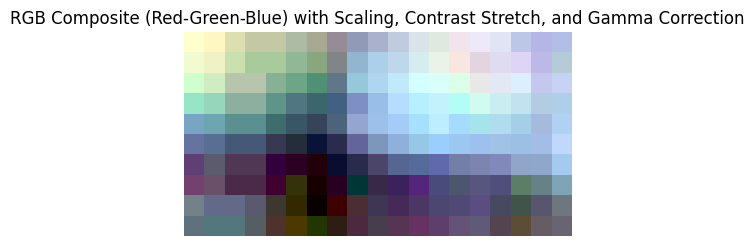

In [64]:
# Select a random image file from the dataset and visualize it
path = random.choice(data['tif_path'].values)
image = visualize_rgb_image(path)

# Feature Engineering

**Utils**

In [65]:
# Example feature calculation functions
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water Index)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)

In [70]:
import os

# Function to calculate features for each row in the data
def process_row_for_features(index, row):
    features = {'index': index}

    # Retrieve the TIFF file path and check if it's valid
    tif_path = row['tif_path']
    if not isinstance(tif_path, str) or not os.path.exists(tif_path):
        print(f"Skipping entry due to missing or invalid tif_path for index {index}")
        # Add NaN for all features if path is missing
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan
        })
        return features

    # Open the TIFF file and read bands for feature calculation
    with rasterio.open(tif_path) as src:
        red = src.read(3)    # B4 for Red
        green = src.read(2)  # B3 for Green
        blue = src.read(1)   # B2 for Blue
        nir = src.read(4)    # B8 for NIR

        # Calculate each feature
        features['ndvi'] = calculate_ndvi(nir, red)
        features['evi'] = calculate_evi(nir, red, blue)
        features['ndwi'] = calculate_ndwi(nir, green)
        features['gndvi'] = calculate_gndvi(nir, green)
        features['savi'] = calculate_savi(nir, red)
        features['msavi'] = calculate_msavi(nir, red)

    return features

**Calculate Features**

In [71]:
# Use parallel processing to calculate features for each row
# `tqdm` provides a progress bar to track completion
new_features = Parallel(n_jobs=-1)(delayed(process_row_for_features)(index, row)
                                   for index, row in tqdm(data.iterrows(), total=len(data)))

100%|██████████| 10606/10606 [02:41<00:00, 65.87it/s]


**Merge New Features with Original Data**

In [72]:
# Convert list of features to a DataFrame and merge with the original data
new_features_df = pd.DataFrame(new_features).set_index('index')
data = data.join(new_features_df)

In [73]:
data.head()

FarmID  category   Crop      State District Sub-District       SDate  \
0  1326576   Healthy  Paddy  Telangana    Medak    Kulcharam  25-11-2023   
1  1326577   Healthy  Paddy  Telangana    Medak    Kulcharam  13-11-2023   
2  1326578   Healthy  Paddy  Telangana    Medak    Kulcharam  19-12-2023   
3  1331836  Diseased  Paddy  Telangana    Medak    Kulcharam  11-02-2023   
4  1326579  Diseased  Paddy  Telangana    Medak    Kulcharam  12-12-2023   

        HDate  CropCoveredArea  CHeight  ... Season  \
0  14-04-2024               97       54  ...   Rabi   
1  26-04-2024               82       58  ...   Rabi   
2  28-04-2024               92       91  ...   Rabi   
3  04-11-2024               91       52  ...   Rabi   
4  19-05-2024               94       55  ...   Rabi   

                                            geometry dataset  \
0  POLYGON ((78.18079 17.97897, 78.1811 17.97948,...   train   
1  POLYGON ((78.17483 17.98151, 78.17649 17.98136...   train   
2  POLYGON ((78.16888 17.97673, 78.16968 17.97661...   train   
3  POLYGON ((78.16822 17.97469, 78.16955 17.97522...   train   
4  POLYGON ((78.17244 17.96962, 78.17303 17.96964...   train   

                                            tif_path      ndvi       evi  \
0  downloads/20240412T050649_20240412T051727_T43Q...       NaN       NaN   
1  downloads/20240425T051649_20240425T052817_T43Q...  0.188090  0.564248   
2  downloads/20240427T050651_20240427T051439_T43Q...  0.206596 -1.456745   
3  downloads/20241103T050951_20241103T052004_T43Q...  0.206250  2.206184   
4  downloads/20240517T050651_20240517T051655_T43Q...  0.179721 -0.743638   

        ndwi     gndvi      savi        msavi  
0        NaN       NaN       NaN          NaN  
1  11.493762  0.187815  0.282110  3249.392822  
2  10.166884  0.206553  0.309869  3741.956055  
3  10.446196  0.220995  0.309350  3673.396729  
4   8.665929  0.160657  0.269563  4227.338379  

[5 rows x 28 columns]

**Split Dataset into Train and Test**

In [74]:
# Split the data into train and test sets based on the 'dataset' column
train = data[data.dataset == 'train'].reset_index(drop=True)
test = data[data.dataset == 'test'].reset_index(drop=True)

In [75]:
# Define columns to drop before encoding and training
to_drop = [
    'geometry', 'tif_path',  # Spatial and file path information
    'dataset', 'FarmID',     # Columns that are not needed for modeling
]

# Drop the specified columns from train and test sets
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)


In [76]:
# Concatenate train and test datasets for uniform encoding of categorical columns
data_combined = pd.concat([train, test], ignore_index=True)

In [77]:
# Create a mapping for the target variable 'category' to numeric labels, excluding NaN values
category_mapper = {label: idx for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}

# Map the 'category' column to the new 'target' column using the mapping, handling NaN values as needed
data_combined['target'] = data_combined['category'].map(category_mapper)

# Drop the original 'category' column now that we have the 'target' column
data_combined.drop(columns=['category'], inplace=True)

In [78]:
# Identify categorical columns to encode
categorical_cols = data_combined.select_dtypes(include=['object']).columns

# Apply Label Encoding for all categorical columns
for col in categorical_cols:
    encoder = LabelEncoder()
    data_combined[col] = encoder.fit_transform(data_combined[col])

In [79]:
# Split the combined encoded data back into train and test
train_encoded = data_combined[data_combined.index < len(train)].reset_index(drop=True)
test_encoded = data_combined[data_combined.index >= len(train)].reset_index(drop=True)

# Model Training

In [80]:
# Separate features and target variable in the train set
X = train_encoded.drop(columns=['target'])
y = train_encoded['target'].astype(int)

In [81]:
# Stratified split based on 'target' for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [82]:
# Configuration dictionary for LightGBM parameters
config_dict = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(category_mapper),  # Number of classes in the target
    'num_leaves': 81,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'random_state': 42,
    'force_row_wise': 'true'
}

# Initialize LightGBM classifier with config_dict parameters
model = LGBMClassifier(**config_dict)

# Fit the model with an evaluation set for early stopping and progress tracking
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
)

[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 22
[LightGBM] [Info] Start training from score -0.192516
[LightGBM] [Info] Start training from score -2.812355
[LightGBM] [Info] Start training from score -2.788886
[LightGBM] [Info] Start training from score -2.926845


LGBMClassifier(force_row_wise='true', learning_rate=0.01,
               metric='multi_logloss', n_estimators=500, num_class=4,
               num_leaves=81, objective='multiclass', random_state=42)

In [83]:
# Predict on the validation set
y_pred = model.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      1.00      0.90      1301
    Diseased       0.00      0.00      0.00        95
       Pests       0.00      0.00      0.00        97
    Stressed       0.00      0.00      0.00        85

    accuracy                           0.82      1578
   macro avg       0.21      0.25      0.23      1578
weighted avg       0.68      0.82      0.74      1578


Weighted F1 Score: 0.7448226174527974


 # Submit

In [87]:
# Load submission file
sample_submission = pd.read_csv(root_path / 'telangana_data' / 'data' / "SampleSubmission.csv")

# Predict on the test set
test_predictions = model.predict(test_encoded.drop(columns=['target']))  # Drop 'FarmID' if it exists in test_encoded

# Ensure the sample_submission DataFrame matches the length of test_encoded
sample_submission = sample_submission.iloc[:len(test_encoded)]

# Fill sample_submission.csv & Save
sample_submission['Target'] = test_predictions
sample_submission['Target'] = sample_submission['Target'].astype(int).map(idx_to_category_mapper)
sample_submission.to_csv('submission.csv', index=False)

In [88]:
sample_submission.head()

ID   Target
0    85197  Healthy
1   779677  Healthy
2  1331840  Healthy
3   483053  Healthy
4   542945  Healthy

In [89]:
sample_submission['Target'].value_counts()

Target
Healthy     2716
Diseased       2
Name: count, dtype: int64